Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.


Use classification instead of linear regression 
   - Determine best ex-post portfolio of top 6 (long) - bottom 6 (short) by month.
   - Construct response variable with 3 classes: long, short, flat. 
   - Construct classification models that minimize a cross-entropy objective vs. 3-class response variable

1) Off-the shelf sklearn models

2) Popular boosting models: XGBoost, CatBoost, LiteGBM. These models tend to be faster and more tuneable than the off-the-shelf sklearn classification models and are often used in Kaggle contests

3) Neural net classification model

4) Classification models aren't rank-aware. Misclassifying a true long as flat is penalized the same as misclassifying a true long as short. Improve NN model with a custom loss function to increase the penalty for the worst misclassifications. The hope is that this decreases overall classification accuracy but improve portfolio performance.

5) When we map returns into long/short/flat classes, we throw away information. We create an NN model that simultaneously predicts returns and classes by outputing both and minimizing a weighted sum of MSE and cross-entropy.
 
6) NN regression model. Normalize output. Construct portfolio by weighting stocks by regression forecast. Also try weighting by log(1+ normalized forecast).

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import time 
import copy
import random
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC, LogisticRegression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.testing import all_estimators

# other popular gradient boost algorithms
# XGBoost https://xgboost.readthedocs.io/en/latest/
import xgboost 
# Yandex CatBoost https://catboost.yandex/
import catboost 
# Microsoft LightGbm https://lightgbm.readthedocs.io/en/latest/
import lightgbm as lgb 

from scipy.stats import chisquare, kendalltau

import tensorflow as tf
tf.set_random_seed(1764)
print(tf.__version__)
# confirm GPU is in use
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

sess = tf.Session()
print (sess.run(c))
    

import keras
from keras.layers.core import Dense, Activation
from keras.layers import Input
from keras.models import Model

from keras.layers.recurrent import LSTM, GRU
from keras.regularizers import l1
from keras.models import Sequential
from keras.models import load_model
from keras import backend as K
K.set_session(sess)
    
#import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# this will make dataframe display as sortable widget
# commented out because sortable tables not viewable using nbviewer
from beakerx import *

import plotly
# print (plotly.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

random.seed(1764)
np.random.seed(1764)


1.8.0
[[22. 28.]
 [49. 64.]]


Using TensorFlow backend.


In [2]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']

#for ind in industries:
#    data[ind+".3m"] = pd.rolling_mean(data[ind],3)
    
#for ind in industries:
#    data[ind+".6m"] = pd.rolling_mean(data[ind],6)

#for ind in industries:
#    data[ind+".12m"] = pd.rolling_mean(data[ind],12)
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 60)


In [3]:
# exclude 2017 and later to tie to paper
# data = data.loc[data.index[data.index < 201701]]
data = data.loc[data.index[data.index > 195911]]
data


In [4]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

In [5]:
# annualized returns don't match Table 1, oddly
# geometric mean, annualized
pd.DataFrame((np.prod(data/100 + 1)**(12.0/len(data))-1)[:30], columns=['Mean Ann. Return'])

In [6]:
# try this way, arithmetic mean then annualize (not very correct)
#print(pd.DataFrame(((desc.loc['mean']/100+1)**12-1)[:30]))
#nope

# same
pd.DataFrame(((1 + np.mean(data, axis=0)/100)**12 -1)[:30], columns=['Mean Ann. Return'])

In [7]:
#annualized volatility 
pd.DataFrame((desc.loc['std']*np.sqrt(12))[:30].round(2))
# lines up with table 1

In [8]:
X = data.values[:,:npredictors]
Y = data.values[:,-nresponses:]
nrows = X.shape[0]
X.shape

(697, 30)

In [9]:
def subset_selection(X, Y, model_aic, verbose=False, responses=responses, predictors=predictors):
    
    nrows, npreds = X.shape
    nows, nresps = Y.shape
    coef_dict = []
    
    for response_index in range(nresps):
        y = Y[:,response_index]
        model_aic.fit(X, y)
        predcols = [i for i in range(npreds) if model_aic.coef_[i] !=0]

        #y_response = model_aic.predict(X)
        # print ("In-sample LASSO R-squared: %.6f" % r2_score(y, y_response))
        if verbose and responses:
            print("LASSO variables selected for %s: " % responses[response_index])
            print([predictors[i] for i in predcols])
        
        if not predcols:
            if verbose and responses:
                print("No coefs selected for " + responses[response_index] + ", using all")
                print("---")
            predcols = list(range(npreds))    
            
        # fit OLS vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        coef_dict.append(predcols)
        if verbose and responses and predictors:
            print("Running OLS for " + responses[response_index] + " against " + str([predictors[i] for i in predcols]))
            # col nums of selected responses
            model_ols = LinearRegression()
            model_ols.fit(X[:, predcols], y)
            y_pred = model_ols.predict(X[:, predcols])
            print ("In-sample OLS R-squared: %.2f%%" % (100 * r2_score(y, y_pred)))
            print("---")
            
    return coef_dict

#coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'))
coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'), verbose=True, responses=responses, predictors=predictors)
print(coef_dict)
# These subsets line up closely with Table 2
# except Clths, Whlsl, we get different responses

LASSO variables selected for Food.lead: 
['Clths', 'Coal', 'Util', 'Rtail']
Running OLS for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample OLS R-squared: 2.22%
---
LASSO variables selected for Beer.lead: 
['Food', 'Clths', 'Coal']
Running OLS for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample OLS R-squared: 2.55%
---
LASSO variables selected for Smoke.lead: 
['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Running OLS for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample OLS R-squared: 6.47%
---
LASSO variables selected for Games.lead: 
['Books', 'Clths', 'Coal', 'Fin']
Running OLS for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample OLS R-squared: 5.00%
---
LASSO variables selected for Books.lead: 
['Games', 'Books', 'Clths', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Meals', 'Fin']
Running OLS for Books.lead against ['Games

In [10]:
# same predictors selected for all but 2 response vars
# use predictors from paper to match results
if True: # turn off/on
    coef_dict_temp = {}
    coef_dict_temp['Food.lead'] = ['Clths', 'Coal', 'Util', 'Rtail']
    coef_dict_temp['Beer.lead'] = ['Food', 'Clths', 'Coal']
    coef_dict_temp['Smoke.lead'] = ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
    coef_dict_temp['Games.lead'] = ['Books', 'Clths', 'Coal', 'Fin']
    coef_dict_temp['Books.lead'] = ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Hshld.lead'] = ['Clths', 'Coal', 'Rtail']
    coef_dict_temp['Clths.lead'] = ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry',  'Coal', 'Oil', 'Util','Telcm', 'Servs', 'BusEq', 'Rtail']
    # Running OLS for Clths against ['Clths', 'Coal', 'Oil', 'Servs', 'Rtail']
    coef_dict_temp['Hlth.lead'] = ['Books', 'Mines', 'Coal', 'Util']
    coef_dict_temp['Chems.lead'] = ['Clths']
    coef_dict_temp['Txtls.lead'] = ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Cnstr.lead'] = ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin']
    coef_dict_temp['Steel.lead'] = ['Fin']
    coef_dict_temp['FabPr.lead'] = ['Trans', 'Fin']
    coef_dict_temp['ElcEq.lead'] = ['Fin']
    coef_dict_temp['Autos.lead'] = ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Carry.lead'] = ['Trans']
    coef_dict_temp['Mines.lead'] = []
    coef_dict_temp['Coal.lead'] = ['Beer', 'Smoke', 'Books', 'Autos', 'Coal', 'Oil', 'Paper', 'Rtail']
    coef_dict_temp['Oil.lead'] = ['Beer', 'Hlth', 'Carry']
    coef_dict_temp['Util.lead'] = ['Food', 'Beer', 'Smoke', 'Hshld', 'Hlth', 'Cnstr', 'FabPr', 'Carry', 'Mines', 'Oil', 'Util', 'Telcm', 'BusEq', 'Whlsl', 'Fin', 'Other']
    coef_dict_temp['Telcm.lead'] = ['Beer', 'Smoke', 'Books', 'Hshld', 'Cnstr', 'Autos', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Meals', 'Fin']
    coef_dict_temp['Servs.lead'] = ['Smoke', 'Books', 'Steel', 'Oil', 'Util', 'Fin']
    coef_dict_temp['BusEq.lead'] = ['Smoke', 'Books', 'Util']
    coef_dict_temp['Paper.lead'] = ['Clths', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Trans.lead'] = ['Fin']
    coef_dict_temp['Whlsl.lead'] = ['Food', 'Beer', 'Smoke', 'Books', 'Hlth', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Fin', 'Other']
    # Running OLS for Whlsl against ['Food', 'Smoke', 'Books', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'Fin', 'Other']
    coef_dict_temp['Rtail.lead'] = ['Rtail']
    coef_dict_temp['Meals.lead'] = ['Smoke', 'Books', 'Clths', 'Steel', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Meals', 'Fin']
    coef_dict_temp['Fin.lead'] = ['Fin']
    coef_dict_temp['Other.lead'] = ['Clths', 'Fin']
    
coef_dict_paper = []
for response in responses:
    print(response, " -> ", coef_dict_temp[response])
    coef_dict_paper.append([predictor_reverse_dict[jstr] for jstr in coef_dict_temp[response]])
print(coef_dict_paper)

Food.lead  ->  ['Clths', 'Coal', 'Util', 'Rtail']
Beer.lead  ->  ['Food', 'Clths', 'Coal']
Smoke.lead  ->  ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Games.lead  ->  ['Books', 'Clths', 'Coal', 'Fin']
Books.lead  ->  ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
Hshld.lead  ->  ['Clths', 'Coal', 'Rtail']
Clths.lead  ->  ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail']
Hlth.lead  ->  ['Books', 'Mines', 'Coal', 'Util']
Chems.lead  ->  ['Clths']
Txtls.lead  ->  ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
Cnstr.lead  ->  ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin']
Steel.lead  ->  ['Fin']
FabPr.lead  ->  ['Trans', 'Fin']
ElcEq.lead  ->  ['Fin']
Autos.lead  ->  ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', 'Rtail', 'Fin']
Carry.lead  ->  ['Trans']
Mines.lead  ->  []
Coal.lead  ->  ['Beer', 'Smoke', 'Books', 'Autos', 'Coal', 

In [11]:
def predict_with_subsets(X, Y, create_model, coef_dict, verbose=False):
    """evaluate subset selection, pass a model function and subsets, compute avg R-squared"""
    global responses

    nrows, ncols = Y.shape
    model = create_model()
    
    scores = []
    for response_col in range(ncols):
        y = Y[:,response_col]

#        print("LASSO variables selected for %s: " % pred)
#        print(coef_dict[pred])
        
        if not coef_dict[response_col]:
            if verbose:
                print("No coefs selected for " + responses[response_col])
 #           print("---")
            continue
        # fit model vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        #print("Running model for " + pred + " against " + str(coef_dict[pred]))
        # col nums of selected predictors
        predcols = coef_dict[response_col]
        model.fit(X[:, predcols], y)
        y_pred = model.predict(X[:, predcols])
        score = r2_score(y, y_pred)
        scores.append(score)
        if verbose:
            print ("In-sample R-squared: %.2f%% for %s against %s" % (score*100, responses[response_col], 
                                                                      str([predictors[i] for i in coef_dict[response_col]])))
#        print("---")
    
    if verbose:
        print("Mean R-squared: %.2f%%" % (100 * np.mean(np.array(scores))))
    return np.mean(np.array(scores))
    
predict_with_subsets(X, Y, LinearRegression, coef_dict_paper, verbose=True)


In-sample R-squared: 2.22% for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample R-squared: 2.55% for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample R-squared: 6.47% for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample R-squared: 5.00% for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample R-squared: 6.21% for Books.lead against ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
In-sample R-squared: 3.01% for Hshld.lead against ['Clths', 'Coal', 'Rtail']
In-sample R-squared: 7.66% for Clths.lead against ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail']
In-sample R-squared: 2.49% for Hlth.lead against ['Books', 'Mines', 'Coal', 'Util']
In-sample R-squared: 0.75% for Chems.lead against ['Clths']
In-sample R-squared: 7.85% for Txtls.lead against ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
In

0.038197169958120156

In [12]:
# use all predictors - higher in-sample R-squared
coef_dict_all = []
for _ in responses:
    coef_dict_all.append(range(len(predictors)))
predict_with_subsets(X, Y, LinearRegression, coef_dict_all, verbose=False)


0.06481232407220758

In [13]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[ -3.34  -1.95  -7.59  -7.76 -12.05  -7.5   -5.69  -7.71  -7.37  -5.26
  -9.84  -6.31  -7.15  -6.89  -9.35 -12.49  -2.34  -0.77 -12.16  -4.83
  -3.16 -11.17  -9.73  -8.89  -8.17  -8.28  -6.31 -13.12  -9.78  -6.2 ]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq    -6.89
Autos    -9.35
Carry   -12.49
Mines    -2.34
Coal     -0.77
Oil     -12.16
Util     -4.83
Telcm    -3.16
Servs   -11.17
BusEq    -9.73
Paper    -8.89
Trans    -8.17
Whlsl    -8.28
Rtail    -6.31
Meals   -13.12
Fin      -9.78
Other    -6.20
Name: 197001, dtype: float64


In [14]:
class PredictWrapper():
    """Wrap an sklearn model e.g. LinearRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it"""

    def __init__(self, create_model, coef_dict, fit_missing=None):
        self.create_model = create_model        
        self.coef_dict = coef_dict
        self.fit_missing = fit_missing
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            if self.coef_dict[responsecol]:
                # column indexes to fit against each other
                predcols = self.coef_dict[responsecol]
            else: # no columns selected
                if not self.fit_missing:
                    # default: don't fit if no predictors selected
                    self.models.append(None)
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "mean":
                    # append a numeric value to use
                    self.models.append(np.mean(Y_fit[:,responsecol]))
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "all":
                    # predcols = all columns
                    predcols = range(X_fit.shape[1])

            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit[:, predcols], Y_fit[:,responsecol])
            if verbose:
                print("fit on " + str(X_fit[:, predcols].shape) + str(predcols))
                print(model.coef_)
                            
            self.models.append(model)
                
            #debug
            #print(responsecol)
            #print(X_fit[:, predcols])
            #print("=====")
            #print(Y_fit[:,responsecol])
            #print("=====")
            #print(self.model.coef_)
            #print(self.model.intercept_)
            #print("=====")                

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            #print (type(self.models[responsecol]))
            if type(self.models[responsecol]) == np.float64:
                pred = np.array([self.models[responsecol]] * nrows).reshape(nrows,1)
                predictions.append(pred)
                sys.stdout.write('\010#')
            elif not self.models[responsecol]: 
                # don't predict
                predictions.append(np.array([np.nan] * nrows ).reshape(nrows,1))
                sys.stdout.write('\010N')
            else:
                predcols = self.coef_dict[responsecol]
                y_pred = self.models[responsecol].predict(X_predict[:,predcols])
                if verbose:
                    print("predict on" + str(X_predict[:, predcols].shape) + str(predcols))
                    print(y_pred)
                predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
        

In [15]:
class ClassifyWrapper():
    """Wrap an sklearn model e.g. LogisticRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, create_model):
        self.create_model = create_model        
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit, Y_fit[:,responsecol])
            self.models.append(model)

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict_proba(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows,1)))
        return [np.hstack(predictions) for predictions in retlist]
        
        

### BacktestModel class to abstract walk-forward validation and backtesting workflow from modeling, portfolio construction, reporting

In [16]:
# typical pipeline
# backtestmodel = BacktestModel(X, # predictors
#                              Y, # responses
#                              create_model=LinearRegression, # create_model which returns a model (needed for 'timestep' which creates different model each timestep)
#                              # or model = someKerasModel, # initialized model that supports fit(X,Y), predict(X) , predicts an entire row,
#                              coef_dict_param=coef_dict_paper, # how to map predictors to responses ("all", "timestep", or a list of lists)
#                              startindex=FIRST_TRAIN_MONTHS, # initial training for backtest
#                              fit_missing='mean', # what to do when no predictors are selected in coef_dict_param - use all predictors, use historical mean, use np.nan
#                              scaler = None) # scaling function like MinMaxScaler

# backtestmodel.gen_predictions(verbose=False) # starting from startindex, step through X,Y month by month, fit up to current month, predict next month, store prediction in self.P
# backtestmodel.walkforward_xval(n_splits=5, verbose=True) # calls gen_predictions with a large step, fits and predicts one large fold at a time (useful to cross-validate quickly)
# backtestmodel.evaluate_predictions() # report metrics on prediction : MSE etc. #TODO: support custom calcs before/after/instead of default calcs
# backtestmodel.gen_returns(calc_returns, verbose=True) # takes a function that returns portfolio returns based on self.P, stores in self.R
# backtestmodel.report_returns(start_date=start_date_str, freq='M') # calc cumulative perf and report (TODO: allow it to take a reporting function to run before/after/in place of default report)
# backtestmodel.evaluate_quantiles(chart=True, verbose=True) # report quantile metrics # TODO: make this a custom calc passed into evaluate_predictions

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 make_classes=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            # by rows
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # self.Xscale = scaler().fit_transform(self.Xscale.transpose()).transpose()
            # self.Yscale = scaler().fit_transform(self.Yscale.transpose()).transpose()
            # by cols
            # MinMaxScaler: each col (min->0, max->1) 
            # StandardScaler: each col (mean->0, SD->1)            
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.Yscale = scaler().fit_transform(self.Yscale)
        
        if make_classes: # doing classification, turn Y target into classes
            self.Yscale = make_classes(self.Yscale)
            self.nclasses = np.unique(self.Yscale).shape[0]
        self.make_classes = make_classes

        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict_regression(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.Ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    def fit_predict_classify(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)

        if self.create_model:
            self.model = ClassifyWrapper(self.create_model)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict_proba(X_predict, verbose=verbose)


    def gen_predictions_regression(self,
                                   step=1, 
                                   splits=None,
                                   verbose=False):

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.Ycols = self.Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict_regression(month_index, forecast_rows, verbose=False)
            
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        
    def gen_predictions_classify(self,
                                 step=1, 
                                 splits=None,
                                 verbose=False,
                                 classindexes=None
                                ):
        # make this generic  - return fit_predict
        # P = average of classindexes weighted by class probability
        self.P = np.zeros_like(self.Yscale)
        if not classindexes:
            classindexes = range(self.nclasses)
            # sum to 1
            divisor = float(sum(classindexes))
            classindexes = [cw / divisor for cw in classindexes]

        progress_i = 0
        self.nrows, self.Ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
                
            classprobs = self.fit_predict_classify(month_index, forecast_rows, verbose=False)
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                for i in range(len(classprobs)):
                    self.P[first_pred_row + row_index, :] += classprobs[i][row_index, :] * classindexes[i]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        
    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):
        if self.make_classes: # classification problem
            self.gen_predictions_classify(step=step, splits=splits, verbose=verbose)
        else:
            self.gen_predictions_regression(step=step, splits=splits, verbose=verbose)
    
    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        self.mse = np.mean(msetemp)
        print("OOS MSE across all predictions: %.4f" % self.mse)
        self.model.fit(self.Xscale, self.Yscale)
        Y_pred = self.model.predict(self.Xscale)
        self.in_sample_mse = np.mean((Y_pred - self.Yscale) ** 2)
        print("In-sample MSE: %.4f" % self.in_sample_mse)

        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- self.mse/y_variance))
        
        return(self.mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        self.kendalltaus = []
        self.ktpvals = []
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))
            kt, p_val = kendalltau(self.P[row], self.Y[row])
            self.kendalltaus.append(kt)
            self.ktpvals.append(p_val)

        self.kendalltau = np.mean(self.kendalltaus)
        self.kendalltau_pvalue = np.mean(self.ktpvals)         
        print("Avg rank correlation (Kendall's tau): %.4f (Expected: 0)" % (self.kendalltau))
        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols)
        self.quintile_accuracy = accuracy_score(pred_quantiles, true_quantiles)
        print("5-quintile accuracy: %.4f (Expected: 0.2)" % (self.quintile_accuracy))
        
        pred_direction = np.zeros(nrows*ncols)
        true_direction = np.zeros(nrows*ncols)
        for i in range(nrows*ncols):
            if pred_quantiles[i] == 4:
                pred_direction[i] = 1
            elif pred_quantiles[i] == 0:
                pred_direction[i] = -1
            if true_quantiles[i] == 4:
                true_direction[i] = 1
            elif true_quantiles[i] == 0:
                true_direction[i] = -1
        self.directional_accuracy = accuracy_score(pred_direction, true_direction)
        print("Long/short/flat accuracy: %.4f (Expected: 0.44)" % (self.directional_accuracy))

        nrows = nrows * ncols
            
        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])*nrows

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat5 = confusion_matrix(temp_pred, temp_actual)
            diff_mat = conf_mat5 - conf_mat_expected
            if verbose:
                print("Confusion matrix for quantile %d" % q)
                print(conf_mat5)
                cstmp, cspvtmp = chisquare(conf_mat5.reshape(4), conf_mat_expected.reshape(4))
                print("Chi-square: %.4f (p-value: %.8f)" % (cstmp, cspvtmp))

            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = diff_mat[1][1]
            myscores.append(myscore)

        # sum of true positive for top and bottom quintiles
        self.excess_tp = myscores[0] + myscores[4]
        print("Excess true positive in quintiles 1 + 5: %f" % (self.excess_tp))

        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual Quintile')
            plt.xlabel('Predicted Quintile')
            plt.show()

        self.model.fit(self.Xscale, self.Yscale, verbose=verbose)
        Y_pred = self.model.predict(self.Xscale, verbose=verbose)
        nrows, ncols = Y_pred.shape
        self.insample_accuracy=accuracy_score(self.Yscale.reshape(nrows*ncols,1), Y_pred.reshape(nrows*ncols,1))
            
        return None

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-folds
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        return self.gen_predictions(splits=last_indexes, verbose=verbose)
    
    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.Ycols
        longcount = [0] * self.Ycols
        shortcount = [0] * self.Ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
        if verbose:
            for i in range(len(responses)):
                print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                             longcount[i], 
                                                                             shortcount[i], 
                                                                             indcount[i]))
        return self.R

    def report_returns(self, start_date='01/01/1970', freq='M'):

        first_pred_month=self.startindex        
        self.results = self.R[first_pred_month:]
        nmonths = self.results.shape[0]
        nyears = nmonths/12.0
        index = pd.date_range(start_date,periods=nmonths, freq=freq)
        perfdata = pd.DataFrame(self.results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + self.results / 100)
        self.cumulative_return = perfdata['Equity']
        self.mean_monthly_return_annualized = np.mean(1 + self.results/100) ** 12 - 1
        self.mean_return = (self.cumulative_return[-1]/100) ** (1.0/nyears) - 1
        self.annualized_vol = np.std(self.results/100) * np.sqrt(12.0)
        self.sharpe = self.mean_monthly_return_annualized/self.annualized_vol
        print("Mean return: %.3f%%" % (self.mean_return * 100 ))
        #print("Mean monthly annualized return: %.3f%%" % (self.mean_monthly_return_annualized * 100 ))
        #print("Monthly annualized volatility: %.3f%%" % (self.annualized_vol * 100))
        print("Monthly Sharpe ratio: %.3f" % (self.sharpe))


In [17]:
# return calculation passed to gen_returns

NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns(prediction_row, return_row, numstocks=NUMSTOCKS, verbose=False):

    # ensure nan sorts to top for shorts
    short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
    # pick bottom numstocks
    select_array = np.argsort(short_sort_array)
    short_indexes = select_array[:numstocks]

    # ensure nan sorts to bottom for longs
    long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
    # pick top numstocks
    select_array = np.argsort(long_sort_array)
    long_indexes = select_array[-numstocks:]
    
    if verbose:
        print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
        print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

    # compute equal weighted long/short return
    return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes


In [18]:
def make_three_classes(Y, verbose=False):
    
    ISFLAT=0
    ISLONG=1
    ISSHORT=2

    Y_sortindex = np.argsort(Y)
    if verbose:
        print("Y")
        print(Y[0])
        # sorted position
        print("Y_sortindex")
        print(Y_sortindex[0]) 
        # sorted array
        print("Sorted")
        print(Y[0,Y_sortindex[0]])
        
    # initialize class to 0
    Y_class=np.zeros_like(Y)
    for row in range(Y_class.shape[0]):
        # if index in last 6, long
        longlist = Y_sortindex[row,-6:]
        Y_class[row, longlist]=ISLONG
        # if index is in first 6, short
        shortlist = Y_sortindex[row,:6]
        Y_class[row, shortlist]=ISSHORT
            
    if verbose:
        print("Y_class")
        print(Y_class[0])
        print("1s")
        print([Y[0,i] for i in range(30) if Y_class[0,i]==1])
        print("2s")
        print([Y[0,i] for i in range(30) if Y_class[0,i]==2])
        print(Y_class.shape)

    return Y_class

make_three_classes(Y, verbose=True)

Y
[ -4.49  -5.71  -2.05   1.21  -5.47  -7.84  -8.53  -6.68 -10.03  -4.77
  -6.67  -9.38  -4.42 -12.3  -11.71  -5.03  -3.81  -7.91  -7.82  -2.4
   0.62  -6.18  -7.93  -9.41  -4.31  -5.33  -6.09 -10.08  -4.68  -3.98]
Y_sortindex
[13 14 27  8 23 11  6 22 17  5 18  7 10 21 26  1  4 25 15  9 28  0 12 24
 29 16 19  2 20  3]
Sorted
[-12.3  -11.71 -10.08 -10.03  -9.41  -9.38  -8.53  -7.93  -7.91  -7.84
  -7.82  -6.68  -6.67  -6.18  -6.09  -5.71  -5.47  -5.33  -5.03  -4.77
  -4.68  -4.49  -4.42  -4.31  -3.98  -3.81  -2.4   -2.05   0.62   1.21]
Y_class
[0. 0. 1. 1. 0. 0. 0. 0. 2. 0. 0. 2. 0. 2. 2. 0. 1. 0. 0. 1. 1. 0. 0. 2.
 0. 0. 0. 2. 0. 1.]
1s
[-2.05, 1.21, -3.81, -2.4, 0.6199999999999999, -3.98]
2s
[-10.03, -9.38, -12.3, -11.71, -9.41, -10.08]
(697, 30)


array([[0., 0., 1., ..., 2., 0., 1.],
       [0., 2., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 2., 2., ..., 0., 0., 0.]])

In [19]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [20]:
# test fit_predict
backtestmodel = BacktestModel(X, Y, create_model=LogisticRegression, coef_dict_param=coef_dict_all, startindex=FIRST_TRAIN_MONTHS, make_classes=make_three_classes)
backtestmodel.Yscale[0]
backtestmodel.fit_predict_classify(121, npredict=4, verbose=False)


[array([[0.86941661, 0.30341164, 0.5830008 , 0.29458375, 0.93565572,
         0.48530927, 0.84566517, 0.81499747, 0.99569714, 0.11291526,
         0.97229744, 0.66184659, 0.34652676, 0.50679945, 0.12669393,
         0.75030246, 0.72764765, 0.31056721, 0.63556046, 0.49799799,
         0.8079226 , 0.13963378, 0.26163117, 0.8894301 , 0.67420876,
         0.39579273, 0.78561197, 0.54632824, 0.89022439, 0.00555411],
        [0.95490452, 0.31918987, 0.05157961, 0.58901841, 0.76376881,
         0.26303691, 0.97753106, 0.36852793, 0.83884045, 0.06826634,
         0.53448484, 0.11626678, 0.99879146, 0.87874138, 0.79777095,
         0.5873034 , 0.48893146, 0.88166662, 0.25916866, 0.30822859,
         0.25316635, 0.75961109, 0.3600472 , 0.76511068, 0.9846339 ,
         0.53729213, 0.51635931, 0.05701271, 0.21358936, 0.4977546 ],
        [0.69264818, 0.80622419, 0.48722811, 0.34781772, 0.61369407,
         0.39707308, 0.92345619, 0.94876872, 0.61413074, 0.64494303,
         0.88919986, 0.08478156,

In [21]:
backtestmodel.fit_predict_regression(121, npredict=4, verbose=False)


array([[0., 1., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 2., 0., 2., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 2.],
       [0., 1., 1., 0., 0., 2., 0., 2., 0., 1., 0., 2., 0., 0., 0., 0.,
        0., 0., 1., 2., 2., 0., 2., 0., 0., 0., 0., 2., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 2., 1., 0., 2., 0., 0., 2., 0., 0.],
       [0., 0., 2., 0., 2., 1., 2., 1., 0., 0., 1., 1., 0., 0., 0., 2.,
        2., 2., 0., 2., 0., 0., 1., 1., 2., 1., 0., 0., 0., 2.]])

In [22]:
# check 3-class output probabilities sum to 1
z = backtestmodel.fit_predict_classify(121, npredict=4, verbose=False)
z[0] + z[1] + z[2]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

................................................................................
00:06:28 Still training step 80 of 576
................................................................................
00:06:34 Still training step 160 of 576
................................................................................
00:06:43 Still training step 240 of 576
................................................................................
00:06:53 Still training step 320 of 576
................................................................................
00:07:05 Still training step 400 of 576
................................................................................
00:07:19 Still training step 480 of 576
................................................................................
00:07:35 Still training step 560 of 576
................
Food: long 110 times, short 66 times, total 176 times
Beer: long 136 times, short 97 times, total 233 times
Smoke: long 181 times, short 

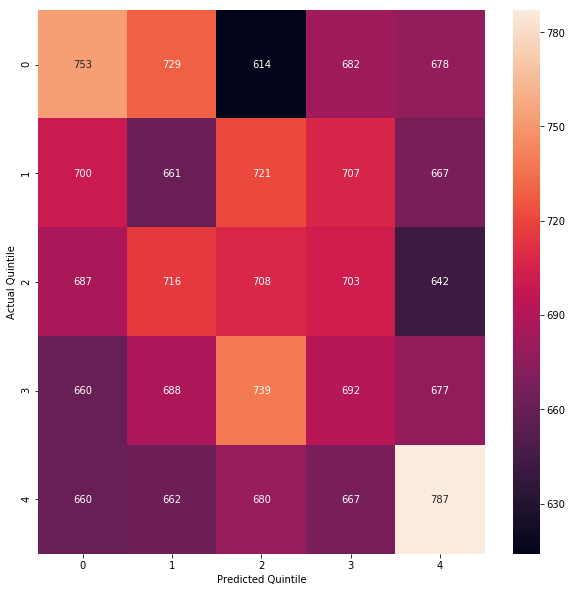

In [23]:
# test model on our calculated coef_dict
# bad methodology, introduces snooping
# selects LASSO vars over whole timespan
# uses selected vars to do OLS backtest
# included as an example of what not to do
backtestmodel = BacktestModel(X, Y, 
                              create_model=LogisticRegression, 
                              coef_dict_param=coef_dict_paper, 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_three_classes)
backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
backtestmodel.gen_returns(calc_returns, verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)


In [108]:
# try various classifiers

def mySGDClassifierLog():
    # needs loss="log"
    return sklearn.linear_model.stochastic_gradient.SGDClassifier(loss="log")

def mySVC():
    # needs probability=True
    return sklearn.svm.classes.SVC(probability=True)

def myXGBClassifier(n_estimators=1000, max_depth=4, subsample=0.7, learning_rate=0.001):
    # needs nthreads=-1
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

def myCatBoostClassifier():
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

# for some reason couldn't get LightGBM sklearn interface to work, wrap it in a class

class LightGbmWrapper:
    """Wrap Lightgbm model to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, 
                 param = {'num_leaves':31, 'num_trees':100, 'objective':'multiclass', 'num_class':3, 'metric': 'multi_logloss',},
                 num_round=10):
        self.param = param
        self.num_round = num_round
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            train_data = lgb.Dataset(X_fit, label=Y_fit[:,responsecol])
            model = lgb.train(self.param, train_data, self.num_round)
            self.models.append(model)

    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows,1)))
        return [np.hstack(predictions) for predictions in retlist]

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(np.array(Z), axis=0)
        
        
# enumerate classifiers 
estimators = []

for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)

estimators = [
    sklearn.linear_model.logistic.LogisticRegression,
    sklearn.linear_model.logistic.LogisticRegressionCV,
    sklearn.ensemble.weight_boosting.AdaBoostClassifier,
    sklearn.ensemble.bagging.BaggingClassifier,
    sklearn.naive_bayes.BernoulliNB,
    sklearn.calibration.CalibratedClassifierCV,
    sklearn.tree.tree.DecisionTreeClassifier,
    sklearn.tree.tree.ExtraTreeClassifier,
    sklearn.ensemble.forest.ExtraTreesClassifier,
    sklearn.naive_bayes.GaussianNB,
    sklearn.gaussian_process.gpc.GaussianProcessClassifier,
    sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
    sklearn.neighbors.classification.KNeighborsClassifier,
    sklearn.semi_supervised.label_propagation.LabelPropagation,
    sklearn.semi_supervised.label_propagation.LabelSpreading,
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
    sklearn.neural_network.multilayer_perceptron.MLPClassifier,
    #sklearn.naive_bayes.MultinomialNB,
    #sklearn.svm.classes.NuSVC,
    sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
    sklearn.ensemble.forest.RandomForestClassifier,
    mySGDClassifierLog, 
    mySVC,
    myXGBClassifier(300, 5, 0.003, 0.6),
    myCatBoostClassifier(),
    LightGbmWrapper    
]

estimators



<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble.bagging.BaggingClassifier'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process.gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
<class 'sklearn.semi_supervised.label_propagation.LabelPropagation'>
<class 'sklearn.semi_supervised.label_propagation.LabelSpreading'>
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
<class 'sklearn.linear_model.logistic.LogisticRegression'>
<class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
<c

[sklearn.linear_model.logistic.LogisticRegression,
 sklearn.linear_model.logistic.LogisticRegressionCV,
 sklearn.ensemble.weight_boosting.AdaBoostClassifier,
 sklearn.ensemble.bagging.BaggingClassifier,
 sklearn.naive_bayes.BernoulliNB,
 sklearn.calibration.CalibratedClassifierCV,
 sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.tree.tree.ExtraTreeClassifier,
 sklearn.ensemble.forest.ExtraTreesClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.gaussian_process.gpc.GaussianProcessClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.semi_supervised.label_propagation.LabelPropagation,
 sklearn.semi_supervised.label_propagation.LabelSpreading,
 sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 sklearn.neural_network.multilayer_perceptron.MLPClassifier,
 sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
 sklearn.ensemble.forest.RandomForestClassifier,
 <function __main__.mySGDCl

sklearn.linear_model.logistic.LogisticRegression
................................................................................
15:00:01 Still training step 80 of 563
................................................................................
15:00:09 Still training step 160 of 563
................................................................................
15:00:19 Still training step 240 of 563
................................................................................
15:00:31 Still training step 320 of 563
................................................................................
15:00:44 Still training step 400 of 563
................................................................................
15:01:01 Still training step 480 of 563
................................................................................
15:01:18 Still training step 560 of 563
...
Mean return: 2.029%
Monthly Sharpe ratio: 0.428
Avg rank correlation (Kendall's tau): 0.0232 (Expecte

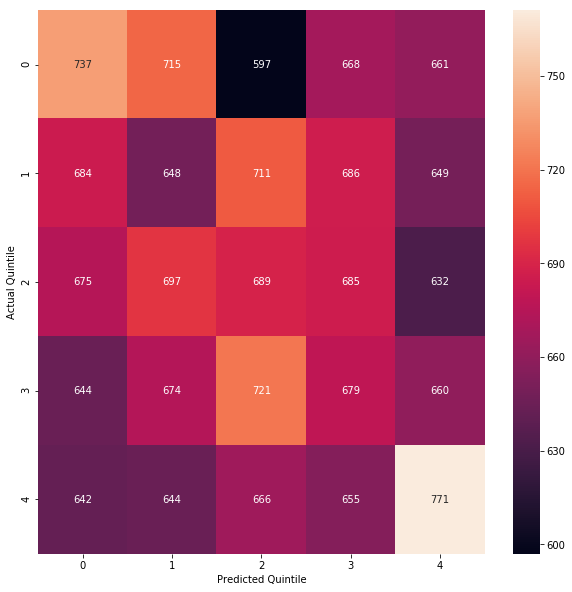

---
sklearn.linear_model.logistic.LogisticRegressionCV
..................................................................
15:13:03 Still training step 80 of 563
................................................................................
15:21:34 Still training step 160 of 563
................................................................................
15:29:28 Still training step 240 of 563
................................................................................
15:38:27 Still training step 320 of 563
................................................................................
15:47:56 Still training step 400 of 563
................................................................................
15:58:06 Still training step 480 of 563
................................................................................
16:09:33 Still training step 560 of 563
...
Mean return: 2.670%
Monthly Sharpe ratio: 0.487
Avg rank correlation (Kendall's tau): 0.0344 (Expected: 0)
5-

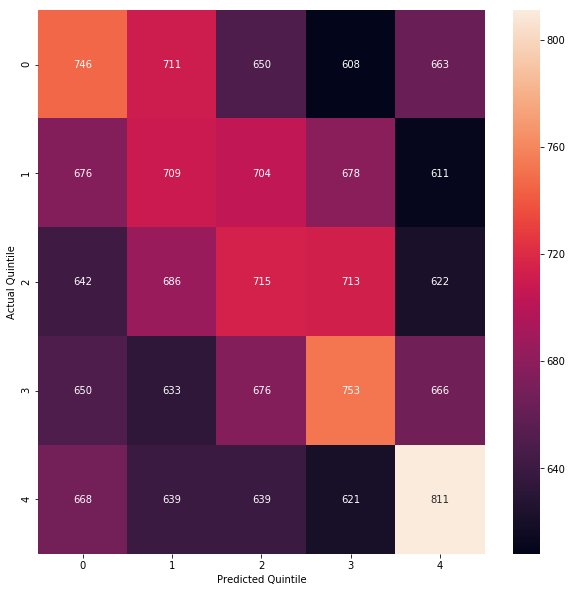

---
sklearn.ensemble.weight_boosting.AdaBoostClassifier
................................................................................
16:12:39 Still training step 80 of 563
................................................................................
16:15:33 Still training step 160 of 563
................................................................................
16:18:49 Still training step 240 of 563
................................................................................
16:22:27 Still training step 320 of 563
................................................................................
16:26:25 Still training step 400 of 563
................................................................................
16:30:48 Still training step 480 of 563
................................................................................
16:35:30 Still training step 560 of 563
...
Mean return: 1.911%
Monthly Sharpe ratio: 0.483
Avg rank correlation (Kendall's tau): 0.0217 (

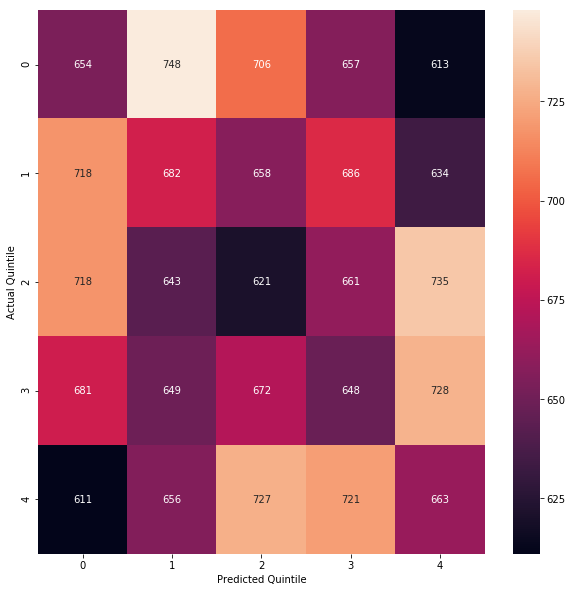

---
sklearn.ensemble.bagging.BaggingClassifier
................................................................................
16:36:33 Still training step 80 of 563
................................................................................
16:37:38 Still training step 160 of 563
................................................................................
16:39:04 Still training step 240 of 563
................................................................................
16:40:54 Still training step 320 of 563
................................................................................
16:43:07 Still training step 400 of 563
................................................................................
16:45:48 Still training step 480 of 563
................................................................................
16:48:57 Still training step 560 of 563
...
Mean return: 1.656%
Monthly Sharpe ratio: 0.382
---
sklearn.naive_bayes.BernoulliNB
...................

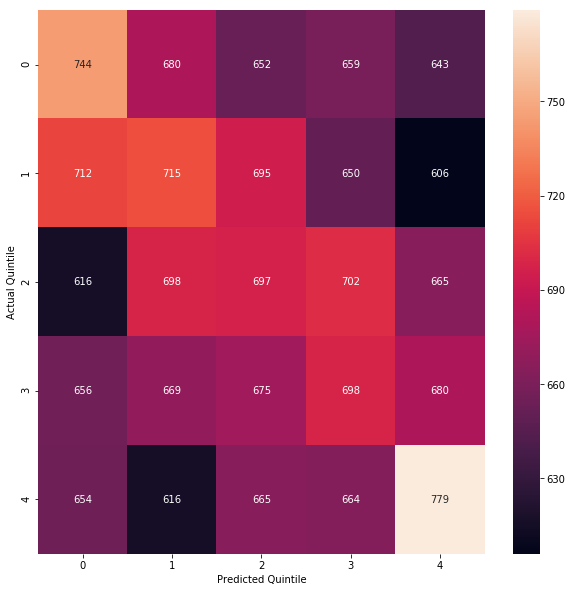

---
sklearn.calibration.CalibratedClassifierCV
................................................................................
16:51:52 Still training step 80 of 563
................................................................................
16:56:07 Still training step 160 of 563
................................................................................
17:02:08 Still training step 240 of 563
................................................................................
17:09:56 Still training step 320 of 563
................................................................................
17:19:39 Still training step 400 of 563
................................................................................
17:31:17 Still training step 480 of 563
................................................................................
17:44:08 Still training step 560 of 563
...
Mean return: 1.800%
Monthly Sharpe ratio: 0.384
Avg rank correlation (Kendall's tau): 0.0189 (Expected:

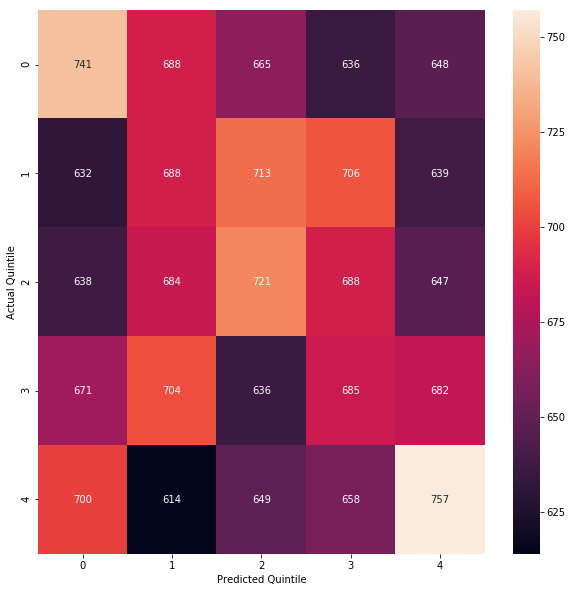

---
sklearn.tree.tree.DecisionTreeClassifier
................................................................................
17:44:56 Still training step 80 of 563
................................................................................
17:45:05 Still training step 160 of 563
................................................................................
17:45:18 Still training step 240 of 563
................................................................................
17:45:35 Still training step 320 of 563
................................................................................
17:45:57 Still training step 400 of 563
................................................................................
17:46:24 Still training step 480 of 563
................................................................................
17:46:55 Still training step 560 of 563
...
Mean return: 0.893%
Monthly Sharpe ratio: 0.232
---
sklearn.tree.tree.ExtraTreeClassifier
...............

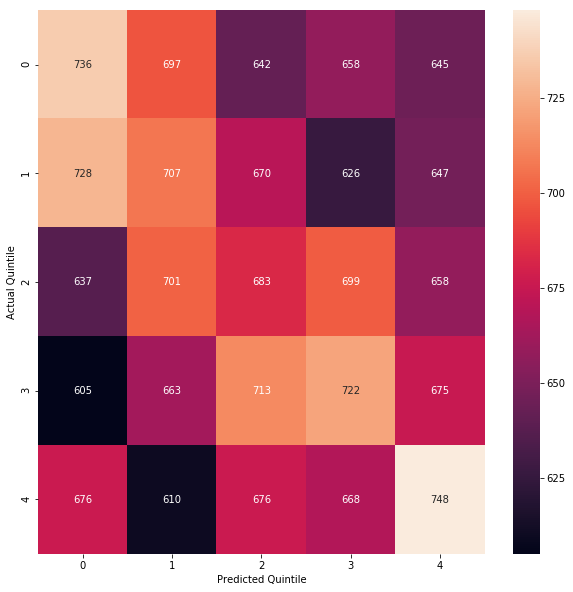

---
sklearn.gaussian_process.gpc.GaussianProcessClassifier
................................................................................
17:52:42 Still training step 80 of 563
................................................................................
17:55:54 Still training step 160 of 563
................................................................................
18:01:36 Still training step 240 of 563
................................................................................
18:10:07 Still training step 320 of 563
................................................................................
18:22:21 Still training step 400 of 563
................................................................................
18:39:46 Still training step 480 of 563
................................................................................
19:03:00 Still training step 560 of 563
...
Mean return: 0.131%
Monthly Sharpe ratio: 0.058
---
sklearn.ensemble.gradient_boosting.Grad

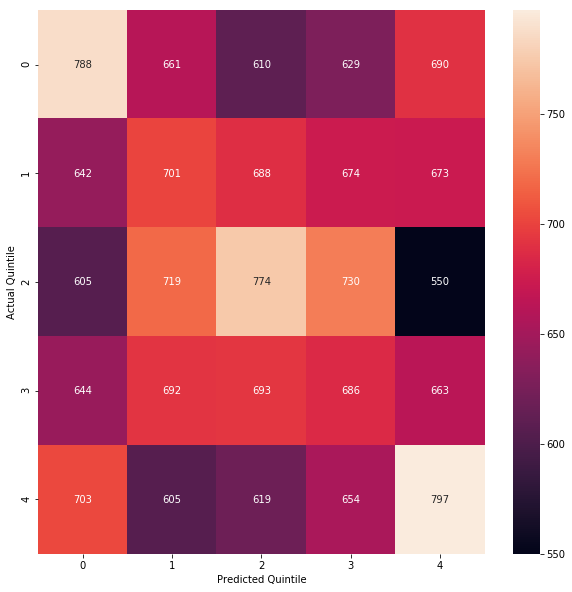

---
sklearn.neighbors.classification.KNeighborsClassifier
................................................................................
20:36:48 Still training step 80 of 563
................................................................................
20:36:50 Still training step 160 of 563
................................................................................
20:36:52 Still training step 240 of 563
................................................................................
20:36:53 Still training step 320 of 563
................................................................................
20:36:56 Still training step 400 of 563
................................................................................
20:36:58 Still training step 480 of 563
................................................................................
20:37:00 Still training step 560 of 563
...
Mean return: 2.019%
Monthly Sharpe ratio: 0.443
---
sklearn.semi_supervised.label_propagatio

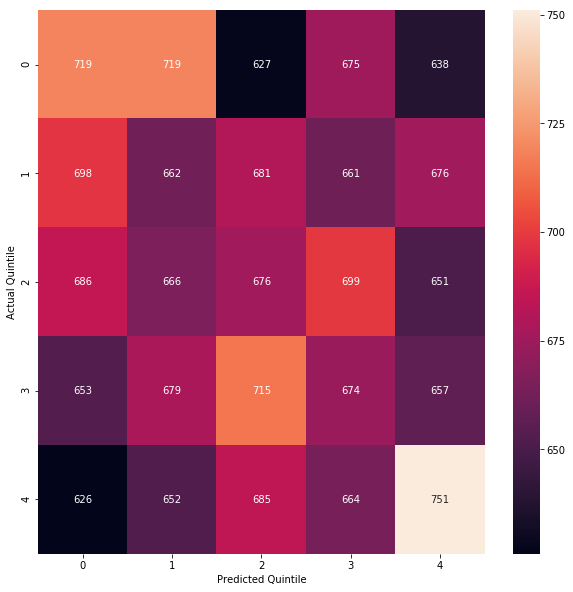

---
sklearn.neural_network.multilayer_perceptron.MLPClassifier
................................................................................
20:48:19 Still training step 80 of 563
................................................................................
20:54:09 Still training step 160 of 563
................................................................................
21:04:23 Still training step 240 of 563
................................................................................
21:12:45 Still training step 320 of 563
................................................................................
21:27:46 Still training step 400 of 563
................................................................................
21:45:46 Still training step 480 of 563
................................................................................
21:57:51 Still training step 560 of 563
...
Mean return: 2.220%
Monthly Sharpe ratio: 0.488
Avg rank correlation (Kendall's tau): 0

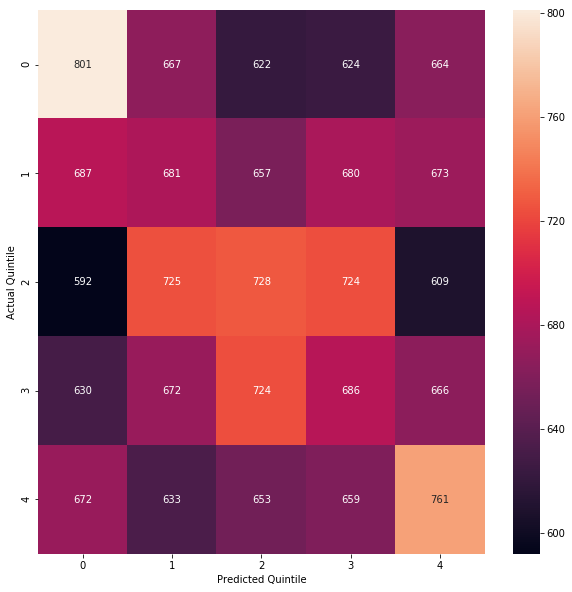

---
sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
................................................................................
21:58:51 Still training step 80 of 563
................................................................................
21:58:55 Still training step 160 of 563
................................................................................
21:58:58 Still training step 240 of 563
................................................................................
21:59:02 Still training step 320 of 563
................................................................................
21:59:06 Still training step 400 of 563
................................................................................
21:59:10 Still training step 480 of 563
................................................................................
21:59:15 Still training step 560 of 563
...
Mean return: -0.121%
Monthly Sharpe ratio: 0.005
---
sklearn.ensemble.forest.RandomFor

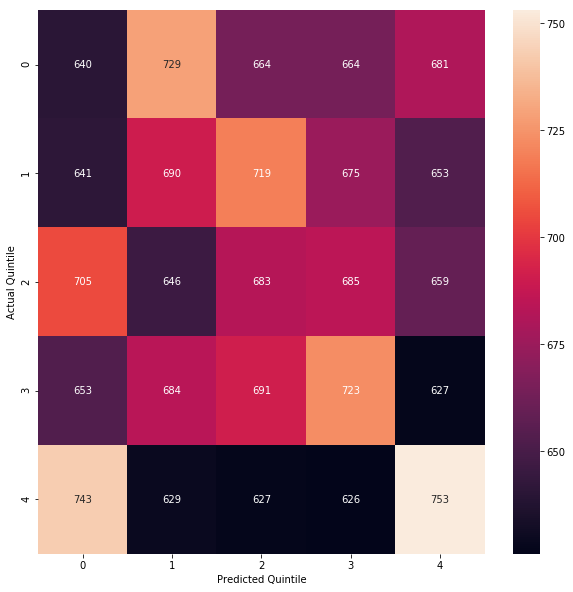

---
xgboost.sklearn.XGBClassifier
................................................................................
22:31:57 Still training step 80 of 563
................................................................................
22:36:07 Still training step 160 of 563
................................................................................
22:41:23 Still training step 240 of 563
................................................................................
22:47:36 Still training step 320 of 563
................................................................................
22:54:48 Still training step 400 of 563
................................................................................
23:02:58 Still training step 480 of 563
................................................................................
23:12:07 Still training step 560 of 563
...
Mean return: 1.887%
Monthly Sharpe ratio: 0.404
Avg rank correlation (Kendall's tau): 0.0241 (Expected: 0)
5-quintil

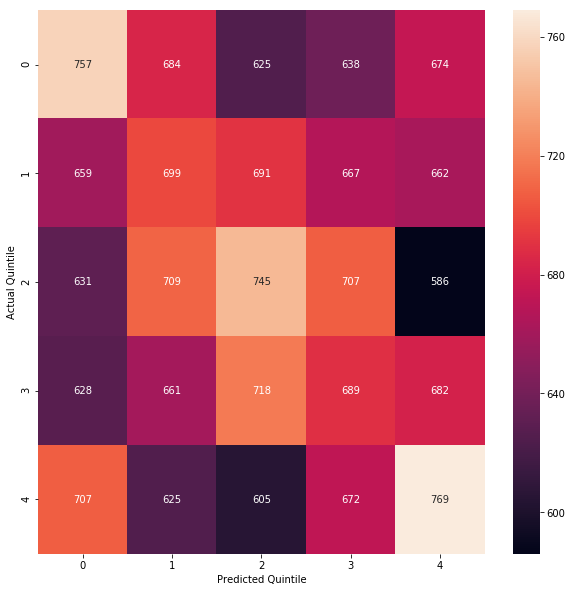

---


In [114]:
est_names = []
sharpes = []
directional_accuracies=[]
in_sample_accuracies = []
for estimator in estimators:
    estname = str(estimator)[10:-19] if str(type(estimator))=="<class 'function'>" else str(estimator)[8:-2]
    print(estname)    
    est_names.append(estname)
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator, 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_three_classes)
    backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes.append(backtestmodel.sharpe)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies.append(backtestmodel.directional_accuracy)
        in_sample_accuracies.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies.append(np.nan)
        in_sample_accuracies.append(np.nan)
    
    print("---")
    

In [ ]:
# run metricsframe, charts

In [ ]:
# chart performance

def mychart(args, names=None, title=""):
    x_coords = np.linspace(1970, 2016, args[0].shape[0])
    plotdata = []
    for i in range(len(args)):
        tracelabel = "Trace %d" % i
        if names:
                tracelabel=names[i]
        plotdata.append(Scatter(x=x_coords,
                                y=args[i].values.reshape(-1),
                                mode = 'line',
                                name=tracelabel))    

    layout = Layout(
        title = title,
        autosize=False,
        width=900,
        height=600,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    


In [ ]:
def myscatter(arg1, arg2, names=None, title=""):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))

    layout = dict(
        title=title,
        autosize=False,
        width="600",
        height="480",
        yaxis=dict(
#            type='log',
            autorange=True
        )
    )
    
#    py.iplot(data, filename='basic-scatter')

    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)

In [ ]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['mse'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = dict(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

In [ ]:
myscatter(mse_list, sharpe_list, title="Sharpe vs. MSE")
myscatter(quintile_accuracy_list, sharpe_list, title="Sharpe vs. Quantile Accuracy")
myscatter(directional_accuracy_list, sharpe_list, title="Sharpe vs. Directional Accuracy")
myscatter(kendalltau_list, sharpe_list, title="Sharpe vs. Kendall's Tau")
myscatter(excess_tp_list, sharpe_list, title="Sharpe vs. True Positives")

In [ ]:
# 4-way plot for blog post
fig = plotly.tools.make_subplots(rows=2, cols=2, subplot_titles=('MSE', 'Quintile Accuracy','Direction Accuracy', "Kendall's tau"))
fig.append_trace(Scatter(
    x = mse_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=1)

fig.append_trace(Scatter(
    x = quintile_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=2)

fig.append_trace(Scatter(
    x = directional_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=1)

fig.append_trace(Scatter(
    x = kendalltau_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=2)


fig['layout'].update(height=1000, width=1000, title='Sharpe ratio scatters vs.')
iplot(fig)

In [ ]:
corrmatrix = skmetricsframe[['sharpe', 'mse',  'kendalltau', 
                           'quantile_score', 'direction_score', 'truepositive_score']].corr()
corrmatrix

In [ ]:
with open('sklearn_corr.html', 'w') as fo:
    corrmatrix.to_html(fo, float_format=lambda x: '%.3f' % x)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmatrix, annot=True, fmt='.3f')
plt.show()


00:06:49 Running 180 experiments
00:06:49 Running experiment 1 of 180
(100, 4, 0.03, 0.6)
................................................................................
00:07:56 Still training step 80 of 563
................................................................................
00:09:15 Still training step 160 of 563
................................................................................
00:10:47 Still training step 240 of 563
................................................................................
00:12:35 Still training step 320 of 563
................................................................................
00:14:36 Still training step 400 of 563
................................................................................
00:16:53 Still training step 480 of 563
................................................................................
00:19:27 Still training step 560 of 563
...
Mean return: 0.511%
Monthly Sharpe ratio: 0.136
Avg rank cor

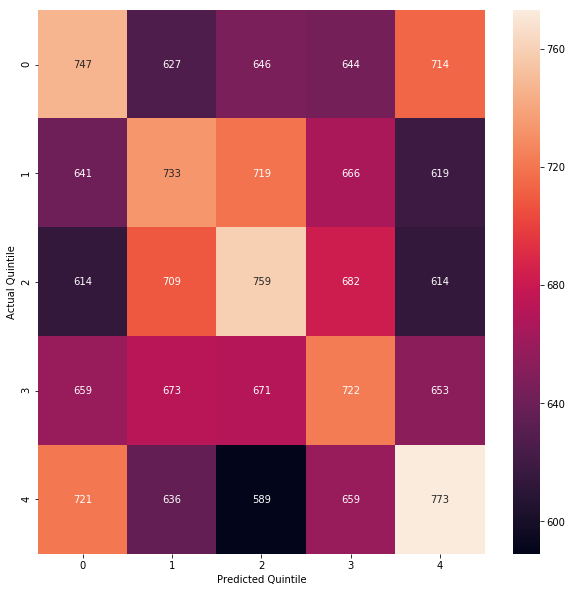

---
00:19:36 Running experiment 2 of 180
(100, 4, 0.03, 0.65)
................................................................................
00:20:44 Still training step 80 of 563
................................................................................
00:22:02 Still training step 160 of 563
................................................................................
00:23:34 Still training step 240 of 563
................................................................................
00:25:19 Still training step 320 of 563
................................................................................
00:27:19 Still training step 400 of 563
................................................................................
00:29:36 Still training step 480 of 563
................................................................................
00:32:08 Still training step 560 of 563
...
Mean return: 0.064%
Monthly Sharpe ratio: 0.037
Avg rank correlation (Kendall's tau): 0.

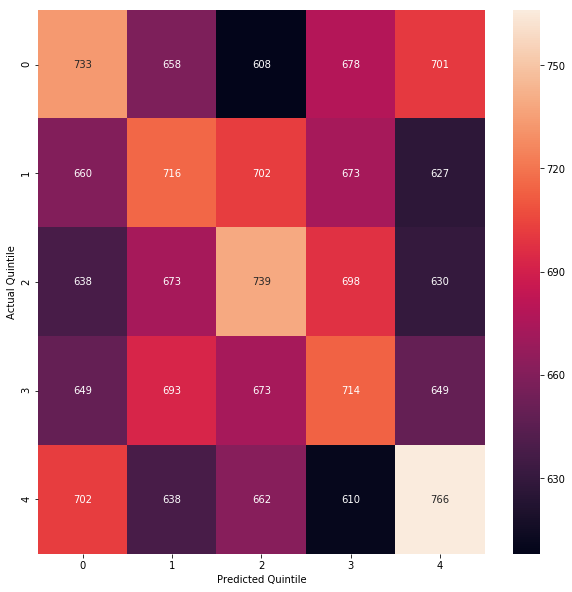

---
00:32:18 Running experiment 3 of 180
(100, 4, 0.03, 0.7)
................................................................................
00:33:25 Still training step 80 of 563
................................................................................
00:34:43 Still training step 160 of 563
................................................................................
00:36:14 Still training step 240 of 563
................................................................................
00:37:59 Still training step 320 of 563
................................................................................
00:39:56 Still training step 400 of 563
................................................................................
00:42:08 Still training step 480 of 563
................................................................................
00:44:37 Still training step 560 of 563
...
Mean return: -0.068%
Monthly Sharpe ratio: 0.009
Avg rank correlation (Kendall's tau): 0.

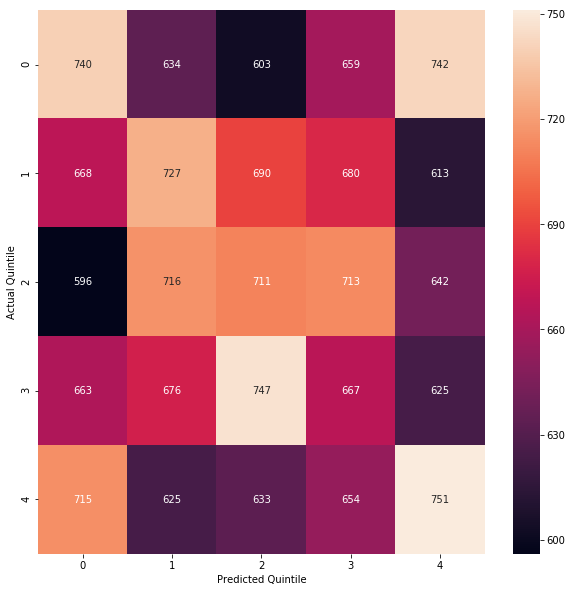

---
00:44:46 Running experiment 4 of 180
(100, 4, 0.03, 0.75)
................................................................................
00:45:54 Still training step 80 of 563
................................................................................
00:47:12 Still training step 160 of 563
................................................................................
00:48:42 Still training step 240 of 563
................................................................................
00:50:27 Still training step 320 of 563
................................................................................
00:52:23 Still training step 400 of 563
................................................................................
00:54:35 Still training step 480 of 563
................................................................................
00:57:03 Still training step 560 of 563
...
Mean return: 0.768%
Monthly Sharpe ratio: 0.189
Avg rank correlation (Kendall's tau): 0.

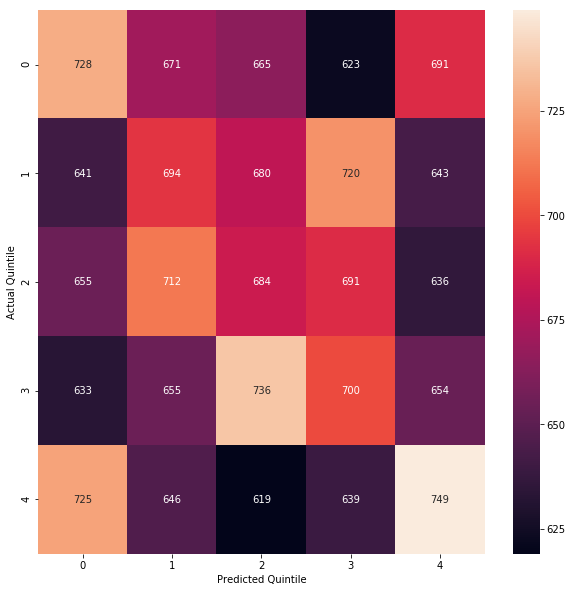

---
00:57:12 Running experiment 5 of 180
(100, 4, 0.01, 0.6)
................................................................................
00:58:14 Still training step 80 of 563
................................................................................
00:59:25 Still training step 160 of 563
................................................................................
01:00:42 Still training step 240 of 563
................................................................................
01:02:09 Still training step 320 of 563
................................................................................
01:03:42 Still training step 400 of 563
................................................................................
01:05:24 Still training step 480 of 563
................................................................................
01:07:16 Still training step 560 of 563
...
Mean return: -0.910%
Monthly Sharpe ratio: -0.174
Avg rank correlation (Kendall's tau): -

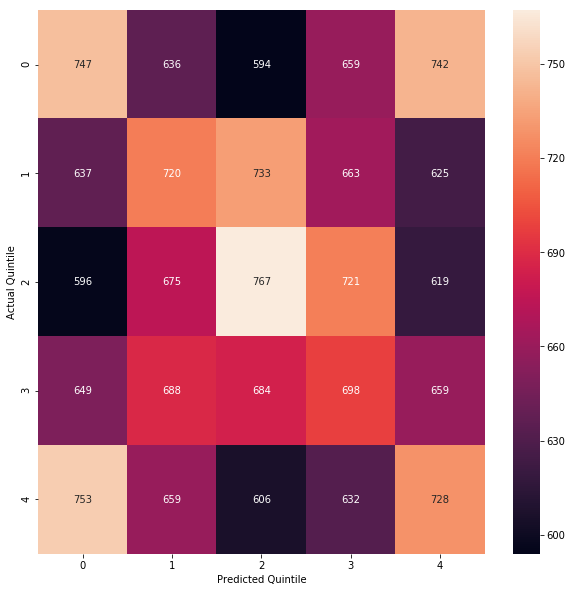

---
01:07:23 Running experiment 6 of 180
(100, 4, 0.01, 0.65)
................................................................................
01:08:26 Still training step 80 of 563
................................................................................
01:09:36 Still training step 160 of 563
................................................................................
01:10:54 Still training step 240 of 563
................................................................................
01:12:20 Still training step 320 of 563
................................................................................
01:13:53 Still training step 400 of 563
................................................................................
01:15:34 Still training step 480 of 563
................................................................................
01:17:25 Still training step 560 of 563
...
Mean return: 0.166%
Monthly Sharpe ratio: 0.059
Avg rank correlation (Kendall's tau): -0

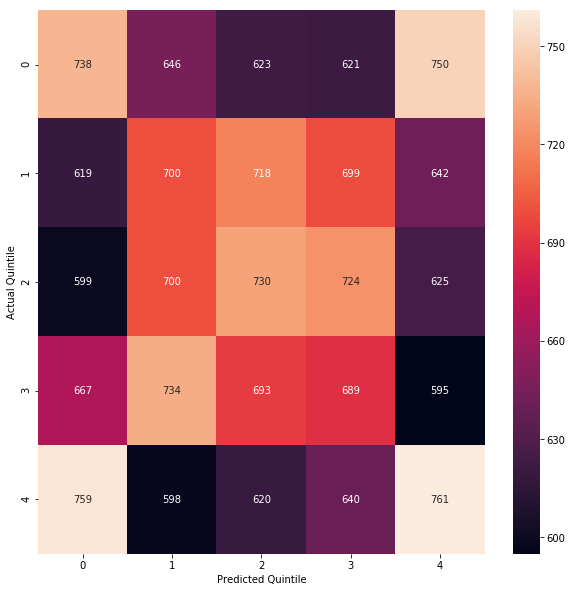

---
01:17:32 Running experiment 7 of 180
(100, 4, 0.01, 0.7)
................................................................................
01:18:35 Still training step 80 of 563
................................................................................
01:19:44 Still training step 160 of 563
................................................................................
01:21:02 Still training step 240 of 563
................................................................................
01:22:28 Still training step 320 of 563
................................................................................
01:24:01 Still training step 400 of 563
................................................................................
01:25:43 Still training step 480 of 563
................................................................................
01:27:34 Still training step 560 of 563
...
Mean return: 0.420%
Monthly Sharpe ratio: 0.112
Avg rank correlation (Kendall's tau): 0.0

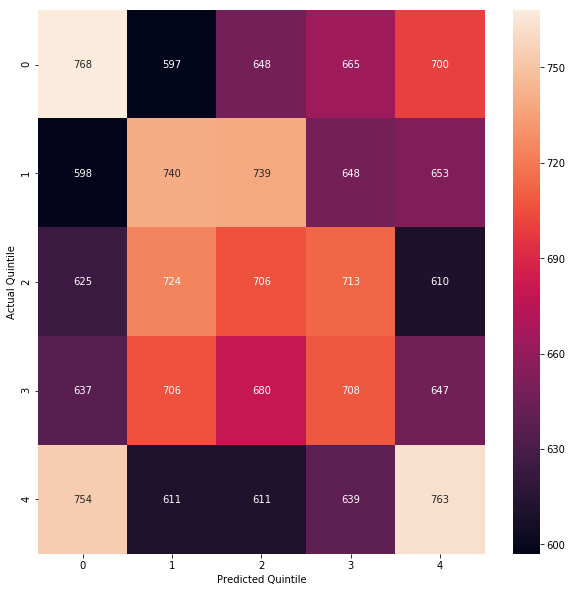

---
01:27:41 Running experiment 8 of 180
(100, 4, 0.01, 0.75)
................................................................................
01:28:44 Still training step 80 of 563
................................................................................
01:29:54 Still training step 160 of 563
................................................................................
01:31:12 Still training step 240 of 563
................................................................................
01:32:37 Still training step 320 of 563
................................................................................
01:34:08 Still training step 400 of 563
................................................................................
01:35:49 Still training step 480 of 563
................................................................................
01:37:38 Still training step 560 of 563
...
Mean return: 0.684%
Monthly Sharpe ratio: 0.160
Avg rank correlation (Kendall's tau): 0.

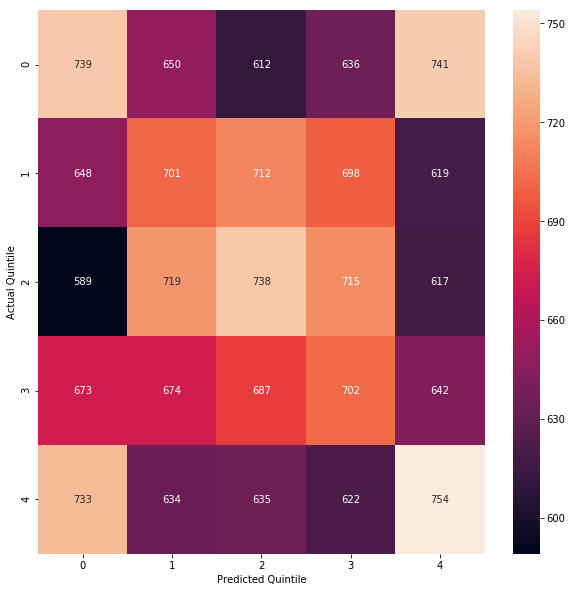

---
01:37:45 Running experiment 9 of 180
(100, 4, 0.003, 0.6)
................................................................................
01:38:47 Still training step 80 of 563
................................................................................
01:39:56 Still training step 160 of 563
................................................................................
01:41:11 Still training step 240 of 563
................................................................................
01:42:31 Still training step 320 of 563
................................................................................
01:43:58 Still training step 400 of 563
................................................................................
01:45:28 Still training step 480 of 563
................................................................................
01:47:05 Still training step 560 of 563
...
Mean return: 0.763%
Monthly Sharpe ratio: 0.181
---
01:47:09 Running experiment 10 of 18

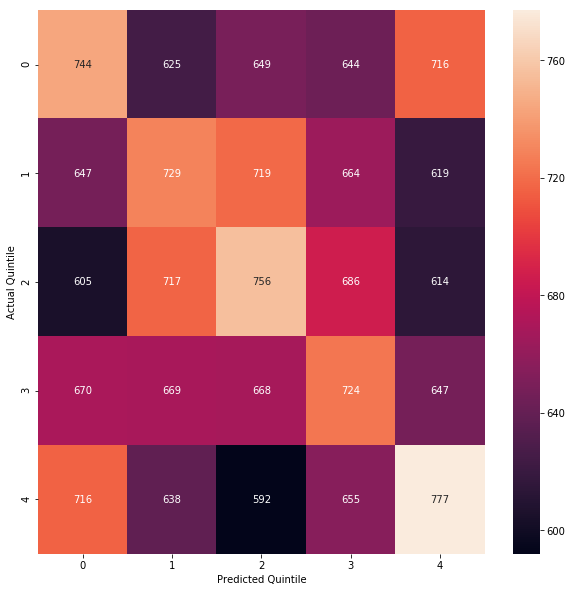

---
02:28:16 Running experiment 14 of 180
(100, 5, 0.03, 0.65)
................................................................................
02:29:23 Still training step 80 of 563
................................................................................
02:30:43 Still training step 160 of 563
................................................................................
02:32:15 Still training step 240 of 563
................................................................................
02:34:01 Still training step 320 of 563
................................................................................
02:36:01 Still training step 400 of 563
................................................................................
02:38:16 Still training step 480 of 563
................................................................................
02:40:48 Still training step 560 of 563
...
Mean return: 0.093%
Monthly Sharpe ratio: 0.043
Avg rank correlation (Kendall's tau): 0

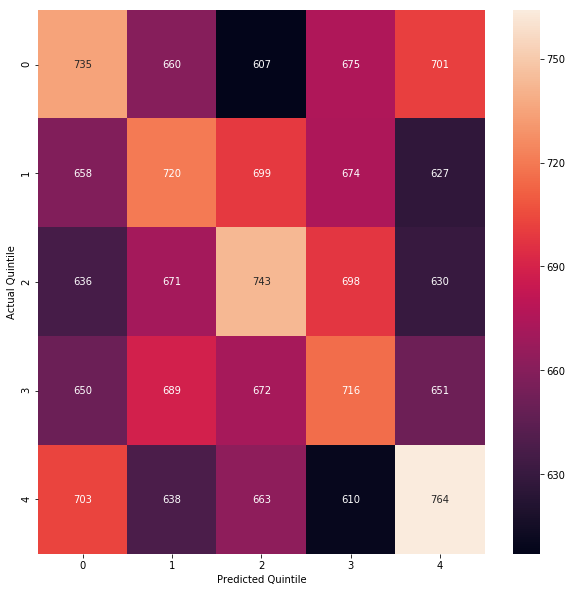

---
02:40:57 Running experiment 15 of 180
(100, 5, 0.03, 0.7)
................................................................................
02:42:05 Still training step 80 of 563
................................................................................
02:43:23 Still training step 160 of 563
................................................................................
02:44:54 Still training step 240 of 563
................................................................................
02:46:39 Still training step 320 of 563
................................................................................
02:48:37 Still training step 400 of 563
................................................................................
02:50:50 Still training step 480 of 563
................................................................................
02:53:19 Still training step 560 of 563
...
Mean return: -0.139%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 

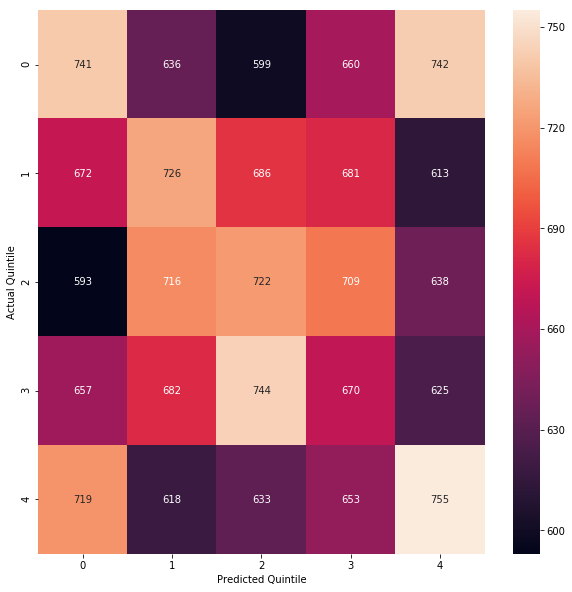

---
02:53:28 Running experiment 16 of 180
(100, 5, 0.03, 0.75)
................................................................................
02:54:35 Still training step 80 of 563
................................................................................
02:55:53 Still training step 160 of 563
................................................................................
02:57:23 Still training step 240 of 563
................................................................................
02:59:07 Still training step 320 of 563
................................................................................
03:01:04 Still training step 400 of 563
................................................................................
03:03:15 Still training step 480 of 563
................................................................................
03:05:43 Still training step 560 of 563
...
Mean return: 0.854%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau): 0

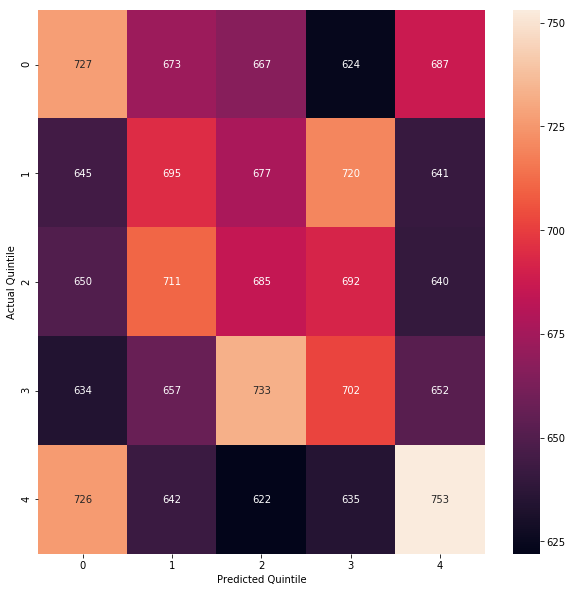

---
03:05:52 Running experiment 17 of 180
(100, 5, 0.01, 0.6)
................................................................................
03:06:55 Still training step 80 of 563
................................................................................
03:08:05 Still training step 160 of 563
................................................................................
03:09:23 Still training step 240 of 563
................................................................................
03:10:49 Still training step 320 of 563
................................................................................
03:12:21 Still training step 400 of 563
................................................................................
03:14:03 Still training step 480 of 563
................................................................................
03:15:54 Still training step 560 of 563
...
Mean return: -0.910%
Monthly Sharpe ratio: -0.174
Avg rank correlation (Kendall's tau): 

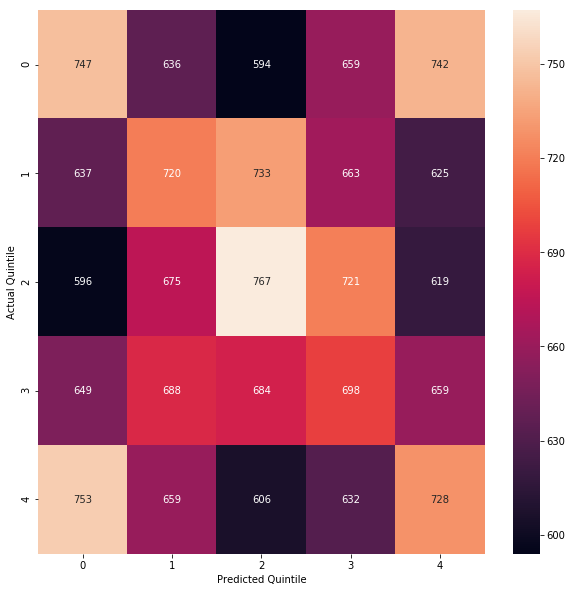

---
03:16:01 Running experiment 18 of 180
(100, 5, 0.01, 0.65)
................................................................................
03:17:04 Still training step 80 of 563
................................................................................
03:18:14 Still training step 160 of 563
................................................................................
03:19:32 Still training step 240 of 563
................................................................................
03:20:56 Still training step 320 of 563
................................................................................
03:22:30 Still training step 400 of 563
................................................................................
03:24:12 Still training step 480 of 563
................................................................................
03:26:04 Still training step 560 of 563
...
Mean return: 0.166%
Monthly Sharpe ratio: 0.059
Avg rank correlation (Kendall's tau): -

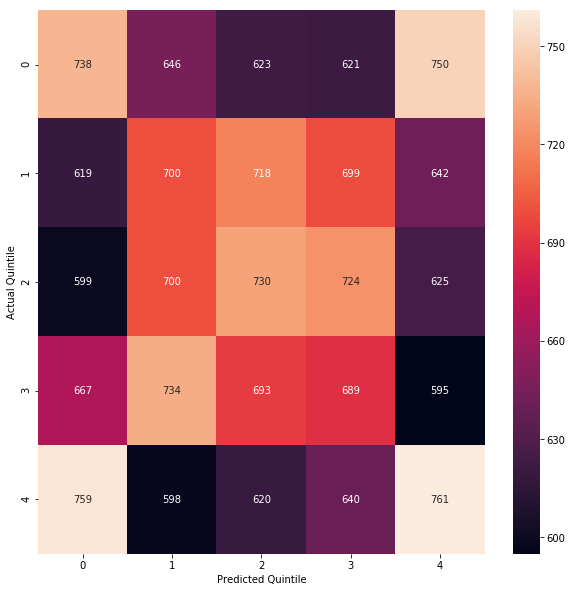

---
03:26:11 Running experiment 19 of 180
(100, 5, 0.01, 0.7)
................................................................................
03:27:14 Still training step 80 of 563
................................................................................
03:28:24 Still training step 160 of 563
................................................................................
03:29:43 Still training step 240 of 563
................................................................................
03:31:08 Still training step 320 of 563
................................................................................
03:32:40 Still training step 400 of 563
................................................................................
03:34:21 Still training step 480 of 563
................................................................................
03:36:11 Still training step 560 of 563
...
Mean return: 0.420%
Monthly Sharpe ratio: 0.112
Avg rank correlation (Kendall's tau): 0.

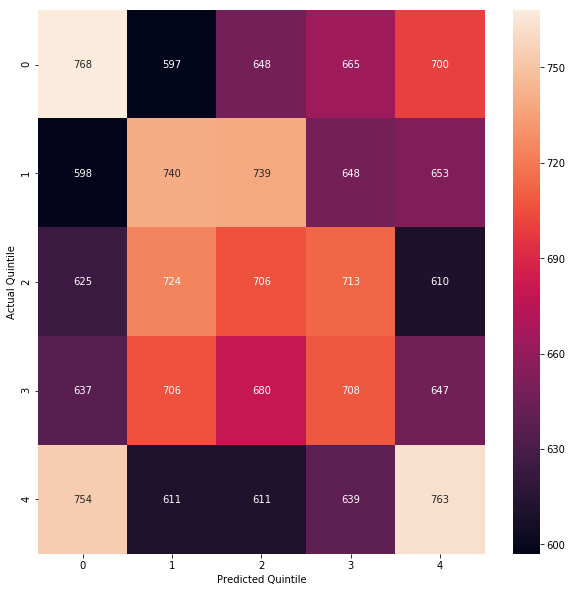

---
03:36:18 Running experiment 20 of 180
(100, 5, 0.01, 0.75)
................................................................................
03:37:21 Still training step 80 of 563
................................................................................
03:38:31 Still training step 160 of 563
................................................................................
03:39:48 Still training step 240 of 563
................................................................................
03:41:14 Still training step 320 of 563
................................................................................
03:42:47 Still training step 400 of 563
................................................................................
03:44:29 Still training step 480 of 563
................................................................................
03:46:18 Still training step 560 of 563
...
Mean return: 0.684%
Monthly Sharpe ratio: 0.160
Avg rank correlation (Kendall's tau): 0

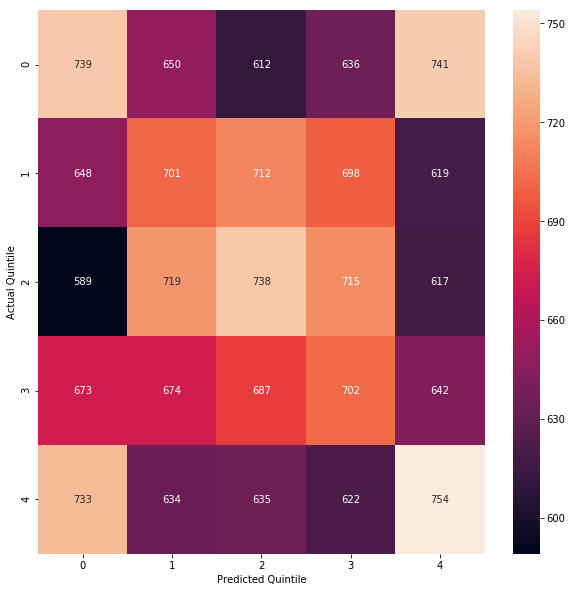

---
03:46:25 Running experiment 21 of 180
(100, 5, 0.003, 0.6)
................................................................................
03:47:27 Still training step 80 of 563
................................................................................
03:48:36 Still training step 160 of 563
................................................................................
03:49:52 Still training step 240 of 563
................................................................................
03:51:13 Still training step 320 of 563
................................................................................
03:52:39 Still training step 400 of 563
................................................................................
03:54:11 Still training step 480 of 563
................................................................................
03:55:49 Still training step 560 of 563
...
Mean return: 0.763%
Monthly Sharpe ratio: 0.181
---
03:55:53 Running experiment 22 of 1

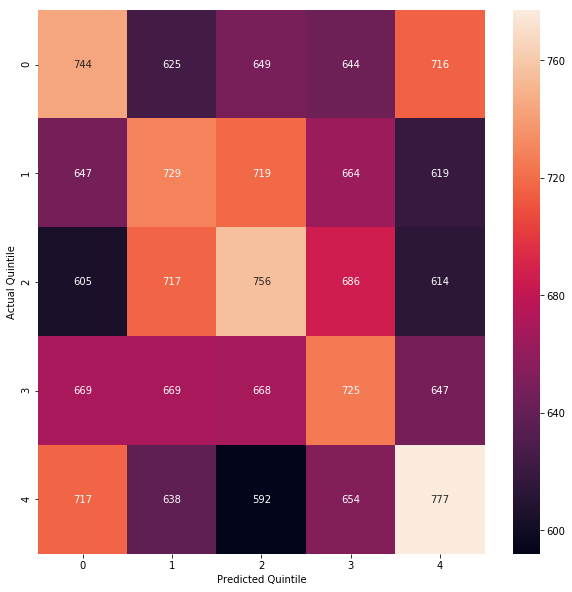

---
04:37:06 Running experiment 26 of 180
(100, 6, 0.03, 0.65)
................................................................................
04:38:14 Still training step 80 of 563
................................................................................
04:39:34 Still training step 160 of 563
................................................................................
04:41:07 Still training step 240 of 563
................................................................................
04:42:54 Still training step 320 of 563
................................................................................
04:44:54 Still training step 400 of 563
................................................................................
04:47:11 Still training step 480 of 563
................................................................................
04:49:42 Still training step 560 of 563
...
Mean return: 0.088%
Monthly Sharpe ratio: 0.042
Avg rank correlation (Kendall's tau): 0

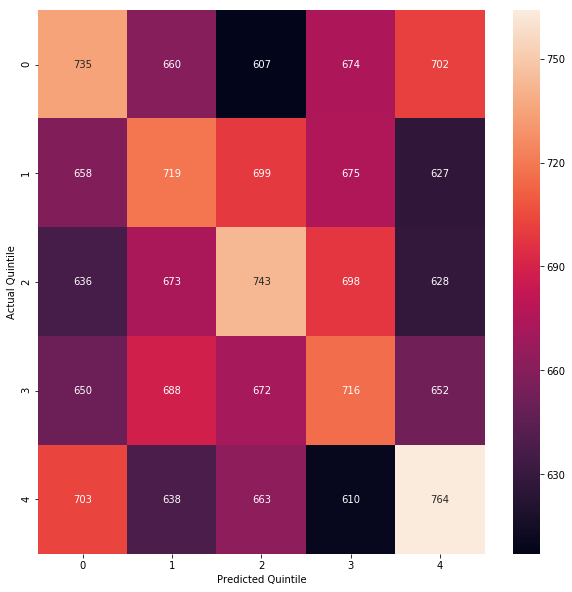

---
04:49:51 Running experiment 27 of 180
(100, 6, 0.03, 0.7)
................................................................................
04:50:58 Still training step 80 of 563
................................................................................
04:52:17 Still training step 160 of 563
................................................................................
04:53:48 Still training step 240 of 563
................................................................................
04:55:33 Still training step 320 of 563
................................................................................
04:57:17 Still training step 400 of 563
................................................................................
04:59:00 Still training step 480 of 563
................................................................................
05:00:57 Still training step 560 of 563
...
Mean return: -0.139%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 

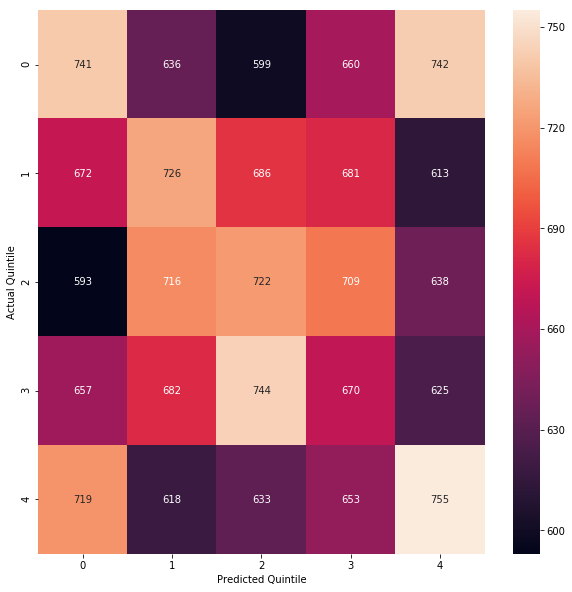

---
05:01:04 Running experiment 28 of 180
(100, 6, 0.03, 0.75)
................................................................................
05:01:44 Still training step 80 of 563
................................................................................
05:02:34 Still training step 160 of 563
................................................................................
05:03:36 Still training step 240 of 563
................................................................................
05:04:51 Still training step 320 of 563
................................................................................
05:06:19 Still training step 400 of 563
................................................................................
05:07:59 Still training step 480 of 563
................................................................................
05:09:53 Still training step 560 of 563
...
Mean return: 0.854%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau): 0

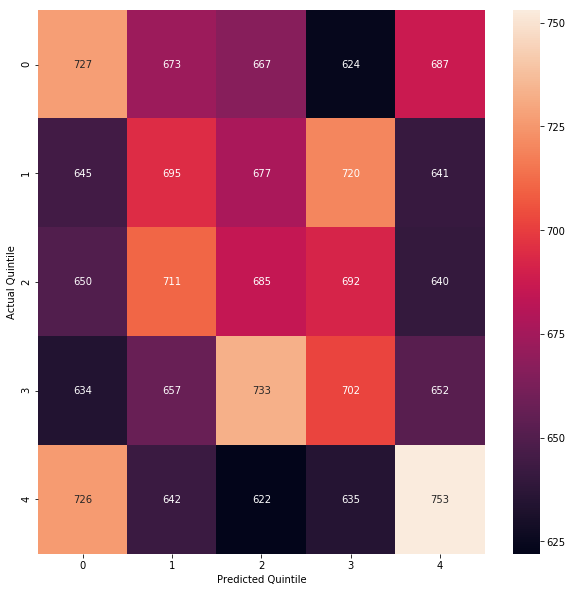

---
05:10:01 Running experiment 29 of 180
(100, 6, 0.01, 0.6)
................................................................................
05:10:37 Still training step 80 of 563
................................................................................
05:11:19 Still training step 160 of 563
................................................................................
05:12:09 Still training step 240 of 563
................................................................................
05:13:06 Still training step 320 of 563
................................................................................
05:14:12 Still training step 400 of 563
................................................................................
05:15:24 Still training step 480 of 563
................................................................................
05:16:45 Still training step 560 of 563
...
Mean return: -0.910%
Monthly Sharpe ratio: -0.174
Avg rank correlation (Kendall's tau): 

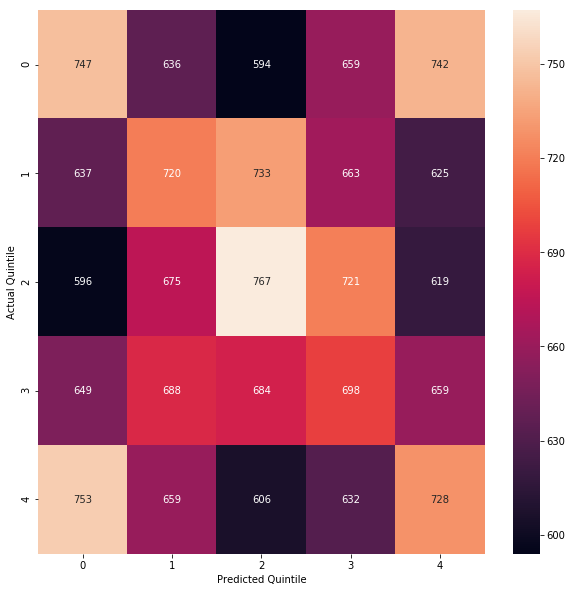

---
05:16:50 Running experiment 30 of 180
(100, 6, 0.01, 0.65)
................................................................................
05:17:26 Still training step 80 of 563
................................................................................
05:18:09 Still training step 160 of 563
................................................................................
05:18:59 Still training step 240 of 563
................................................................................
05:19:56 Still training step 320 of 563
................................................................................
05:21:01 Still training step 400 of 563
................................................................................
05:22:13 Still training step 480 of 563
................................................................................
05:23:34 Still training step 560 of 563
...
Mean return: 0.166%
Monthly Sharpe ratio: 0.059
Avg rank correlation (Kendall's tau): -

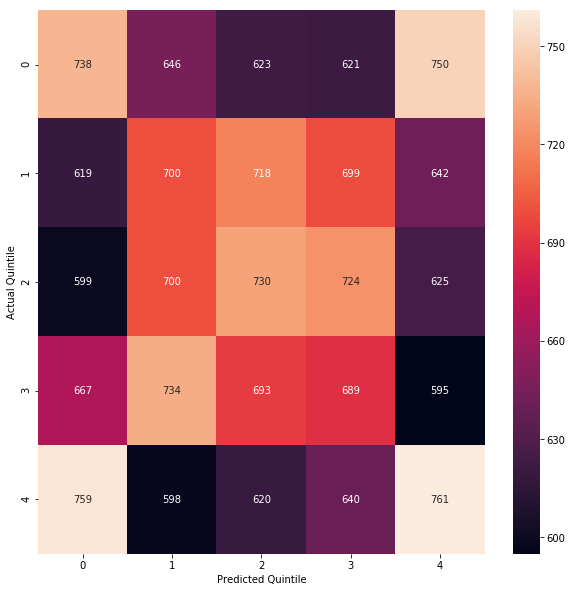

---
05:23:39 Running experiment 31 of 180
(100, 6, 0.01, 0.7)
................................................................................
05:24:15 Still training step 80 of 563
................................................................................
05:24:58 Still training step 160 of 563
................................................................................
05:25:47 Still training step 240 of 563
................................................................................
05:26:45 Still training step 320 of 563
................................................................................
05:27:50 Still training step 400 of 563
................................................................................
05:29:01 Still training step 480 of 563
................................................................................
05:30:21 Still training step 560 of 563
...
Mean return: 0.420%
Monthly Sharpe ratio: 0.112
Avg rank correlation (Kendall's tau): 0.

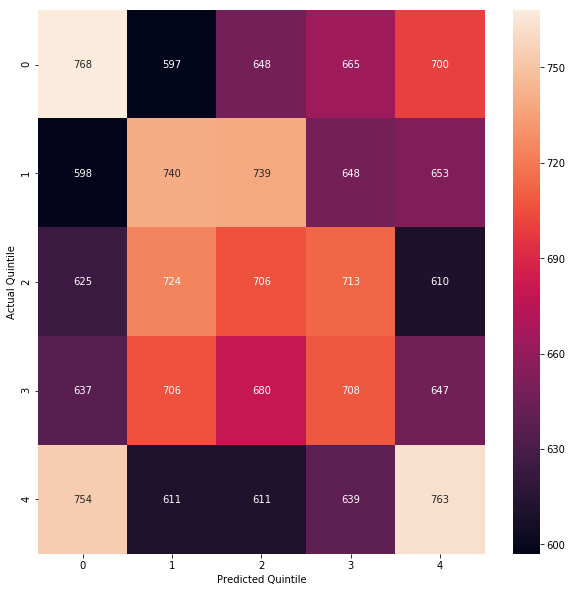

---
05:30:27 Running experiment 32 of 180
(100, 6, 0.01, 0.75)
................................................................................
05:31:03 Still training step 80 of 563
................................................................................
05:31:46 Still training step 160 of 563
................................................................................
05:32:36 Still training step 240 of 563
................................................................................
05:33:33 Still training step 320 of 563
................................................................................
05:34:37 Still training step 400 of 563
................................................................................
05:35:49 Still training step 480 of 563
................................................................................
05:37:08 Still training step 560 of 563
...
Mean return: 0.684%
Monthly Sharpe ratio: 0.160
Avg rank correlation (Kendall's tau): 0

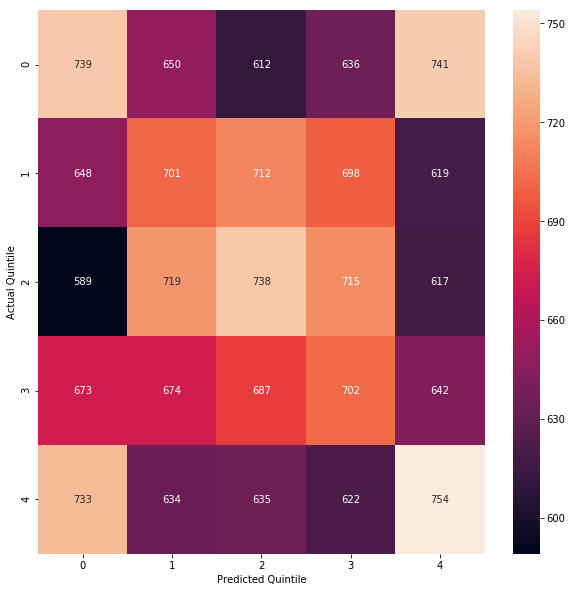

---
05:37:14 Running experiment 33 of 180
(100, 6, 0.003, 0.6)
................................................................................
05:37:49 Still training step 80 of 563
................................................................................
05:38:30 Still training step 160 of 563
................................................................................
05:39:17 Still training step 240 of 563
................................................................................
05:40:10 Still training step 320 of 563
................................................................................
05:41:09 Still training step 400 of 563
................................................................................
05:42:12 Still training step 480 of 563
................................................................................
05:43:21 Still training step 560 of 563
...
Mean return: 0.763%
Monthly Sharpe ratio: 0.181
---
05:43:24 Running experiment 34 of 1

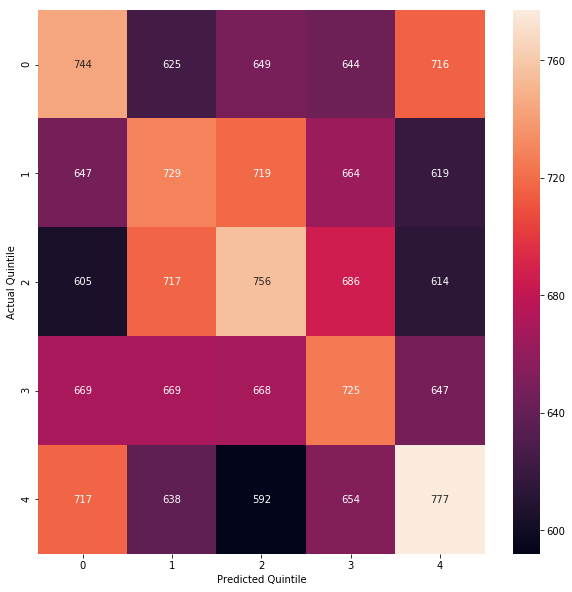

---
06:11:13 Running experiment 38 of 180
(100, 7, 0.03, 0.65)
................................................................................
06:11:53 Still training step 80 of 563
................................................................................
06:12:43 Still training step 160 of 563
................................................................................
06:13:47 Still training step 240 of 563
................................................................................
06:15:04 Still training step 320 of 563
................................................................................
06:16:35 Still training step 400 of 563
................................................................................
06:18:19 Still training step 480 of 563
................................................................................
06:20:19 Still training step 560 of 563
...
Mean return: 0.088%
Monthly Sharpe ratio: 0.042
Avg rank correlation (Kendall's tau): 0

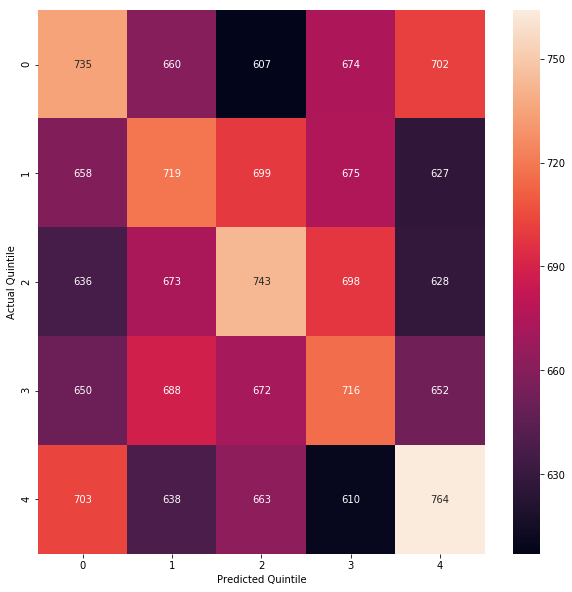

---
06:20:27 Running experiment 39 of 180
(100, 7, 0.03, 0.7)
................................................................................
06:21:06 Still training step 80 of 563
................................................................................
06:21:57 Still training step 160 of 563
................................................................................
06:23:00 Still training step 240 of 563
................................................................................
06:24:16 Still training step 320 of 563
................................................................................
06:25:46 Still training step 400 of 563
................................................................................
06:27:27 Still training step 480 of 563
................................................................................
06:29:25 Still training step 560 of 563
...
Mean return: -0.139%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 

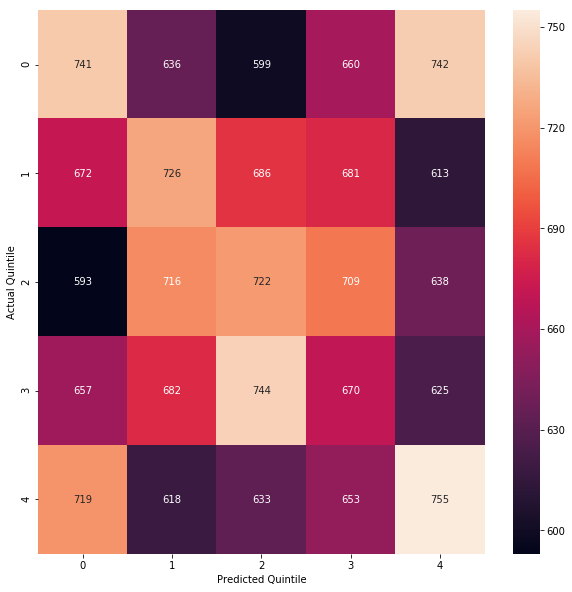

---
06:29:32 Running experiment 40 of 180
(100, 7, 0.03, 0.75)
................................................................................
06:30:12 Still training step 80 of 563
................................................................................
06:31:02 Still training step 160 of 563
................................................................................
06:32:04 Still training step 240 of 563
................................................................................
06:33:19 Still training step 320 of 563
................................................................................
06:34:47 Still training step 400 of 563
................................................................................
06:36:27 Still training step 480 of 563
................................................................................
06:38:22 Still training step 560 of 563
...
Mean return: 0.854%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau): 0

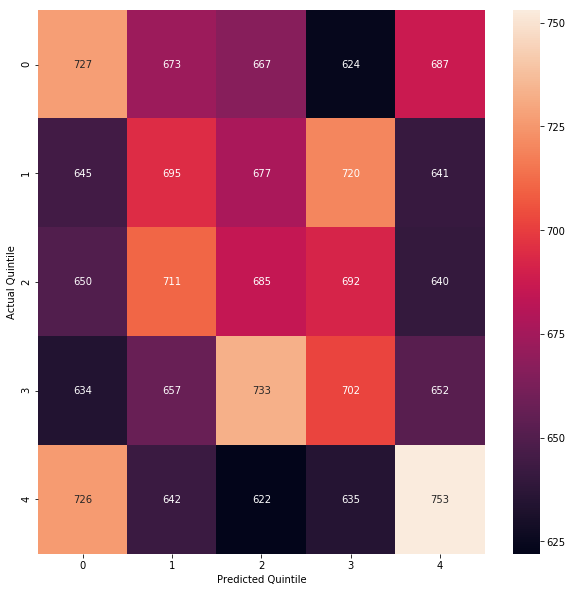

---
06:38:29 Running experiment 41 of 180
(100, 7, 0.01, 0.6)
................................................................................
06:39:05 Still training step 80 of 563
................................................................................
06:39:48 Still training step 160 of 563
................................................................................
06:40:38 Still training step 240 of 563
................................................................................
06:41:35 Still training step 320 of 563
................................................................................
06:42:40 Still training step 400 of 563
................................................................................
06:43:53 Still training step 480 of 563
................................................................................
06:45:14 Still training step 560 of 563
...
Mean return: -0.910%
Monthly Sharpe ratio: -0.174
Avg rank correlation (Kendall's tau): 

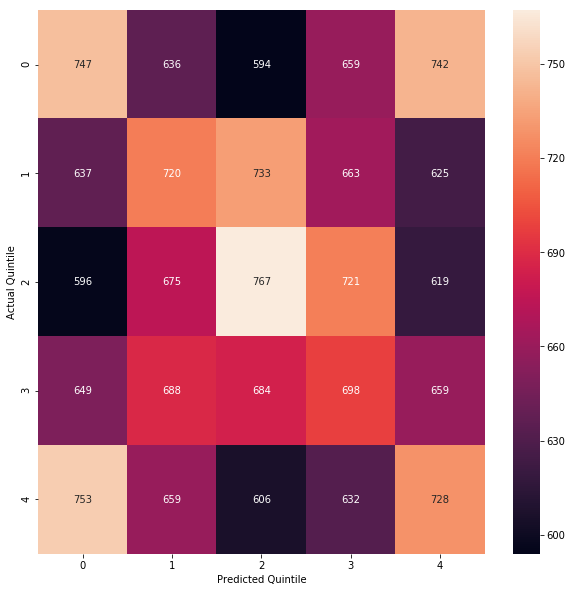

---
06:45:19 Running experiment 42 of 180
(100, 7, 0.01, 0.65)
................................................................................
06:45:56 Still training step 80 of 563
................................................................................
06:46:38 Still training step 160 of 563
................................................................................
06:47:28 Still training step 240 of 563
................................................................................
06:48:26 Still training step 320 of 563
................................................................................
06:49:31 Still training step 400 of 563
................................................................................
06:50:43 Still training step 480 of 563
................................................................................
06:52:03 Still training step 560 of 563
...
Mean return: 0.166%
Monthly Sharpe ratio: 0.059
Avg rank correlation (Kendall's tau): -

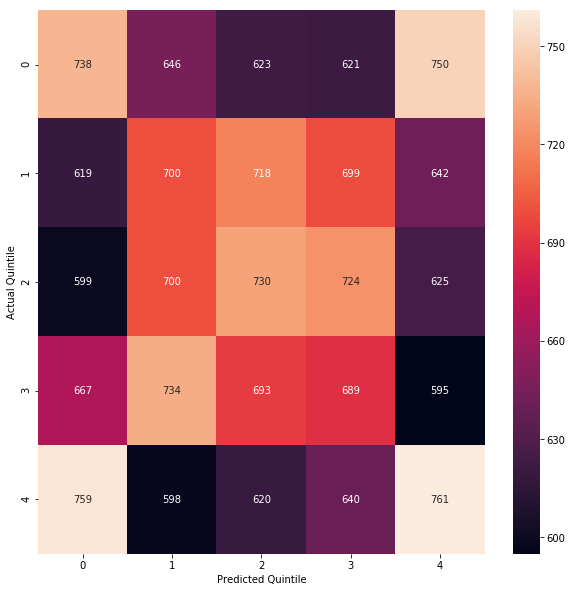

---
06:52:09 Running experiment 43 of 180
(100, 7, 0.01, 0.7)
................................................................................
06:52:45 Still training step 80 of 563
................................................................................
06:53:28 Still training step 160 of 563
................................................................................
06:54:17 Still training step 240 of 563
................................................................................
06:55:15 Still training step 320 of 563
................................................................................
06:56:20 Still training step 400 of 563
................................................................................
06:57:31 Still training step 480 of 563
................................................................................
06:58:51 Still training step 560 of 563
...
Mean return: 0.420%
Monthly Sharpe ratio: 0.112
Avg rank correlation (Kendall's tau): 0.

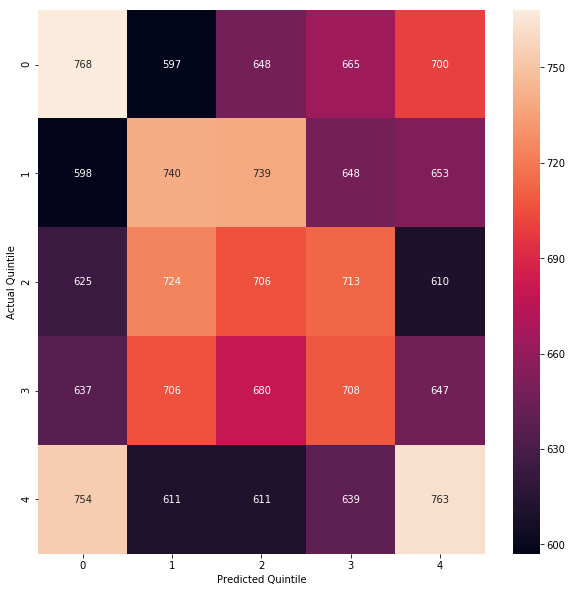

---
06:58:57 Running experiment 44 of 180
(100, 7, 0.01, 0.75)
................................................................................
06:59:33 Still training step 80 of 563
................................................................................
07:00:16 Still training step 160 of 563
................................................................................
07:01:06 Still training step 240 of 563
................................................................................
07:02:03 Still training step 320 of 563
................................................................................
07:03:07 Still training step 400 of 563
................................................................................
07:04:18 Still training step 480 of 563
................................................................................
07:05:38 Still training step 560 of 563
...
Mean return: 0.684%
Monthly Sharpe ratio: 0.160
Avg rank correlation (Kendall's tau): 0

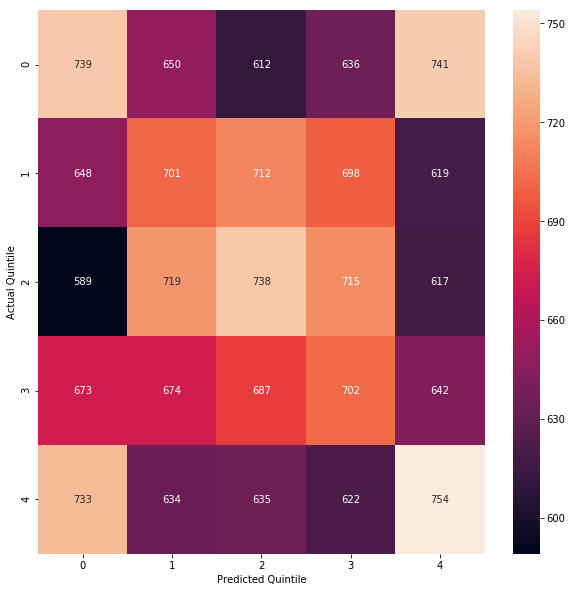

---
07:05:43 Running experiment 45 of 180
(100, 7, 0.003, 0.6)
................................................................................
07:06:18 Still training step 80 of 563
................................................................................
07:06:59 Still training step 160 of 563
................................................................................
07:07:46 Still training step 240 of 563
................................................................................
07:08:39 Still training step 320 of 563
................................................................................
07:09:38 Still training step 400 of 563
................................................................................
07:10:41 Still training step 480 of 563
................................................................................
07:11:49 Still training step 560 of 563
...
Mean return: 0.763%
Monthly Sharpe ratio: 0.181
---
07:11:52 Running experiment 46 of 1

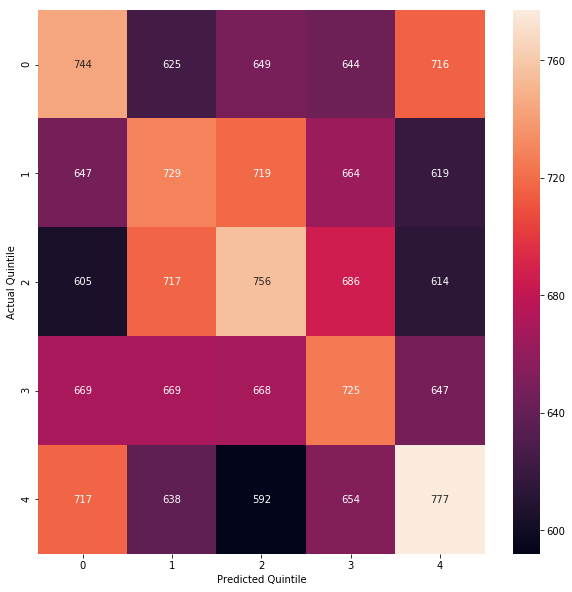

---
07:39:43 Running experiment 50 of 180
(100, 8, 0.03, 0.65)
................................................................................
07:40:23 Still training step 80 of 563
................................................................................
07:41:14 Still training step 160 of 563
................................................................................
07:42:17 Still training step 240 of 563
................................................................................
07:43:34 Still training step 320 of 563
................................................................................
07:45:05 Still training step 400 of 563
................................................................................
07:46:49 Still training step 480 of 563
................................................................................
07:48:49 Still training step 560 of 563
...
Mean return: 0.088%
Monthly Sharpe ratio: 0.042
Avg rank correlation (Kendall's tau): 0

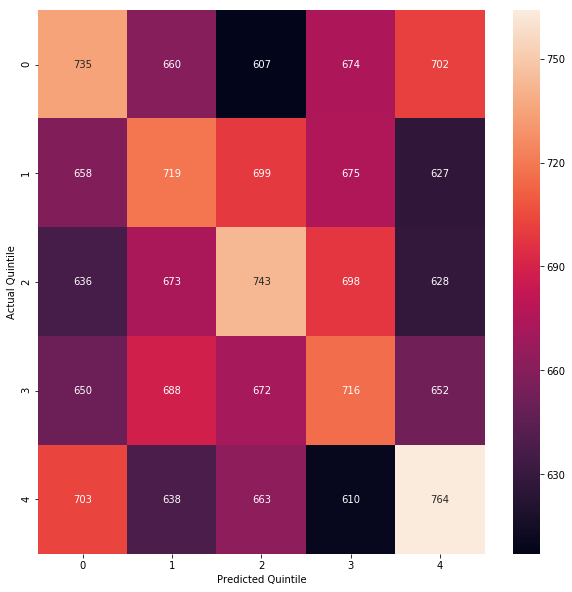

---
07:48:57 Running experiment 51 of 180
(100, 8, 0.03, 0.7)
................................................................................
07:49:37 Still training step 80 of 563
................................................................................
07:50:27 Still training step 160 of 563
................................................................................
07:51:30 Still training step 240 of 563
................................................................................
07:52:46 Still training step 320 of 563
................................................................................
07:54:15 Still training step 400 of 563
................................................................................
07:55:57 Still training step 480 of 563
................................................................................
07:57:54 Still training step 560 of 563
...
Mean return: -0.139%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 

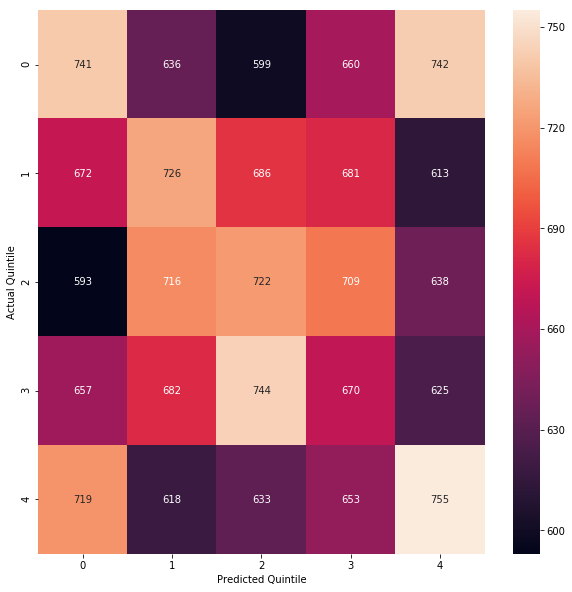

---
07:58:02 Running experiment 52 of 180
(100, 8, 0.03, 0.75)
................................................................................
07:58:41 Still training step 80 of 563
................................................................................
07:59:32 Still training step 160 of 563
................................................................................
08:00:34 Still training step 240 of 563
................................................................................
08:01:49 Still training step 320 of 563
................................................................................
08:03:17 Still training step 400 of 563
................................................................................
08:04:57 Still training step 480 of 563
................................................................................
08:06:51 Still training step 560 of 563
...
Mean return: 0.854%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau): 0

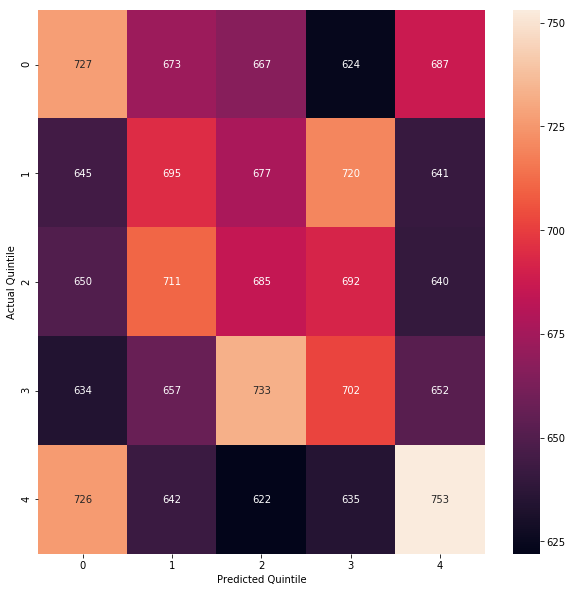

---
08:06:59 Running experiment 53 of 180
(100, 8, 0.01, 0.6)
................................................................................
08:07:35 Still training step 80 of 563
................................................................................
08:08:17 Still training step 160 of 563
................................................................................
08:09:07 Still training step 240 of 563
................................................................................
08:10:05 Still training step 320 of 563
................................................................................
08:11:10 Still training step 400 of 563
................................................................................
08:12:23 Still training step 480 of 563
................................................................................
08:13:44 Still training step 560 of 563
...
Mean return: -0.910%
Monthly Sharpe ratio: -0.174
Avg rank correlation (Kendall's tau): 

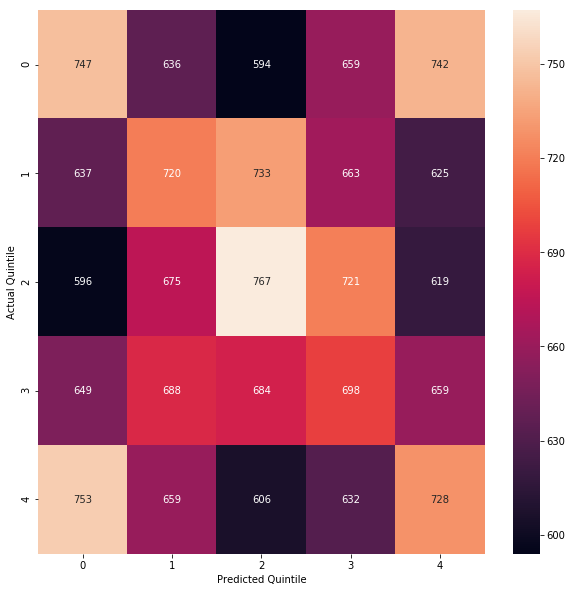

---
08:13:49 Running experiment 54 of 180
(100, 8, 0.01, 0.65)
................................................................................
08:14:25 Still training step 80 of 563
................................................................................
08:15:08 Still training step 160 of 563
................................................................................
08:15:58 Still training step 240 of 563
................................................................................
08:16:55 Still training step 320 of 563
................................................................................
08:18:00 Still training step 400 of 563
................................................................................
08:19:12 Still training step 480 of 563
................................................................................
08:20:32 Still training step 560 of 563
...
Mean return: 0.166%
Monthly Sharpe ratio: 0.059
Avg rank correlation (Kendall's tau): -

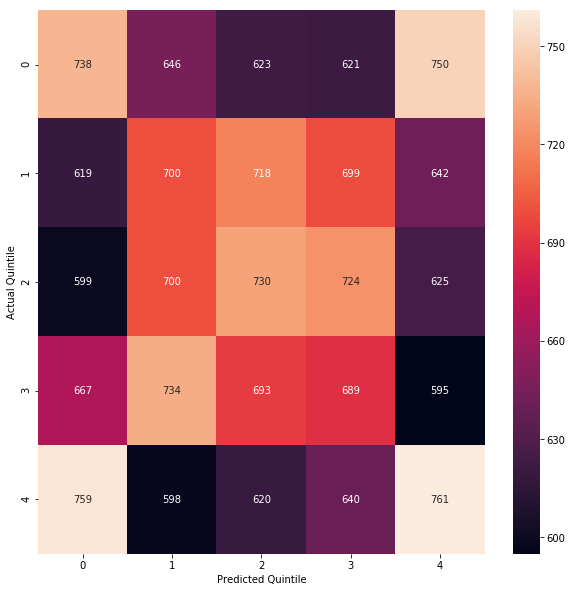

---
08:20:38 Running experiment 55 of 180
(100, 8, 0.01, 0.7)
................................................................................
08:21:14 Still training step 80 of 563
................................................................................
08:21:57 Still training step 160 of 563
................................................................................
08:22:47 Still training step 240 of 563
................................................................................
08:23:44 Still training step 320 of 563
................................................................................
08:24:48 Still training step 400 of 563
................................................................................
08:26:00 Still training step 480 of 563
................................................................................
08:27:20 Still training step 560 of 563
...
Mean return: 0.420%
Monthly Sharpe ratio: 0.112
Avg rank correlation (Kendall's tau): 0.

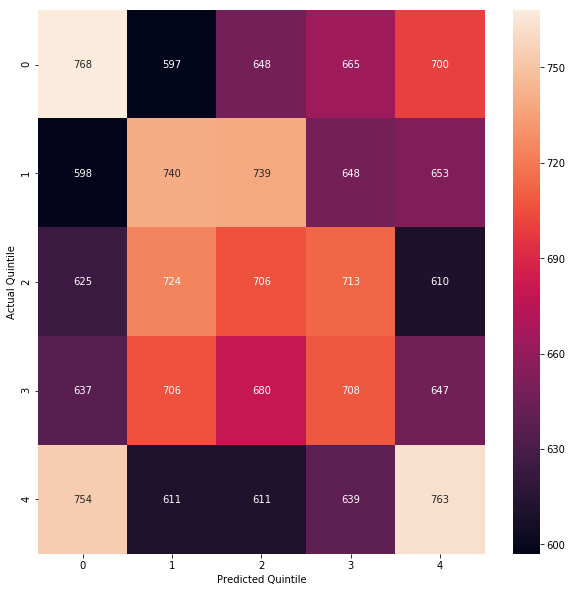

---
08:27:25 Running experiment 56 of 180
(100, 8, 0.01, 0.75)
................................................................................
08:28:01 Still training step 80 of 563
................................................................................
08:28:44 Still training step 160 of 563
................................................................................
08:29:34 Still training step 240 of 563
................................................................................
08:30:31 Still training step 320 of 563
................................................................................
08:31:36 Still training step 400 of 563
................................................................................
08:32:47 Still training step 480 of 563
................................................................................
08:34:06 Still training step 560 of 563
...
Mean return: 0.684%
Monthly Sharpe ratio: 0.160
Avg rank correlation (Kendall's tau): 0

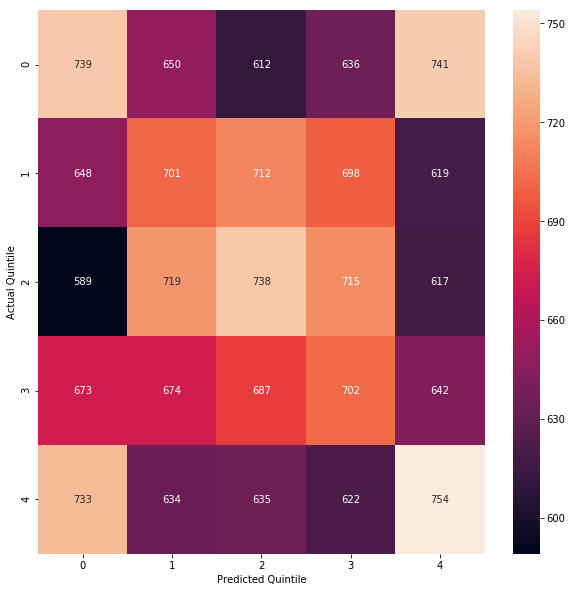

---
08:34:12 Running experiment 57 of 180
(100, 8, 0.003, 0.6)
................................................................................
08:34:47 Still training step 80 of 563
................................................................................
08:35:28 Still training step 160 of 563
................................................................................
08:36:14 Still training step 240 of 563
................................................................................
08:37:07 Still training step 320 of 563
................................................................................
08:38:05 Still training step 400 of 563
................................................................................
08:39:08 Still training step 480 of 563
................................................................................
08:40:16 Still training step 560 of 563
...
Mean return: 0.763%
Monthly Sharpe ratio: 0.181
---
08:40:19 Running experiment 58 of 1

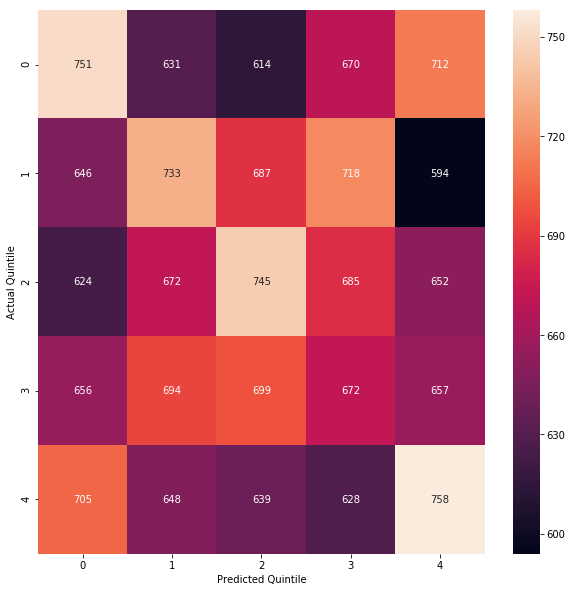

---
09:23:48 Running experiment 62 of 180
(300, 4, 0.03, 0.65)
................................................................................
09:25:40 Still training step 80 of 563
................................................................................
09:28:01 Still training step 160 of 563
................................................................................
09:30:53 Still training step 240 of 563
................................................................................
09:34:20 Still training step 320 of 563
................................................................................
09:38:17 Still training step 400 of 563
................................................................................
09:42:45 Still training step 480 of 563
................................................................................
09:47:52 Still training step 560 of 563
...
Mean return: 0.652%
Monthly Sharpe ratio: 0.163
Avg rank correlation (Kendall's tau): 0

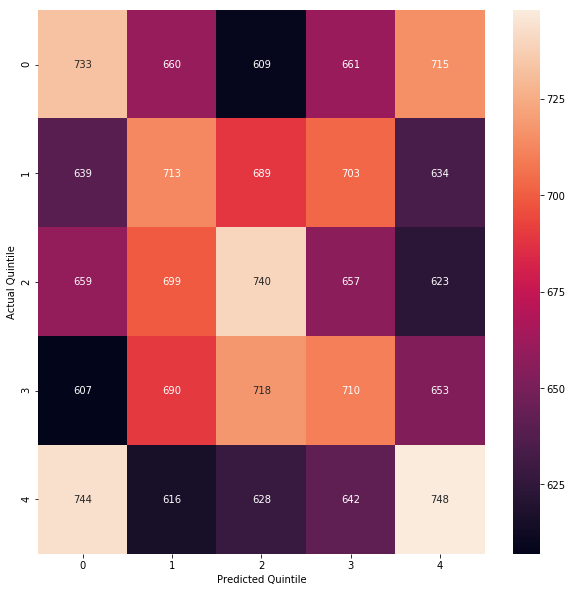

---
09:48:10 Running experiment 63 of 180
(300, 4, 0.03, 0.7)
................................................................................
09:50:03 Still training step 80 of 563
................................................................................
09:52:24 Still training step 160 of 563
................................................................................
09:55:15 Still training step 240 of 563
................................................................................
09:58:39 Still training step 320 of 563
................................................................................
10:02:32 Still training step 400 of 563
................................................................................
10:06:55 Still training step 480 of 563
................................................................................
10:11:55 Still training step 560 of 563
...
Mean return: 0.930%
Monthly Sharpe ratio: 0.229
Avg rank correlation (Kendall's tau): 0.

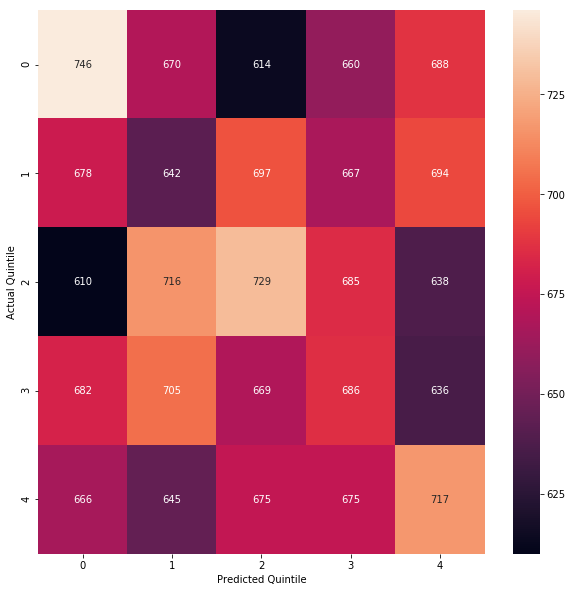

---
10:12:12 Running experiment 64 of 180
(300, 4, 0.03, 0.75)
................................................................................
10:14:05 Still training step 80 of 563
................................................................................
10:16:25 Still training step 160 of 563
................................................................................
10:19:14 Still training step 240 of 563
................................................................................
10:22:35 Still training step 320 of 563
................................................................................
10:26:27 Still training step 400 of 563
................................................................................
10:30:59 Still training step 480 of 563
................................................................................
10:36:04 Still training step 560 of 563
...
Mean return: 0.674%
Monthly Sharpe ratio: 0.176
Avg rank correlation (Kendall's tau): 0

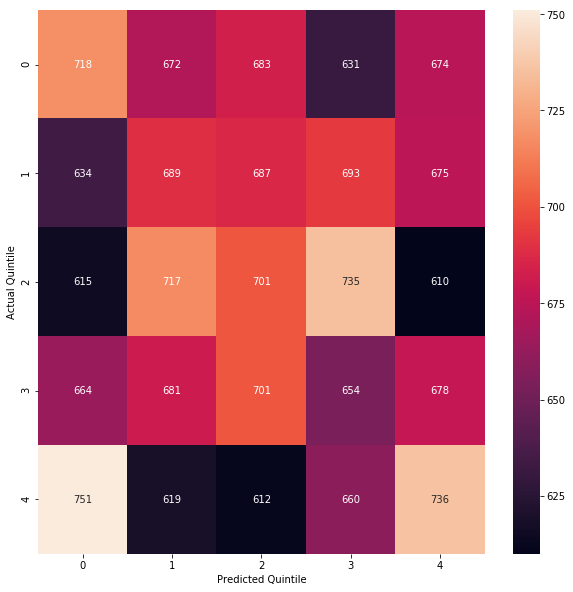

---
10:36:21 Running experiment 65 of 180
(300, 4, 0.01, 0.6)
................................................................................
10:38:14 Still training step 80 of 563
................................................................................
10:40:26 Still training step 160 of 563
................................................................................
10:42:59 Still training step 240 of 563
................................................................................
10:45:52 Still training step 320 of 563
................................................................................
10:49:03 Still training step 400 of 563
................................................................................
10:52:36 Still training step 480 of 563
................................................................................
10:56:41 Still training step 560 of 563
...
Mean return: 1.414%
Monthly Sharpe ratio: 0.303
Avg rank correlation (Kendall's tau): 0.

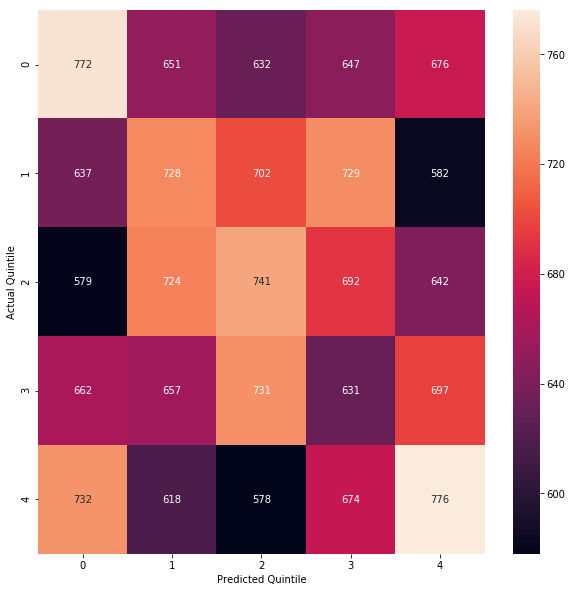

---
10:56:57 Running experiment 66 of 180
(300, 4, 0.01, 0.65)
................................................................................
10:59:02 Still training step 80 of 563
................................................................................
11:01:27 Still training step 160 of 563
................................................................................
11:04:18 Still training step 240 of 563
................................................................................
11:07:37 Still training step 320 of 563
................................................................................
11:11:09 Still training step 400 of 563
................................................................................
11:14:59 Still training step 480 of 563
................................................................................
11:19:06 Still training step 560 of 563
...
Mean return: 0.752%
Monthly Sharpe ratio: 0.184
Avg rank correlation (Kendall's tau): 0

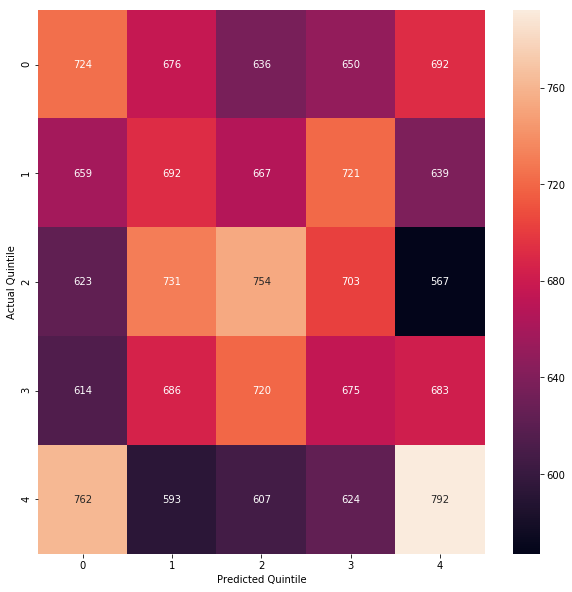

---
11:19:19 Running experiment 67 of 180
(300, 4, 0.01, 0.7)
................................................................................
11:21:03 Still training step 80 of 563
................................................................................
11:23:07 Still training step 160 of 563
................................................................................
11:25:31 Still training step 240 of 563
................................................................................
11:28:15 Still training step 320 of 563
................................................................................
11:31:21 Still training step 400 of 563
................................................................................
11:34:43 Still training step 480 of 563
................................................................................
11:38:26 Still training step 560 of 563
...
Mean return: 0.889%
Monthly Sharpe ratio: 0.221
Avg rank correlation (Kendall's tau): 0.

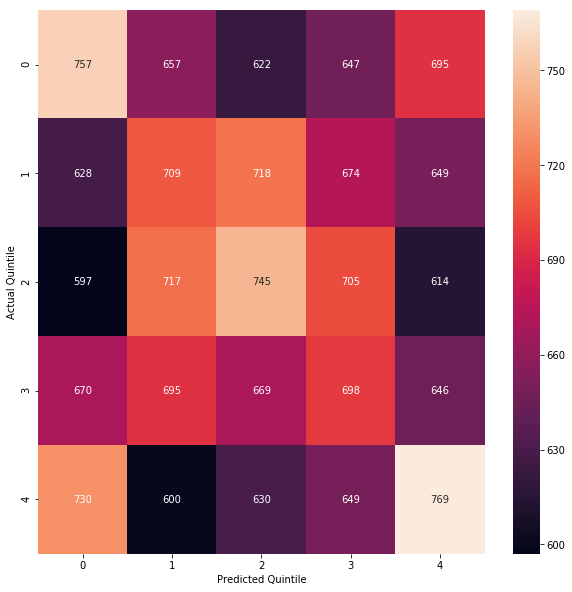

---
11:38:39 Running experiment 68 of 180
(300, 4, 0.01, 0.75)
................................................................................
11:40:24 Still training step 80 of 563
................................................................................
11:42:27 Still training step 160 of 563
................................................................................
11:44:51 Still training step 240 of 563
................................................................................
11:47:36 Still training step 320 of 563
................................................................................
11:50:41 Still training step 400 of 563
................................................................................
11:54:03 Still training step 480 of 563
................................................................................
11:57:46 Still training step 560 of 563
...
Mean return: 0.097%
Monthly Sharpe ratio: 0.044
Avg rank correlation (Kendall's tau): 0

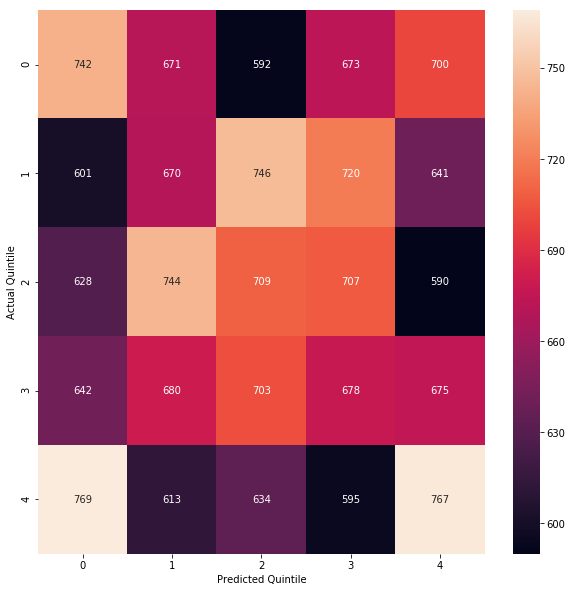

---
11:57:59 Running experiment 69 of 180
(300, 4, 0.003, 0.6)
................................................................................
11:59:41 Still training step 80 of 563
................................................................................
12:01:41 Still training step 160 of 563
................................................................................
12:03:57 Still training step 240 of 563
................................................................................
12:06:31 Still training step 320 of 563
................................................................................
12:09:21 Still training step 400 of 563
................................................................................
12:12:24 Still training step 480 of 563
................................................................................
12:15:44 Still training step 560 of 563
...
Mean return: 1.455%
Monthly Sharpe ratio: 0.318
Avg rank correlation (Kendall's tau): 0

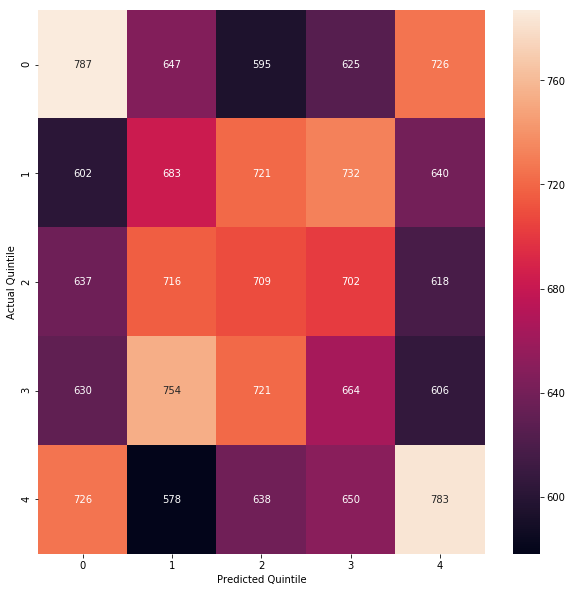

---
12:15:56 Running experiment 70 of 180
(300, 4, 0.003, 0.65)
................................................................................
12:17:38 Still training step 80 of 563
................................................................................
12:19:37 Still training step 160 of 563
................................................................................
12:21:54 Still training step 240 of 563
................................................................................
12:24:28 Still training step 320 of 563
................................................................................
12:27:18 Still training step 400 of 563
................................................................................
12:30:21 Still training step 480 of 563
................................................................................
12:33:41 Still training step 560 of 563
...
Mean return: 1.249%
Monthly Sharpe ratio: 0.275
Avg rank correlation (Kendall's tau): 

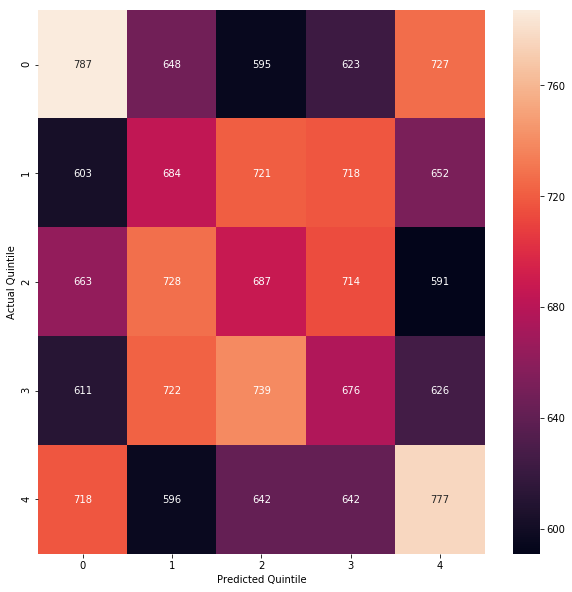

---
12:33:53 Running experiment 71 of 180
(300, 4, 0.003, 0.7)
................................................................................
12:35:35 Still training step 80 of 563
................................................................................
12:37:35 Still training step 160 of 563
................................................................................
12:39:52 Still training step 240 of 563
................................................................................
12:42:27 Still training step 320 of 563
................................................................................
12:45:18 Still training step 400 of 563
................................................................................
12:48:22 Still training step 480 of 563
................................................................................
12:51:42 Still training step 560 of 563
...
Mean return: 1.350%
Monthly Sharpe ratio: 0.293
Avg rank correlation (Kendall's tau): 0

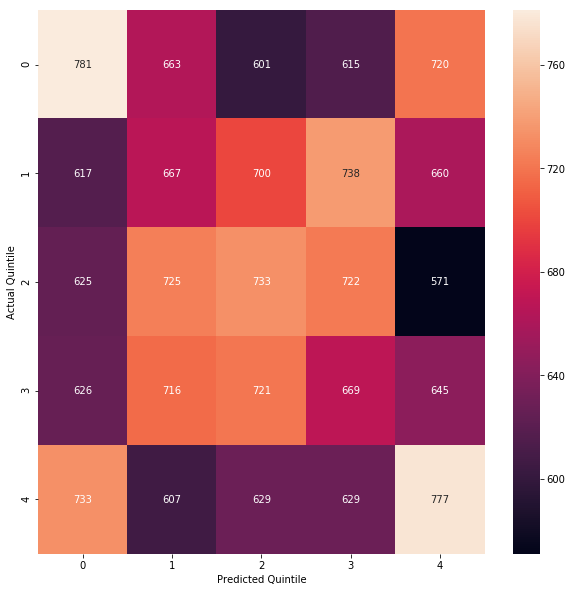

---
12:51:53 Running experiment 72 of 180
(300, 4, 0.003, 0.75)
................................................................................
12:53:35 Still training step 80 of 563
................................................................................
12:55:33 Still training step 160 of 563
................................................................................
12:57:49 Still training step 240 of 563
................................................................................
13:00:22 Still training step 320 of 563
................................................................................
13:03:11 Still training step 400 of 563
................................................................................
13:06:13 Still training step 480 of 563
................................................................................
13:09:32 Still training step 560 of 563
...
Mean return: 1.488%
Monthly Sharpe ratio: 0.317
Avg rank correlation (Kendall's tau): 

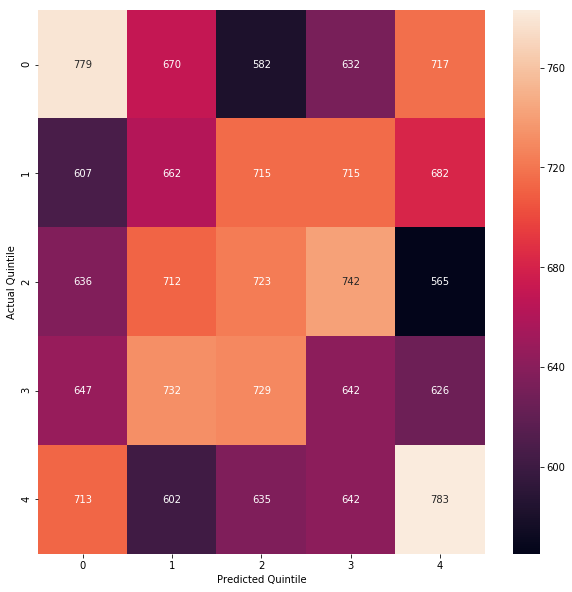

---
13:09:44 Running experiment 73 of 180
(300, 5, 0.03, 0.6)
................................................................................
13:11:37 Still training step 80 of 563
................................................................................
13:14:01 Still training step 160 of 563
................................................................................
13:16:56 Still training step 240 of 563
................................................................................
13:20:27 Still training step 320 of 563
................................................................................
13:24:33 Still training step 400 of 563
................................................................................
13:29:15 Still training step 480 of 563
................................................................................
13:35:18 Still training step 560 of 563
...
Mean return: 0.518%
Monthly Sharpe ratio: 0.132
Avg rank correlation (Kendall's tau): 0.

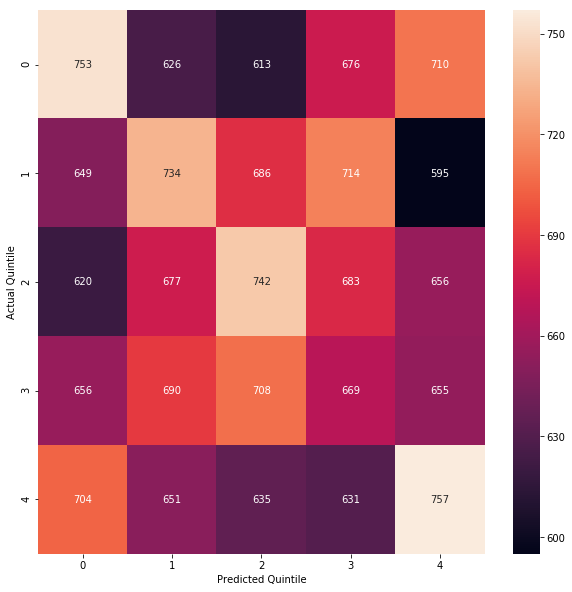

---
13:35:39 Running experiment 74 of 180
(300, 5, 0.03, 0.65)
................................................................................
13:38:00 Still training step 80 of 563
................................................................................
13:40:51 Still training step 160 of 563
................................................................................
13:44:07 Still training step 240 of 563
................................................................................
13:48:10 Still training step 320 of 563
................................................................................
13:53:00 Still training step 400 of 563
................................................................................
13:58:24 Still training step 480 of 563
................................................................................
14:04:52 Still training step 560 of 563
...
Mean return: 0.517%
Monthly Sharpe ratio: 0.134
Avg rank correlation (Kendall's tau): 0

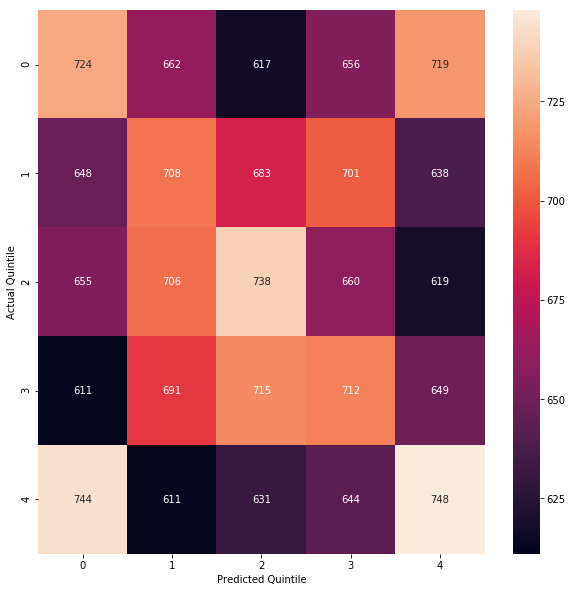

---
14:05:13 Running experiment 75 of 180
(300, 5, 0.03, 0.7)
................................................................................
14:07:30 Still training step 80 of 563
................................................................................
14:10:26 Still training step 160 of 563
................................................................................
14:13:49 Still training step 240 of 563
................................................................................
14:17:39 Still training step 320 of 563
................................................................................
14:22:22 Still training step 400 of 563
................................................................................
14:27:53 Still training step 480 of 563
................................................................................
14:34:04 Still training step 560 of 563
...
Mean return: 0.879%
Monthly Sharpe ratio: 0.219
Avg rank correlation (Kendall's tau): 0.

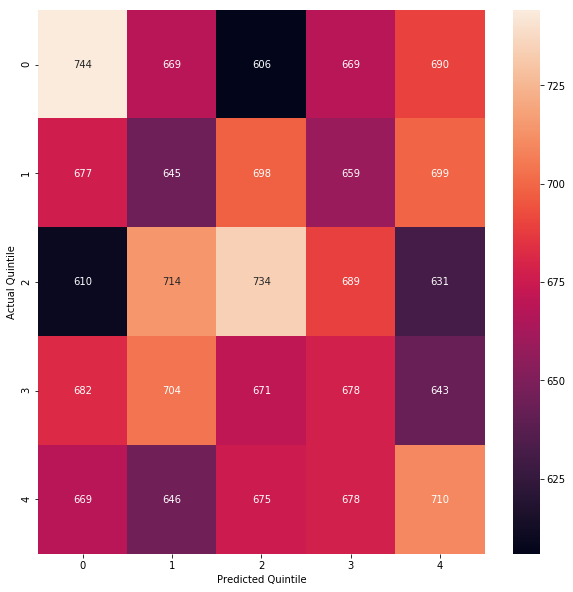

---
14:34:25 Running experiment 76 of 180
(300, 5, 0.03, 0.75)
................................................................................
14:36:43 Still training step 80 of 563
................................................................................
14:39:22 Still training step 160 of 563
................................................................................
14:42:44 Still training step 240 of 563
................................................................................
14:46:45 Still training step 320 of 563
................................................................................
14:51:24 Still training step 400 of 563
................................................................................
14:56:40 Still training step 480 of 563
................................................................................
15:02:47 Still training step 560 of 563
...
Mean return: 0.658%
Monthly Sharpe ratio: 0.172
Avg rank correlation (Kendall's tau): 0

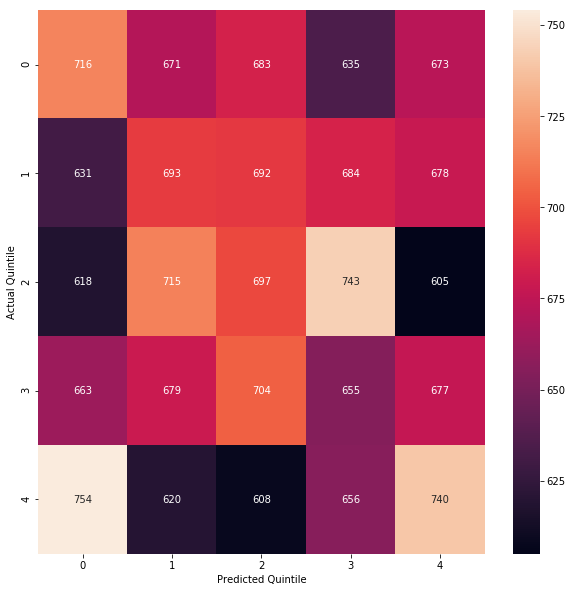

---
15:03:08 Running experiment 77 of 180
(300, 5, 0.01, 0.6)
................................................................................
15:05:13 Still training step 80 of 563
................................................................................
15:07:41 Still training step 160 of 563
................................................................................
15:10:29 Still training step 240 of 563
................................................................................
15:13:51 Still training step 320 of 563
................................................................................
15:17:39 Still training step 400 of 563
................................................................................
15:21:32 Still training step 480 of 563
................................................................................
15:25:19 Still training step 560 of 563
...
Mean return: 1.414%
Monthly Sharpe ratio: 0.303
Avg rank correlation (Kendall's tau): 0.

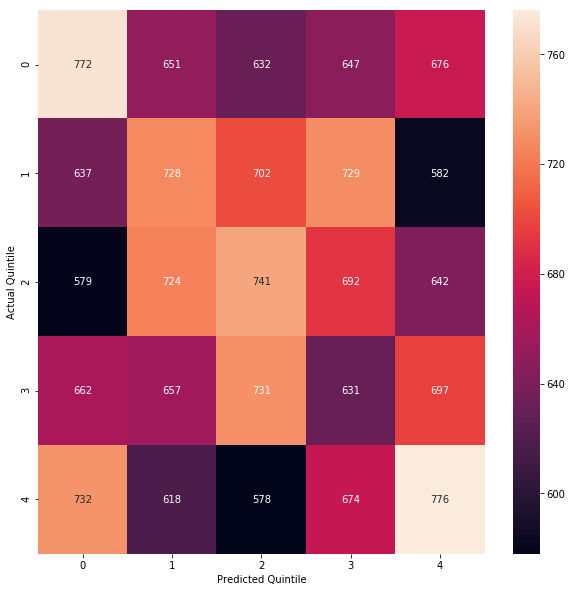

---
15:25:32 Running experiment 78 of 180
(300, 5, 0.01, 0.65)
................................................................................
15:27:17 Still training step 80 of 563
................................................................................
15:29:20 Still training step 160 of 563
................................................................................
15:31:44 Still training step 240 of 563
................................................................................
15:34:29 Still training step 320 of 563
................................................................................
15:37:35 Still training step 400 of 563
................................................................................
15:40:59 Still training step 480 of 563
................................................................................
15:44:43 Still training step 560 of 563
...
Mean return: 0.752%
Monthly Sharpe ratio: 0.184
Avg rank correlation (Kendall's tau): 0

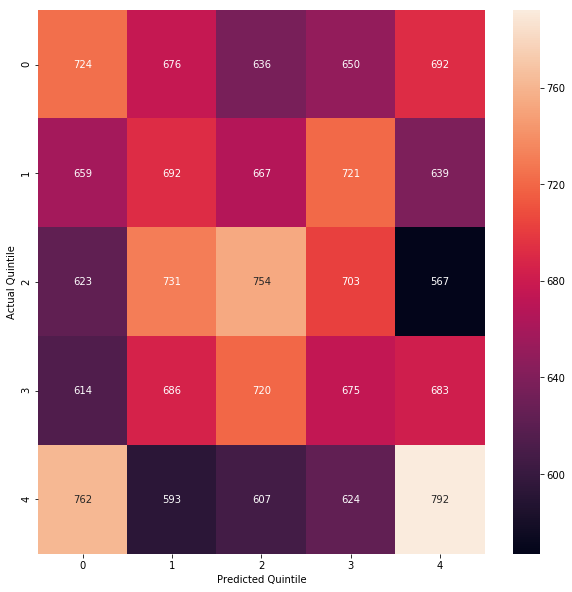

---
15:44:56 Running experiment 79 of 180
(300, 5, 0.01, 0.7)
................................................................................
15:46:41 Still training step 80 of 563
................................................................................
15:48:45 Still training step 160 of 563
................................................................................
15:51:09 Still training step 240 of 563
................................................................................
15:53:54 Still training step 320 of 563
................................................................................
15:56:59 Still training step 400 of 563
................................................................................
16:00:21 Still training step 480 of 563
................................................................................
16:04:05 Still training step 560 of 563
...
Mean return: 0.889%
Monthly Sharpe ratio: 0.221
Avg rank correlation (Kendall's tau): 0.

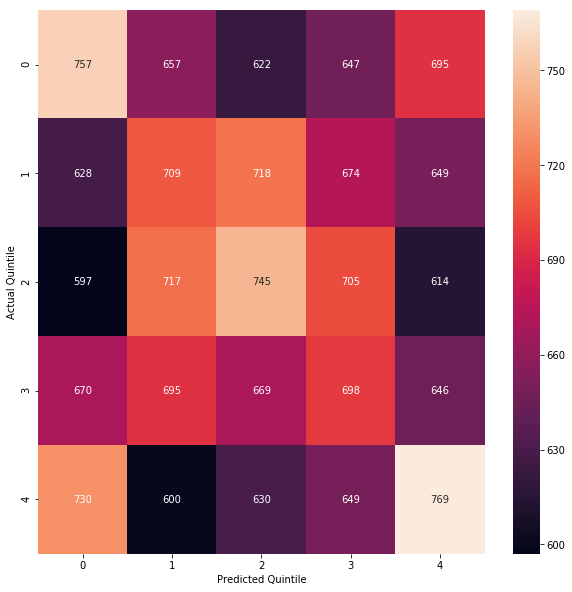

---
16:04:18 Running experiment 80 of 180
(300, 5, 0.01, 0.75)
................................................................................
16:06:02 Still training step 80 of 563
................................................................................
16:08:06 Still training step 160 of 563
................................................................................
16:10:30 Still training step 240 of 563
................................................................................
16:13:14 Still training step 320 of 563
................................................................................
16:16:18 Still training step 400 of 563
................................................................................
16:19:39 Still training step 480 of 563
................................................................................
16:23:21 Still training step 560 of 563
...
Mean return: 0.097%
Monthly Sharpe ratio: 0.044
Avg rank correlation (Kendall's tau): 0

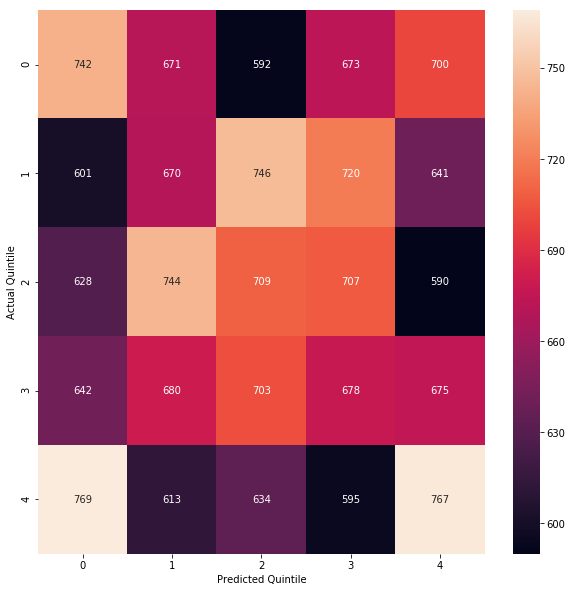

---
16:23:34 Running experiment 81 of 180
(300, 5, 0.003, 0.6)
................................................................................
16:25:16 Still training step 80 of 563
................................................................................
16:27:15 Still training step 160 of 563
................................................................................
16:29:32 Still training step 240 of 563
................................................................................
16:32:07 Still training step 320 of 563
................................................................................
16:34:56 Still training step 400 of 563
................................................................................
16:37:59 Still training step 480 of 563
................................................................................
16:41:18 Still training step 560 of 563
...
Mean return: 1.455%
Monthly Sharpe ratio: 0.318
Avg rank correlation (Kendall's tau): 0

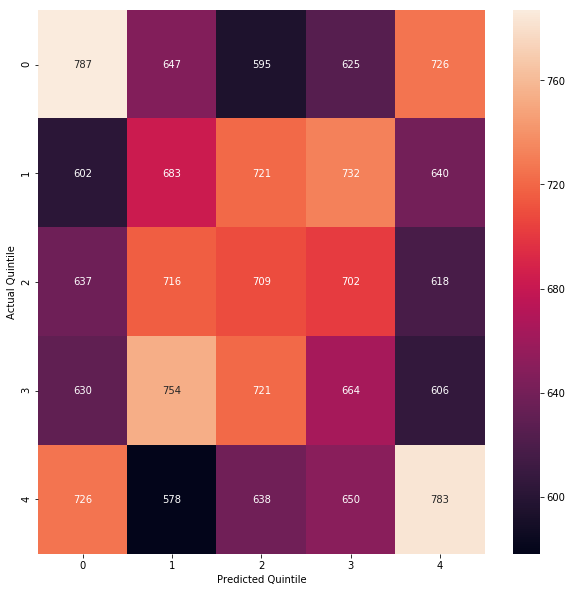

---
16:41:29 Running experiment 82 of 180
(300, 5, 0.003, 0.65)
................................................................................
16:43:12 Still training step 80 of 563
................................................................................
16:45:11 Still training step 160 of 563
................................................................................
16:47:28 Still training step 240 of 563
................................................................................
16:50:02 Still training step 320 of 563
................................................................................
16:52:53 Still training step 400 of 563
................................................................................
16:55:55 Still training step 480 of 563
................................................................................
16:59:15 Still training step 560 of 563
...
Mean return: 1.249%
Monthly Sharpe ratio: 0.275
Avg rank correlation (Kendall's tau): 

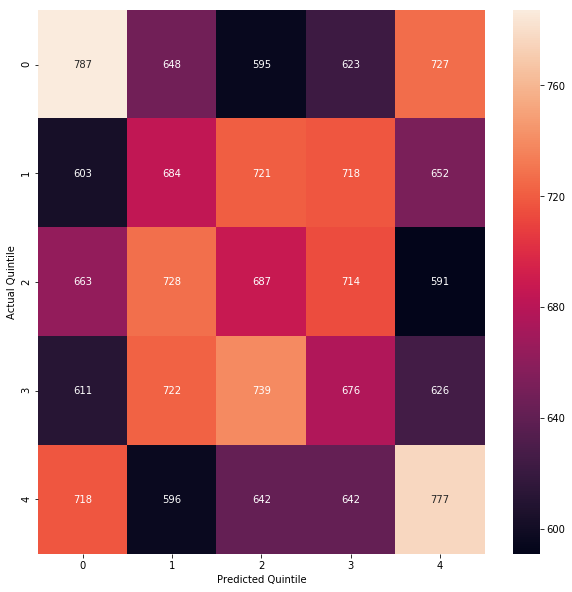

---
16:59:27 Running experiment 83 of 180
(300, 5, 0.003, 0.7)
................................................................................
17:01:09 Still training step 80 of 563
................................................................................
17:03:09 Still training step 160 of 563
................................................................................
17:05:27 Still training step 240 of 563
................................................................................
17:08:02 Still training step 320 of 563
................................................................................
17:10:52 Still training step 400 of 563
................................................................................
17:13:56 Still training step 480 of 563
................................................................................
17:17:16 Still training step 560 of 563
...
Mean return: 1.350%
Monthly Sharpe ratio: 0.293
Avg rank correlation (Kendall's tau): 0

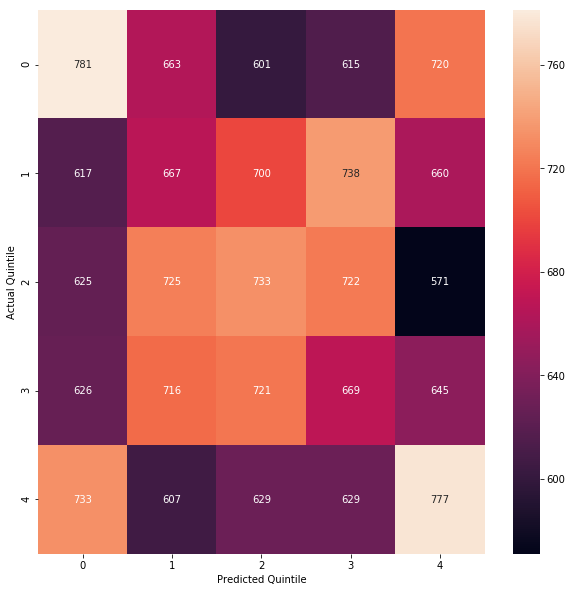

---
17:17:27 Running experiment 84 of 180
(300, 5, 0.003, 0.75)
................................................................................
17:19:09 Still training step 80 of 563
................................................................................
17:21:08 Still training step 160 of 563
................................................................................
17:23:24 Still training step 240 of 563
................................................................................
17:25:58 Still training step 320 of 563
................................................................................
17:28:45 Still training step 400 of 563
................................................................................
17:31:47 Still training step 480 of 563
................................................................................
17:35:05 Still training step 560 of 563
...
Mean return: 1.488%
Monthly Sharpe ratio: 0.317
Avg rank correlation (Kendall's tau): 

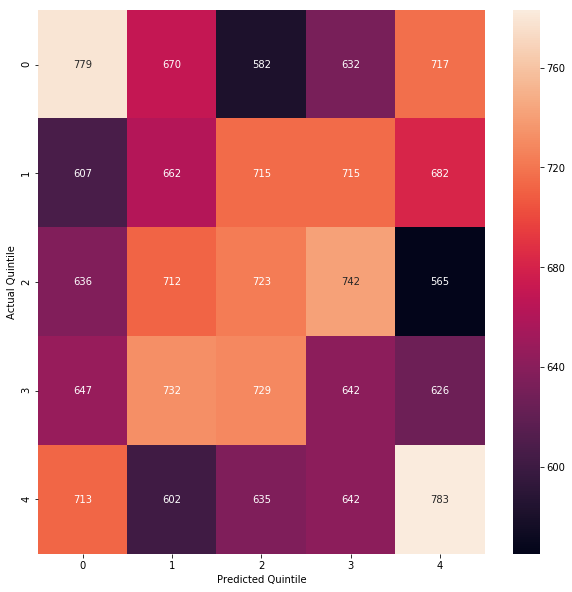

---
17:35:17 Running experiment 85 of 180
(300, 6, 0.03, 0.6)
................................................................................
17:37:11 Still training step 80 of 563
................................................................................
17:39:34 Still training step 160 of 563
................................................................................
17:42:29 Still training step 240 of 563
................................................................................
17:45:59 Still training step 320 of 563
................................................................................
17:50:04 Still training step 400 of 563
................................................................................
17:55:08 Still training step 480 of 563
................................................................................
18:01:29 Still training step 560 of 563
...
Mean return: 0.523%
Monthly Sharpe ratio: 0.133
Avg rank correlation (Kendall's tau): 0.

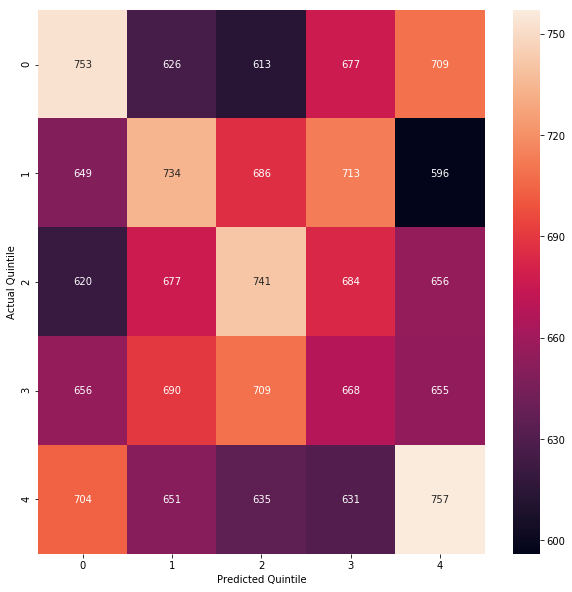

---
18:01:52 Running experiment 86 of 180
(300, 6, 0.03, 0.65)
................................................................................
18:04:00 Still training step 80 of 563
................................................................................
18:06:45 Still training step 160 of 563
................................................................................
18:10:01 Still training step 240 of 563
................................................................................
18:14:07 Still training step 320 of 563
................................................................................
18:18:51 Still training step 400 of 563
................................................................................
18:24:22 Still training step 480 of 563
................................................................................
18:30:22 Still training step 560 of 563
...
Mean return: 0.518%
Monthly Sharpe ratio: 0.135
Avg rank correlation (Kendall's tau): 0

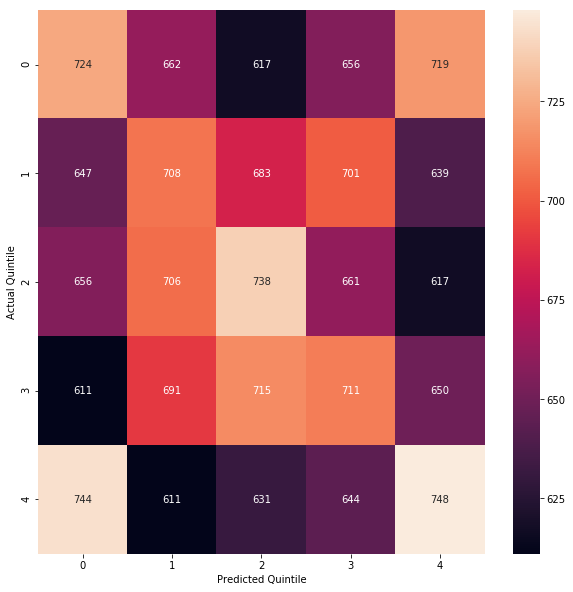

---
18:30:41 Running experiment 87 of 180
(300, 6, 0.03, 0.7)
................................................................................
18:32:50 Still training step 80 of 563
................................................................................
18:35:40 Still training step 160 of 563
................................................................................
18:38:55 Still training step 240 of 563
................................................................................
18:42:48 Still training step 320 of 563
................................................................................
18:47:28 Still training step 400 of 563
................................................................................
18:52:37 Still training step 480 of 563
................................................................................
18:58:36 Still training step 560 of 563
...
Mean return: 0.879%
Monthly Sharpe ratio: 0.219
Avg rank correlation (Kendall's tau): 0.

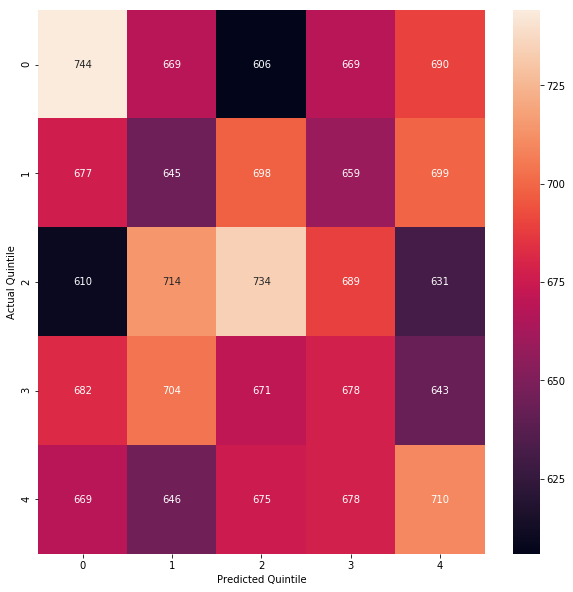

---
18:58:54 Running experiment 88 of 180
(300, 6, 0.03, 0.75)
................................................................................
19:01:01 Still training step 80 of 563
................................................................................
19:03:57 Still training step 160 of 563
................................................................................
19:07:21 Still training step 240 of 563
................................................................................
19:11:12 Still training step 320 of 563
................................................................................
19:15:26 Still training step 400 of 563
................................................................................
19:19:57 Still training step 480 of 563
................................................................................
19:24:50 Still training step 560 of 563
...
Mean return: 0.658%
Monthly Sharpe ratio: 0.172
Avg rank correlation (Kendall's tau): 0

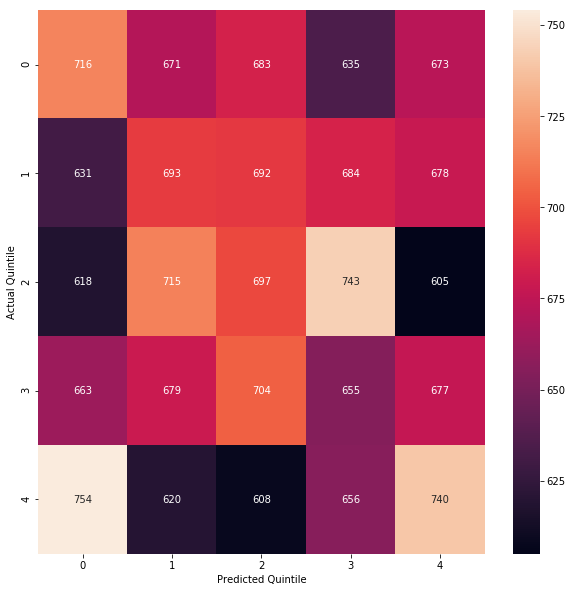

---
19:25:06 Running experiment 89 of 180
(300, 6, 0.01, 0.6)
................................................................................
19:26:51 Still training step 80 of 563
................................................................................
19:28:55 Still training step 160 of 563
................................................................................
19:31:19 Still training step 240 of 563
................................................................................
19:34:04 Still training step 320 of 563
................................................................................
19:37:11 Still training step 400 of 563
................................................................................
19:40:34 Still training step 480 of 563
................................................................................
19:44:20 Still training step 560 of 563
...
Mean return: 1.414%
Monthly Sharpe ratio: 0.303
Avg rank correlation (Kendall's tau): 0.

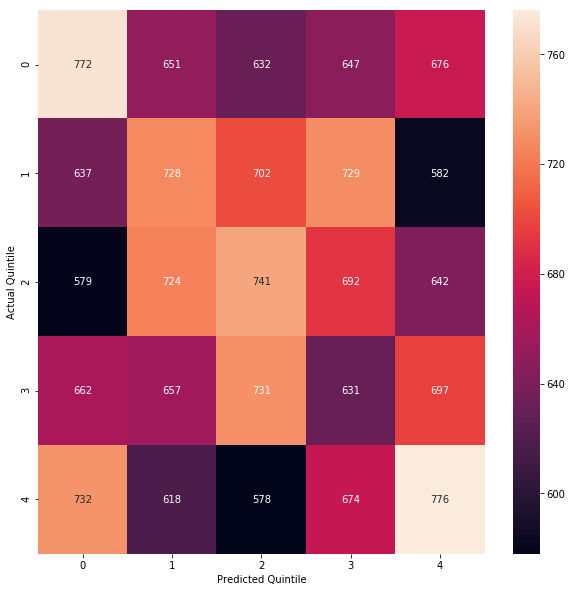

---
19:44:33 Running experiment 90 of 180
(300, 6, 0.01, 0.65)
................................................................................
19:46:18 Still training step 80 of 563
................................................................................
19:48:21 Still training step 160 of 563
................................................................................
19:50:47 Still training step 240 of 563
................................................................................
19:53:33 Still training step 320 of 563
................................................................................
19:56:41 Still training step 400 of 563
................................................................................
20:00:04 Still training step 480 of 563
................................................................................
20:03:50 Still training step 560 of 563
...
Mean return: 0.752%
Monthly Sharpe ratio: 0.184
Avg rank correlation (Kendall's tau): 0

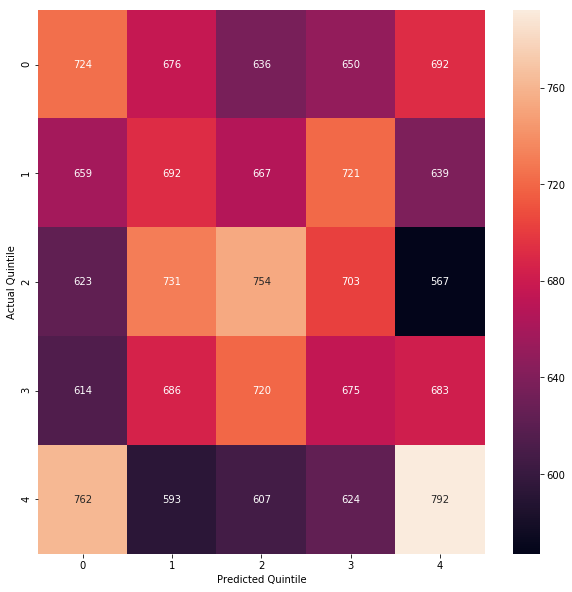

---
20:04:03 Running experiment 91 of 180
(300, 6, 0.01, 0.7)
................................................................................
20:05:49 Still training step 80 of 563
................................................................................
20:07:53 Still training step 160 of 563
................................................................................
20:10:18 Still training step 240 of 563
................................................................................
20:13:04 Still training step 320 of 563
................................................................................
20:16:10 Still training step 400 of 563
................................................................................
20:19:32 Still training step 480 of 563
................................................................................
20:23:16 Still training step 560 of 563
...
Mean return: 0.889%
Monthly Sharpe ratio: 0.221
Avg rank correlation (Kendall's tau): 0.

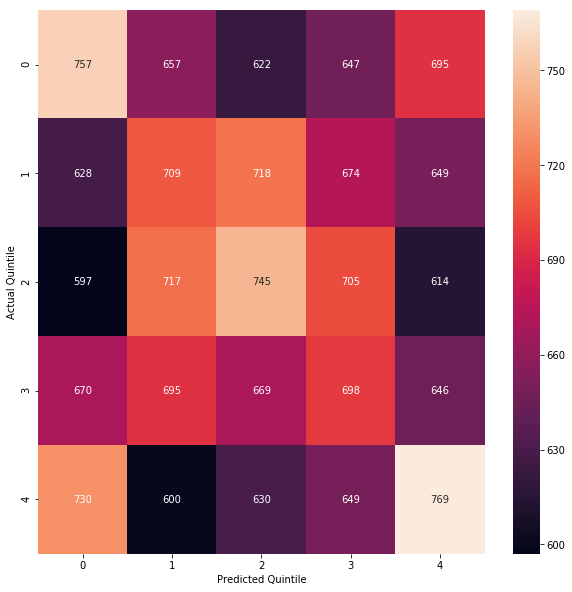

---
20:23:29 Running experiment 92 of 180
(300, 6, 0.01, 0.75)
................................................................................
20:25:14 Still training step 80 of 563
................................................................................
20:27:18 Still training step 160 of 563
................................................................................
20:29:43 Still training step 240 of 563
................................................................................
20:32:28 Still training step 320 of 563
................................................................................
20:35:33 Still training step 400 of 563
................................................................................
20:38:54 Still training step 480 of 563
................................................................................
20:42:37 Still training step 560 of 563
...
Mean return: 0.097%
Monthly Sharpe ratio: 0.044
Avg rank correlation (Kendall's tau): 0

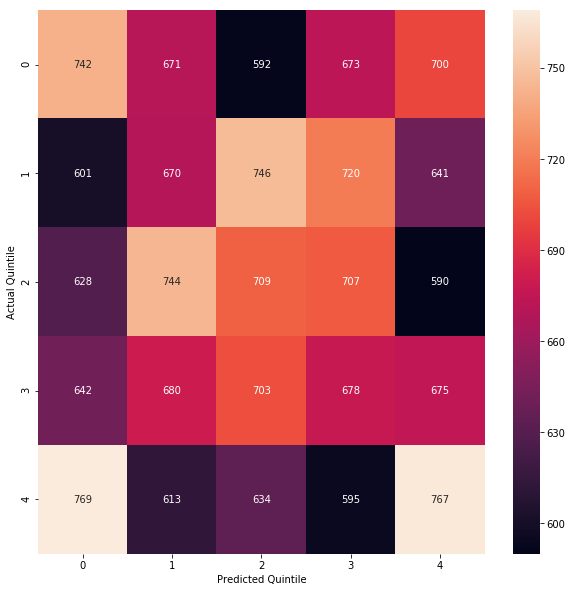

---
20:42:49 Running experiment 93 of 180
(300, 6, 0.003, 0.6)
................................................................................
20:44:32 Still training step 80 of 563
................................................................................
20:46:32 Still training step 160 of 563
................................................................................
20:48:49 Still training step 240 of 563
................................................................................
20:51:24 Still training step 320 of 563
................................................................................
20:54:14 Still training step 400 of 563
................................................................................
20:57:17 Still training step 480 of 563
................................................................................
21:00:35 Still training step 560 of 563
...
Mean return: 1.455%
Monthly Sharpe ratio: 0.318
Avg rank correlation (Kendall's tau): 0

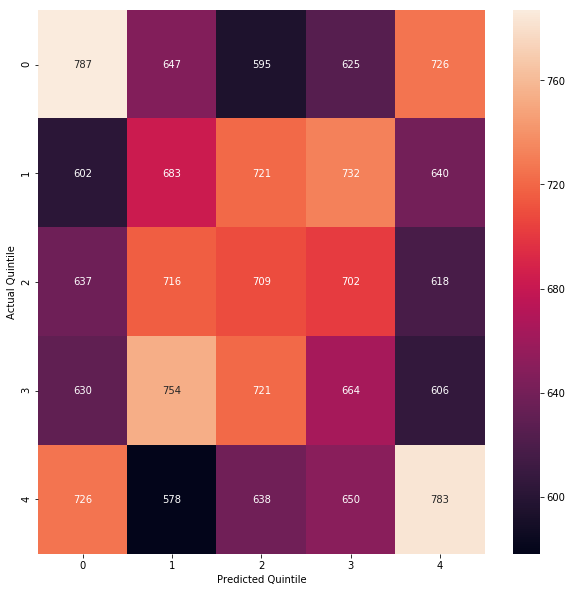

---
21:00:46 Running experiment 94 of 180
(300, 6, 0.003, 0.65)
................................................................................
21:02:28 Still training step 80 of 563
................................................................................
21:04:27 Still training step 160 of 563
................................................................................
21:06:42 Still training step 240 of 563
................................................................................
21:09:15 Still training step 320 of 563
.....................
21:12:03 Still training step 400 of 563
................................................................................
21:15:05 Still training step 480 of 563
................................................................................
21:18:24 Still training step 560 of 563
...
Mean return: 1.249%
Monthly Sharpe ratio: 0.275
Avg rank correlation (Kendall's tau): 0.0094 (Expected: 0)
5-quintile accuracy: 0.2138 (Expected:

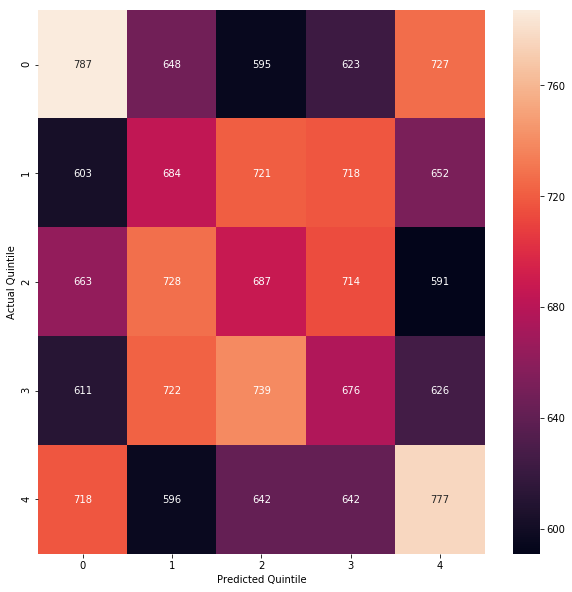

---
21:18:35 Running experiment 95 of 180
(300, 6, 0.003, 0.7)
................................................................................
21:20:17 Still training step 80 of 563
................................................................................
21:22:16 Still training step 160 of 563
................................................................................
21:24:32 Still training step 240 of 563
................................................................................
21:27:05 Still training step 320 of 563
................................................................................
21:29:54 Still training step 400 of 563
................................................................................
21:32:57 Still training step 480 of 563
................................................................................
21:36:15 Still training step 560 of 563
...
Mean return: 1.350%
Monthly Sharpe ratio: 0.293
Avg rank correlation (Kendall's tau): 0

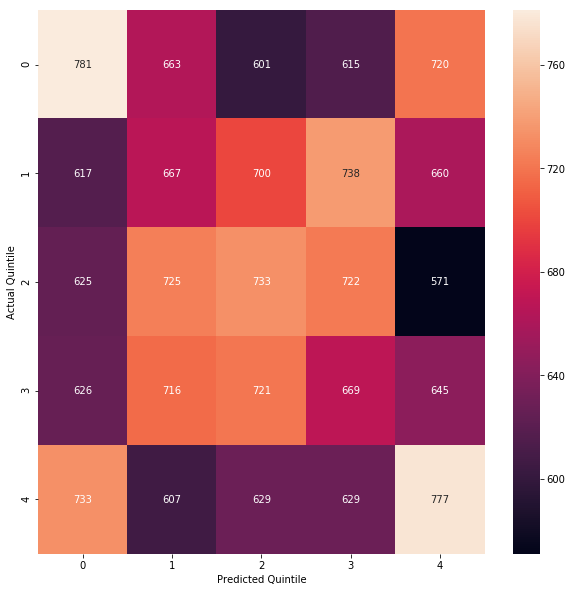

---
21:36:27 Running experiment 96 of 180
(300, 6, 0.003, 0.75)
................................................................................
21:38:08 Still training step 80 of 563
................................................................................
21:40:07 Still training step 160 of 563
................................................................................
21:42:23 Still training step 240 of 563
................................................................................
21:44:56 Still training step 320 of 563
................................................................................
21:47:44 Still training step 400 of 563
................................................................................
21:50:46 Still training step 480 of 563
................................................................................
21:54:04 Still training step 560 of 563
...
Mean return: 1.488%
Monthly Sharpe ratio: 0.317
Avg rank correlation (Kendall's tau): 

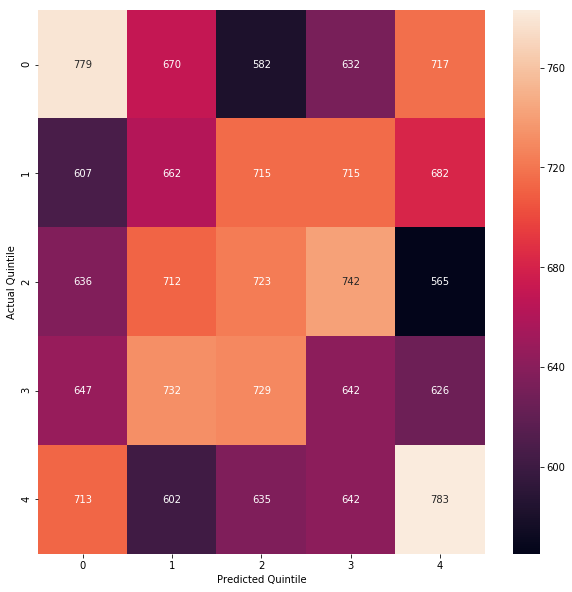

---
21:54:16 Running experiment 97 of 180
(300, 7, 0.03, 0.6)
................................................................................
21:56:10 Still training step 80 of 563
................................................................................
21:58:33 Still training step 160 of 563
................................................................................
22:01:29 Still training step 240 of 563
................................................................................
22:04:59 Still training step 320 of 563
................................................................................
22:09:09 Still training step 400 of 563
................................................................................
22:13:50 Still training step 480 of 563
................................................................................
22:19:10 Still training step 560 of 563
...
Mean return: 0.523%
Monthly Sharpe ratio: 0.133
Avg rank correlation (Kendall's tau): 0.

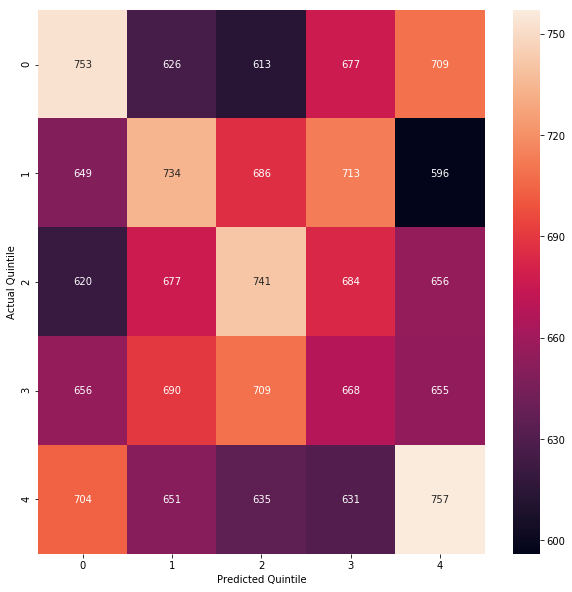

---
22:19:28 Running experiment 98 of 180
(300, 7, 0.03, 0.65)
................................................................................
22:21:28 Still training step 80 of 563
................................................................................
22:23:56 Still training step 160 of 563
................................................................................
22:26:54 Still training step 240 of 563
................................................................................
22:30:25 Still training step 320 of 563
................................................................................
22:34:26 Still training step 400 of 563
................................................................................
22:39:01 Still training step 480 of 563
................................................................................
22:44:12 Still training step 560 of 563
...
Mean return: 0.518%
Monthly Sharpe ratio: 0.135
Avg rank correlation (Kendall's tau): 0

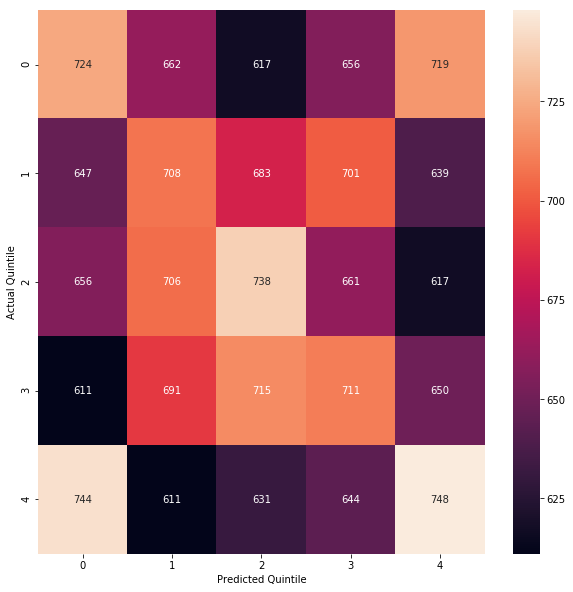

---
22:44:30 Running experiment 99 of 180
(300, 7, 0.03, 0.7)
................................................................................
22:46:26 Still training step 80 of 563
................................................................................
22:48:53 Still training step 160 of 563
................................................................................
22:51:49 Still training step 240 of 563
................................................................................
22:55:16 Still training step 320 of 563
................................................................................
22:59:14 Still training step 400 of 563
................................................................................
23:04:04 Still training step 480 of 563
................................................................................
23:09:08 Still training step 560 of 563
...
Mean return: 0.879%
Monthly Sharpe ratio: 0.219
Avg rank correlation (Kendall's tau): 0.

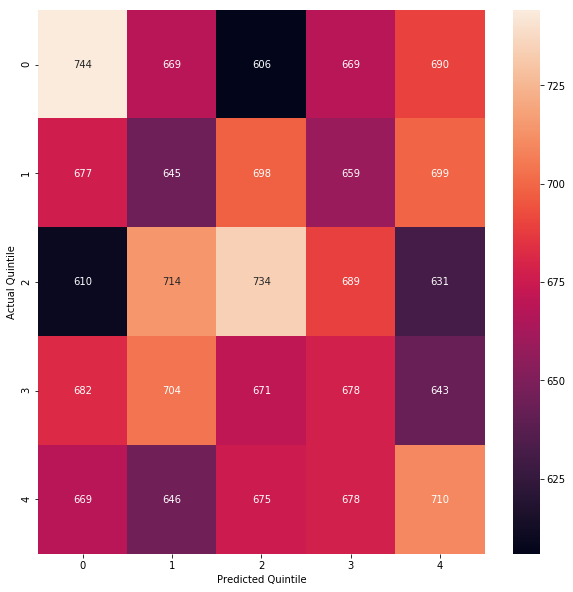

---
23:09:26 Running experiment 100 of 180
(300, 7, 0.03, 0.75)
................................................................................
23:11:26 Still training step 80 of 563
................................................................................
23:13:54 Still training step 160 of 563
................................................................................
23:16:49 Still training step 240 of 563
................................................................................
23:20:15 Still training step 320 of 563
................................................................................
23:24:12 Still training step 400 of 563
................................................................................
23:28:36 Still training step 480 of 563
................................................................................
23:33:35 Still training step 560 of 563
...
Mean return: 0.658%
Monthly Sharpe ratio: 0.172
Avg rank correlation (Kendall's tau): 

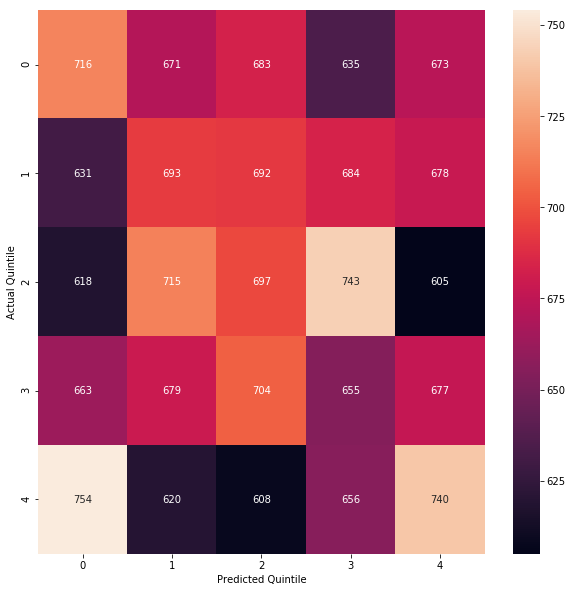

---
23:33:52 Running experiment 101 of 180
(300, 7, 0.01, 0.6)
................................................................................
23:35:43 Still training step 80 of 563
................................................................................
23:37:51 Still training step 160 of 563
................................................................................
23:40:20 Still training step 240 of 563
................................................................................
23:43:15 Still training step 320 of 563
................................................................................
23:46:27 Still training step 400 of 563
................................................................................
23:49:58 Still training step 480 of 563
................................................................................
23:53:52 Still training step 560 of 563
...
Mean return: 1.414%
Monthly Sharpe ratio: 0.303
Avg rank correlation (Kendall's tau): 0

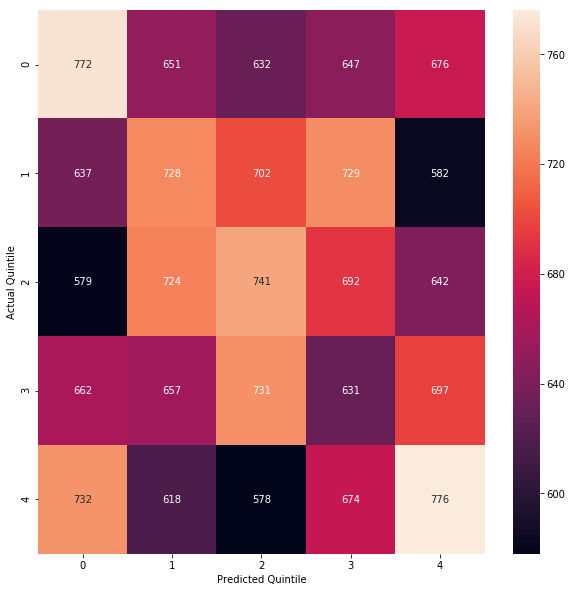

---
23:54:05 Running experiment 102 of 180
(300, 7, 0.01, 0.65)
................................................................................
23:55:56 Still training step 80 of 563
................................................................................
23:58:05 Still training step 160 of 563
................................................................................
00:00:38 Still training step 240 of 563
................................................................................
00:03:30 Still training step 320 of 563
................................................................................
00:06:39 Still training step 400 of 563
................................................................................
00:10:10 Still training step 480 of 563
................................................................................
00:14:01 Still training step 560 of 563
...
Mean return: 0.752%
Monthly Sharpe ratio: 0.184
Avg rank correlation (Kendall's tau): 

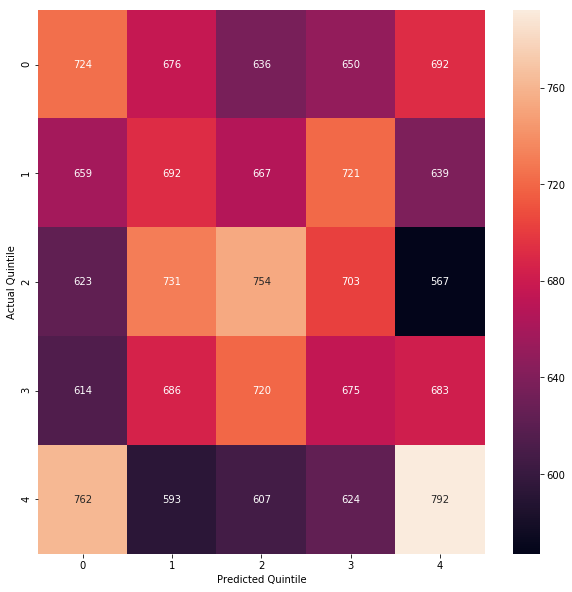

---
00:14:14 Running experiment 103 of 180
(300, 7, 0.01, 0.7)
................................................................................
00:16:04 Still training step 80 of 563
................................................................................
00:18:16 Still training step 160 of 563
................................................................................
00:20:45 Still training step 240 of 563
................................................................................
00:23:35 Still training step 320 of 563
................................................................................
00:26:42 Still training step 400 of 563
................................................................................
00:30:06 Still training step 480 of 563
................................................................................
00:33:57 Still training step 560 of 563
...
Mean return: 0.889%
Monthly Sharpe ratio: 0.221
Avg rank correlation (Kendall's tau): 0

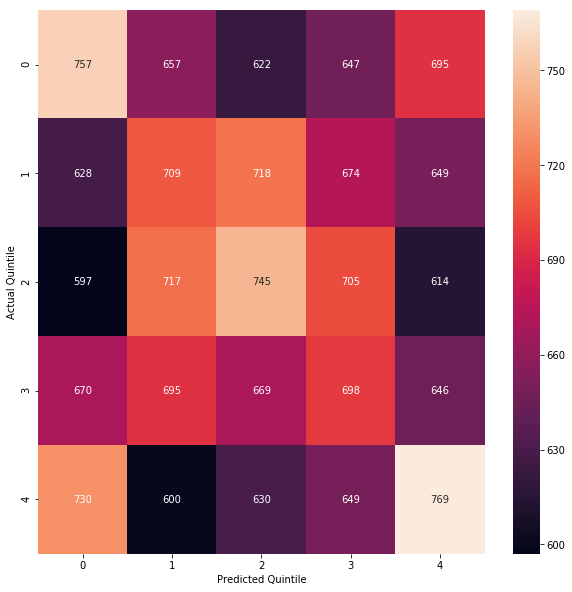

---
00:34:10 Running experiment 104 of 180
(300, 7, 0.01, 0.75)
................................................................................
00:35:59 Still training step 80 of 563
................................................................................
00:38:07 Still training step 160 of 563
................................................................................
00:40:35 Still training step 240 of 563
................................................................................
00:43:23 Still training step 320 of 563
................................................................................
00:46:32 Still training step 400 of 563
................................................................................
00:49:58 Still training step 480 of 563
................................................................................
00:53:43 Still training step 560 of 563
...
Mean return: 0.097%
Monthly Sharpe ratio: 0.044
Avg rank correlation (Kendall's tau): 

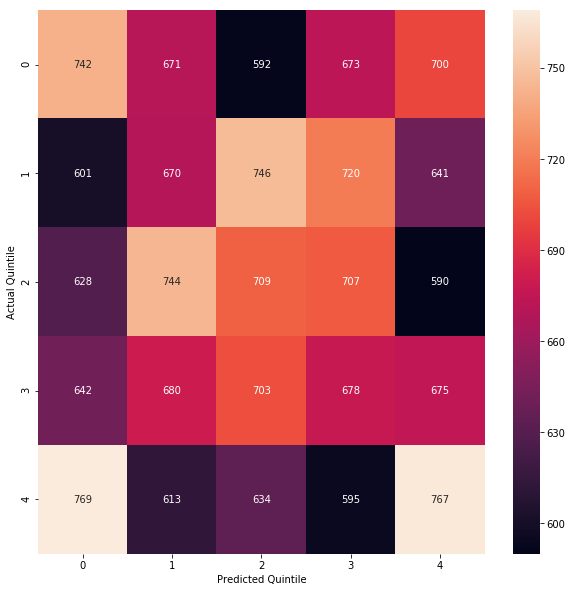

---
00:53:57 Running experiment 105 of 180
(300, 7, 0.003, 0.6)
................................................................................
00:55:42 Still training step 80 of 563
................................................................................
00:57:46 Still training step 160 of 563
................................................................................
01:00:10 Still training step 240 of 563
................................................................................
01:02:49 Still training step 320 of 563
................................................................................
01:05:43 Still training step 400 of 563
................................................................................
01:08:49 Still training step 480 of 563
................................................................................
01:12:16 Still training step 560 of 563
...
Mean return: 1.455%
Monthly Sharpe ratio: 0.318
Avg rank correlation (Kendall's tau): 

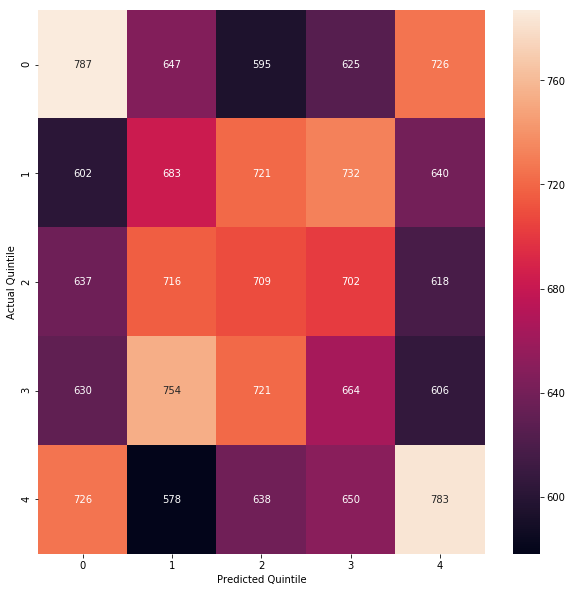

---
01:12:28 Running experiment 106 of 180
(300, 7, 0.003, 0.65)
................................................................................
01:14:17 Still training step 80 of 563
................................................................................
01:16:23 Still training step 160 of 563
................................................................................
01:18:45 Still training step 240 of 563
................................................................................
01:21:26 Still training step 320 of 563
................................................................................
01:24:22 Still training step 400 of 563
................................................................................
01:27:30 Still training step 480 of 563
................................................................................
01:30:55 Still training step 560 of 563
...
Mean return: 1.249%
Monthly Sharpe ratio: 0.275
Avg rank correlation (Kendall's tau):

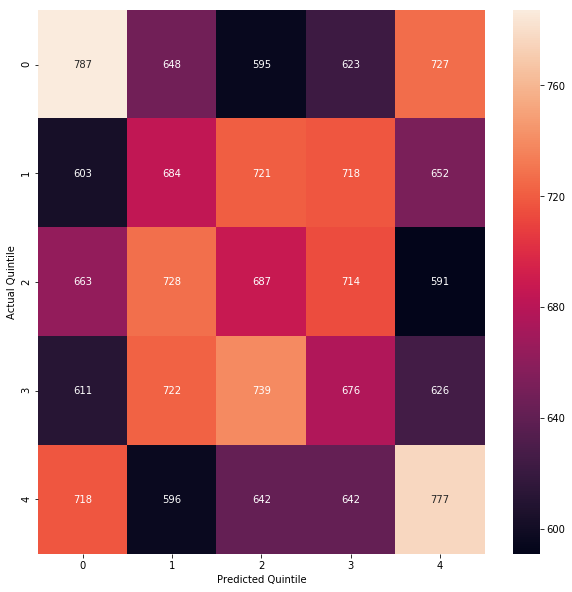

---
01:31:07 Running experiment 107 of 180
(300, 7, 0.003, 0.7)
................................................................................
01:32:58 Still training step 80 of 563
................................................................................
01:35:05 Still training step 160 of 563
................................................................................
01:37:27 Still training step 240 of 563
................................................................................
01:40:06 Still training step 320 of 563
................................................................................
01:43:03 Still training step 400 of 563
................................................................................
01:46:12 Still training step 480 of 563
................................................................................
01:49:37 Still training step 560 of 563
...
Mean return: 1.350%
Monthly Sharpe ratio: 0.293
Avg rank correlation (Kendall's tau): 

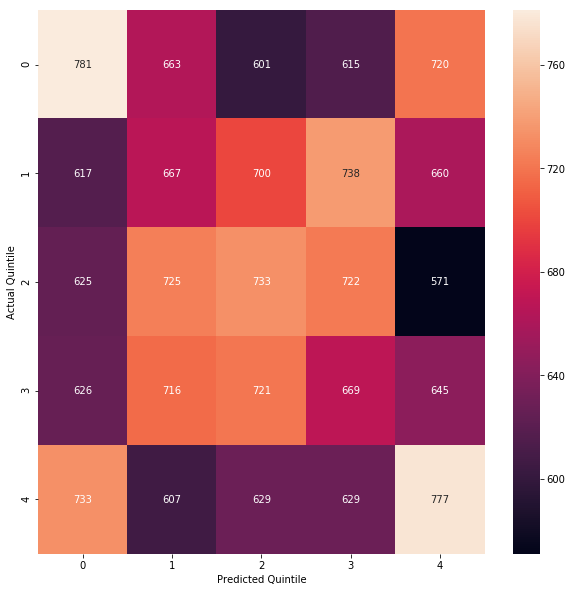

---
01:49:49 Running experiment 108 of 180
(300, 7, 0.003, 0.75)
................................................................................
01:51:39 Still training step 80 of 563
................................................................................
01:53:45 Still training step 160 of 563
................................................................................
01:56:08 Still training step 240 of 563
................................................................................
01:58:47 Still training step 320 of 563
................................................................................
02:01:43 Still training step 400 of 563
................................................................................
02:04:51 Still training step 480 of 563
................................................................................
02:08:15 Still training step 560 of 563
...
Mean return: 1.488%
Monthly Sharpe ratio: 0.317
Avg rank correlation (Kendall's tau):

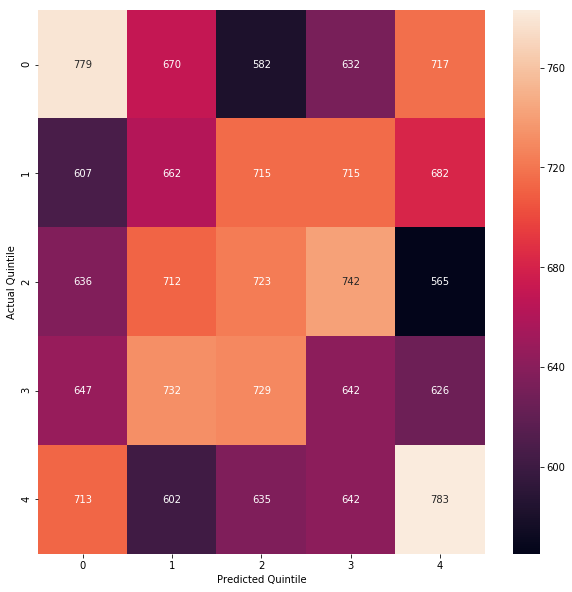

---
02:08:27 Running experiment 109 of 180
(300, 8, 0.03, 0.6)
................................................................................
02:10:31 Still training step 80 of 563
................................................................................
02:13:01 Still training step 160 of 563
................................................................................
02:16:02 Still training step 240 of 563
................................................................................
02:19:40 Still training step 320 of 563
................................................................................
02:23:51 Still training step 400 of 563
................................................................................
02:28:35 Still training step 480 of 563
................................................................................
02:33:55 Still training step 560 of 563
...
Mean return: 0.523%
Monthly Sharpe ratio: 0.133
Avg rank correlation (Kendall's tau): 0

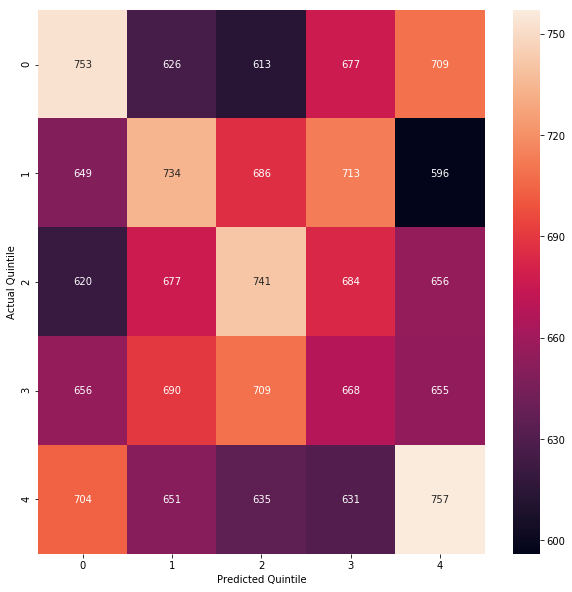

---
02:34:14 Running experiment 110 of 180
(300, 8, 0.03, 0.65)
................................................................................
02:36:11 Still training step 80 of 563
................................................................................
02:38:36 Still training step 160 of 563
................................................................................
02:41:35 Still training step 240 of 563
................................................................................
02:45:07 Still training step 320 of 563
................................................................................
02:49:11 Still training step 400 of 563
................................................................................
02:53:43 Still training step 480 of 563
................................................................................
02:58:56 Still training step 560 of 563
...
Mean return: 0.518%
Monthly Sharpe ratio: 0.135
Avg rank correlation (Kendall's tau): 

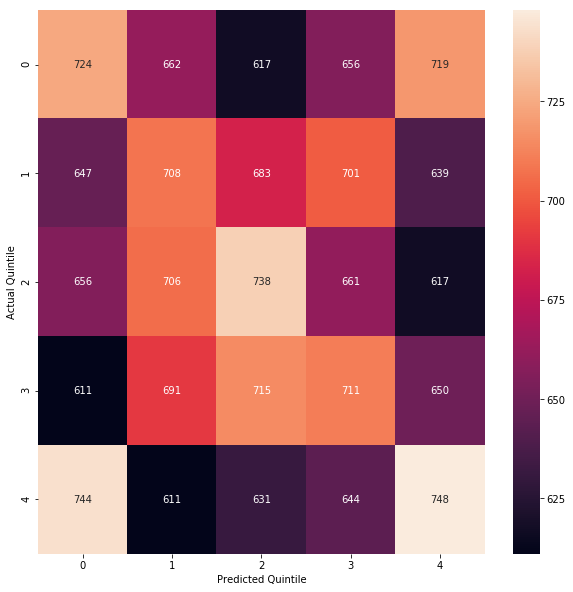

---
02:59:14 Running experiment 111 of 180
(300, 8, 0.03, 0.7)
................................................................................
03:01:12 Still training step 80 of 563
................................................................................
03:03:36 Still training step 160 of 563
................................................................................
03:06:31 Still training step 240 of 563
................................................................................
03:10:00 Still training step 320 of 563
................................................................................
03:13:58 Still training step 400 of 563
................................................................................
03:18:24 Still training step 480 of 563
................................................................................
03:23:29 Still training step 560 of 563
...
Mean return: 0.879%
Monthly Sharpe ratio: 0.219
Avg rank correlation (Kendall's tau): 0

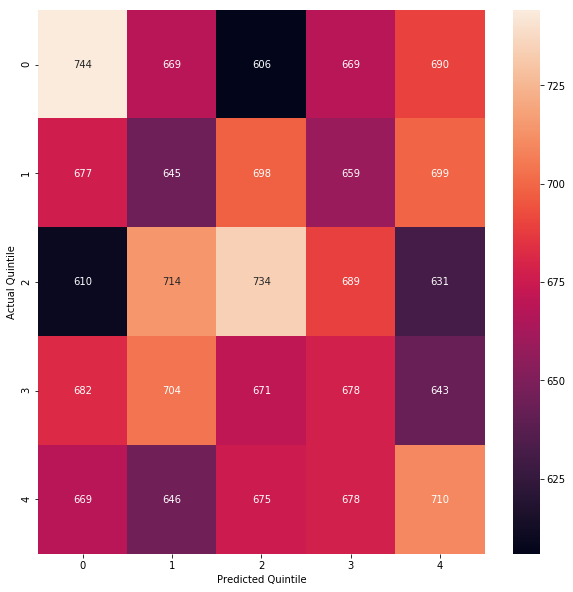

---
03:23:47 Running experiment 112 of 180
(300, 8, 0.03, 0.75)
................................................................................
03:25:46 Still training step 80 of 563
................................................................................
03:28:11 Still training step 160 of 563
................................................................................
03:31:07 Still training step 240 of 563
................................................................................
03:34:34 Still training step 320 of 563
................................................................................
03:38:28 Still training step 400 of 563
................................................................................
03:42:52 Still training step 480 of 563
................................................................................
03:47:49 Still training step 560 of 563
...
Mean return: 0.658%
Monthly Sharpe ratio: 0.172
Avg rank correlation (Kendall's tau): 

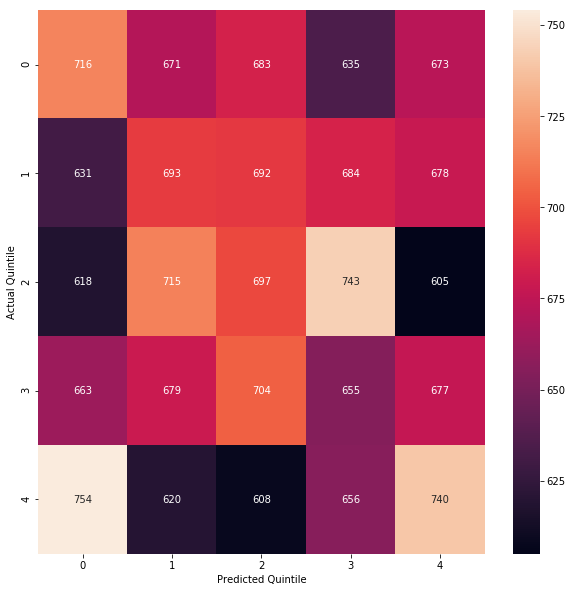

---
03:48:06 Running experiment 113 of 180
(300, 8, 0.01, 0.6)
................................................................................
03:49:55 Still training step 80 of 563
................................................................................
03:52:08 Still training step 160 of 563
................................................................................
03:54:38 Still training step 240 of 563
................................................................................
03:57:29 Still training step 320 of 563
................................................................................
04:00:41 Still training step 400 of 563
................................................................................
04:04:13 Still training step 480 of 563
................................................................................
04:08:07 Still training step 560 of 563
...
Mean return: 1.414%
Monthly Sharpe ratio: 0.303
Avg rank correlation (Kendall's tau): 0

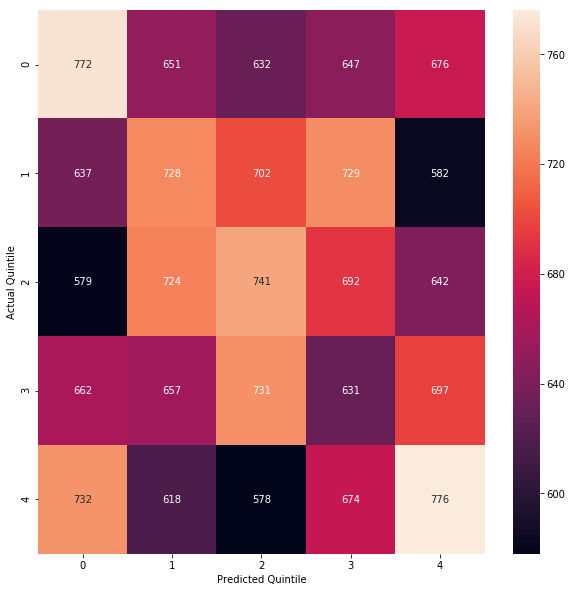

---
04:08:20 Running experiment 114 of 180
(300, 8, 0.01, 0.65)
................................................................................
04:10:14 Still training step 80 of 563
................................................................................
04:12:25 Still training step 160 of 563
................................................................................
04:14:56 Still training step 240 of 563
................................................................................
04:17:47 Still training step 320 of 563
................................................................................
04:21:01 Still training step 400 of 563
................................................................................
04:24:31 Still training step 480 of 563
................................................................................
04:28:25 Still training step 560 of 563
...
Mean return: 0.752%
Monthly Sharpe ratio: 0.184
Avg rank correlation (Kendall's tau): 

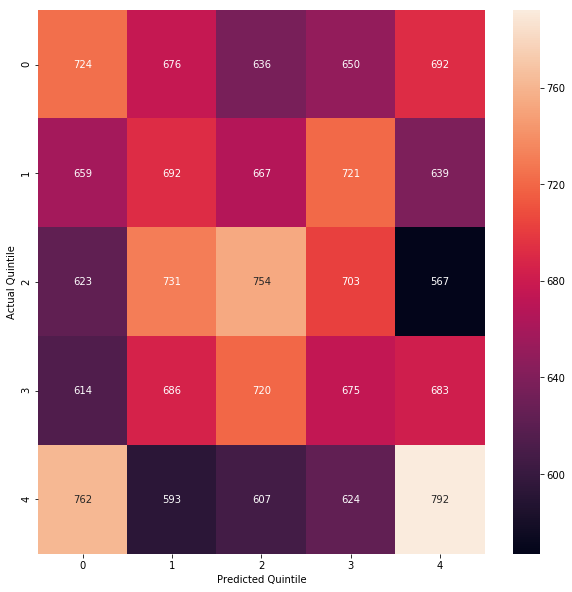

---
04:28:38 Running experiment 115 of 180
(300, 8, 0.01, 0.7)
................................................................................
04:30:31 Still training step 80 of 563
................................................................................
04:32:41 Still training step 160 of 563
................................................................................
04:35:11 Still training step 240 of 563
................................................................................
04:38:03 Still training step 320 of 563
................................................................................
04:41:11 Still training step 400 of 563
................................................................................
04:44:37 Still training step 480 of 563
................................................................................
04:48:24 Still training step 560 of 563
...
Mean return: 0.889%
Monthly Sharpe ratio: 0.221
Avg rank correlation (Kendall's tau): 0

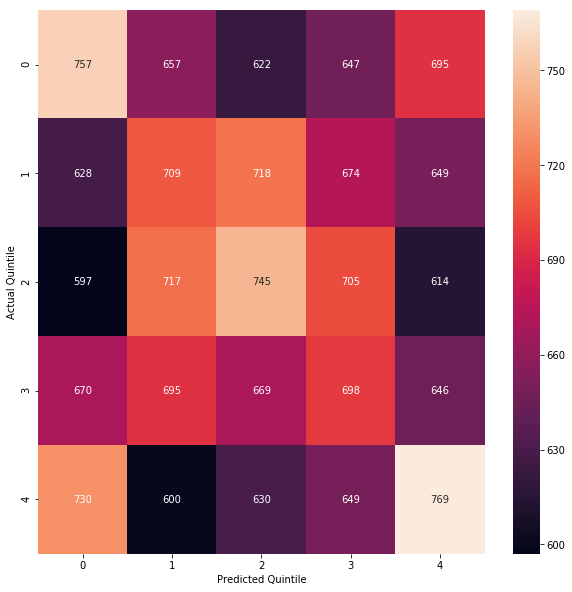

---
04:48:37 Running experiment 116 of 180
(300, 8, 0.01, 0.75)
................................................................................
04:50:27 Still training step 80 of 563
................................................................................
04:52:38 Still training step 160 of 563
................................................................................
04:55:07 Still training step 240 of 563
................................................................................
04:57:56 Still training step 320 of 563
................................................................................
05:01:02 Still training step 400 of 563
................................................................................
05:04:28 Still training step 480 of 563
................................................................................
05:08:16 Still training step 560 of 563
...
Mean return: 0.097%
Monthly Sharpe ratio: 0.044
Avg rank correlation (Kendall's tau): 

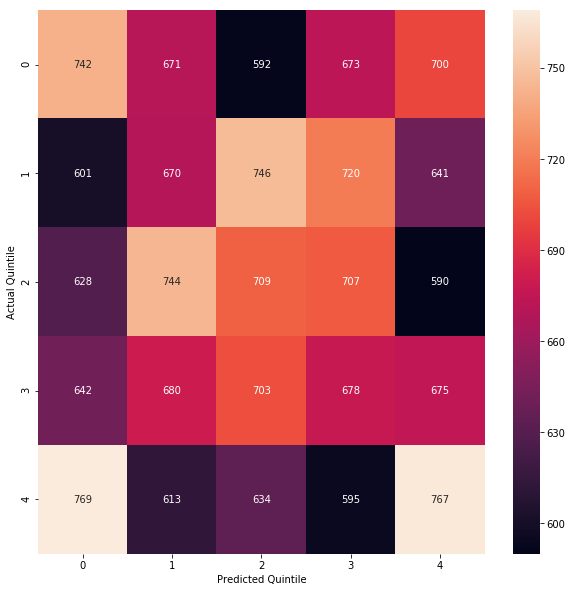

---
05:08:29 Running experiment 117 of 180
(300, 8, 0.003, 0.6)
................................................................................
05:10:16 Still training step 80 of 563
................................................................................
05:12:20 Still training step 160 of 563
................................................................................
05:14:40 Still training step 240 of 563
................................................................................
05:17:19 Still training step 320 of 563
................................................................................
05:20:16 Still training step 400 of 563
................................................................................
05:23:24 Still training step 480 of 563
................................................................................
05:26:47 Still training step 560 of 563
...
Mean return: 1.455%
Monthly Sharpe ratio: 0.318
Avg rank correlation (Kendall's tau): 

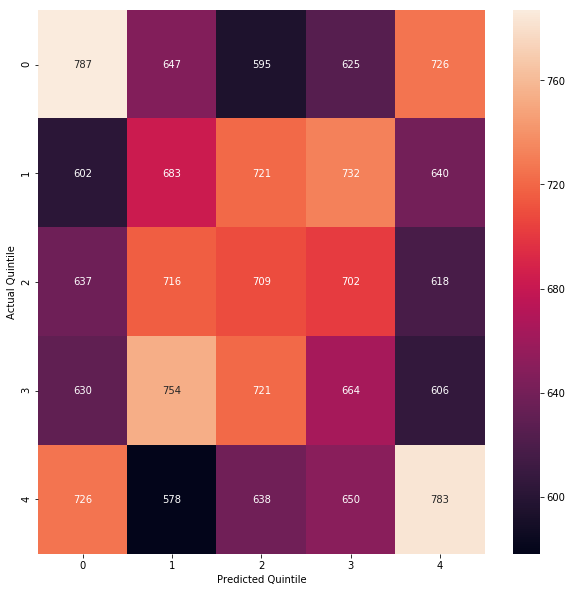

---
05:26:59 Running experiment 118 of 180
(300, 8, 0.003, 0.65)
................................................................................
05:28:45 Still training step 80 of 563
................................................................................
05:30:49 Still training step 160 of 563
................................................................................
05:33:14 Still training step 240 of 563
................................................................................
05:35:54 Still training step 320 of 563
................................................................................
05:38:48 Still training step 400 of 563
................................................................................
05:41:58 Still training step 480 of 563
................................................................................
05:45:25 Still training step 560 of 563
...
Mean return: 1.249%
Monthly Sharpe ratio: 0.275
Avg rank correlation (Kendall's tau):

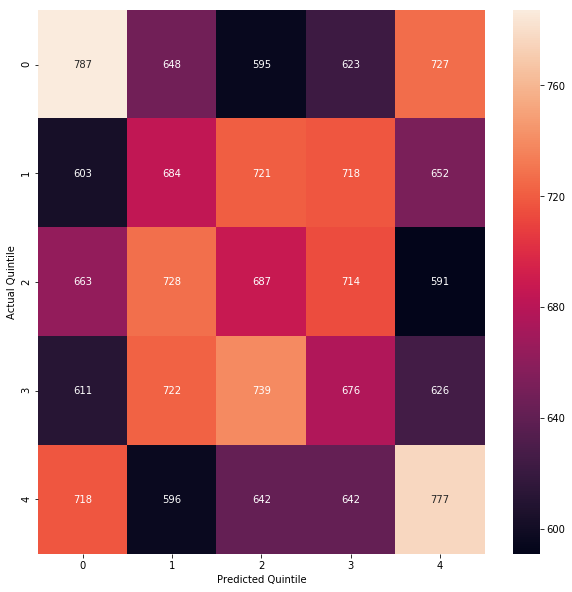

---
05:45:37 Running experiment 119 of 180
(300, 8, 0.003, 0.7)
................................................................................
05:47:25 Still training step 80 of 563
................................................................................
05:49:29 Still training step 160 of 563
................................................................................
05:51:55 Still training step 240 of 563
................................................................................
05:54:36 Still training step 320 of 563
................................................................................
05:57:32 Still training step 400 of 563
................................................................................
06:00:42 Still training step 480 of 563
................................................................................
06:04:10 Still training step 560 of 563
...
Mean return: 1.350%
Monthly Sharpe ratio: 0.293
Avg rank correlation (Kendall's tau): 

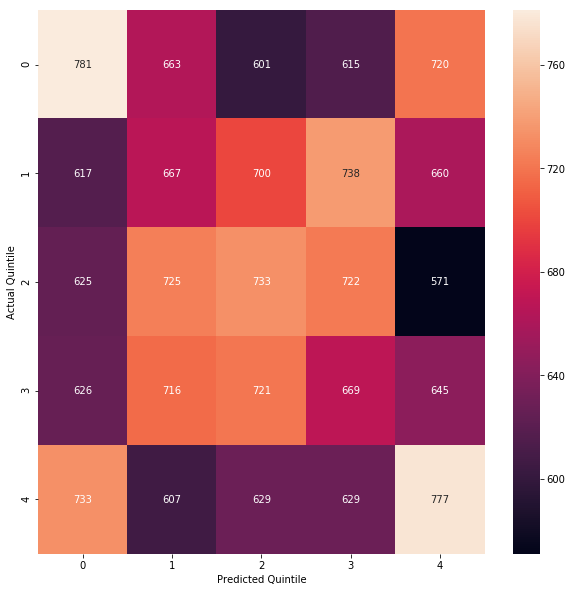

---
06:04:22 Running experiment 120 of 180
(300, 8, 0.003, 0.75)
................................................................................
06:06:09 Still training step 80 of 563
................................................................................
06:08:13 Still training step 160 of 563
................................................................................
06:10:34 Still training step 240 of 563
................................................................................
06:13:15 Still training step 320 of 563
................................................................................
06:16:09 Still training step 400 of 563
................................................................................
06:19:16 Still training step 480 of 563
................................................................................
06:22:42 Still training step 560 of 563
...
Mean return: 1.488%
Monthly Sharpe ratio: 0.317
Avg rank correlation (Kendall's tau):

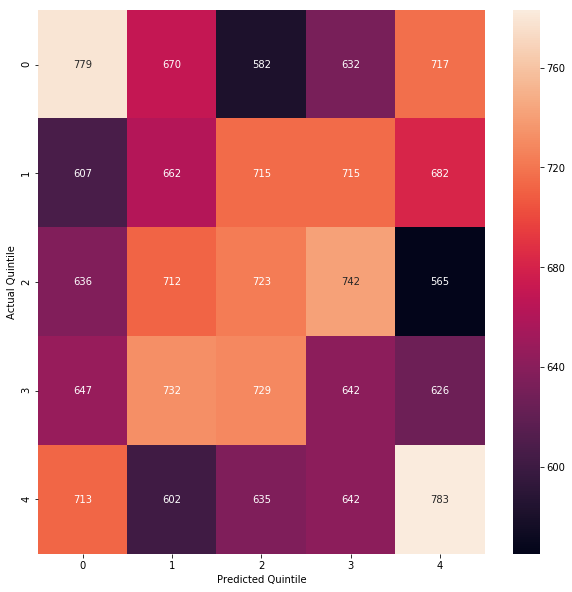

---
06:22:54 Running experiment 121 of 180
(1000, 4, 0.03, 0.6)
................................................................................
06:29:22 Still training step 80 of 563
................................................................................
06:37:12 Still training step 160 of 563
................................................................................
06:46:33 Still training step 240 of 563
................................................................................
06:57:22 Still training step 320 of 563
................................................................................
07:09:36 Still training step 400 of 563
................................................................................
07:23:16 Still training step 480 of 563
................................................................................
07:38:41 Still training step 560 of 563
...
Mean return: 0.587%
Monthly Sharpe ratio: 0.149
Avg rank correlation (Kendall's tau): 

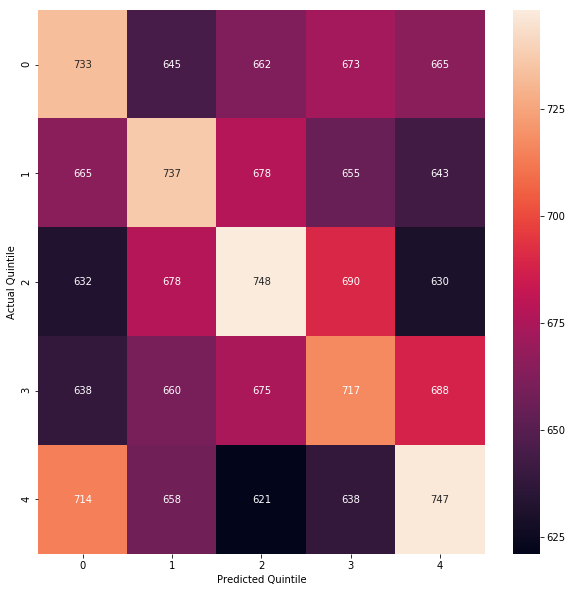

---
07:39:31 Running experiment 122 of 180
(1000, 4, 0.03, 0.65)
................................................................................
07:45:59 Still training step 80 of 563
................................................................................
07:53:45 Still training step 160 of 563
................................................................................
08:02:58 Still training step 240 of 563
................................................................................
08:13:42 Still training step 320 of 563
................................................................................
08:25:49 Still training step 400 of 563
................................................................................
08:39:21 Still training step 480 of 563
................................................................................
08:54:31 Still training step 560 of 563
...
Mean return: 0.012%
Monthly Sharpe ratio: 0.025
Avg rank correlation (Kendall's tau):

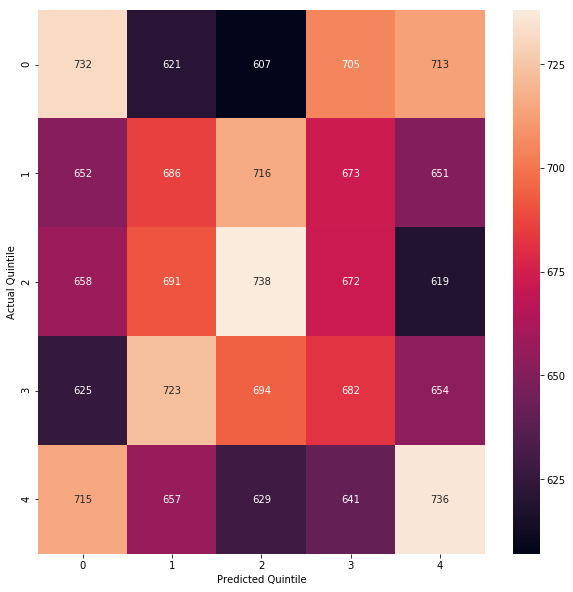

---
08:55:20 Running experiment 123 of 180
(1000, 4, 0.03, 0.7)
................................................................................
09:01:52 Still training step 80 of 563
................................................................................
09:09:35 Still training step 160 of 563
................................................................................
09:18:37 Still training step 240 of 563
................................................................................
09:29:06 Still training step 320 of 563
................................................................................
09:41:09 Still training step 400 of 563
................................................................................
09:54:27 Still training step 480 of 563
................................................................................
10:09:14 Still training step 560 of 563
...
Mean return: 0.672%
Monthly Sharpe ratio: 0.171
Avg rank correlation (Kendall's tau): 

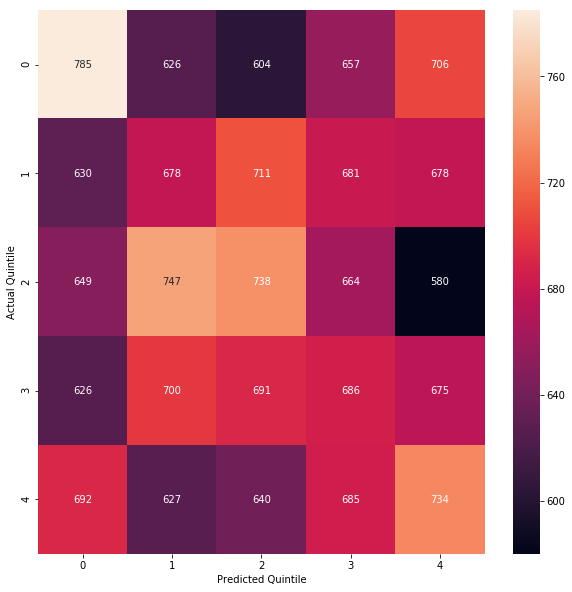

---
10:10:02 Running experiment 124 of 180
(1000, 4, 0.03, 0.75)
................................................................................
10:16:34 Still training step 80 of 563
................................................................................
10:24:14 Still training step 160 of 563
................................................................................
10:33:13 Still training step 240 of 563
................................................................................
10:43:36 Still training step 320 of 563
................................................................................
10:55:22 Still training step 400 of 563
................................................................................
11:08:19 Still training step 480 of 563
................................................................................
11:22:45 Still training step 560 of 563
...
Mean return: 0.735%
Monthly Sharpe ratio: 0.181
Avg rank correlation (Kendall's tau):

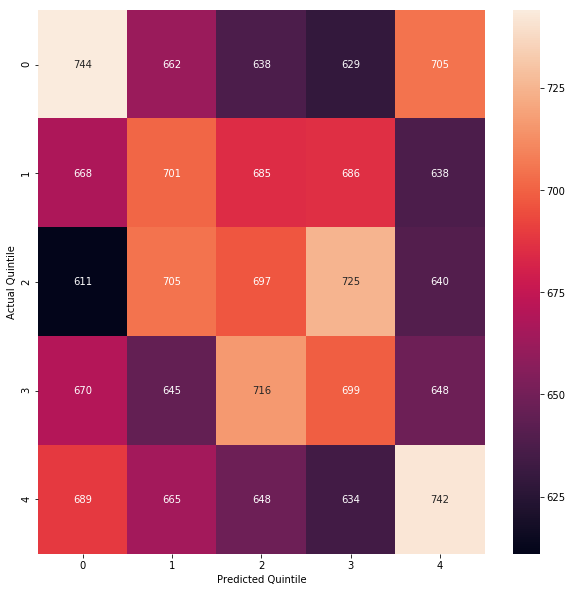

---
11:23:34 Running experiment 125 of 180
(1000, 4, 0.01, 0.6)
................................................................................
11:29:43 Still training step 80 of 563
................................................................................
11:36:47 Still training step 160 of 563
................................................................................
11:44:53 Still training step 240 of 563
................................................................................
11:54:05 Still training step 320 of 563
................................................................................
12:04:18 Still training step 400 of 563
................................................................................
12:15:21 Still training step 480 of 563
................................................................................
12:27:37 Still training step 560 of 563
...
Mean return: 2.088%
Monthly Sharpe ratio: 0.470
Avg rank correlation (Kendall's tau): 

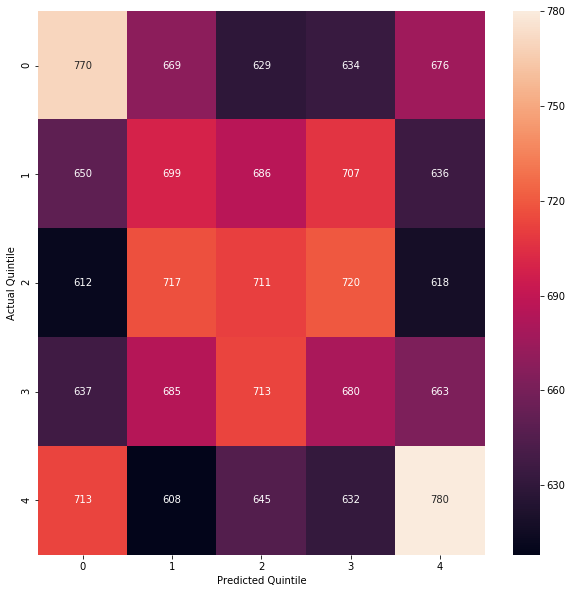

---
12:28:17 Running experiment 126 of 180
(1000, 4, 0.01, 0.65)
................................................................................
12:34:19 Still training step 80 of 563
................................................................................
12:41:20 Still training step 160 of 563
................................................................................
12:49:23 Still training step 240 of 563
................................................................................
12:58:42 Still training step 320 of 563
................................................................................
13:08:51 Still training step 400 of 563
................................................................................
13:20:02 Still training step 480 of 563
................................................................................
13:32:22 Still training step 560 of 563
...
Mean return: 1.774%
Monthly Sharpe ratio: 0.411
Avg rank correlation (Kendall's tau):

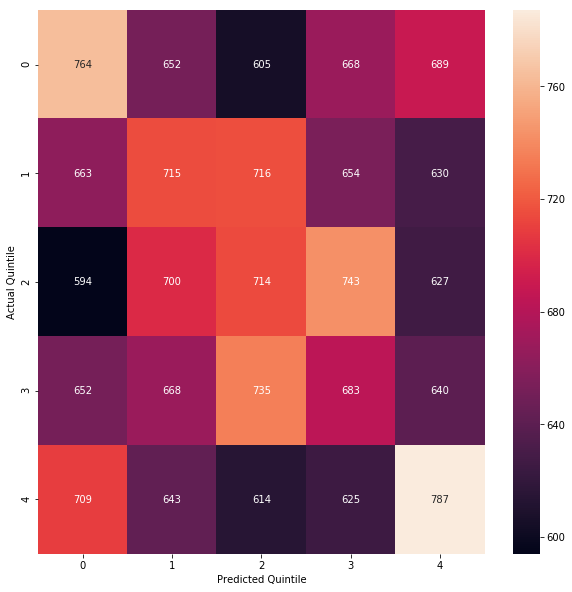

---
13:33:02 Running experiment 127 of 180
(1000, 4, 0.01, 0.7)
................................................................................
13:39:02 Still training step 80 of 563
................................................................................
13:46:09 Still training step 160 of 563
................................................................................
13:54:22 Still training step 240 of 563
................................................................................
14:03:33 Still training step 320 of 563
................................................................................
14:13:46 Still training step 400 of 563
................................................................................
14:24:52 Still training step 480 of 563
................................................................................
14:36:58 Still training step 560 of 563
...
Mean return: 1.390%
Monthly Sharpe ratio: 0.308
Avg rank correlation (Kendall's tau): 

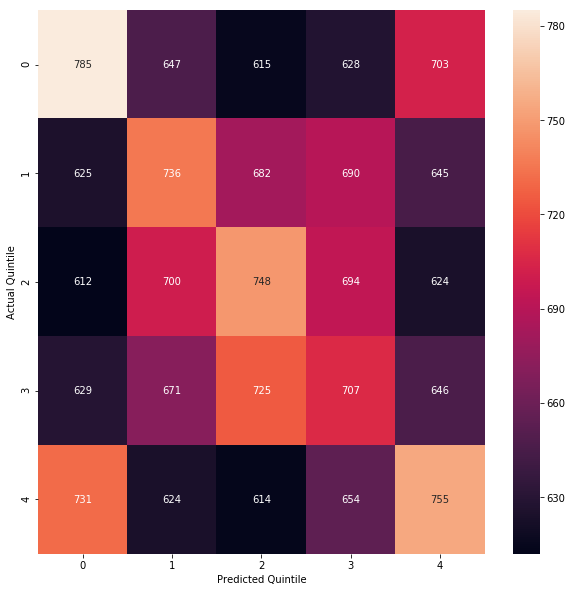

---
14:37:38 Running experiment 128 of 180
(1000, 4, 0.01, 0.75)
................................................................................
14:43:48 Still training step 80 of 563
................................................................................
14:50:53 Still training step 160 of 563
................................................................................
14:58:59 Still training step 240 of 563
................................................................................
15:08:12 Still training step 320 of 563
................................................................................
15:18:22 Still training step 400 of 563
................................................................................
15:29:17 Still training step 480 of 563
................................................................................
15:41:16 Still training step 560 of 563
...
Mean return: 0.469%
Monthly Sharpe ratio: 0.121
Avg rank correlation (Kendall's tau):

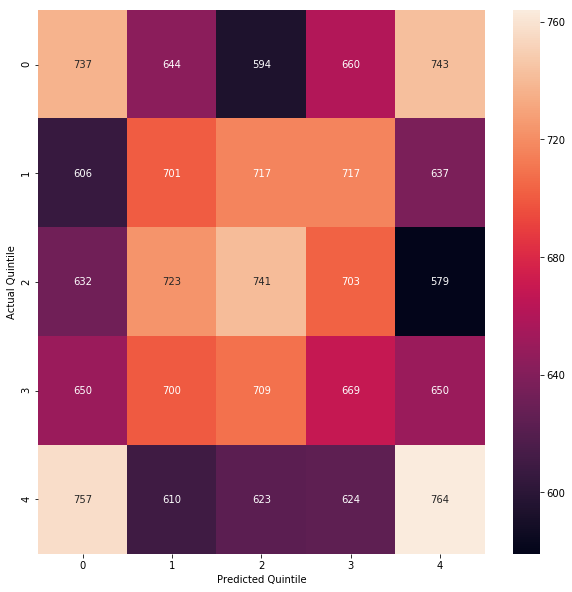

---
15:41:56 Running experiment 129 of 180
(1000, 4, 0.003, 0.6)
................................................................................
15:47:54 Still training step 80 of 563
................................................................................
15:54:42 Still training step 160 of 563
................................................................................
16:02:24 Still training step 240 of 563
................................................................................
16:11:01 Still training step 320 of 563
................................................................................
16:20:36 Still training step 400 of 563
................................................................................
16:30:53 Still training step 480 of 563
................................................................................
16:42:00 Still training step 560 of 563
...
Mean return: 0.669%
Monthly Sharpe ratio: 0.166
Avg rank correlation (Kendall's tau):

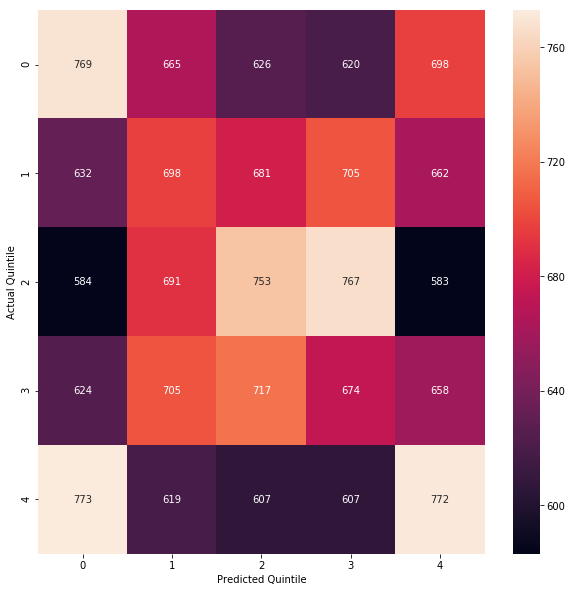

---
16:42:36 Running experiment 130 of 180
(1000, 4, 0.003, 0.65)
................................................................................
16:48:22 Still training step 80 of 563
................................................................................
16:55:09 Still training step 160 of 563
................................................................................
17:02:58 Still training step 240 of 563
................................................................................
17:11:38 Still training step 320 of 563
................................................................................
17:21:09 Still training step 400 of 563
................................................................................
17:31:28 Still training step 480 of 563
................................................................................
17:43:27 Still training step 560 of 563
...
Mean return: 1.546%
Monthly Sharpe ratio: 0.336
Avg rank correlation (Kendall's tau)

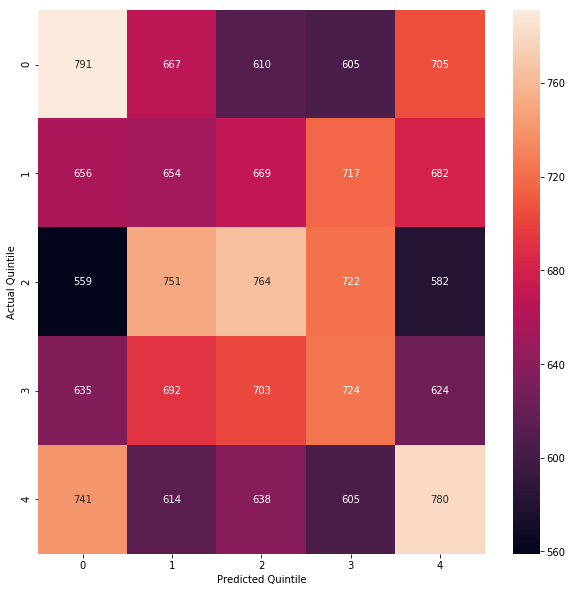

---
17:44:04 Running experiment 131 of 180
(1000, 4, 0.003, 0.7)
................................................................................
17:49:56 Still training step 80 of 563
................................................................................
17:56:43 Still training step 160 of 563
................................................................................
18:04:36 Still training step 240 of 563
................................................................................
18:13:21 Still training step 320 of 563
................................................................................
18:22:53 Still training step 400 of 563
................................................................................
18:33:15 Still training step 480 of 563
................................................................................
18:44:29 Still training step 560 of 563
...
Mean return: 0.233%
Monthly Sharpe ratio: 0.070
Avg rank correlation (Kendall's tau):

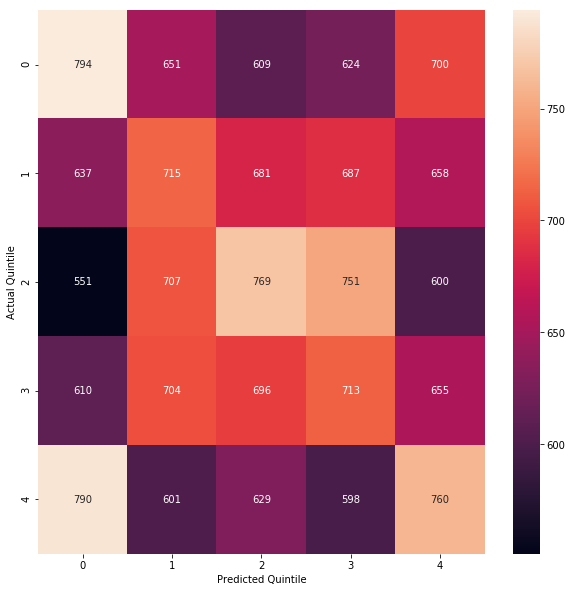

---
18:45:05 Running experiment 132 of 180
(1000, 4, 0.003, 0.75)
................................................................................
18:50:53 Still training step 80 of 563
................................................................................
18:57:42 Still training step 160 of 563
................................................................................
19:06:13 Still training step 240 of 563
................................................................................
19:14:52 Still training step 320 of 563
................................................................................
19:24:18 Still training step 400 of 563
................................................................................
19:34:43 Still training step 480 of 563
................................................................................
19:45:56 Still training step 560 of 563
...
Mean return: 0.657%
Monthly Sharpe ratio: 0.149
Avg rank correlation (Kendall's tau)

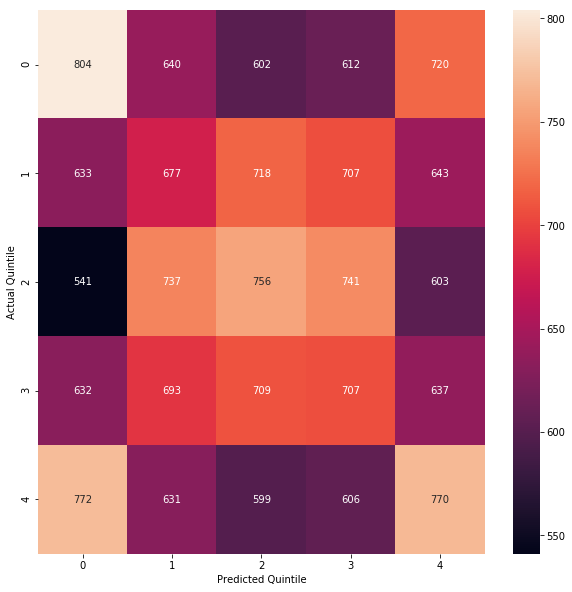

---
19:46:33 Running experiment 133 of 180
(1000, 5, 0.03, 0.6)
................................................................................
19:53:01 Still training step 80 of 563
................................................................................
20:00:57 Still training step 160 of 563
................................................................................
20:10:15 Still training step 240 of 563
................................................................................
20:21:11 Still training step 320 of 563
................................................................................
20:33:31 Still training step 400 of 563
................................................................................
20:47:21 Still training step 480 of 563
................................................................................
21:02:56 Still training step 560 of 563
...
Mean return: 0.309%
Monthly Sharpe ratio: 0.090
Avg rank correlation (Kendall's tau): 

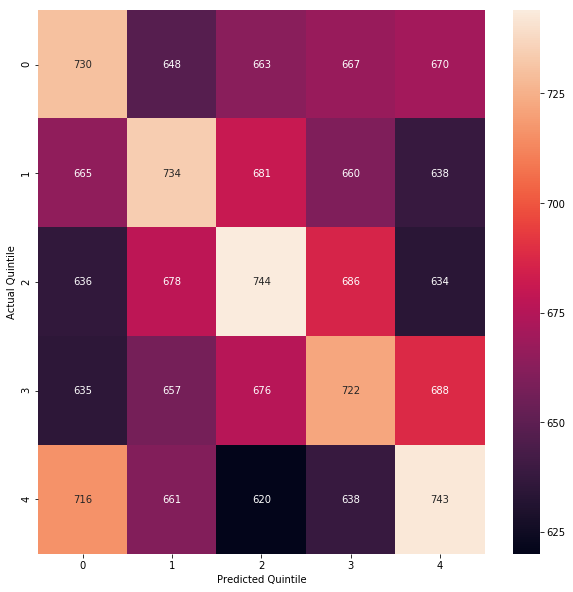

---
21:03:47 Running experiment 134 of 180
(1000, 5, 0.03, 0.65)
................................................................................
21:10:10 Still training step 80 of 563
................................................................................
21:18:02 Still training step 160 of 563
................................................................................
21:27:11 Still training step 240 of 563
................................................................................
21:37:48 Still training step 320 of 563
................................................................................
21:49:50 Still training step 400 of 563
................................................................................
22:03:17 Still training step 480 of 563
................................................................................
22:19:51 Still training step 560 of 563
...
Mean return: -0.032%
Monthly Sharpe ratio: 0.015
Avg rank correlation (Kendall's tau)

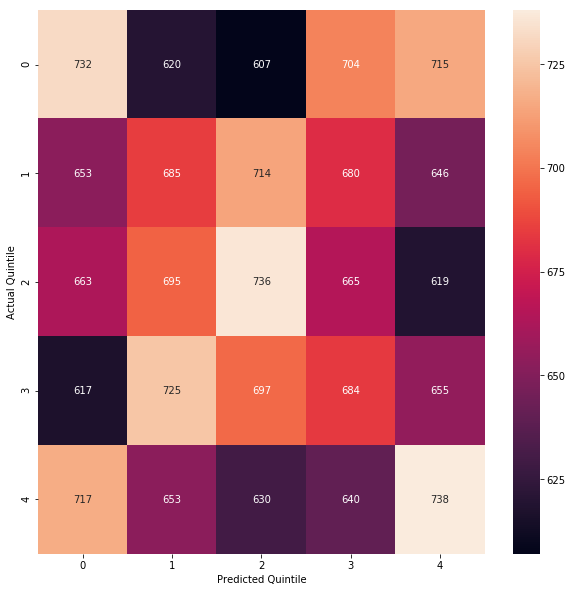

---
22:20:40 Running experiment 135 of 180
(1000, 5, 0.03, 0.7)
................................................................................
22:27:02 Still training step 80 of 563
................................................................................
22:34:51 Still training step 160 of 563
................................................................................
22:43:56 Still training step 240 of 563
................................................................................
22:54:26 Still training step 320 of 563
................................................................................
23:06:28 Still training step 400 of 563
................................................................................
23:19:48 Still training step 480 of 563
................................................................................
23:34:47 Still training step 560 of 563
...
Mean return: 0.616%
Monthly Sharpe ratio: 0.159
Avg rank correlation (Kendall's tau): 

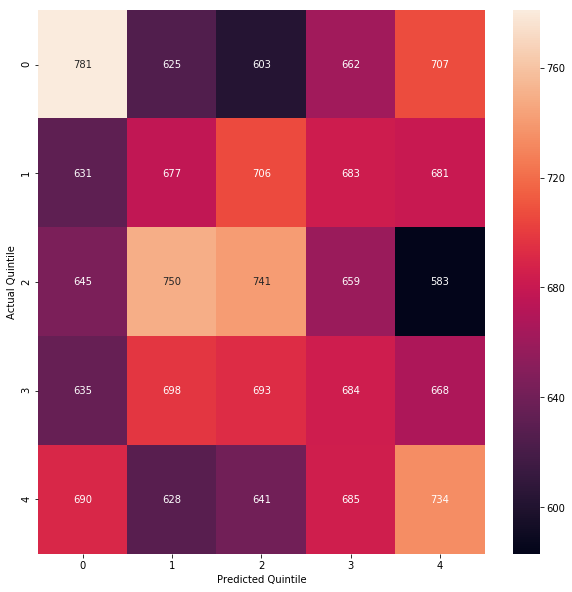

---
23:35:35 Running experiment 136 of 180
(1000, 5, 0.03, 0.75)
................................................................................
23:42:04 Still training step 80 of 563
................................................................................
23:49:50 Still training step 160 of 563
................................................................................
23:58:53 Still training step 240 of 563
................................................................................
00:09:24 Still training step 320 of 563
................................................................................
00:21:13 Still training step 400 of 563
................................................................................
00:34:11 Still training step 480 of 563
................................................................................
00:48:50 Still training step 560 of 563
...
Mean return: 0.855%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau):

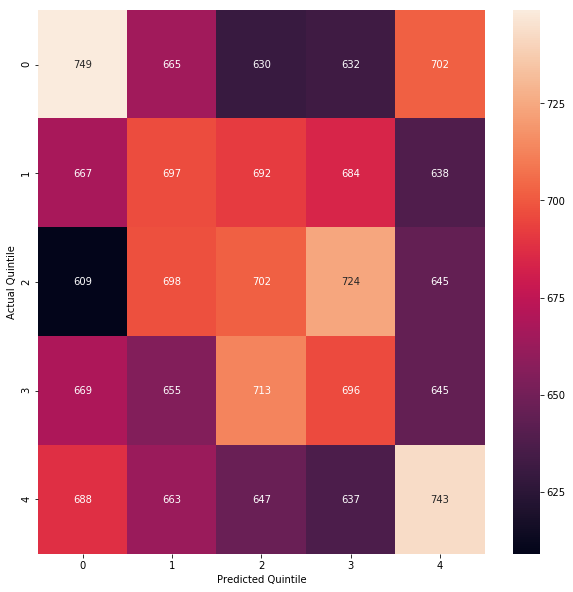

---
00:49:38 Running experiment 137 of 180
(1000, 5, 0.01, 0.6)
................................................................................
00:55:36 Still training step 80 of 563
................................................................................
01:02:35 Still training step 160 of 563
................................................................................
01:10:50 Still training step 240 of 563
................................................................................
01:20:03 Still training step 320 of 563
................................................................................
01:30:16 Still training step 400 of 563
................................................................................
01:41:36 Still training step 480 of 563
................................................................................
01:53:54 Still training step 560 of 563
...
Mean return: 2.088%
Monthly Sharpe ratio: 0.470
Avg rank correlation (Kendall's tau): 

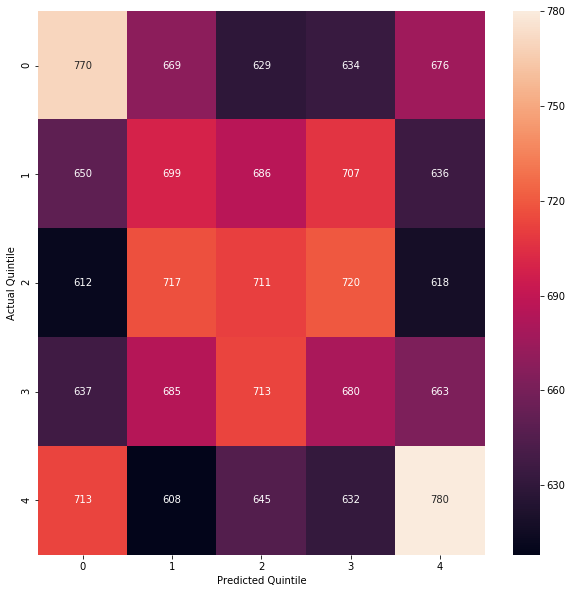

---
01:54:34 Running experiment 138 of 180
(1000, 5, 0.01, 0.65)
................................................................................
02:00:40 Still training step 80 of 563
................................................................................
02:07:49 Still training step 160 of 563
................................................................................
02:15:57 Still training step 240 of 563
................................................................................
02:25:10 Still training step 320 of 563
................................................................................
02:35:25 Still training step 400 of 563
................................................................................
02:46:31 Still training step 480 of 563
................................................................................
02:58:51 Still training step 560 of 563
...
Mean return: 1.774%
Monthly Sharpe ratio: 0.411
Avg rank correlation (Kendall's tau):

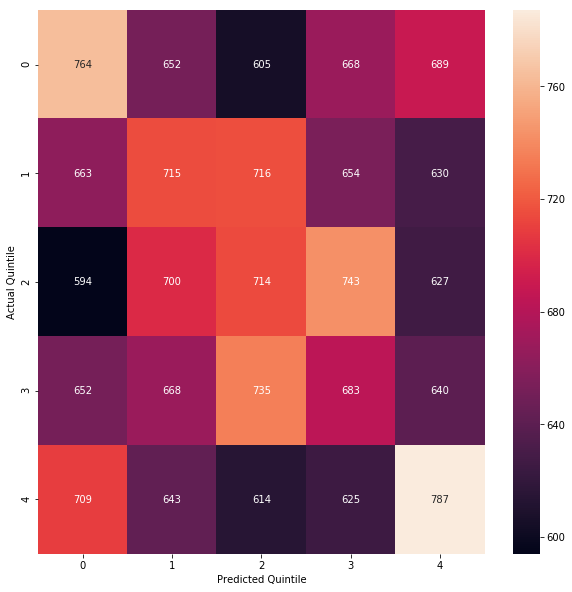

---
02:59:30 Running experiment 139 of 180
(1000, 5, 0.01, 0.7)
................................................................................
03:05:33 Still training step 80 of 563
................................................................................
03:12:34 Still training step 160 of 563
................................................................................
03:20:43 Still training step 240 of 563
................................................................................
03:29:54 Still training step 320 of 563
................................................................................
03:39:59 Still training step 400 of 563
................................................................................
03:50:54 Still training step 480 of 563
................................................................................
04:03:00 Still training step 560 of 563
...
Mean return: 1.390%
Monthly Sharpe ratio: 0.308
Avg rank correlation (Kendall's tau): 

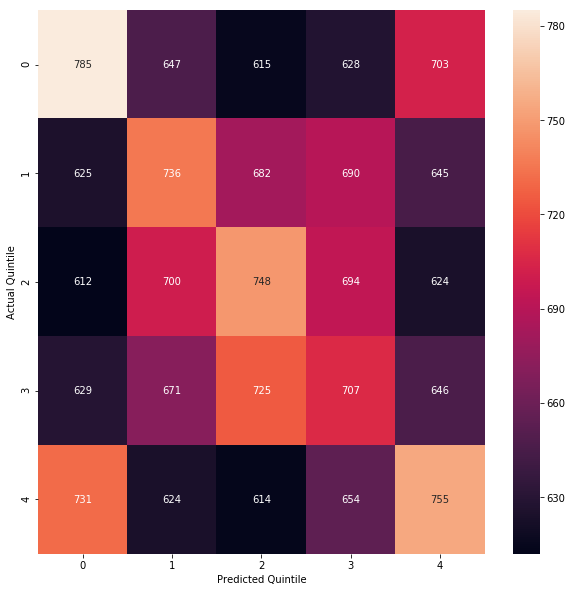

---
04:03:39 Running experiment 140 of 180
(1000, 5, 0.01, 0.75)
................................................................................
04:09:37 Still training step 80 of 563
................................................................................
04:16:35 Still training step 160 of 563
................................................................................
04:24:34 Still training step 240 of 563
................................................................................
04:33:41 Still training step 320 of 563
................................................................................
04:43:51 Still training step 400 of 563
................................................................................
04:54:47 Still training step 480 of 563
................................................................................
05:06:43 Still training step 560 of 563
...
Mean return: 0.469%
Monthly Sharpe ratio: 0.121
Avg rank correlation (Kendall's tau):

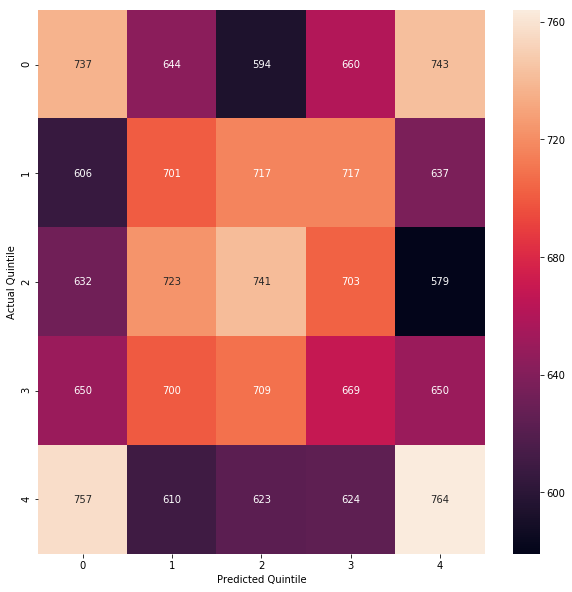

---
05:07:22 Running experiment 141 of 180
(1000, 5, 0.003, 0.6)
................................................................................
05:13:24 Still training step 80 of 563
................................................................................
05:20:14 Still training step 160 of 563
................................................................................
05:27:58 Still training step 240 of 563
................................................................................
05:36:35 Still training step 320 of 563
................................................................................
05:46:05 Still training step 400 of 563
................................................................................
05:56:25 Still training step 480 of 563
................................................................................
06:07:36 Still training step 560 of 563
...
Mean return: 0.669%
Monthly Sharpe ratio: 0.166
Avg rank correlation (Kendall's tau):

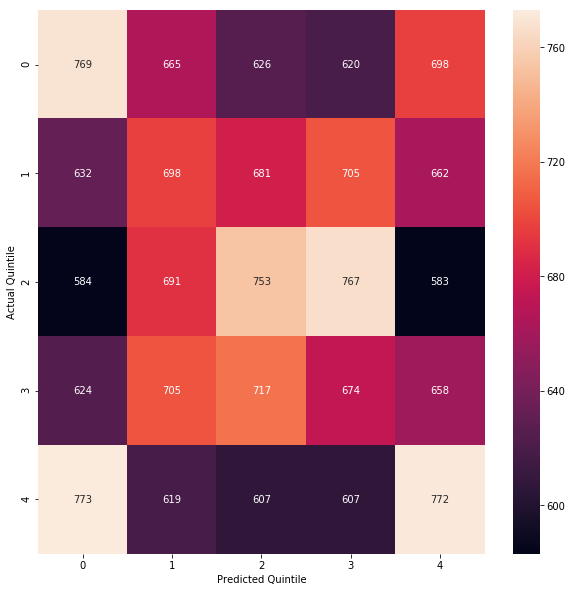

---
06:08:12 Running experiment 142 of 180
(1000, 5, 0.003, 0.65)
................................................................................
06:14:08 Still training step 80 of 563
................................................................................
06:21:04 Still training step 160 of 563
................................................................................
06:28:52 Still training step 240 of 563
................................................................................
06:37:32 Still training step 320 of 563
................................................................................
06:47:13 Still training step 400 of 563
................................................................................
06:57:38 Still training step 480 of 563
................................................................................
07:08:49 Still training step 560 of 563
...
Mean return: 1.546%
Monthly Sharpe ratio: 0.336
Avg rank correlation (Kendall's tau)

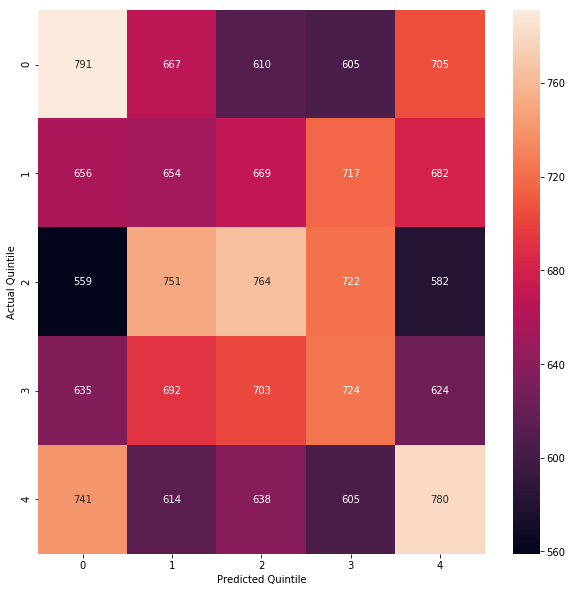

---
07:09:25 Running experiment 143 of 180
(1000, 5, 0.003, 0.7)
................................................................................
07:15:30 Still training step 80 of 563
................................................................................
07:22:24 Still training step 160 of 563
................................................................................
07:30:10 Still training step 240 of 563
................................................................................
07:38:51 Still training step 320 of 563
................................................................................
07:48:30 Still training step 400 of 563
................................................................................
07:58:48 Still training step 480 of 563
................................................................................
08:10:05 Still training step 560 of 563
...
Mean return: 0.233%
Monthly Sharpe ratio: 0.070
Avg rank correlation (Kendall's tau):

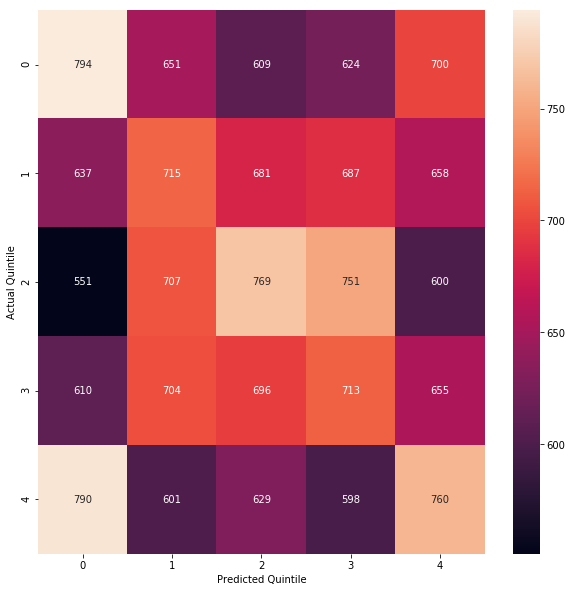

---
08:10:42 Running experiment 144 of 180
(1000, 5, 0.003, 0.75)
................................................................................
08:16:38 Still training step 80 of 563
................................................................................
08:23:26 Still training step 160 of 563
................................................................................
08:31:09 Still training step 240 of 563
................................................................................
08:39:58 Still training step 320 of 563
................................................................................
08:49:34 Still training step 400 of 563
................................................................................
08:59:57 Still training step 480 of 563
................................................................................
09:11:17 Still training step 560 of 563
...
Mean return: 0.657%
Monthly Sharpe ratio: 0.149
Avg rank correlation (Kendall's tau)

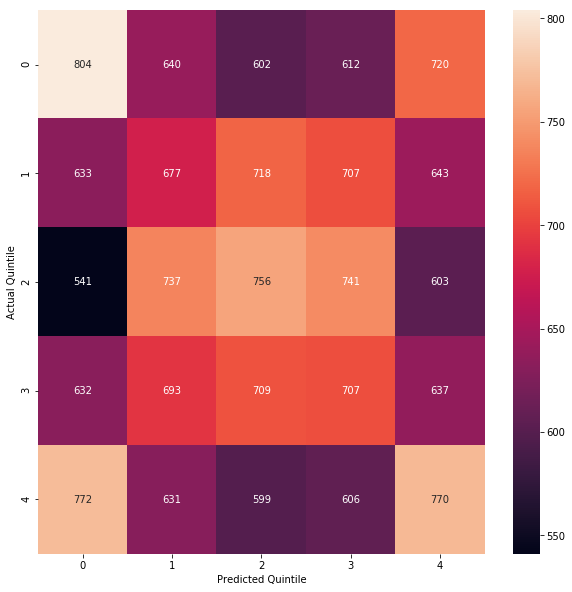

---
09:11:54 Running experiment 145 of 180
(1000, 6, 0.03, 0.6)
................................................................................
09:18:19 Still training step 80 of 563
................................................................................
09:26:10 Still training step 160 of 563
................................................................................
09:35:29 Still training step 240 of 563
................................................................................
09:46:17 Still training step 320 of 563
................................................................................
09:58:37 Still training step 400 of 563
................................................................................
10:12:32 Still training step 480 of 563
................................................................................
10:27:56 Still training step 560 of 563
...
Mean return: 0.308%
Monthly Sharpe ratio: 0.090
Avg rank correlation (Kendall's tau): 

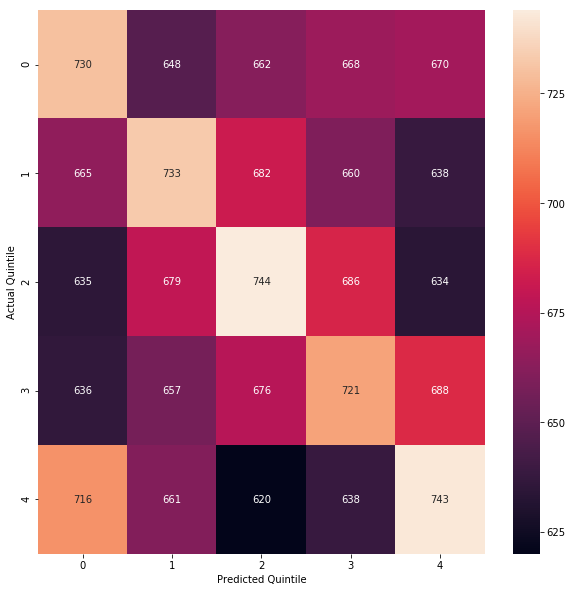

---
10:28:47 Running experiment 146 of 180
(1000, 6, 0.03, 0.65)
................................................................................
10:35:03 Still training step 80 of 563
................................................................................
10:42:53 Still training step 160 of 563
................................................................................
10:52:05 Still training step 240 of 563
................................................................................
11:02:45 Still training step 320 of 563
................................................................................
11:14:55 Still training step 400 of 563
................................................................................
11:28:27 Still training step 480 of 563
................................................................................
11:43:29 Still training step 560 of 563
...
Mean return: -0.045%
Monthly Sharpe ratio: 0.012
Avg rank correlation (Kendall's tau)

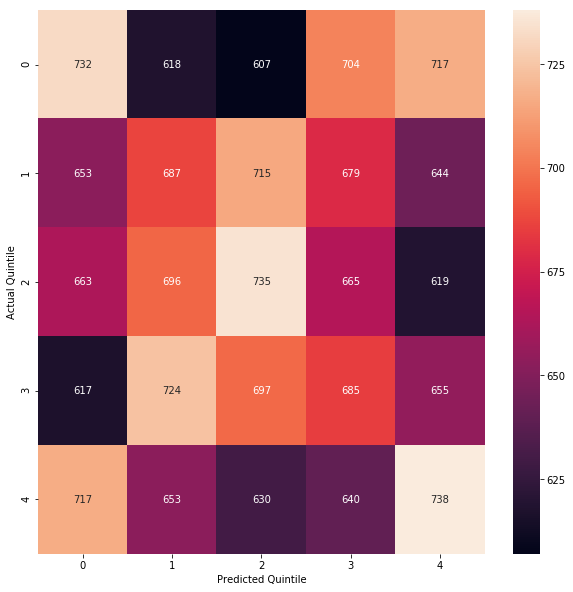

---
11:44:18 Running experiment 147 of 180
(1000, 6, 0.03, 0.7)
................................................................................
11:50:41 Still training step 80 of 563
................................................................................
11:58:31 Still training step 160 of 563
................................................................................
12:07:38 Still training step 240 of 563
................................................................................
12:18:11 Still training step 320 of 563
................................................................................
12:30:11 Still training step 400 of 563
................................................................................
12:43:22 Still training step 480 of 563
................................................................................
12:58:15 Still training step 560 of 563
...
Mean return: 0.616%
Monthly Sharpe ratio: 0.159
Avg rank correlation (Kendall's tau): 

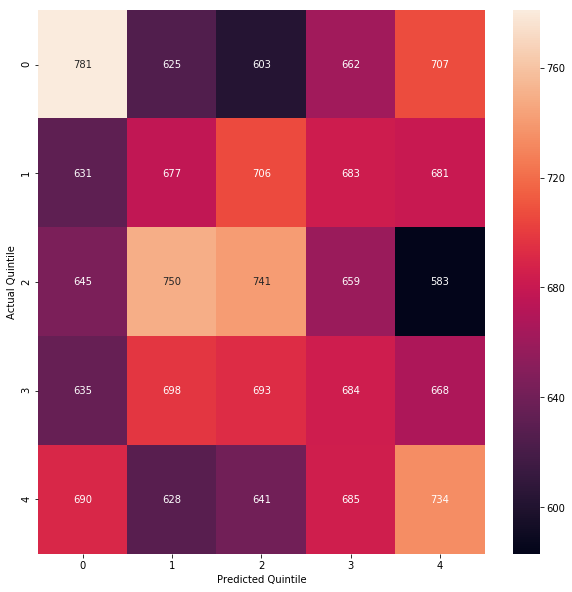

---
12:59:04 Running experiment 148 of 180
(1000, 6, 0.03, 0.75)
................................................................................
13:05:26 Still training step 80 of 563
................................................................................
13:13:04 Still training step 160 of 563
................................................................................
13:22:14 Still training step 240 of 563
................................................................................
13:32:44 Still training step 320 of 563
................................................................................
13:44:37 Still training step 400 of 563
................................................................................
13:57:46 Still training step 480 of 563
................................................................................
14:12:23 Still training step 560 of 563
...
Mean return: 0.855%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau):

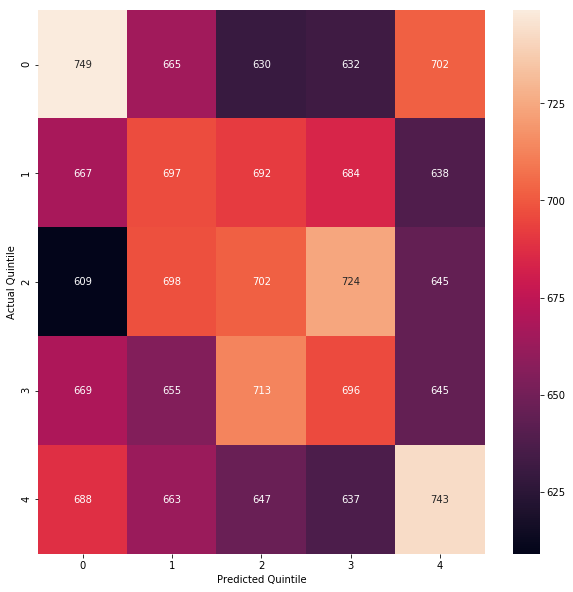

---
14:13:11 Running experiment 149 of 180
(1000, 6, 0.01, 0.6)
................................................................................
14:19:17 Still training step 80 of 563
................................................................................
14:26:21 Still training step 160 of 563
................................................................................
14:34:26 Still training step 240 of 563
................................................................................
14:43:47 Still training step 320 of 563
................................................................................
14:54:05 Still training step 400 of 563
................................................................................
15:05:15 Still training step 480 of 563
................................................................................
15:17:32 Still training step 560 of 563
...
Mean return: 2.088%
Monthly Sharpe ratio: 0.470
Avg rank correlation (Kendall's tau): 

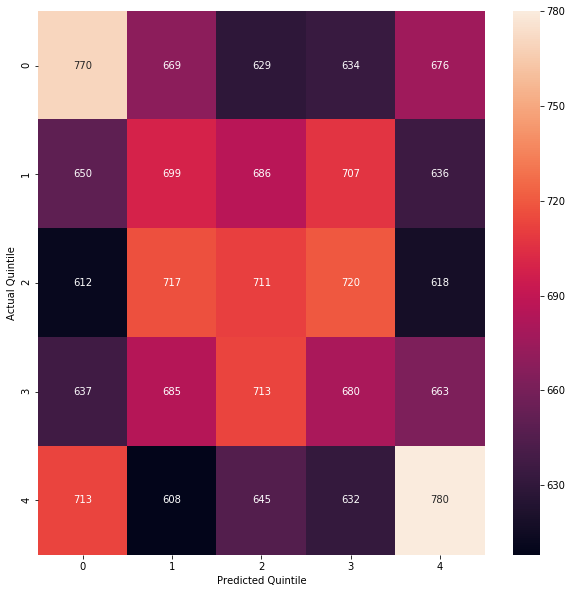

---
15:18:11 Running experiment 150 of 180
(1000, 6, 0.01, 0.65)
................................................................................
15:24:11 Still training step 80 of 563
................................................................................
15:31:20 Still training step 160 of 563
................................................................................
15:39:35 Still training step 240 of 563
................................................................................
15:48:51 Still training step 320 of 563
................................................................................
15:59:05 Still training step 400 of 563
................................................................................
16:10:08 Still training step 480 of 563
................................................................................
16:22:13 Still training step 560 of 563
...
Mean return: 1.774%
Monthly Sharpe ratio: 0.411
Avg rank correlation (Kendall's tau):

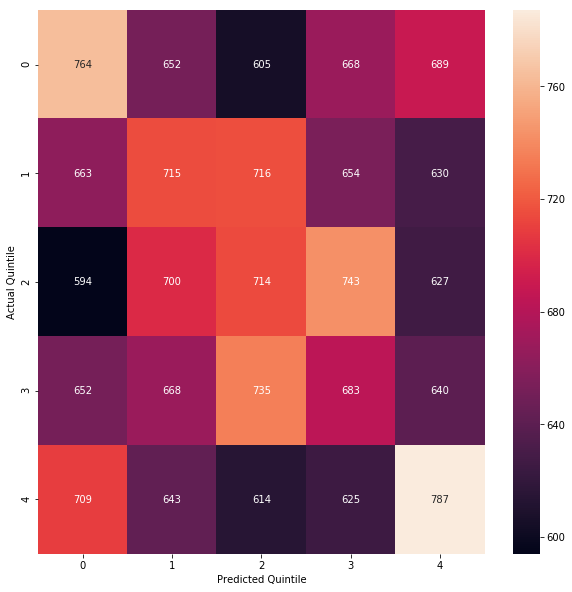

---
16:22:52 Running experiment 151 of 180
(1000, 6, 0.01, 0.7)
................................................................................
16:28:49 Still training step 80 of 563
................................................................................
16:35:47 Still training step 160 of 563
................................................................................
16:43:49 Still training step 240 of 563
................................................................................
16:52:54 Still training step 320 of 563
................................................................................
17:02:54 Still training step 400 of 563
................................................................................
17:13:48 Still training step 480 of 563
................................................................................
17:25:54 Still training step 560 of 563
...
Mean return: 1.390%
Monthly Sharpe ratio: 0.308
Avg rank correlation (Kendall's tau): 

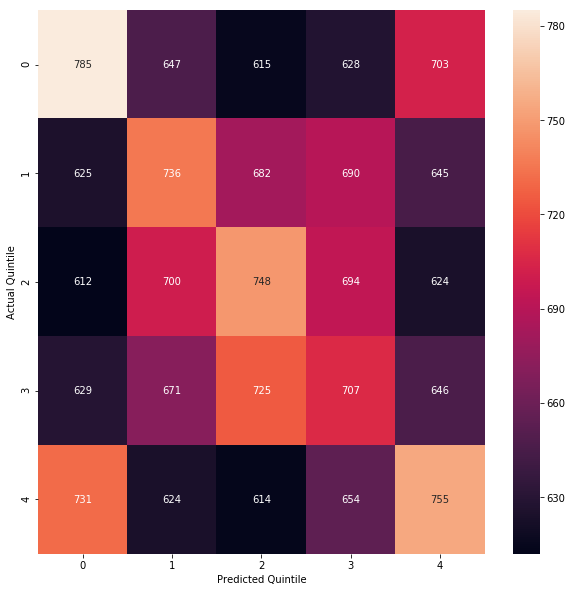

---
17:26:34 Running experiment 152 of 180
(1000, 6, 0.01, 0.75)
................................................................................
17:32:43 Still training step 80 of 563
................................................................................
17:39:52 Still training step 160 of 563
................................................................................
17:48:00 Still training step 240 of 563
................................................................................
17:57:09 Still training step 320 of 563
................................................................................
18:07:11 Still training step 400 of 563
................................................................................
18:18:04 Still training step 480 of 563
................................................................................
18:30:08 Still training step 560 of 563
...
Mean return: 0.469%
Monthly Sharpe ratio: 0.121
Avg rank correlation (Kendall's tau):

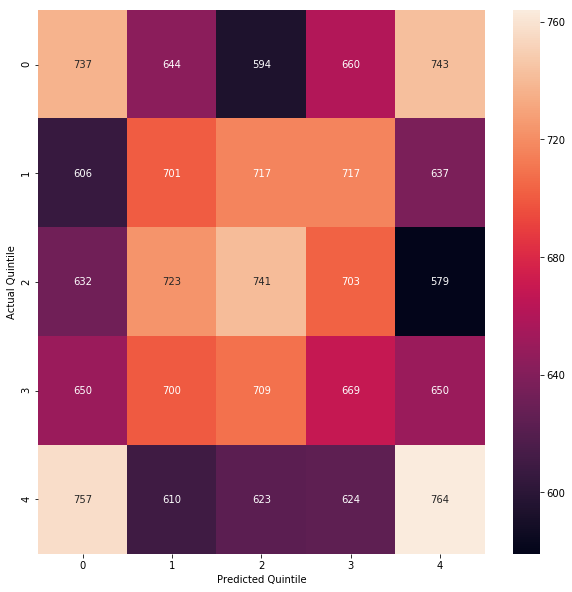

---
18:30:47 Running experiment 153 of 180
(1000, 6, 0.003, 0.6)
................................................................................
18:36:34 Still training step 80 of 563
................................................................................
18:43:18 Still training step 160 of 563
................................................................................
18:50:57 Still training step 240 of 563
................................................................................
19:00:12 Still training step 320 of 563
................................................................................
19:10:00 Still training step 400 of 563
................................................................................
19:20:24 Still training step 480 of 563
................................................................................
19:31:42 Still training step 560 of 563
...
Mean return: 0.669%
Monthly Sharpe ratio: 0.166
Avg rank correlation (Kendall's tau):

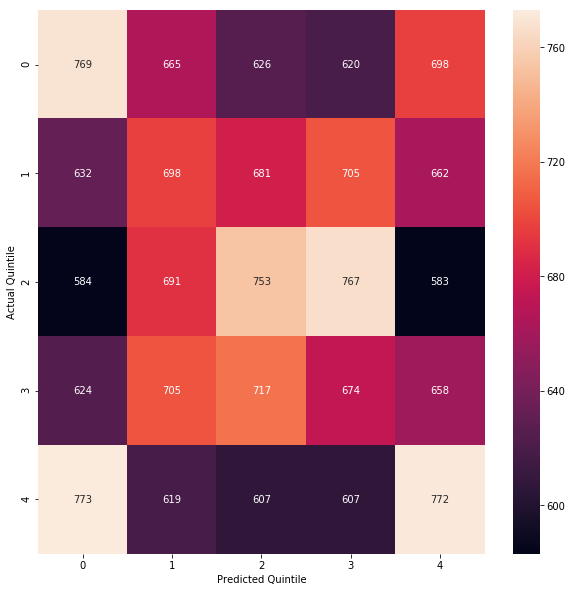

---
19:32:18 Running experiment 154 of 180
(1000, 6, 0.003, 0.65)
................................................................................
19:38:14 Still training step 80 of 563
................................................................................
19:45:05 Still training step 160 of 563
................................................................................
19:52:51 Still training step 240 of 563
................................................................................
20:01:31 Still training step 320 of 563
................................................................................
20:11:04 Still training step 400 of 563
................................................................................
20:21:21 Still training step 480 of 563
................................................................................
20:32:29 Still training step 560 of 563
...
Mean return: 1.546%
Monthly Sharpe ratio: 0.336
Avg rank correlation (Kendall's tau)

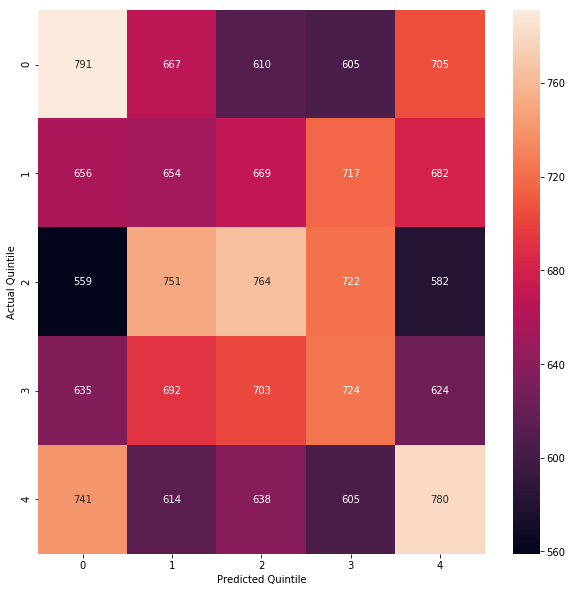

---
20:33:05 Running experiment 155 of 180
(1000, 6, 0.003, 0.7)
................................................................................
20:38:53 Still training step 80 of 563
................................................................................
20:45:37 Still training step 160 of 563
................................................................................
20:53:17 Still training step 240 of 563
................................................................................
21:01:53 Still training step 320 of 563
................................................................................
21:11:31 Still training step 400 of 563
................................................................................
21:21:54 Still training step 480 of 563
................................................................................
21:33:13 Still training step 560 of 563
...
Mean return: 0.233%
Monthly Sharpe ratio: 0.070
Avg rank correlation (Kendall's tau):

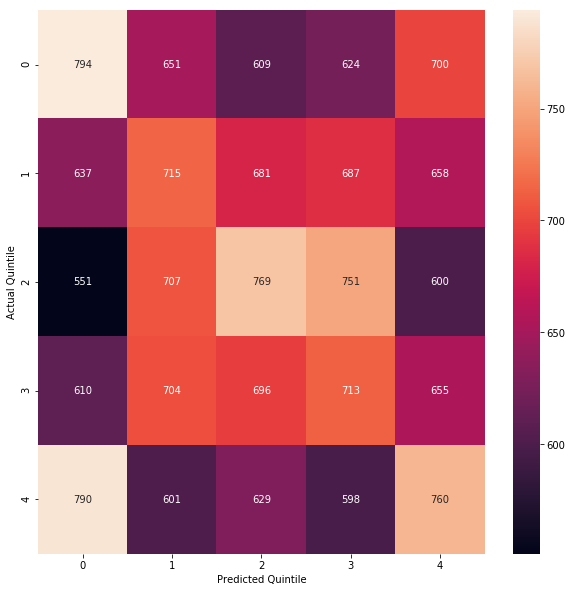

---
21:33:50 Running experiment 156 of 180
(1000, 6, 0.003, 0.75)
................................................................................
21:39:43 Still training step 80 of 563
................................................................................
21:46:31 Still training step 160 of 563
................................................................................
21:54:14 Still training step 240 of 563
................................................................................
22:02:52 Still training step 320 of 563
................................................................................
22:12:23 Still training step 400 of 563
................................................................................
22:22:39 Still training step 480 of 563
................................................................................
22:33:49 Still training step 560 of 563
...
Mean return: 0.657%
Monthly Sharpe ratio: 0.149
Avg rank correlation (Kendall's tau)

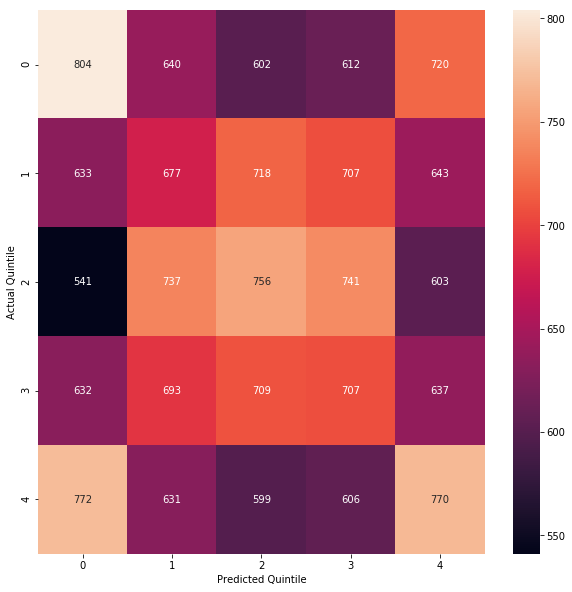

---
22:34:26 Running experiment 157 of 180
(1000, 7, 0.03, 0.6)
................................................................................
22:40:45 Still training step 80 of 563
................................................................................
22:48:28 Still training step 160 of 563
..................................................................
22:57:51 Still training step 240 of 563
................................................................................
23:08:53 Still training step 320 of 563
.......................................................................
23:21:16 Still training step 400 of 563
................................................................................
23:35:03 Still training step 480 of 563
................................................................................
23:50:40 Still training step 560 of 563
...
Mean return: 0.308%
Monthly Sharpe ratio: 0.090
Avg rank correlation (Kendall's tau): 0.0112 (Expected: 0)
5-

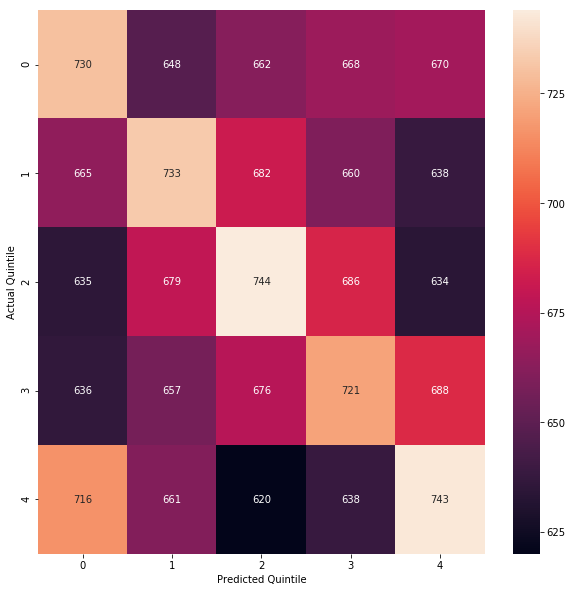

---
23:51:32 Running experiment 158 of 180
(1000, 7, 0.03, 0.65)
................................................................................
23:57:55 Still training step 80 of 563
................................................................................
00:05:39 Still training step 160 of 563
................................................................................
00:14:47 Still training step 240 of 563
................................................................................
00:25:26 Still training step 320 of 563
................................................................................
00:38:04 Still training step 400 of 563
................................................................................
00:51:40 Still training step 480 of 563
................................................................................
01:06:49 Still training step 560 of 563
...
Mean return: -0.045%
Monthly Sharpe ratio: 0.012
Avg rank correlation (Kendall's tau)

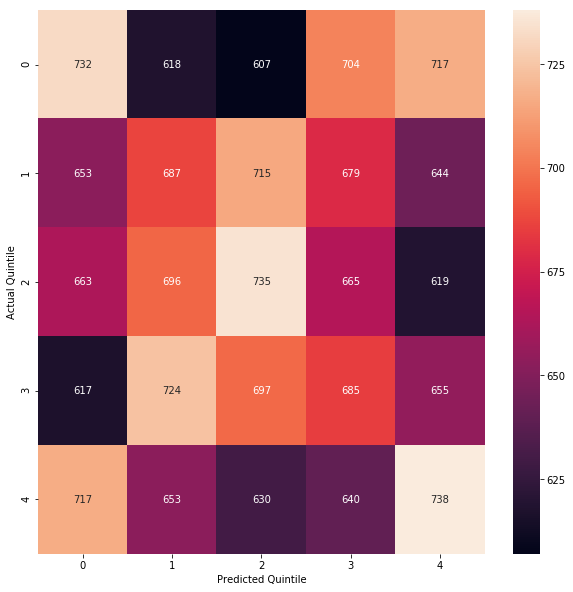

---
01:07:39 Running experiment 159 of 180
(1000, 7, 0.03, 0.7)
................................................................................
01:14:02 Still training step 80 of 563
................................................................................
01:21:45 Still training step 160 of 563
................................................................................
01:30:50 Still training step 240 of 563
................................................................................
01:41:30 Still training step 320 of 563
................................................................................
01:53:28 Still training step 400 of 563
................................................................................
02:06:49 Still training step 480 of 563
................................................................................
02:21:44 Still training step 560 of 563
...
Mean return: 0.616%
Monthly Sharpe ratio: 0.159
Avg rank correlation (Kendall's tau): 

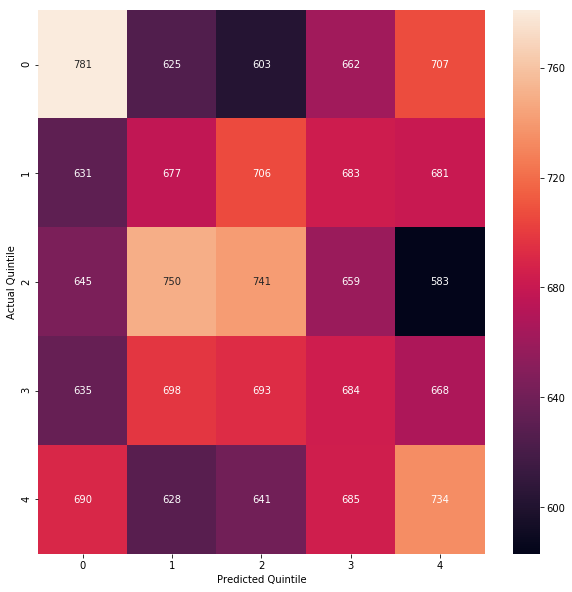

---
02:22:33 Running experiment 160 of 180
(1000, 7, 0.03, 0.75)
................................................................................
02:28:59 Still training step 80 of 563
................................................................................
02:36:43 Still training step 160 of 563
................................................................................
02:45:47 Still training step 240 of 563
................................................................................
02:56:15 Still training step 320 of 563
................................................................................
03:08:06 Still training step 400 of 563
................................................................................
03:21:09 Still training step 480 of 563
................................................................................
03:35:46 Still training step 560 of 563
...
Mean return: 0.855%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau):

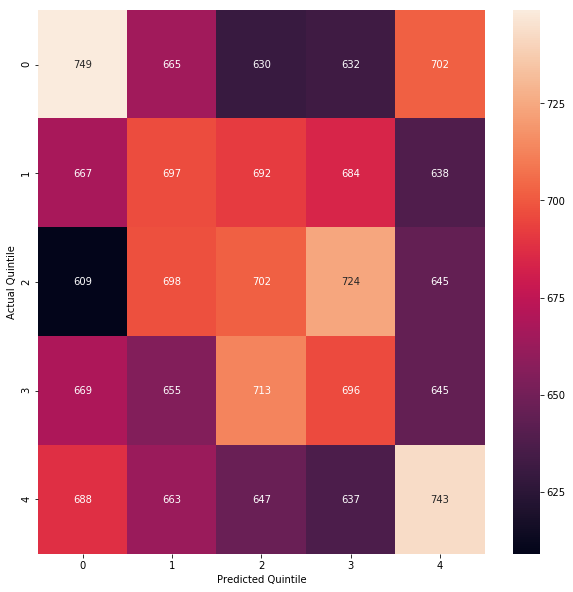

---
03:36:35 Running experiment 161 of 180
(1000, 7, 0.01, 0.6)
................................................................................
03:42:44 Still training step 80 of 563
................................................................................
03:49:54 Still training step 160 of 563
................................................................................
03:58:05 Still training step 240 of 563
................................................................................
04:07:19 Still training step 320 of 563
................................................................................
04:17:34 Still training step 400 of 563
................................................................................
04:28:39 Still training step 480 of 563
................................................................................
04:40:48 Still training step 560 of 563
...
Mean return: 2.088%
Monthly Sharpe ratio: 0.470
Avg rank correlation (Kendall's tau): 

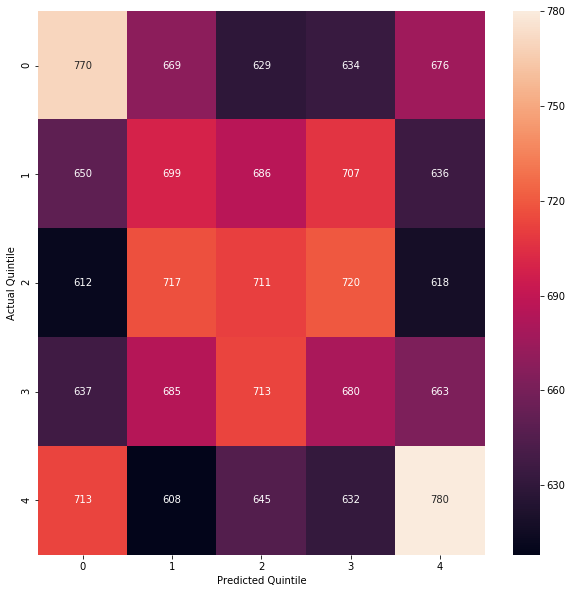

---
04:41:28 Running experiment 162 of 180
(1000, 7, 0.01, 0.65)
................................................................................
04:47:24 Still training step 80 of 563
................................................................................
04:54:23 Still training step 160 of 563
................................................................................
05:02:25 Still training step 240 of 563
................................................................................
05:11:50 Still training step 320 of 563
................................................................................
05:22:07 Still training step 400 of 563
................................................................................
05:33:15 Still training step 480 of 563
................................................................................
05:45:28 Still training step 560 of 563
...
Mean return: 1.774%
Monthly Sharpe ratio: 0.411
Avg rank correlation (Kendall's tau):

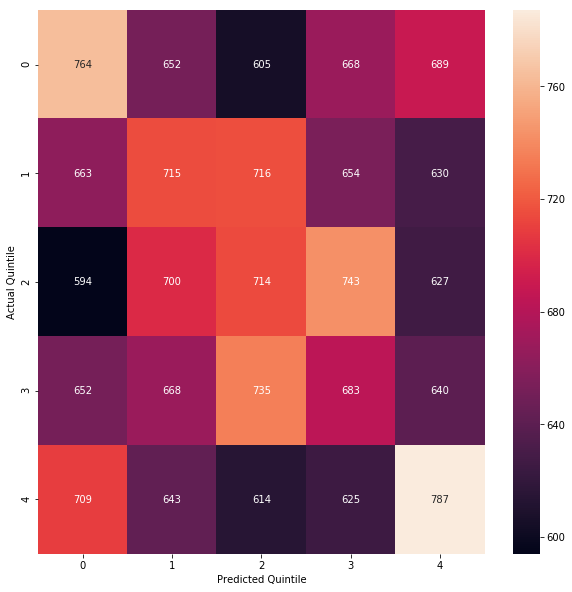

---
05:46:08 Running experiment 163 of 180
(1000, 7, 0.01, 0.7)
................................................................................
05:52:09 Still training step 80 of 563
................................................................................
05:59:12 Still training step 160 of 563
................................................................................
06:07:18 Still training step 240 of 563
................................................................................
06:16:39 Still training step 320 of 563
................................................................................
06:26:41 Still training step 400 of 563
................................................................................
06:37:51 Still training step 480 of 563
................................................................................
06:50:04 Still training step 560 of 563
...
Mean return: 1.390%
Monthly Sharpe ratio: 0.308
Avg rank correlation (Kendall's tau): 

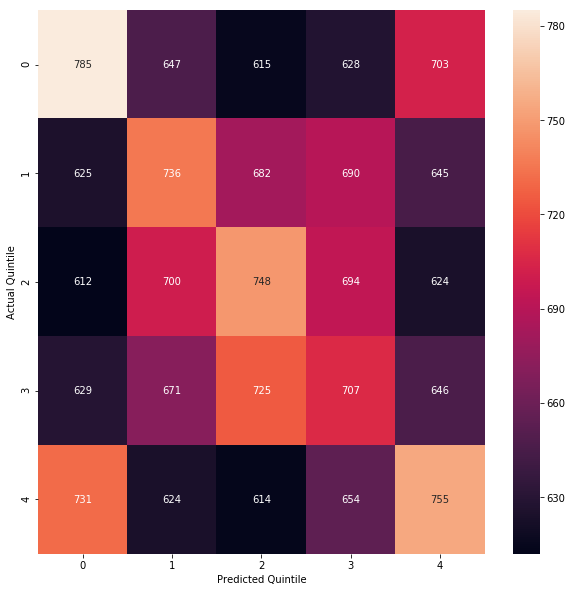

---
06:50:44 Running experiment 164 of 180
(1000, 7, 0.01, 0.75)
................................................................................
06:56:49 Still training step 80 of 563
................................................................................
07:03:56 Still training step 160 of 563
................................................................................
07:12:02 Still training step 240 of 563
................................................................................
07:21:12 Still training step 320 of 563
................................................................................
07:31:18 Still training step 400 of 563
................................................................................
07:42:22 Still training step 480 of 563
................................................................................
07:54:27 Still training step 560 of 563
...
Mean return: 0.469%
Monthly Sharpe ratio: 0.121
Avg rank correlation (Kendall's tau):

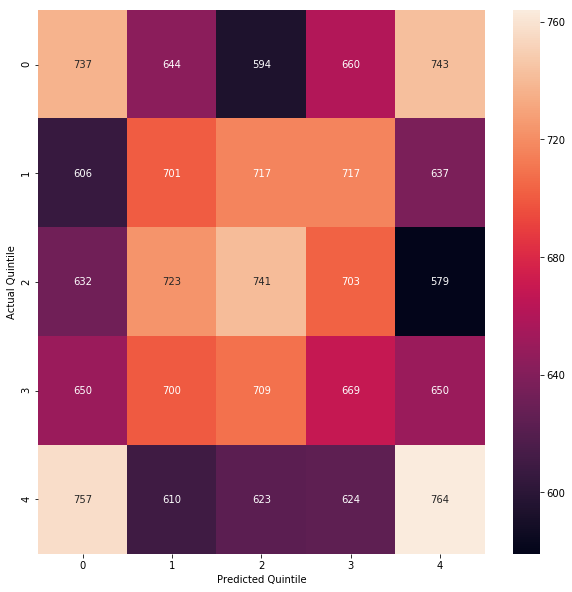

---
07:55:06 Running experiment 165 of 180
(1000, 7, 0.003, 0.6)
................................................................................
08:01:12 Still training step 80 of 563
................................................................................
08:08:13 Still training step 160 of 563
................................................................................
08:16:07 Still training step 240 of 563
................................................................................
08:24:56 Still training step 320 of 563
................................................................................
08:34:29 Still training step 400 of 563
................................................................................
08:44:46 Still training step 480 of 563
................................................................................
08:55:59 Still training step 560 of 563
...
Mean return: 0.669%
Monthly Sharpe ratio: 0.166
Avg rank correlation (Kendall's tau):

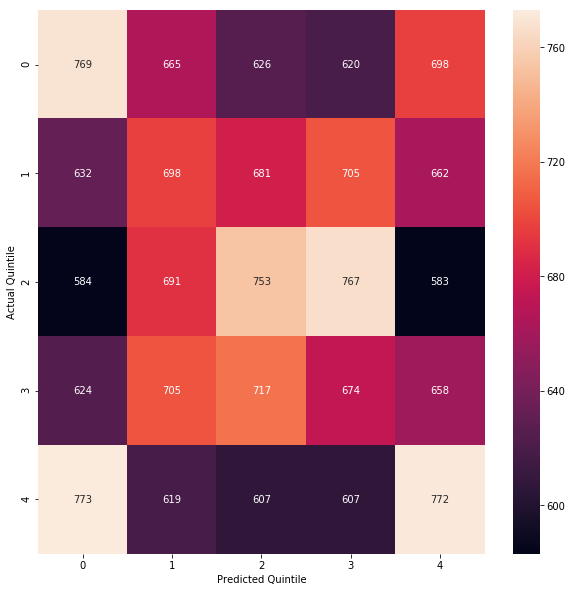

---
08:56:35 Running experiment 166 of 180
(1000, 7, 0.003, 0.65)
................................................................................
09:02:27 Still training step 80 of 563
................................................................................
09:09:14 Still training step 160 of 563
................................................................................
09:16:57 Still training step 240 of 563
................................................................................
09:25:41 Still training step 320 of 563
................................................................................
09:35:23 Still training step 400 of 563
................................................................................
09:45:48 Still training step 480 of 563
................................................................................
09:57:05 Still training step 560 of 563
...
Mean return: 1.546%
Monthly Sharpe ratio: 0.336
Avg rank correlation (Kendall's tau)

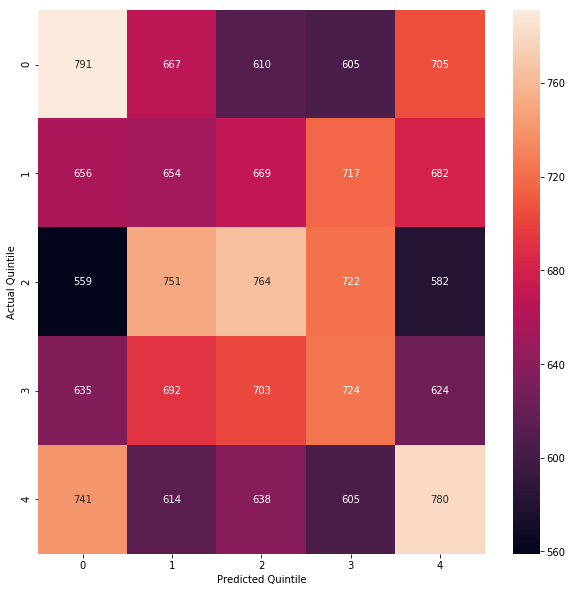

---
09:57:42 Running experiment 167 of 180
(1000, 7, 0.003, 0.7)
................................................................................
10:03:37 Still training step 80 of 563
................................................................................
10:10:28 Still training step 160 of 563
................................................................................
10:18:14 Still training step 240 of 563
................................................................................
10:26:56 Still training step 320 of 563
................................................................................
10:36:23 Still training step 400 of 563
................................................................................
10:46:36 Still training step 480 of 563
................................................................................
10:57:53 Still training step 560 of 563
...
Mean return: 0.233%
Monthly Sharpe ratio: 0.070
Avg rank correlation (Kendall's tau):

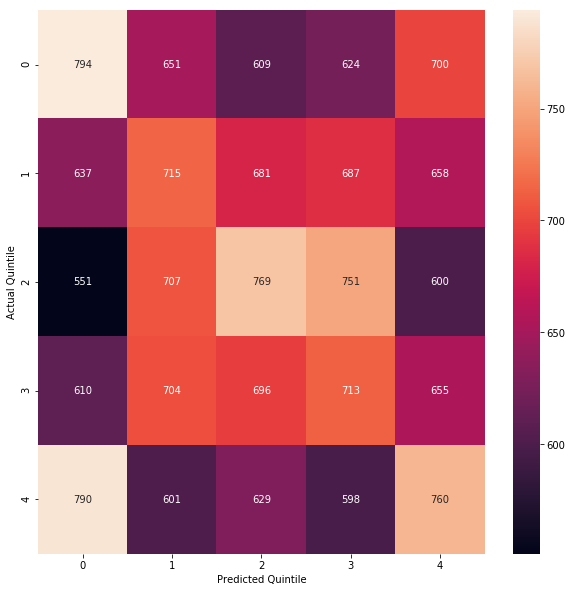

---
10:58:30 Running experiment 168 of 180
(1000, 7, 0.003, 0.75)
................................................................................
11:04:30 Still training step 80 of 563
................................................................................
11:11:23 Still training step 160 of 563
................................................................................
11:19:08 Still training step 240 of 563
................................................................................
11:27:48 Still training step 320 of 563
................................................................................
11:37:19 Still training step 400 of 563
................................................................................
11:47:31 Still training step 480 of 563
................................................................................
11:58:41 Still training step 560 of 563
...
Mean return: 0.657%
Monthly Sharpe ratio: 0.149
Avg rank correlation (Kendall's tau)

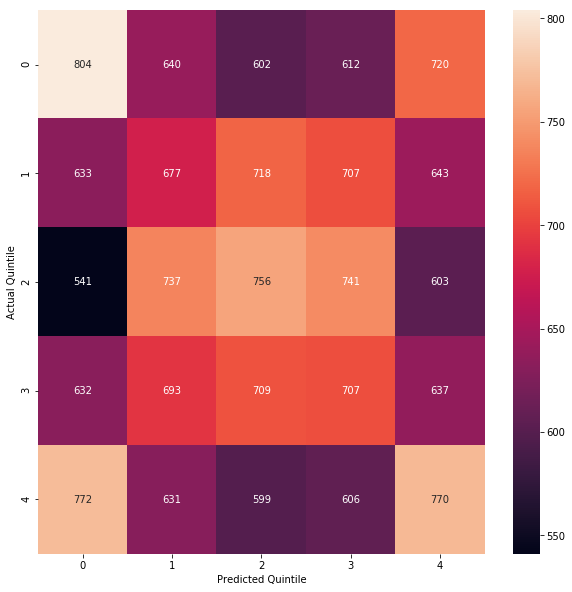

---
11:59:17 Running experiment 169 of 180
(1000, 8, 0.03, 0.6)
................................................................................
12:05:38 Still training step 80 of 563
................................................................................
12:13:21 Still training step 160 of 563
................................................................................
12:22:33 Still training step 240 of 563
................................................................................
12:33:18 Still training step 320 of 563
................................................................................
12:45:40 Still training step 400 of 563
................................................................................
12:59:34 Still training step 480 of 563
................................................................................
13:15:05 Still training step 560 of 563
...
Mean return: 0.308%
Monthly Sharpe ratio: 0.090
Avg rank correlation (Kendall's tau): 

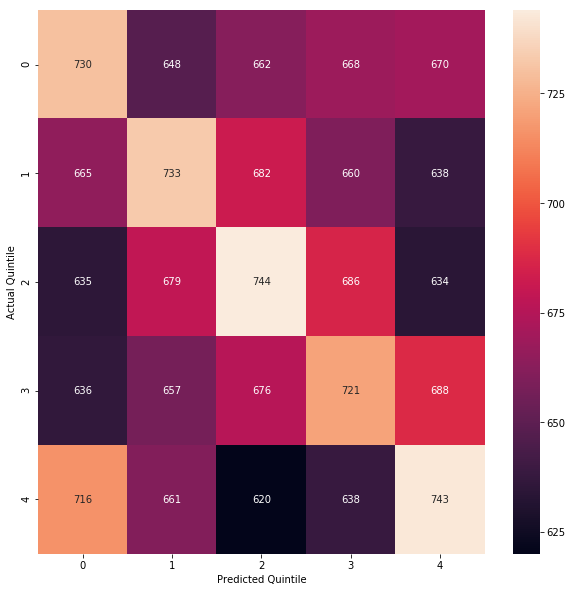

---
13:15:56 Running experiment 170 of 180
(1000, 8, 0.03, 0.65)
................................................................................
13:22:20 Still training step 80 of 563
................................................................................
13:30:05 Still training step 160 of 563
................................................................................
13:39:15 Still training step 240 of 563
................................................................................
13:49:54 Still training step 320 of 563
....................................................................
14:01:53 Still training step 400 of 563
................................................................................
14:15:13 Still training step 480 of 563
................................................................................
14:30:13 Still training step 560 of 563
...
Mean return: -0.045%
Monthly Sharpe ratio: 0.012
Avg rank correlation (Kendall's tau): 0.0010 (Ex

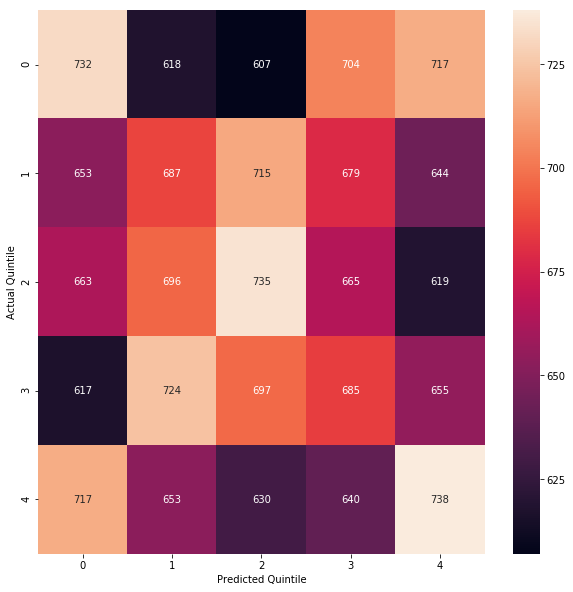

---
14:31:02 Running experiment 171 of 180
(1000, 8, 0.03, 0.7)
................................................................................
14:37:27 Still training step 80 of 563
................................................................................
14:45:20 Still training step 160 of 563
................................................................................
14:54:32 Still training step 240 of 563
................................................................................
15:05:10 Still training step 320 of 563
................................................................................
15:17:01 Still training step 400 of 563
................................................................................
15:30:10 Still training step 480 of 563
................................................................................
15:44:54 Still training step 560 of 563
...
Mean return: 0.616%
Monthly Sharpe ratio: 0.159
Avg rank correlation (Kendall's tau): 

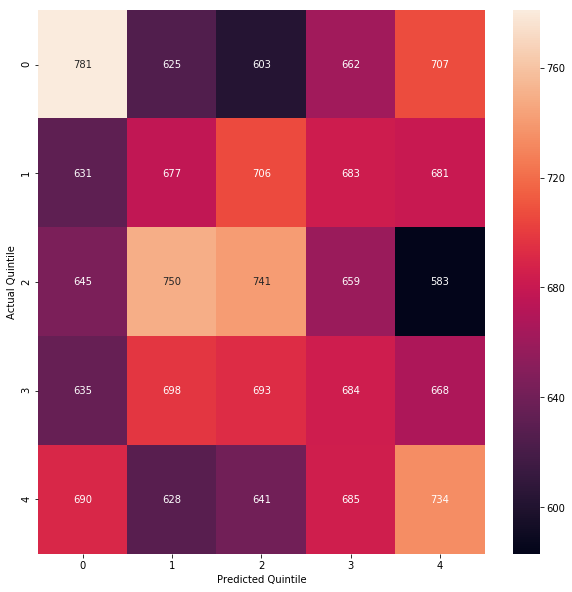

---
15:45:42 Running experiment 172 of 180
(1000, 8, 0.03, 0.75)
................................................................................
15:52:00 Still training step 80 of 563
................................................................................
15:59:36 Still training step 160 of 563
................................................................................
16:08:34 Still training step 240 of 563
................................................................................
16:18:57 Still training step 320 of 563
................................................................................
16:30:53 Still training step 400 of 563
................................................................................
16:44:01 Still training step 480 of 563
................................................................................
16:58:36 Still training step 560 of 563
...
Mean return: 0.855%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau):

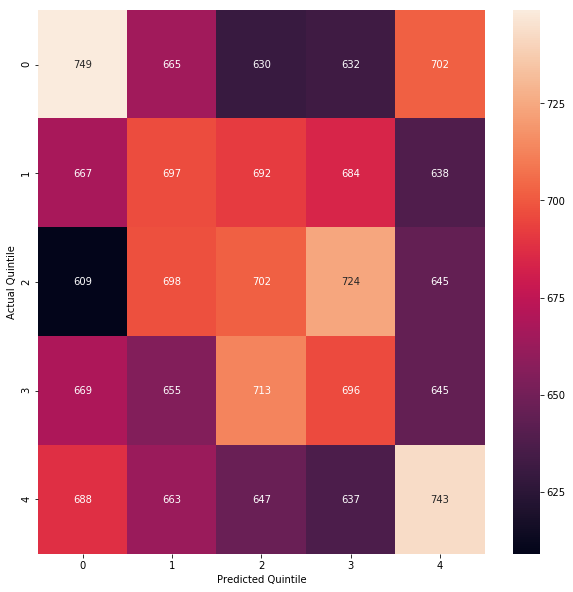

---
16:59:23 Running experiment 173 of 180
(1000, 8, 0.01, 0.6)
................................................................................
17:05:23 Still training step 80 of 563
................................................................................
17:12:24 Still training step 160 of 563
................................................................................
17:20:28 Still training step 240 of 563
................................................................................
17:29:36 Still training step 320 of 563
................................................................................
17:39:40 Still training step 400 of 563
................................................................................
17:50:38 Still training step 480 of 563
................................................................................
18:02:43 Still training step 560 of 563
...
Mean return: 2.088%
Monthly Sharpe ratio: 0.470
Avg rank correlation (Kendall's tau): 

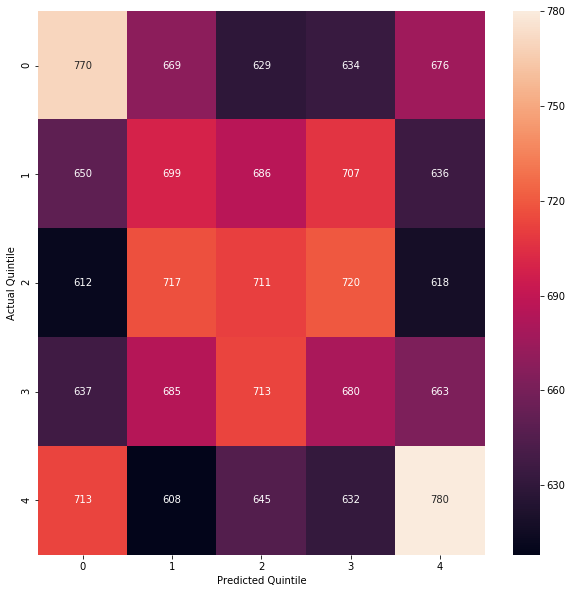

---
18:03:22 Running experiment 174 of 180
(1000, 8, 0.01, 0.65)
................................................................................
18:09:15 Still training step 80 of 563
................................................................................
18:16:17 Still training step 160 of 563
................................................................................
18:24:36 Still training step 240 of 563
................................................................................
18:33:54 Still training step 320 of 563
................................................................................
18:44:12 Still training step 400 of 563
................................................................................
18:55:18 Still training step 480 of 563
................................................................................
19:07:26 Still training step 560 of 563
...
Mean return: 1.774%
Monthly Sharpe ratio: 0.411
Avg rank correlation (Kendall's tau):

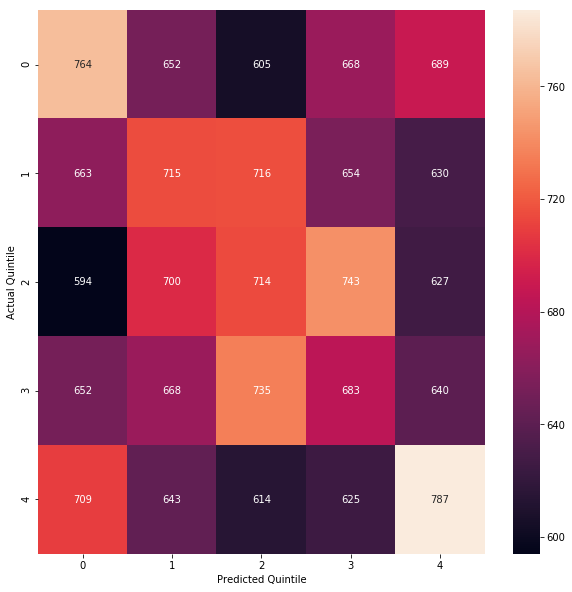

---
19:08:06 Running experiment 175 of 180
(1000, 8, 0.01, 0.7)
................................................................................
19:14:04 Still training step 80 of 563
................................................................................
19:21:04 Still training step 160 of 563
................................................................................
19:29:07 Still training step 240 of 563
................................................................................
19:38:14 Still training step 320 of 563
................................................................................
19:48:24 Still training step 400 of 563
................................................................................
19:59:38 Still training step 480 of 563
................................................................................
20:11:49 Still training step 560 of 563
...
Mean return: 1.390%
Monthly Sharpe ratio: 0.308
Avg rank correlation (Kendall's tau): 

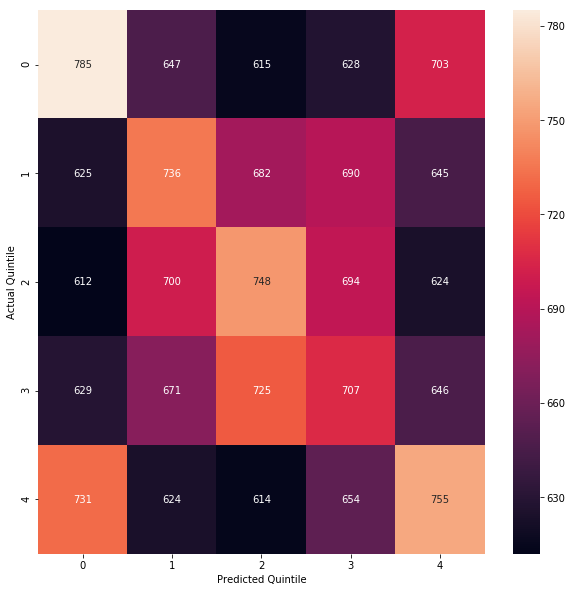

---
20:12:28 Running experiment 176 of 180
(1000, 8, 0.01, 0.75)
................................................................................
20:18:32 Still training step 80 of 563
................................................................................
20:25:36 Still training step 160 of 563
................................................................................
20:33:42 Still training step 240 of 563
................................................................................
20:42:51 Still training step 320 of 563
................................................................................
20:52:59 Still training step 400 of 563
................................................................................
21:03:55 Still training step 480 of 563
................................................................................
21:15:53 Still training step 560 of 563
...
Mean return: 0.469%
Monthly Sharpe ratio: 0.121
Avg rank correlation (Kendall's tau):

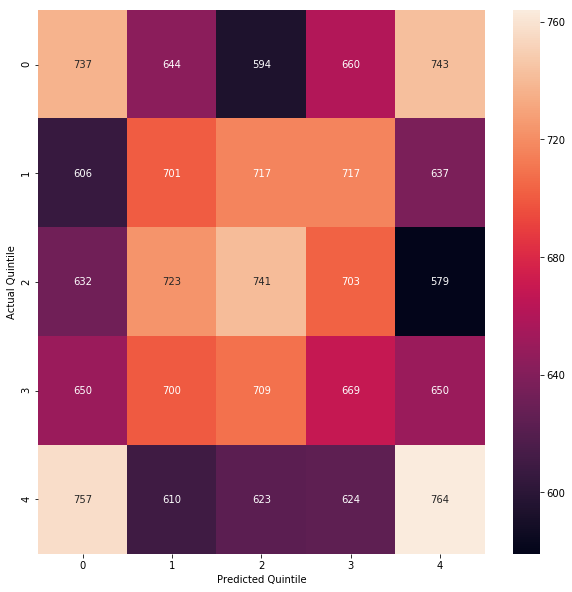

---
21:16:32 Running experiment 177 of 180
(1000, 8, 0.003, 0.6)
................................................................................
21:22:26 Still training step 80 of 563
................................................................................
21:29:25 Still training step 160 of 563
................................................................................
21:37:19 Still training step 240 of 563
................................................................................
21:46:07 Still training step 320 of 563
................................................................................
21:55:39 Still training step 400 of 563
................................................................................
22:05:54 Still training step 480 of 563
................................................................................
22:17:04 Still training step 560 of 563
...
Mean return: 0.669%
Monthly Sharpe ratio: 0.166
Avg rank correlation (Kendall's tau):

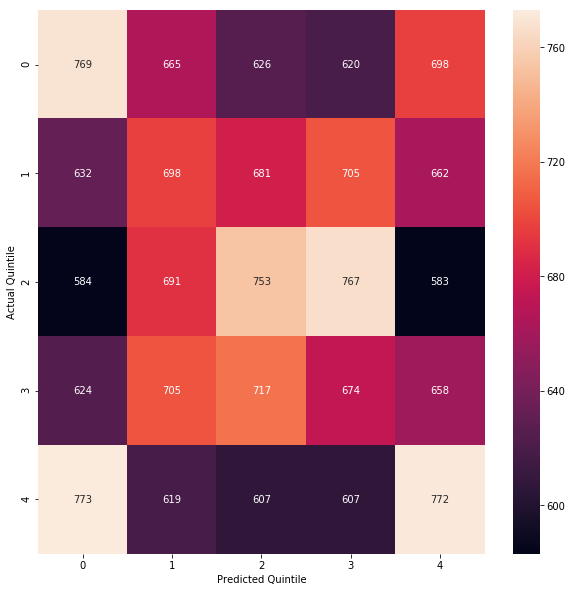

---
22:17:41 Running experiment 178 of 180
(1000, 8, 0.003, 0.65)
................................................................................
22:23:31 Still training step 80 of 563
................................................................................
22:30:17 Still training step 160 of 563
................................................................................
22:38:00 Still training step 240 of 563
................................................................................
22:46:38 Still training step 320 of 563
................................................................................
22:56:14 Still training step 400 of 563
................................................................................
23:06:43 Still training step 480 of 563
................................................................................
23:18:03 Still training step 560 of 563
...
Mean return: 1.546%
Monthly Sharpe ratio: 0.336
Avg rank correlation (Kendall's tau)

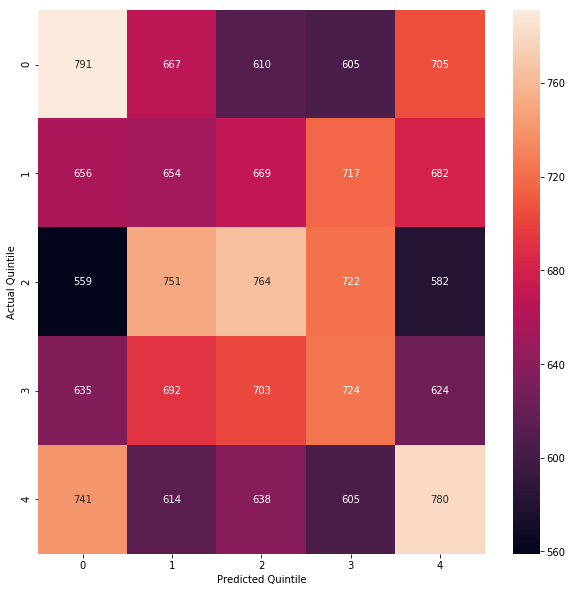

---
23:18:39 Running experiment 179 of 180
(1000, 8, 0.003, 0.7)
................................................................................
23:24:36 Still training step 80 of 563
................................................................................
23:31:27 Still training step 160 of 563
................................................................................
23:39:13 Still training step 240 of 563
................................................................................
23:47:55 Still training step 320 of 563
................................................................................
23:57:29 Still training step 400 of 563
................................................................................
00:07:44 Still training step 480 of 563
.....................................................................---
00:19:28 Running experiment 180 of 180
(1000, 8, 0.003, 0.75)
...........................................................................

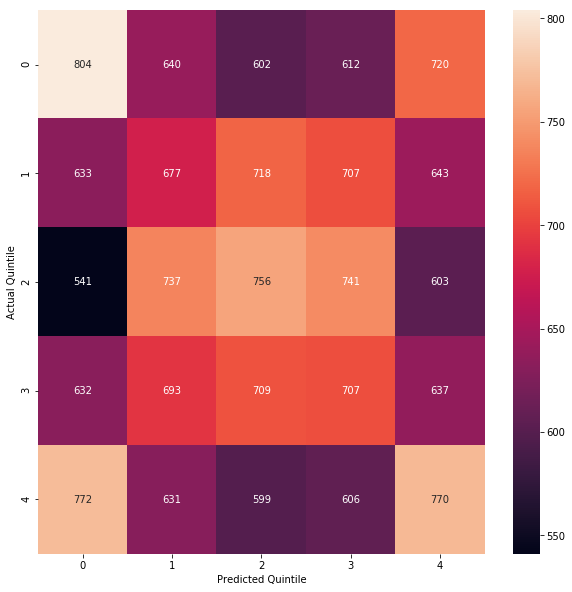

---


In [115]:
# tune XGBClassifier

keys = []
sharpes2 = []
directional_accuracies2=[]
in_sample_accuracies2 = []

n_estimators_list = [100, 300, 1000]
max_depth_list = [4]
learning_rate_list = [0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
subsample_list = [0.6, 0.7, 0.8]
hyperparameter_combos = list(product(n_estimators_list, max_depth_list, learning_rate_list, subsample_list))

def myXGBClassifier(n_estimators, max_depth, subsample, learning_rate):
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    n_estimators, max_depth, subsample, learning_rate = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_estimators, max_depth, subsample, learning_rate)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=myXGBClassifier(n_estimators,max_depth,subsample,learning_rate), 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_three_classes)
    backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes2.append(backtestmodel.sharpe)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies2.append(backtestmodel.directional_accuracy)
        in_sample_accuracies2.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies2.append(np.nan)
        in_sample_accuracies2.append(np.nan)

    print("---")

In [122]:
metricsframe = pd.DataFrame(list(zip([k[0] for k in keys],
                                     [k[1] for k in keys],
                                     [k[2] for k in keys],
                                     [k[3] for k in keys],
                                     in_sample_accuracies2,
                                     directional_accuracies2,
                                     sharpes2)), 
                            columns = ['n_estimators', 'max_depth', 'learning_rate', 'subsample','in_sample_acc','oos_acc','sharpe'])
metricsframe
#do big dataframe,
#do summaries
#do heatmaps
# try catboost, lightgbm
#test my_categorical_entropy loss
#run keras with my_categorical entropy, see if you get better sharpes
#scale my_categorical_entropy loss vs. mse loss
#combine crossentropy and mse
#add fundamental data

In [124]:
pd.DataFrame(metricsframe.groupby(['n_estimators'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [125]:
pd.DataFrame(metricsframe.groupby(['max_depth'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [126]:
pd.DataFrame(metricsframe.groupby(['subsample'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [127]:
pd.DataFrame(metricsframe.groupby(['learning_rate'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
model = catboost.CatBoostClassifier()

keys = []
sharpes3 = []
directional_accuracies3=[]
in_sample_accuracies3 = []

n_estimators_list = [1000]
max_depth_list = [4]
learning_rate_list = [0.001]
subsample_list = [0.7]
hyperparameter_combos = list(product(n_estimators_list, max_depth_list, learning_rate_list, subsample_list))

def myXGBClassifier(n_estimators=1000, max_depth=4, subsample=0.7, learning_rate=0.001):
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    n_estimators, max_depth, subsample, learning_rate = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_estimators, max_depth, subsample, learning_rate)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=myXGBClassifier(n_estimators,max_depth,subsample,learning_rate), 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_three_classes)
    backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes3.append(backtestmodel.sharpe)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies3.append(backtestmodel.directional_accuracy)
        in_sample_accuracies3.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies3.append(np.nan)
        in_sample_accuracies3.append(np.nan)

    print("---")

09:21:16 Running 1 experiments
09:21:16 Running experiment 1 of 1
(1000, 4, 0.001, 0.7)

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall stati


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

It


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iterat


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Itera

.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iterat


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera

.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

It


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter

.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Ite

.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.
.
Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

It


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iterat


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera

.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera

.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter

.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite

.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

It


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iterat


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iter


Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Ite


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.
.
Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Ite

Mean return: 2.167%
Monthly Sharpe ratio: 0.416
Avg rank correlation (Kendall's tau): 0.0250 (Expected: 0)
5-quintile accuracy: 0.2218 (Expected: 0.2)
Long/short/flat accuracy: 0.4692 (Expected: 0.44)
Confusion matrix for quantile 0
[[10893  2619]
 [ 2615   763]]
Chi-square: 17.3506 (p-value: 0.00059858)
Confusion matrix for quantile 1
[[10827  2685]
 [ 2685   693]]
Chi-square: 0.7002 (p-value: 0.87315434)
Confusion matrix for quantile 2
[[10890  2622]
 [ 2616   762]]
Chi-square: 16.8017 (p-value: 0.00077629)
Confusion matrix for quantile 3
[[10859  2653]
 [ 2658   720]]
Chi-square: 4.7762 (p-value: 0.18893639)
Confusion matrix for quantile 4
[[10947  2565]
 [ 2570   808]]
Chi-square: 41.1661 (p-value: 0.00000001)
Excess true positive in quintiles 1 + 5: 219.800000


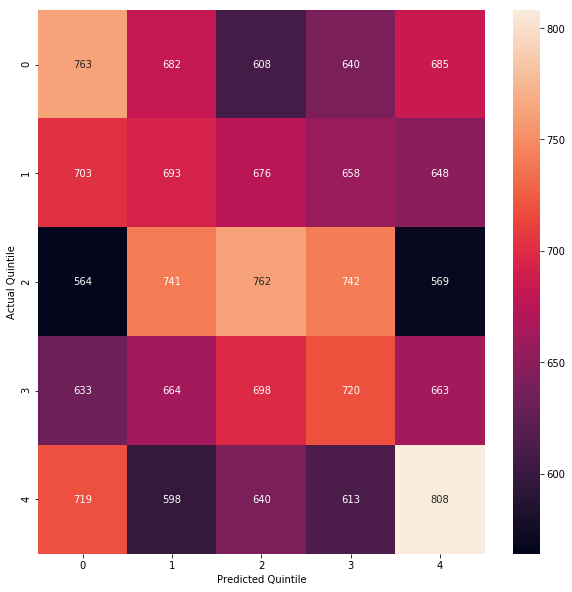


Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time -1.57e+06 sec ignored in overall statistics.

Iteration with suspicious time 1.57e+06 sec ignored in overall statistics.

Itera

NameError: name 'pring' is not defined

In [137]:
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print(backtestmodel.directional_accuracy)
print(backtestmodel.insample_accuracy)
 

In [24]:

class LightGbmWrapper:
    """Wrap Lightgbm model to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, 
                 param = {'num_leaves':31, 'num_trees':100, 'objective':'multiclass', 'num_class':3, 'metric': 'multi_logloss',},
                 num_round=10):
        self.param = param
        self.num_round = num_round
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            train_data = lgb.Dataset(X_fit, label=Y_fit[:,responsecol])
            model = lgb.train(self.param, train_data, self.num_round)
            self.models.append(model)

    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows,1)))
        return [np.hstack(predictions) for predictions in retlist]

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(np.array(Z), axis=0)
        
        

In [25]:
Y_class = make_three_classes(Y)
Y_class[0]

array([0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 2., 2., 0., 1.,
       0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 2., 0., 1.])

In [47]:
mw = LightGbmWrapper()
mw.fit(X,Y_class)
Z = mw.predict_proba(X[0].reshape(1,30))
print(len(Z))
print(Z[0].shape)
Z

3
(1, 30)


[array([[0.61677882, 0.69568173, 0.23536431, 0.24584737, 0.65529844,
         0.52051469, 0.42961599, 0.51754588, 0.40208489, 0.60217404,
         0.59140976, 0.38914123, 0.64485849, 0.33386933, 0.31673424,
         0.43294629, 0.26196013, 0.58785254, 0.52353805, 0.27461584,
         0.33543888, 0.62751086, 0.48945057, 0.5497599 , 0.51453993,
         0.63806137, 0.58017168, 0.27754744, 0.5683954 , 0.42871104]]),
 array([[0.18456881, 0.15283603, 0.42301749, 0.45308423, 0.17987949,
         0.28258395, 0.26766316, 0.18584503, 0.24025494, 0.1926232 ,
         0.16947302, 0.17163599, 0.18824489, 0.25150607, 0.26774162,
         0.30933896, 0.47367137, 0.19275625, 0.26025245, 0.40064223,
         0.36591982, 0.17700247, 0.21165015, 0.17416522, 0.24735422,
         0.17125036, 0.19925294, 0.28714354, 0.18508894, 0.33927974]]),
 array([[0.19865237, 0.15148225, 0.3416182 , 0.30106841, 0.16482208,
         0.19690136, 0.30272085, 0.2966091 , 0.35766017, 0.20520276,
         0.23911722, 0.43922

In [27]:
mw.predict(X[0].reshape(1,30))

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 2, 0, 0]])

................................................................................
12:56:26 Still training step 80 of 563
................................................................................
12:57:17 Still training step 160 of 563
................................................................................
12:58:05 Still training step 240 of 563
................................................................................
12:58:59 Still training step 320 of 563
................................................................................
13:00:12 Still training step 400 of 563
................................................................................
13:01:57 Still training step 480 of 563
................................................................................
13:03:57 Still training step 560 of 563
...
Mean return: 1.942%
Monthly Sharpe ratio: 0.404
Avg rank correlation (Kendall's tau): 0.0192 (Expected: 0)
5-quintile accuracy: 0.2162 (Expected: 0.2)

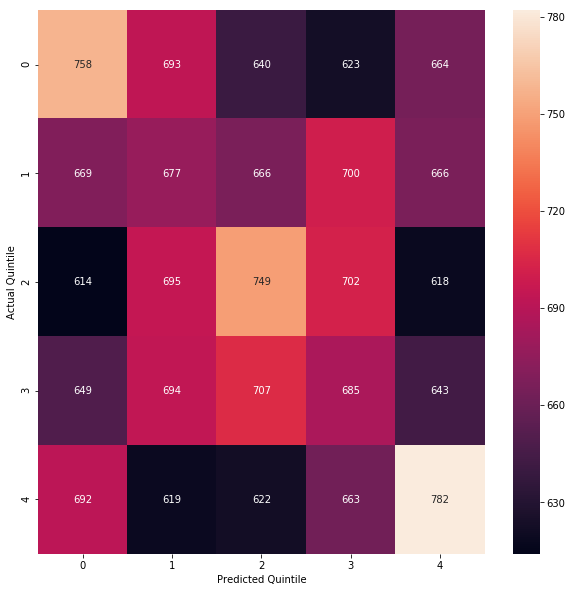

OOS Accuracy: 0.4627
In-Sample Accuracy: 0.8374


In [28]:
backtestmodel = BacktestModel(X, Y, 
                              model=LightGbmWrapper(), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_three_classes)
backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
backtestmodel.gen_returns(calc_returns, verbose=False)

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

### Perform cross-validation on Keras neural networks to select best architecture

In [67]:
# use keras instead of sklearn MLPRegressor
# wrap keras model in a class 
# multioutput 30 predictions simultaneously to speed up 
# fit takes a list of response ys, predict returns a list of y_predict arrays
# no coef_dict

NCLASSES=3
INPUT_DIM = X.shape[1]
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 137
EPOCHS=1000
# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(NCLASSES, 
                                 activation='softmax',
                                 name = "Output%02d" % (i+1))(lastlayer))
            
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss='categorical_crossentropy', 
                           optimizer="rmsprop", 
                           metrics=['accuracy'])
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]

        if epochs:
            self.epochs = epochs
            
        fit = self.model.fit(X,
                             Y_list,
                             batch_size=BATCH_SIZE,
                             epochs=self.epochs,
                             verbose=verbose)
        
        self.history = fit.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return fit
        
    def predict_proba(self, X, verbose=False):
        nrows, npredictors = X.shape
        y_list = self.model.predict(X)
        nresponses = len(y_list)
        retarray = np.zeros([NCLASSES, nrows, OUTPUT_DIM])
        
        for response in range(OUTPUT_DIM):
            for row in range(nrows):
                for i in range(NCLASSES):
                    retarray[i, row, response] = y_list[response][row, i]
                
        return retarray

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(Z, axis=0)
      
    def evaluate(self, X, Y):
        """predict classes using X"""
        # convert list of ys to Y array
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]
        evaluate_array = self.model.evaluate(X, Y_list, batch_size=BATCH_SIZE, verbose=False)
        self.accuracy = np.mean(np.array(evaluate_array[-npredictors:]))
        
        return self.accuracy
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


30


In [68]:
# no hidden layer, linear activation = LinearRegression
# confirm similar results to sklearn LinearRegression
keras_model = KerasBacktestModel(n_hidden_layers = 1,
                                 hidden_layer_size=16,
                                 reg_penalty = 3.0,
                                 verbose=True,
                                 epochs=500)
keras_model

layer 1 size 16, reg_penalty 3.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           496         main_input[0][0]                 
__________________________________________________________________________________________________
Output01 (Dense)                (None, 3)            51          Dense00[0][0]                    
__________________________________________________________________________________________________
Output02 (Dense)                (None, 3)            51          Dense00[0][0]                    
_____________________________________________________________________

In [71]:
keras_model.fit(X,Y_class)
z = keras_model.predict_proba(X[:4])
print(z[1].shape)
z

(4, 30)


array([[[0.67735261, 0.54584849, 0.39881751, 0.49445361, 0.6590156 ,
         0.66606838, 0.58810794, 0.61208165, 0.70429206, 0.5645318 ,
         0.7353549 , 0.51476181, 0.68410146, 0.62890595, 0.54641479,
         0.60018867, 0.39156488, 0.31274748, 0.49945748, 0.50389808,
         0.56073368, 0.61144036, 0.58730149, 0.76637095, 0.63473845,
         0.76812845, 0.66798103, 0.59422612, 0.69840533, 0.67876697],
        [0.70759702, 0.55263102, 0.41389135, 0.50991738, 0.68886685,
         0.68508053, 0.6070981 , 0.62638211, 0.73250973, 0.56897438,
         0.77037936, 0.52663648, 0.70667386, 0.65563381, 0.56648231,
         0.62686485, 0.39535779, 0.30101278, 0.50245774, 0.5326128 ,
         0.58352733, 0.62810487, 0.60686487, 0.80029249, 0.66187048,
         0.80539703, 0.69474077, 0.61509311, 0.72989351, 0.71248323],
        [0.66968846, 0.55027807, 0.39462981, 0.49198189, 0.65367657,
         0.66654962, 0.58679008, 0.61529237, 0.70269001, 0.56683236,
         0.72846103, 0.51240116,

In [72]:
z = keras_model.predict(X[:4])
print(z[1].shape)
z

(30,)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
backtestmodel = BacktestModel(X, Y, 
                              model=keras_model, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_three_classes)
backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
backtestmodel.gen_returns(calc_returns, verbose=False)

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

................................................................................
09:07:44 Still training step 80 of 563
................................................................................
11:40:06 Still training step 160 of 563
...............................................................................
15:20:11 Still training step 240 of 563
................................................................................
19:26:51 Still training step 320 of 563
..............................................

Mean return: 3.045%
Monthly Sharpe ratio: 0.539
Avg rank correlation (Kendall's tau): 0.0360 (Expected: 0)
5-quintile accuracy: 0.2150 (Expected: 0.2)
Long/short/flat accuracy: 0.4600 (Expected: 0.44)
Confusion matrix for quantile 0
[[10908  2604]
 [ 2600   778]]
Chi-square: 23.8795 (p-value: 0.00002647)
Confusion matrix for quantile 1
[[10850  2662]
 [ 2662   716]]
Chi-square: 3.7748 (p-value: 0.28683180)
Confusion matrix for quantile 2
[[10798  2714]
 [ 2708   670]]
Chi-square: 0.1203 (p-value: 0.98929949)
Confusion matrix for quantile 3
[[10838  2674]
 [ 2679   699]]
Chi-square: 1.3862 (p-value: 0.70877851)
Confusion matrix for quantile 4
[[10908  2604]
 [ 2609   769]]
Chi-square: 20.6191 (p-value: 0.00012630)
Excess true positive in quintiles 1 + 5: 195.800000


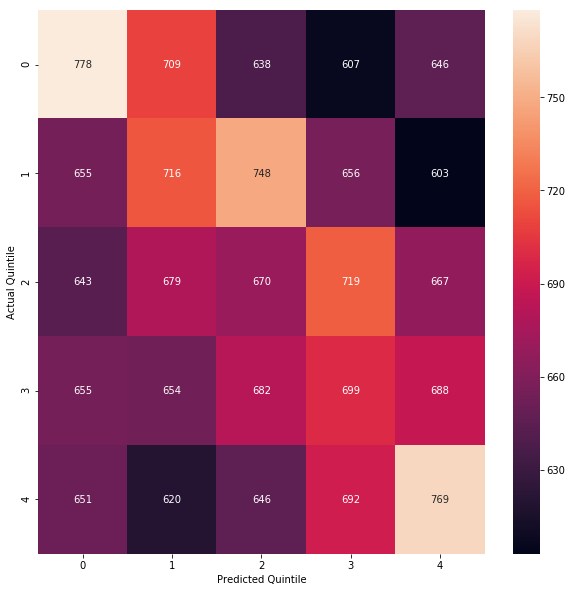

Epoch 1/500
684/684 [==============================] - 1s 855us/step - loss: 28.4156 - Output01_loss: 0.8430 - Output02_loss: 0.9959 - Output03_loss: 1.0783 - Output04_loss: 1.0389 - Output05_loss: 0.8569 - Output06_loss: 0.8608 - Output07_loss: 0.9510 - Output08_loss: 0.9244 - Output09_loss: 0.7986 - Output10_loss: 0.9635 - Output11_loss: 0.7458 - Output12_loss: 1.0216 - Output13_loss: 0.8212 - Output14_loss: 0.9124 - Output15_loss: 1.0014 - Output16_loss: 0.9412 - Output17_loss: 1.0850 - Output18_loss: 1.0964 - Output19_loss: 1.0346 - Output20_loss: 1.0285 - Output21_loss: 0.9839 - Output22_loss: 0.9253 - Output23_loss: 0.9608 - Output24_loss: 0.6837 - Output25_loss: 0.9035 - Output26_loss: 0.6855 - Output27_loss: 0.8605 - Output28_loss: 0.9538 - Output29_loss: 0.8130 - Output30_loss: 0.8285 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3991 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_

684/684 [==============================] - 1s 891us/step - loss: 28.4170 - Output01_loss: 0.8387 - Output02_loss: 0.9912 - Output03_loss: 1.0791 - Output04_loss: 1.0375 - Output05_loss: 0.8614 - Output06_loss: 0.8596 - Output07_loss: 0.9564 - Output08_loss: 0.9215 - Output09_loss: 0.8043 - Output10_loss: 0.9660 - Output11_loss: 0.7494 - Output12_loss: 1.0214 - Output13_loss: 0.8235 - Output14_loss: 0.9108 - Output15_loss: 0.9915 - Output16_loss: 0.9403 - Output17_loss: 1.0842 - Output18_loss: 1.0959 - Output19_loss: 1.0408 - Output20_loss: 1.0256 - Output21_loss: 0.9762 - Output22_loss: 0.9265 - Output23_loss: 0.9591 - Output24_loss: 0.6866 - Output25_loss: 0.9025 - Output26_loss: 0.6860 - Output27_loss: 0.8578 - Output28_loss: 0.9566 - Output29_loss: 0.8129 - Output30_loss: 0.8348 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4020 - Output04_acc: 0.4985 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5950 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 809us/step - loss: 28.4043 - Output01_loss: 0.8449 - Output02_loss: 0.9864 - Output03_loss: 1.0794 - Output04_loss: 1.0333 - Output05_loss: 0.8625 - Output06_loss: 0.8607 - Output07_loss: 0.9448 - Output08_loss: 0.9227 - Output09_loss: 0.7974 - Output10_loss: 0.9692 - Output11_loss: 0.7471 - Output12_loss: 1.0233 - Output13_loss: 0.8274 - Output14_loss: 0.9110 - Output15_loss: 0.9919 - Output16_loss: 0.9457 - Output17_loss: 1.0835 - Output18_loss: 1.0959 - Output19_loss: 1.0324 - Output20_loss: 1.0252 - Output21_loss: 0.9801 - Output22_loss: 0.9256 - Output23_loss: 0.9581 - Output24_loss: 0.6904 - Output25_loss: 0.9061 - Output26_loss: 0.6868 - Output27_loss: 0.8558 - Output28_loss: 0.9578 - Output29_loss: 0.8148 - Output30_loss: 0.8336 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5965 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 843us/step - loss: 28.3887 - Output01_loss: 0.8433 - Output02_loss: 0.9945 - Output03_loss: 1.0777 - Output04_loss: 1.0304 - Output05_loss: 0.8655 - Output06_loss: 0.8599 - Output07_loss: 0.9506 - Output08_loss: 0.9231 - Output09_loss: 0.7961 - Output10_loss: 0.9664 - Output11_loss: 0.7467 - Output12_loss: 1.0206 - Output13_loss: 0.8236 - Output14_loss: 0.9113 - Output15_loss: 0.9936 - Output16_loss: 0.9435 - Output17_loss: 1.0843 - Output18_loss: 1.0941 - Output19_loss: 1.0368 - Output20_loss: 1.0246 - Output21_loss: 0.9812 - Output22_loss: 0.9206 - Output23_loss: 0.9615 - Output24_loss: 0.6897 - Output25_loss: 0.8996 - Output26_loss: 0.6877 - Output27_loss: 0.8552 - Output28_loss: 0.9438 - Output29_loss: 0.8153 - Output30_loss: 0.8353 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4020 - Output04_acc: 0.4956 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 886us/step - loss: 28.3769 - Output01_loss: 0.8468 - Output02_loss: 0.9920 - Output03_loss: 1.0821 - Output04_loss: 1.0334 - Output05_loss: 0.8615 - Output06_loss: 0.8595 - Output07_loss: 0.9533 - Output08_loss: 0.9236 - Output09_loss: 0.7944 - Output10_loss: 0.9666 - Output11_loss: 0.7460 - Output12_loss: 1.0244 - Output13_loss: 0.8236 - Output14_loss: 0.9107 - Output15_loss: 0.9961 - Output16_loss: 0.9428 - Output17_loss: 1.0859 - Output18_loss: 1.0920 - Output19_loss: 1.0344 - Output20_loss: 1.0225 - Output21_loss: 0.9831 - Output22_loss: 0.9210 - Output23_loss: 0.9619 - Output24_loss: 0.6850 - Output25_loss: 0.8999 - Output26_loss: 0.6855 - Output27_loss: 0.8609 - Output28_loss: 0.9399 - Output29_loss: 0.8146 - Output30_loss: 0.8304 - Output01_acc: 0.6813 - Output02_acc: 0.5512 - Output03_acc: 0.4050 - Output04_acc: 0.4971 - Output05_acc: 0.6623 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 0s 724us/step - loss: 28.3761 - Output01_loss: 0.8424 - Output02_loss: 0.9923 - Output03_loss: 1.0827 - Output04_loss: 1.0362 - Output05_loss: 0.8561 - Output06_loss: 0.8609 - Output07_loss: 0.9506 - Output08_loss: 0.9191 - Output09_loss: 0.7964 - Output10_loss: 0.9638 - Output11_loss: 0.7506 - Output12_loss: 1.0209 - Output13_loss: 0.8226 - Output14_loss: 0.9115 - Output15_loss: 0.9955 - Output16_loss: 0.9426 - Output17_loss: 1.0867 - Output18_loss: 1.0963 - Output19_loss: 1.0295 - Output20_loss: 1.0291 - Output21_loss: 0.9826 - Output22_loss: 0.9233 - Output23_loss: 0.9583 - Output24_loss: 0.6866 - Output25_loss: 0.9003 - Output26_loss: 0.6862 - Output27_loss: 0.8584 - Output28_loss: 0.9407 - Output29_loss: 0.8157 - Output30_loss: 0.8298 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3991 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 760us/step - loss: 28.4787 - Output01_loss: 0.8463 - Output02_loss: 0.9933 - Output03_loss: 1.0798 - Output04_loss: 1.0369 - Output05_loss: 0.8603 - Output06_loss: 0.8597 - Output07_loss: 0.9566 - Output08_loss: 0.9327 - Output09_loss: 0.8017 - Output10_loss: 0.9766 - Output11_loss: 0.7461 - Output12_loss: 1.0214 - Output13_loss: 0.8285 - Output14_loss: 0.9105 - Output15_loss: 0.9959 - Output16_loss: 0.9434 - Output17_loss: 1.0852 - Output18_loss: 1.0991 - Output19_loss: 1.0502 - Output20_loss: 1.0300 - Output21_loss: 0.9806 - Output22_loss: 0.9202 - Output23_loss: 0.9626 - Output24_loss: 0.6882 - Output25_loss: 0.8981 - Output26_loss: 0.6879 - Output27_loss: 0.8623 - Output28_loss: 0.9443 - Output29_loss: 0.8140 - Output30_loss: 0.8345 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3977 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6126 - Output09_acc: 0.7091 

684/684 [==============================] - 1s 790us/step - loss: 28.5001 - Output01_loss: 0.8416 - Output02_loss: 0.9911 - Output03_loss: 1.0863 - Output04_loss: 1.0455 - Output05_loss: 0.8684 - Output06_loss: 0.8598 - Output07_loss: 0.9538 - Output08_loss: 0.9286 - Output09_loss: 0.7934 - Output10_loss: 0.9736 - Output11_loss: 0.7482 - Output12_loss: 1.0226 - Output13_loss: 0.8206 - Output14_loss: 0.9148 - Output15_loss: 0.9968 - Output16_loss: 0.9413 - Output17_loss: 1.0887 - Output18_loss: 1.0943 - Output19_loss: 1.0327 - Output20_loss: 1.0351 - Output21_loss: 0.9872 - Output22_loss: 0.9379 - Output23_loss: 0.9591 - Output24_loss: 0.6889 - Output25_loss: 0.8994 - Output26_loss: 0.6909 - Output27_loss: 0.8586 - Output28_loss: 0.9449 - Output29_loss: 0.8126 - Output30_loss: 0.8357 - Output01_acc: 0.6813 - Output02_acc: 0.5512 - Output03_acc: 0.3933 - Output04_acc: 0.4971 - Output05_acc: 0.6608 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6126 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 778us/step - loss: 28.4266 - Output01_loss: 0.8413 - Output02_loss: 0.9951 - Output03_loss: 1.0800 - Output04_loss: 1.0344 - Output05_loss: 0.8617 - Output06_loss: 0.8593 - Output07_loss: 0.9519 - Output08_loss: 0.9251 - Output09_loss: 0.7950 - Output10_loss: 0.9625 - Output11_loss: 0.7472 - Output12_loss: 1.0196 - Output13_loss: 0.8232 - Output14_loss: 0.9111 - Output15_loss: 0.9975 - Output16_loss: 0.9451 - Output17_loss: 1.0853 - Output18_loss: 1.0959 - Output19_loss: 1.0302 - Output20_loss: 1.0245 - Output21_loss: 0.9815 - Output22_loss: 0.9228 - Output23_loss: 0.9632 - Output24_loss: 0.6850 - Output25_loss: 0.8996 - Output26_loss: 0.6915 - Output27_loss: 0.8622 - Output28_loss: 0.9466 - Output29_loss: 0.8150 - Output30_loss: 0.8360 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3933 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5950 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 790us/step - loss: 28.3742 - Output01_loss: 0.8412 - Output02_loss: 0.9898 - Output03_loss: 1.0808 - Output04_loss: 1.0304 - Output05_loss: 0.8626 - Output06_loss: 0.8610 - Output07_loss: 0.9489 - Output08_loss: 0.9232 - Output09_loss: 0.7964 - Output10_loss: 0.9688 - Output11_loss: 0.7446 - Output12_loss: 1.0231 - Output13_loss: 0.8191 - Output14_loss: 0.9140 - Output15_loss: 0.9963 - Output16_loss: 0.9437 - Output17_loss: 1.0882 - Output18_loss: 1.0888 - Output19_loss: 1.0316 - Output20_loss: 1.0219 - Output21_loss: 0.9802 - Output22_loss: 0.9303 - Output23_loss: 0.9590 - Output24_loss: 0.6879 - Output25_loss: 0.9025 - Output26_loss: 0.6854 - Output27_loss: 0.8575 - Output28_loss: 0.9368 - Output29_loss: 0.8153 - Output30_loss: 0.8333 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4094 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 899us/step - loss: 28.4126 - Output01_loss: 0.8426 - Output02_loss: 0.9911 - Output03_loss: 1.0778 - Output04_loss: 1.0300 - Output05_loss: 0.8644 - Output06_loss: 0.8588 - Output07_loss: 0.9548 - Output08_loss: 0.9275 - Output09_loss: 0.7991 - Output10_loss: 0.9762 - Output11_loss: 0.7468 - Output12_loss: 1.0221 - Output13_loss: 0.8210 - Output14_loss: 0.9100 - Output15_loss: 0.9924 - Output16_loss: 0.9415 - Output17_loss: 1.0817 - Output18_loss: 1.0968 - Output19_loss: 1.0329 - Output20_loss: 1.0272 - Output21_loss: 0.9796 - Output22_loss: 0.9299 - Output23_loss: 0.9636 - Output24_loss: 0.6864 - Output25_loss: 0.9040 - Output26_loss: 0.6859 - Output27_loss: 0.8554 - Output28_loss: 0.9376 - Output29_loss: 0.8129 - Output30_loss: 0.8304 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3991 - Output04_acc: 0.4985 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 925us/step - loss: 28.3552 - Output01_loss: 0.8414 - Output02_loss: 0.9918 - Output03_loss: 1.0806 - Output04_loss: 1.0347 - Output05_loss: 0.8603 - Output06_loss: 0.8579 - Output07_loss: 0.9546 - Output08_loss: 0.9193 - Output09_loss: 0.7974 - Output10_loss: 0.9634 - Output11_loss: 0.7459 - Output12_loss: 1.0217 - Output13_loss: 0.8234 - Output14_loss: 0.9112 - Output15_loss: 0.9932 - Output16_loss: 0.9401 - Output17_loss: 1.0877 - Output18_loss: 1.0919 - Output19_loss: 1.0376 - Output20_loss: 1.0229 - Output21_loss: 0.9813 - Output22_loss: 0.9248 - Output23_loss: 0.9594 - Output24_loss: 0.6849 - Output25_loss: 0.9006 - Output26_loss: 0.6847 - Output27_loss: 0.8594 - Output28_loss: 0.9442 - Output29_loss: 0.8144 - Output30_loss: 0.8331 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 859us/step - loss: 28.4538 - Output01_loss: 0.8414 - Output02_loss: 0.9921 - Output03_loss: 1.0800 - Output04_loss: 1.0273 - Output05_loss: 0.8701 - Output06_loss: 0.8594 - Output07_loss: 0.9527 - Output08_loss: 0.9210 - Output09_loss: 0.7999 - Output10_loss: 0.9612 - Output11_loss: 0.7508 - Output12_loss: 1.0180 - Output13_loss: 0.8229 - Output14_loss: 0.9118 - Output15_loss: 0.9947 - Output16_loss: 0.9427 - Output17_loss: 1.0911 - Output18_loss: 1.0951 - Output19_loss: 1.0364 - Output20_loss: 1.0319 - Output21_loss: 0.9766 - Output22_loss: 0.9296 - Output23_loss: 0.9639 - Output24_loss: 0.6876 - Output25_loss: 0.9045 - Output26_loss: 0.6842 - Output27_loss: 0.8572 - Output28_loss: 0.9467 - Output29_loss: 0.8143 - Output30_loss: 0.8382 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4064 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 910us/step - loss: 28.4152 - Output01_loss: 0.8431 - Output02_loss: 0.9908 - Output03_loss: 1.0793 - Output04_loss: 1.0356 - Output05_loss: 0.8632 - Output06_loss: 0.8591 - Output07_loss: 0.9506 - Output08_loss: 0.9199 - Output09_loss: 0.7995 - Output10_loss: 0.9718 - Output11_loss: 0.7464 - Output12_loss: 1.0223 - Output13_loss: 0.8258 - Output14_loss: 0.9116 - Output15_loss: 0.9942 - Output16_loss: 0.9432 - Output17_loss: 1.0904 - Output18_loss: 1.0915 - Output19_loss: 1.0305 - Output20_loss: 1.0290 - Output21_loss: 0.9814 - Output22_loss: 0.9250 - Output23_loss: 0.9593 - Output24_loss: 0.6942 - Output25_loss: 0.9030 - Output26_loss: 0.6851 - Output27_loss: 0.8573 - Output28_loss: 0.9375 - Output29_loss: 0.8131 - Output30_loss: 0.8349 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4020 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 933us/step - loss: 28.5473 - Output01_loss: 0.8474 - Output02_loss: 0.9951 - Output03_loss: 1.0831 - Output04_loss: 1.0410 - Output05_loss: 0.8726 - Output06_loss: 0.8581 - Output07_loss: 0.9553 - Output08_loss: 0.9263 - Output09_loss: 0.7987 - Output10_loss: 0.9755 - Output11_loss: 0.7469 - Output12_loss: 1.0220 - Output13_loss: 0.8268 - Output14_loss: 0.9102 - Output15_loss: 0.9991 - Output16_loss: 0.9431 - Output17_loss: 1.0904 - Output18_loss: 1.0972 - Output19_loss: 1.0420 - Output20_loss: 1.0313 - Output21_loss: 0.9820 - Output22_loss: 0.9310 - Output23_loss: 0.9597 - Output24_loss: 0.6840 - Output25_loss: 0.9037 - Output26_loss: 0.6867 - Output27_loss: 0.8640 - Output28_loss: 0.9595 - Output29_loss: 0.8144 - Output30_loss: 0.8370 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4006 - Output04_acc: 0.4956 - Output05_acc: 0.6623 - Output06_acc: 0.6711 - Output07_acc: 0.5950 - Output08_acc: 0.6170 - Output09_acc: 0.7091 

684/684 [==============================] - 1s 809us/step - loss: 28.4790 - Output01_loss: 0.8419 - Output02_loss: 0.9939 - Output03_loss: 1.0871 - Output04_loss: 1.0404 - Output05_loss: 0.8677 - Output06_loss: 0.8647 - Output07_loss: 0.9502 - Output08_loss: 0.9232 - Output09_loss: 0.8021 - Output10_loss: 0.9698 - Output11_loss: 0.7555 - Output12_loss: 1.0216 - Output13_loss: 0.8235 - Output14_loss: 0.9106 - Output15_loss: 0.9948 - Output16_loss: 0.9396 - Output17_loss: 1.0855 - Output18_loss: 1.0914 - Output19_loss: 1.0342 - Output20_loss: 1.0353 - Output21_loss: 0.9870 - Output22_loss: 0.9313 - Output23_loss: 0.9562 - Output24_loss: 0.6858 - Output25_loss: 0.9000 - Output26_loss: 0.6935 - Output27_loss: 0.8532 - Output28_loss: 0.9471 - Output29_loss: 0.8149 - Output30_loss: 0.8345 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 873us/step - loss: 28.3697 - Output01_loss: 0.8449 - Output02_loss: 0.9948 - Output03_loss: 1.0782 - Output04_loss: 1.0362 - Output05_loss: 0.8610 - Output06_loss: 0.8604 - Output07_loss: 0.9534 - Output08_loss: 0.9276 - Output09_loss: 0.7908 - Output10_loss: 0.9605 - Output11_loss: 0.7461 - Output12_loss: 1.0210 - Output13_loss: 0.8240 - Output14_loss: 0.9126 - Output15_loss: 0.9938 - Output16_loss: 0.9429 - Output17_loss: 1.0829 - Output18_loss: 1.0933 - Output19_loss: 1.0306 - Output20_loss: 1.0213 - Output21_loss: 0.9819 - Output22_loss: 0.9246 - Output23_loss: 0.9573 - Output24_loss: 0.6879 - Output25_loss: 0.9018 - Output26_loss: 0.6857 - Output27_loss: 0.8570 - Output28_loss: 0.9347 - Output29_loss: 0.8131 - Output30_loss: 0.8351 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4050 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 829us/step - loss: 28.4582 - Output01_loss: 0.8403 - Output02_loss: 0.9938 - Output03_loss: 1.0822 - Output04_loss: 1.0342 - Output05_loss: 0.8629 - Output06_loss: 0.8595 - Output07_loss: 0.9509 - Output08_loss: 0.9217 - Output09_loss: 0.7975 - Output10_loss: 0.9722 - Output11_loss: 0.7458 - Output12_loss: 1.0215 - Output13_loss: 0.8281 - Output14_loss: 0.9094 - Output15_loss: 0.9974 - Output16_loss: 0.9464 - Output17_loss: 1.0867 - Output18_loss: 1.0943 - Output19_loss: 1.0328 - Output20_loss: 1.0275 - Output21_loss: 0.9774 - Output22_loss: 0.9325 - Output23_loss: 0.9629 - Output24_loss: 0.6846 - Output25_loss: 0.9029 - Output26_loss: 0.6864 - Output27_loss: 0.8613 - Output28_loss: 0.9488 - Output29_loss: 0.8133 - Output30_loss: 0.8288 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3991 - Output04_acc: 0.4956 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 925us/step - loss: 28.3693 - Output01_loss: 0.8415 - Output02_loss: 0.9936 - Output03_loss: 1.0788 - Output04_loss: 1.0327 - Output05_loss: 0.8589 - Output06_loss: 0.8594 - Output07_loss: 0.9503 - Output08_loss: 0.9238 - Output09_loss: 0.7955 - Output10_loss: 0.9632 - Output11_loss: 0.7461 - Output12_loss: 1.0219 - Output13_loss: 0.8252 - Output14_loss: 0.9113 - Output15_loss: 0.9921 - Output16_loss: 0.9449 - Output17_loss: 1.0827 - Output18_loss: 1.0929 - Output19_loss: 1.0251 - Output20_loss: 1.0220 - Output21_loss: 0.9782 - Output22_loss: 0.9231 - Output23_loss: 0.9601 - Output24_loss: 0.6891 - Output25_loss: 0.9050 - Output26_loss: 0.6933 - Output27_loss: 0.8592 - Output28_loss: 0.9387 - Output29_loss: 0.8146 - Output30_loss: 0.8314 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4050 - Output04_acc: 0.4971 - Output05_acc: 0.6652 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 825us/step - loss: 28.4154 - Output01_loss: 0.8460 - Output02_loss: 0.9917 - Output03_loss: 1.0830 - Output04_loss: 1.0380 - Output05_loss: 0.8627 - Output06_loss: 0.8588 - Output07_loss: 0.9519 - Output08_loss: 0.9254 - Output09_loss: 0.7959 - Output10_loss: 0.9709 - Output11_loss: 0.7482 - Output12_loss: 1.0224 - Output13_loss: 0.8228 - Output14_loss: 0.9127 - Output15_loss: 0.9972 - Output16_loss: 0.9394 - Output17_loss: 1.0866 - Output18_loss: 1.0914 - Output19_loss: 1.0290 - Output20_loss: 1.0224 - Output21_loss: 0.9833 - Output22_loss: 0.9325 - Output23_loss: 0.9586 - Output24_loss: 0.6869 - Output25_loss: 0.9013 - Output26_loss: 0.6892 - Output27_loss: 0.8604 - Output28_loss: 0.9430 - Output29_loss: 0.8124 - Output30_loss: 0.8286 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3962 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6155 - Output09_acc: 0.7091 

684/684 [==============================] - 1s 902us/step - loss: 28.4244 - Output01_loss: 0.8425 - Output02_loss: 0.9922 - Output03_loss: 1.0777 - Output04_loss: 1.0340 - Output05_loss: 0.8634 - Output06_loss: 0.8571 - Output07_loss: 0.9501 - Output08_loss: 0.9228 - Output09_loss: 0.7982 - Output10_loss: 0.9723 - Output11_loss: 0.7460 - Output12_loss: 1.0196 - Output13_loss: 0.8184 - Output14_loss: 0.9099 - Output15_loss: 0.9929 - Output16_loss: 0.9440 - Output17_loss: 1.0865 - Output18_loss: 1.0961 - Output19_loss: 1.0357 - Output20_loss: 1.0328 - Output21_loss: 0.9795 - Output22_loss: 0.9254 - Output23_loss: 0.9622 - Output24_loss: 0.6865 - Output25_loss: 0.9041 - Output26_loss: 0.6850 - Output27_loss: 0.8620 - Output28_loss: 0.9546 - Output29_loss: 0.8147 - Output30_loss: 0.8311 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4956 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 788us/step - loss: 28.3758 - Output01_loss: 0.8439 - Output02_loss: 0.9900 - Output03_loss: 1.0802 - Output04_loss: 1.0311 - Output05_loss: 0.8593 - Output06_loss: 0.8608 - Output07_loss: 0.9540 - Output08_loss: 0.9224 - Output09_loss: 0.7941 - Output10_loss: 0.9698 - Output11_loss: 0.7469 - Output12_loss: 1.0218 - Output13_loss: 0.8226 - Output14_loss: 0.9110 - Output15_loss: 0.9928 - Output16_loss: 0.9424 - Output17_loss: 1.0874 - Output18_loss: 1.0935 - Output19_loss: 1.0330 - Output20_loss: 1.0280 - Output21_loss: 0.9829 - Output22_loss: 0.9267 - Output23_loss: 0.9606 - Output24_loss: 0.6885 - Output25_loss: 0.9014 - Output26_loss: 0.6863 - Output27_loss: 0.8614 - Output28_loss: 0.9419 - Output29_loss: 0.8141 - Output30_loss: 0.8293 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4064 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 882us/step - loss: 28.3787 - Output01_loss: 0.8435 - Output02_loss: 0.9892 - Output03_loss: 1.0766 - Output04_loss: 1.0318 - Output05_loss: 0.8725 - Output06_loss: 0.8610 - Output07_loss: 0.9536 - Output08_loss: 0.9215 - Output09_loss: 0.7951 - Output10_loss: 0.9615 - Output11_loss: 0.7464 - Output12_loss: 1.0244 - Output13_loss: 0.8232 - Output14_loss: 0.9126 - Output15_loss: 0.9947 - Output16_loss: 0.9417 - Output17_loss: 1.0824 - Output18_loss: 1.0886 - Output19_loss: 1.0346 - Output20_loss: 1.0273 - Output21_loss: 0.9764 - Output22_loss: 0.9290 - Output23_loss: 0.9614 - Output24_loss: 0.6878 - Output25_loss: 0.9020 - Output26_loss: 0.6847 - Output27_loss: 0.8550 - Output28_loss: 0.9436 - Output29_loss: 0.8147 - Output30_loss: 0.8336 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4079 - Output04_acc: 0.4971 - Output05_acc: 0.6608 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 934us/step - loss: 28.4954 - Output01_loss: 0.8420 - Output02_loss: 0.9906 - Output03_loss: 1.0855 - Output04_loss: 1.0345 - Output05_loss: 0.8754 - Output06_loss: 0.8589 - Output07_loss: 0.9617 - Output08_loss: 0.9227 - Output09_loss: 0.7960 - Output10_loss: 0.9879 - Output11_loss: 0.7460 - Output12_loss: 1.0222 - Output13_loss: 0.8255 - Output14_loss: 0.9110 - Output15_loss: 0.9977 - Output16_loss: 0.9422 - Output17_loss: 1.0893 - Output18_loss: 1.0965 - Output19_loss: 1.0371 - Output20_loss: 1.0328 - Output21_loss: 0.9883 - Output22_loss: 0.9268 - Output23_loss: 0.9648 - Output24_loss: 0.6916 - Output25_loss: 0.9042 - Output26_loss: 0.6850 - Output27_loss: 0.8573 - Output28_loss: 0.9408 - Output29_loss: 0.8149 - Output30_loss: 0.8403 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4020 - Output04_acc: 0.4971 - Output05_acc: 0.6608 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 834us/step - loss: 28.4068 - Output01_loss: 0.8430 - Output02_loss: 0.9889 - Output03_loss: 1.0815 - Output04_loss: 1.0280 - Output05_loss: 0.8692 - Output06_loss: 0.8610 - Output07_loss: 0.9535 - Output08_loss: 0.9224 - Output09_loss: 0.7902 - Output10_loss: 0.9652 - Output11_loss: 0.7463 - Output12_loss: 1.0219 - Output13_loss: 0.8261 - Output14_loss: 0.9104 - Output15_loss: 0.9918 - Output16_loss: 0.9431 - Output17_loss: 1.0846 - Output18_loss: 1.0919 - Output19_loss: 1.0389 - Output20_loss: 1.0262 - Output21_loss: 0.9803 - Output22_loss: 0.9319 - Output23_loss: 0.9618 - Output24_loss: 0.6876 - Output25_loss: 0.9047 - Output26_loss: 0.6862 - Output27_loss: 0.8592 - Output28_loss: 0.9488 - Output29_loss: 0.8148 - Output30_loss: 0.8305 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3991 - Output04_acc: 0.4971 - Output05_acc: 0.6623 - Output06_acc: 0.6711 - Output07_acc: 0.5950 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 989us/step - loss: 28.3789 - Output01_loss: 0.8429 - Output02_loss: 0.9931 - Output03_loss: 1.0770 - Output04_loss: 1.0340 - Output05_loss: 0.8589 - Output06_loss: 0.8632 - Output07_loss: 0.9494 - Output08_loss: 0.9234 - Output09_loss: 0.7918 - Output10_loss: 0.9657 - Output11_loss: 0.7521 - Output12_loss: 1.0208 - Output13_loss: 0.8238 - Output14_loss: 0.9103 - Output15_loss: 0.9917 - Output16_loss: 0.9405 - Output17_loss: 1.0883 - Output18_loss: 1.0928 - Output19_loss: 1.0312 - Output20_loss: 1.0258 - Output21_loss: 0.9821 - Output22_loss: 0.9283 - Output23_loss: 0.9578 - Output24_loss: 0.6857 - Output25_loss: 0.9006 - Output26_loss: 0.6874 - Output27_loss: 0.8614 - Output28_loss: 0.9420 - Output29_loss: 0.8144 - Output30_loss: 0.8344 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 847us/step - loss: 28.3889 - Output01_loss: 0.8416 - Output02_loss: 0.9914 - Output03_loss: 1.0783 - Output04_loss: 1.0347 - Output05_loss: 0.8604 - Output06_loss: 0.8579 - Output07_loss: 0.9514 - Output08_loss: 0.9244 - Output09_loss: 0.7947 - Output10_loss: 0.9671 - Output11_loss: 0.7437 - Output12_loss: 1.0215 - Output13_loss: 0.8226 - Output14_loss: 0.9120 - Output15_loss: 0.9971 - Output16_loss: 0.9424 - Output17_loss: 1.0918 - Output18_loss: 1.0936 - Output19_loss: 1.0327 - Output20_loss: 1.0217 - Output21_loss: 0.9819 - Output22_loss: 0.9274 - Output23_loss: 0.9603 - Output24_loss: 0.6856 - Output25_loss: 0.9025 - Output26_loss: 0.6824 - Output27_loss: 0.8623 - Output28_loss: 0.9387 - Output29_loss: 0.8142 - Output30_loss: 0.8337 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4079 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 876us/step - loss: 28.3692 - Output01_loss: 0.8395 - Output02_loss: 0.9912 - Output03_loss: 1.0829 - Output04_loss: 1.0342 - Output05_loss: 0.8627 - Output06_loss: 0.8587 - Output07_loss: 0.9540 - Output08_loss: 0.9231 - Output09_loss: 0.7952 - Output10_loss: 0.9692 - Output11_loss: 0.7473 - Output12_loss: 1.0213 - Output13_loss: 0.8210 - Output14_loss: 0.9106 - Output15_loss: 0.9933 - Output16_loss: 0.9431 - Output17_loss: 1.0861 - Output18_loss: 1.0984 - Output19_loss: 1.0331 - Output20_loss: 1.0255 - Output21_loss: 0.9829 - Output22_loss: 0.9217 - Output23_loss: 0.9588 - Output24_loss: 0.6880 - Output25_loss: 0.8996 - Output26_loss: 0.6848 - Output27_loss: 0.8578 - Output28_loss: 0.9394 - Output29_loss: 0.8139 - Output30_loss: 0.8297 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4020 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5906 - Output08_acc: 0.6199 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 866us/step - loss: 28.3621 - Output01_loss: 0.8410 - Output02_loss: 0.9925 - Output03_loss: 1.0769 - Output04_loss: 1.0321 - Output05_loss: 0.8651 - Output06_loss: 0.8614 - Output07_loss: 0.9511 - Output08_loss: 0.9235 - Output09_loss: 0.7973 - Output10_loss: 0.9567 - Output11_loss: 0.7482 - Output12_loss: 1.0214 - Output13_loss: 0.8206 - Output14_loss: 0.9135 - Output15_loss: 0.9945 - Output16_loss: 0.9401 - Output17_loss: 1.0891 - Output18_loss: 1.0940 - Output19_loss: 1.0332 - Output20_loss: 1.0246 - Output21_loss: 0.9811 - Output22_loss: 0.9217 - Output23_loss: 0.9585 - Output24_loss: 0.6854 - Output25_loss: 0.8994 - Output26_loss: 0.6855 - Output27_loss: 0.8565 - Output28_loss: 0.9467 - Output29_loss: 0.8121 - Output30_loss: 0.8361 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4050 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 896us/step - loss: 28.3751 - Output01_loss: 0.8423 - Output02_loss: 0.9939 - Output03_loss: 1.0814 - Output04_loss: 1.0311 - Output05_loss: 0.8630 - Output06_loss: 0.8590 - Output07_loss: 0.9514 - Output08_loss: 0.9199 - Output09_loss: 0.7914 - Output10_loss: 0.9704 - Output11_loss: 0.7467 - Output12_loss: 1.0196 - Output13_loss: 0.8205 - Output14_loss: 0.9104 - Output15_loss: 0.9971 - Output16_loss: 0.9428 - Output17_loss: 1.0822 - Output18_loss: 1.0941 - Output19_loss: 1.0318 - Output20_loss: 1.0250 - Output21_loss: 0.9838 - Output22_loss: 0.9241 - Output23_loss: 0.9588 - Output24_loss: 0.6888 - Output25_loss: 0.9027 - Output26_loss: 0.6857 - Output27_loss: 0.8533 - Output28_loss: 0.9368 - Output29_loss: 0.8129 - Output30_loss: 0.8337 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4006 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 912us/step - loss: 28.3521 - Output01_loss: 0.8412 - Output02_loss: 0.9907 - Output03_loss: 1.0820 - Output04_loss: 1.0340 - Output05_loss: 0.8581 - Output06_loss: 0.8591 - Output07_loss: 0.9509 - Output08_loss: 0.9234 - Output09_loss: 0.7937 - Output10_loss: 0.9664 - Output11_loss: 0.7449 - Output12_loss: 1.0220 - Output13_loss: 0.8271 - Output14_loss: 0.9118 - Output15_loss: 0.9891 - Output16_loss: 0.9448 - Output17_loss: 1.0843 - Output18_loss: 1.0898 - Output19_loss: 1.0295 - Output20_loss: 1.0264 - Output21_loss: 0.9808 - Output22_loss: 0.9225 - Output23_loss: 0.9604 - Output24_loss: 0.6861 - Output25_loss: 0.9004 - Output26_loss: 0.6836 - Output27_loss: 0.8579 - Output28_loss: 0.9376 - Output29_loss: 0.8131 - Output30_loss: 0.8323 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 786us/step - loss: 28.4249 - Output01_loss: 0.8467 - Output02_loss: 0.9924 - Output03_loss: 1.0788 - Output04_loss: 1.0347 - Output05_loss: 0.8610 - Output06_loss: 0.8584 - Output07_loss: 0.9525 - Output08_loss: 0.9204 - Output09_loss: 0.8025 - Output10_loss: 0.9630 - Output11_loss: 0.7458 - Output12_loss: 1.0220 - Output13_loss: 0.8318 - Output14_loss: 0.9109 - Output15_loss: 0.9933 - Output16_loss: 0.9426 - Output17_loss: 1.0874 - Output18_loss: 1.0925 - Output19_loss: 1.0419 - Output20_loss: 1.0256 - Output21_loss: 0.9819 - Output22_loss: 0.9222 - Output23_loss: 0.9591 - Output24_loss: 0.6858 - Output25_loss: 0.9032 - Output26_loss: 0.6868 - Output27_loss: 0.8594 - Output28_loss: 0.9549 - Output29_loss: 0.8149 - Output30_loss: 0.8326 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4006 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 0s 720us/step - loss: 28.3547 - Output01_loss: 0.8425 - Output02_loss: 0.9918 - Output03_loss: 1.0787 - Output04_loss: 1.0365 - Output05_loss: 0.8582 - Output06_loss: 0.8601 - Output07_loss: 0.9543 - Output08_loss: 0.9252 - Output09_loss: 0.7919 - Output10_loss: 0.9669 - Output11_loss: 0.7458 - Output12_loss: 1.0214 - Output13_loss: 0.8264 - Output14_loss: 0.9116 - Output15_loss: 0.9922 - Output16_loss: 0.9422 - Output17_loss: 1.0832 - Output18_loss: 1.0923 - Output19_loss: 1.0269 - Output20_loss: 1.0254 - Output21_loss: 0.9804 - Output22_loss: 0.9255 - Output23_loss: 0.9589 - Output24_loss: 0.6867 - Output25_loss: 0.9006 - Output26_loss: 0.6870 - Output27_loss: 0.8608 - Output28_loss: 0.9381 - Output29_loss: 0.8123 - Output30_loss: 0.8355 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6199 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 885us/step - loss: 28.4480 - Output01_loss: 0.8408 - Output02_loss: 0.9927 - Output03_loss: 1.0803 - Output04_loss: 1.0307 - Output05_loss: 0.8627 - Output06_loss: 0.8597 - Output07_loss: 0.9681 - Output08_loss: 0.9237 - Output09_loss: 0.7912 - Output10_loss: 0.9624 - Output11_loss: 0.7463 - Output12_loss: 1.0204 - Output13_loss: 0.8253 - Output14_loss: 0.9132 - Output15_loss: 0.9957 - Output16_loss: 0.9430 - Output17_loss: 1.0859 - Output18_loss: 1.0954 - Output19_loss: 1.0407 - Output20_loss: 1.0296 - Output21_loss: 0.9846 - Output22_loss: 0.9284 - Output23_loss: 0.9630 - Output24_loss: 0.6877 - Output25_loss: 0.9030 - Output26_loss: 0.6838 - Output27_loss: 0.8578 - Output28_loss: 0.9503 - Output29_loss: 0.8141 - Output30_loss: 0.8338 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4050 - Output04_acc: 0.4971 - Output05_acc: 0.6623 - Output06_acc: 0.6711 - Output07_acc: 0.5950 - Output08_acc: 0.6199 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 816us/step - loss: 28.4504 - Output01_loss: 0.8390 - Output02_loss: 0.9923 - Output03_loss: 1.0775 - Output04_loss: 1.0374 - Output05_loss: 0.8697 - Output06_loss: 0.8598 - Output07_loss: 0.9537 - Output08_loss: 0.9245 - Output09_loss: 0.7928 - Output10_loss: 0.9639 - Output11_loss: 0.7432 - Output12_loss: 1.0231 - Output13_loss: 0.8235 - Output14_loss: 0.9127 - Output15_loss: 0.9935 - Output16_loss: 0.9423 - Output17_loss: 1.0883 - Output18_loss: 1.0938 - Output19_loss: 1.0305 - Output20_loss: 1.0284 - Output21_loss: 0.9827 - Output22_loss: 0.9353 - Output23_loss: 0.9616 - Output24_loss: 0.6895 - Output25_loss: 0.9006 - Output26_loss: 0.6869 - Output27_loss: 0.8607 - Output28_loss: 0.9444 - Output29_loss: 0.8166 - Output30_loss: 0.8341 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4050 - Output04_acc: 0.4971 - Output05_acc: 0.6608 - Output06_acc: 0.6711 - Output07_acc: 0.5950 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 913us/step - loss: 28.4894 - Output01_loss: 0.8458 - Output02_loss: 0.9907 - Output03_loss: 1.0812 - Output04_loss: 1.0344 - Output05_loss: 0.8615 - Output06_loss: 0.8606 - Output07_loss: 0.9620 - Output08_loss: 0.9291 - Output09_loss: 0.8038 - Output10_loss: 0.9695 - Output11_loss: 0.7494 - Output12_loss: 1.0222 - Output13_loss: 0.8312 - Output14_loss: 0.9099 - Output15_loss: 0.9926 - Output16_loss: 0.9408 - Output17_loss: 1.0862 - Output18_loss: 1.0957 - Output19_loss: 1.0376 - Output20_loss: 1.0177 - Output21_loss: 0.9867 - Output22_loss: 0.9275 - Output23_loss: 0.9659 - Output24_loss: 0.6857 - Output25_loss: 0.9035 - Output26_loss: 0.6863 - Output27_loss: 0.8590 - Output28_loss: 0.9500 - Output29_loss: 0.8121 - Output30_loss: 0.8356 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4064 - Output04_acc: 0.4971 - Output05_acc: 0.6652 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6155 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 807us/step - loss: 28.3662 - Output01_loss: 0.8446 - Output02_loss: 0.9915 - Output03_loss: 1.0773 - Output04_loss: 1.0321 - Output05_loss: 0.8570 - Output06_loss: 0.8588 - Output07_loss: 0.9510 - Output08_loss: 0.9223 - Output09_loss: 0.7914 - Output10_loss: 0.9739 - Output11_loss: 0.7465 - Output12_loss: 1.0211 - Output13_loss: 0.8200 - Output14_loss: 0.9111 - Output15_loss: 0.9930 - Output16_loss: 0.9445 - Output17_loss: 1.0841 - Output18_loss: 1.0939 - Output19_loss: 1.0286 - Output20_loss: 1.0230 - Output21_loss: 0.9844 - Output22_loss: 0.9248 - Output23_loss: 0.9615 - Output24_loss: 0.6858 - Output25_loss: 0.9019 - Output26_loss: 0.6875 - Output27_loss: 0.8574 - Output28_loss: 0.9393 - Output29_loss: 0.8119 - Output30_loss: 0.8348 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4020 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6155 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 790us/step - loss: 28.4596 - Output01_loss: 0.8456 - Output02_loss: 0.9943 - Output03_loss: 1.0844 - Output04_loss: 1.0387 - Output05_loss: 0.8659 - Output06_loss: 0.8588 - Output07_loss: 0.9594 - Output08_loss: 0.9230 - Output09_loss: 0.7965 - Output10_loss: 0.9882 - Output11_loss: 0.7433 - Output12_loss: 1.0213 - Output13_loss: 0.8267 - Output14_loss: 0.9105 - Output15_loss: 0.9948 - Output16_loss: 0.9422 - Output17_loss: 1.0925 - Output18_loss: 1.0944 - Output19_loss: 1.0353 - Output20_loss: 1.0243 - Output21_loss: 0.9786 - Output22_loss: 0.9241 - Output23_loss: 0.9592 - Output24_loss: 0.6853 - Output25_loss: 0.8989 - Output26_loss: 0.6860 - Output27_loss: 0.8610 - Output28_loss: 0.9409 - Output29_loss: 0.8164 - Output30_loss: 0.8305 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3991 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 948us/step - loss: 28.3949 - Output01_loss: 0.8409 - Output02_loss: 0.9899 - Output03_loss: 1.0808 - Output04_loss: 1.0327 - Output05_loss: 0.8676 - Output06_loss: 0.8604 - Output07_loss: 0.9541 - Output08_loss: 0.9209 - Output09_loss: 0.8020 - Output10_loss: 0.9655 - Output11_loss: 0.7436 - Output12_loss: 1.0228 - Output13_loss: 0.8236 - Output14_loss: 0.9119 - Output15_loss: 0.9916 - Output16_loss: 0.9455 - Output17_loss: 1.0861 - Output18_loss: 1.0924 - Output19_loss: 1.0369 - Output20_loss: 1.0264 - Output21_loss: 0.9770 - Output22_loss: 0.9219 - Output23_loss: 0.9601 - Output24_loss: 0.6869 - Output25_loss: 0.8979 - Output26_loss: 0.6849 - Output27_loss: 0.8562 - Output28_loss: 0.9461 - Output29_loss: 0.8146 - Output30_loss: 0.8341 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3991 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 889us/step - loss: 28.3402 - Output01_loss: 0.8442 - Output02_loss: 0.9916 - Output03_loss: 1.0805 - Output04_loss: 1.0331 - Output05_loss: 0.8654 - Output06_loss: 0.8598 - Output07_loss: 0.9528 - Output08_loss: 0.9203 - Output09_loss: 0.7911 - Output10_loss: 0.9622 - Output11_loss: 0.7455 - Output12_loss: 1.0220 - Output13_loss: 0.8222 - Output14_loss: 0.9133 - Output15_loss: 0.9934 - Output16_loss: 0.9414 - Output17_loss: 1.0832 - Output18_loss: 1.0936 - Output19_loss: 1.0299 - Output20_loss: 1.0197 - Output21_loss: 0.9790 - Output22_loss: 0.9242 - Output23_loss: 0.9635 - Output24_loss: 0.6853 - Output25_loss: 0.9014 - Output26_loss: 0.6864 - Output27_loss: 0.8571 - Output28_loss: 0.9357 - Output29_loss: 0.8121 - Output30_loss: 0.8313 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3962 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 758us/step - loss: 28.4762 - Output01_loss: 0.8453 - Output02_loss: 0.9921 - Output03_loss: 1.0813 - Output04_loss: 1.0362 - Output05_loss: 0.8706 - Output06_loss: 0.8598 - Output07_loss: 0.9608 - Output08_loss: 0.9247 - Output09_loss: 0.7962 - Output10_loss: 0.9777 - Output11_loss: 0.7463 - Output12_loss: 1.0222 - Output13_loss: 0.8250 - Output14_loss: 0.9101 - Output15_loss: 0.9923 - Output16_loss: 0.9438 - Output17_loss: 1.0892 - Output18_loss: 1.0955 - Output19_loss: 1.0425 - Output20_loss: 1.0300 - Output21_loss: 0.9815 - Output22_loss: 0.9210 - Output23_loss: 0.9610 - Output24_loss: 0.6868 - Output25_loss: 0.9010 - Output26_loss: 0.6842 - Output27_loss: 0.8575 - Output28_loss: 0.9519 - Output29_loss: 0.8138 - Output30_loss: 0.8298 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4020 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5965 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 0s 712us/step - loss: 28.4567 - Output01_loss: 0.8421 - Output02_loss: 0.9894 - Output03_loss: 1.0853 - Output04_loss: 1.0350 - Output05_loss: 0.8549 - Output06_loss: 0.8591 - Output07_loss: 0.9553 - Output08_loss: 0.9259 - Output09_loss: 0.7998 - Output10_loss: 0.9800 - Output11_loss: 0.7427 - Output12_loss: 1.0226 - Output13_loss: 0.8258 - Output14_loss: 0.9107 - Output15_loss: 0.9997 - Output16_loss: 0.9445 - Output17_loss: 1.0867 - Output18_loss: 1.0953 - Output19_loss: 1.0384 - Output20_loss: 1.0241 - Output21_loss: 0.9839 - Output22_loss: 0.9287 - Output23_loss: 0.9597 - Output24_loss: 0.6876 - Output25_loss: 0.9008 - Output26_loss: 0.6878 - Output27_loss: 0.8632 - Output28_loss: 0.9379 - Output29_loss: 0.8176 - Output30_loss: 0.8298 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.3933 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6140 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 801us/step - loss: 28.3830 - Output01_loss: 0.8425 - Output02_loss: 0.9915 - Output03_loss: 1.0789 - Output04_loss: 1.0366 - Output05_loss: 0.8639 - Output06_loss: 0.8567 - Output07_loss: 0.9496 - Output08_loss: 0.9236 - Output09_loss: 0.7946 - Output10_loss: 0.9669 - Output11_loss: 0.7458 - Output12_loss: 1.0240 - Output13_loss: 0.8204 - Output14_loss: 0.9108 - Output15_loss: 0.9943 - Output16_loss: 0.9446 - Output17_loss: 1.0855 - Output18_loss: 1.0912 - Output19_loss: 1.0273 - Output20_loss: 1.0279 - Output21_loss: 0.9875 - Output22_loss: 0.9300 - Output23_loss: 0.9578 - Output24_loss: 0.6907 - Output25_loss: 0.9030 - Output26_loss: 0.6855 - Output27_loss: 0.8569 - Output28_loss: 0.9388 - Output29_loss: 0.8130 - Output30_loss: 0.8328 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5950 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 892us/step - loss: 28.3400 - Output01_loss: 0.8432 - Output02_loss: 0.9911 - Output03_loss: 1.0772 - Output04_loss: 1.0302 - Output05_loss: 0.8584 - Output06_loss: 0.8593 - Output07_loss: 0.9519 - Output08_loss: 0.9246 - Output09_loss: 0.7960 - Output10_loss: 0.9649 - Output11_loss: 0.7459 - Output12_loss: 1.0225 - Output13_loss: 0.8204 - Output14_loss: 0.9112 - Output15_loss: 0.9926 - Output16_loss: 0.9411 - Output17_loss: 1.0843 - Output18_loss: 1.0906 - Output19_loss: 1.0302 - Output20_loss: 1.0193 - Output21_loss: 0.9828 - Output22_loss: 0.9240 - Output23_loss: 0.9609 - Output24_loss: 0.6882 - Output25_loss: 0.9001 - Output26_loss: 0.6838 - Output27_loss: 0.8592 - Output28_loss: 0.9359 - Output29_loss: 0.8147 - Output30_loss: 0.8322 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4006 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 884us/step - loss: 28.3775 - Output01_loss: 0.8466 - Output02_loss: 0.9911 - Output03_loss: 1.0832 - Output04_loss: 1.0335 - Output05_loss: 0.8637 - Output06_loss: 0.8592 - Output07_loss: 0.9511 - Output08_loss: 0.9241 - Output09_loss: 0.7931 - Output10_loss: 0.9680 - Output11_loss: 0.7469 - Output12_loss: 1.0220 - Output13_loss: 0.8172 - Output14_loss: 0.9106 - Output15_loss: 0.9956 - Output16_loss: 0.9466 - Output17_loss: 1.0903 - Output18_loss: 1.0905 - Output19_loss: 1.0297 - Output20_loss: 1.0268 - Output21_loss: 0.9814 - Output22_loss: 0.9304 - Output23_loss: 0.9581 - Output24_loss: 0.6884 - Output25_loss: 0.9000 - Output26_loss: 0.6837 - Output27_loss: 0.8582 - Output28_loss: 0.9335 - Output29_loss: 0.8135 - Output30_loss: 0.8346 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 840us/step - loss: 28.3808 - Output01_loss: 0.8469 - Output02_loss: 0.9908 - Output03_loss: 1.0789 - Output04_loss: 1.0315 - Output05_loss: 0.8581 - Output06_loss: 0.8595 - Output07_loss: 0.9521 - Output08_loss: 0.9253 - Output09_loss: 0.7968 - Output10_loss: 0.9627 - Output11_loss: 0.7444 - Output12_loss: 1.0223 - Output13_loss: 0.8245 - Output14_loss: 0.9117 - Output15_loss: 1.0000 - Output16_loss: 0.9444 - Output17_loss: 1.0885 - Output18_loss: 1.0927 - Output19_loss: 1.0288 - Output20_loss: 1.0255 - Output21_loss: 0.9792 - Output22_loss: 0.9245 - Output23_loss: 0.9590 - Output24_loss: 0.6895 - Output25_loss: 0.9018 - Output26_loss: 0.6866 - Output27_loss: 0.8583 - Output28_loss: 0.9404 - Output29_loss: 0.8143 - Output30_loss: 0.8386 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4079 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 866us/step - loss: 28.4211 - Output01_loss: 0.8477 - Output02_loss: 0.9920 - Output03_loss: 1.0755 - Output04_loss: 1.0345 - Output05_loss: 0.8609 - Output06_loss: 0.8573 - Output07_loss: 0.9579 - Output08_loss: 0.9231 - Output09_loss: 0.8015 - Output10_loss: 0.9676 - Output11_loss: 0.7454 - Output12_loss: 1.0233 - Output13_loss: 0.8315 - Output14_loss: 0.9114 - Output15_loss: 0.9966 - Output16_loss: 0.9416 - Output17_loss: 1.0842 - Output18_loss: 1.0932 - Output19_loss: 1.0345 - Output20_loss: 1.0271 - Output21_loss: 0.9844 - Output22_loss: 0.9218 - Output23_loss: 0.9655 - Output24_loss: 0.6890 - Output25_loss: 0.9030 - Output26_loss: 0.6849 - Output27_loss: 0.8574 - Output28_loss: 0.9416 - Output29_loss: 0.8170 - Output30_loss: 0.8325 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4050 - Output04_acc: 0.4956 - Output05_acc: 0.6623 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 876us/step - loss: 28.4283 - Output01_loss: 0.8424 - Output02_loss: 0.9932 - Output03_loss: 1.0816 - Output04_loss: 1.0367 - Output05_loss: 0.8602 - Output06_loss: 0.8594 - Output07_loss: 0.9609 - Output08_loss: 0.9204 - Output09_loss: 0.7997 - Output10_loss: 0.9646 - Output11_loss: 0.7467 - Output12_loss: 1.0218 - Output13_loss: 0.8222 - Output14_loss: 0.9106 - Output15_loss: 0.9945 - Output16_loss: 0.9439 - Output17_loss: 1.0840 - Output18_loss: 1.0912 - Output19_loss: 1.0425 - Output20_loss: 1.0228 - Output21_loss: 0.9792 - Output22_loss: 0.9258 - Output23_loss: 0.9607 - Output24_loss: 0.6894 - Output25_loss: 0.9036 - Output26_loss: 0.6887 - Output27_loss: 0.8541 - Output28_loss: 0.9432 - Output29_loss: 0.8146 - Output30_loss: 0.8315 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6623 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 890us/step - loss: 28.4260 - Output01_loss: 0.8426 - Output02_loss: 0.9903 - Output03_loss: 1.0831 - Output04_loss: 1.0367 - Output05_loss: 0.8668 - Output06_loss: 0.8610 - Output07_loss: 0.9595 - Output08_loss: 0.9229 - Output09_loss: 0.8040 - Output10_loss: 0.9680 - Output11_loss: 0.7465 - Output12_loss: 1.0249 - Output13_loss: 0.8230 - Output14_loss: 0.9123 - Output15_loss: 0.9926 - Output16_loss: 0.9418 - Output17_loss: 1.0858 - Output18_loss: 1.0920 - Output19_loss: 1.0326 - Output20_loss: 1.0278 - Output21_loss: 0.9813 - Output22_loss: 0.9231 - Output23_loss: 0.9585 - Output24_loss: 0.6887 - Output25_loss: 0.8982 - Output26_loss: 0.6856 - Output27_loss: 0.8587 - Output28_loss: 0.9502 - Output29_loss: 0.8168 - Output30_loss: 0.8306 - Output01_acc: 0.6813 - Output02_acc: 0.5541 - Output03_acc: 0.4050 - Output04_acc: 0.4971 - Output05_acc: 0.6623 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 888us/step - loss: 28.4919 - Output01_loss: 0.8419 - Output02_loss: 0.9983 - Output03_loss: 1.0784 - Output04_loss: 1.0348 - Output05_loss: 0.8657 - Output06_loss: 0.8569 - Output07_loss: 0.9629 - Output08_loss: 0.9244 - Output09_loss: 0.8105 - Output10_loss: 0.9720 - Output11_loss: 0.7466 - Output12_loss: 1.0213 - Output13_loss: 0.8226 - Output14_loss: 0.9110 - Output15_loss: 0.9948 - Output16_loss: 0.9396 - Output17_loss: 1.0879 - Output18_loss: 1.0979 - Output19_loss: 1.0458 - Output20_loss: 1.0322 - Output21_loss: 0.9847 - Output22_loss: 0.9234 - Output23_loss: 0.9608 - Output24_loss: 0.6872 - Output25_loss: 0.9061 - Output26_loss: 0.6815 - Output27_loss: 0.8582 - Output28_loss: 0.9476 - Output29_loss: 0.8149 - Output30_loss: 0.8318 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4035 - Output04_acc: 0.4971 - Output05_acc: 0.6623 - Output06_acc: 0.6711 - Output07_acc: 0.5936 - Output08_acc: 0.6170 - Output09_acc: 0.7105 

684/684 [==============================] - 1s 859us/step - loss: 28.3348 - Output01_loss: 0.8434 - Output02_loss: 0.9933 - Output03_loss: 1.0788 - Output04_loss: 1.0323 - Output05_loss: 0.8599 - Output06_loss: 0.8586 - Output07_loss: 0.9499 - Output08_loss: 0.9199 - Output09_loss: 0.7963 - Output10_loss: 0.9601 - Output11_loss: 0.7464 - Output12_loss: 1.0221 - Output13_loss: 0.8214 - Output14_loss: 0.9131 - Output15_loss: 0.9911 - Output16_loss: 0.9417 - Output17_loss: 1.0843 - Output18_loss: 1.0922 - Output19_loss: 1.0312 - Output20_loss: 1.0197 - Output21_loss: 0.9801 - Output22_loss: 0.9210 - Output23_loss: 0.9582 - Output24_loss: 0.6867 - Output25_loss: 0.9054 - Output26_loss: 0.6871 - Output27_loss: 0.8599 - Output28_loss: 0.9385 - Output29_loss: 0.8117 - Output30_loss: 0.8330 - Output01_acc: 0.6813 - Output02_acc: 0.5526 - Output03_acc: 0.4006 - Output04_acc: 0.4971 - Output05_acc: 0.6637 - Output06_acc: 0.6711 - Output07_acc: 0.5921 - Output08_acc: 0.6184 - Output09_acc: 0.7105 

In [74]:
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

In [24]:
# same w/custom loss function

NCLASSES=3
INPUT_DIM = X.shape[1]
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 137
EPOCHS=1000
# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

# custom Keras loss function for ordinal regression

# apply weights on cross-entropy to penalize wronger answers by more
weights = tf.constant(np.array(np.matrix("""0.5, 0.5, 0.5; 0.5, 0.5, 3.5; 0.5, 3.5, 0.5""")),dtype=tf.float32)

def my_categorical_cross_entropy(target, output, from_logits=False, axis=-1):
    """Categorical crossentropy between an output tensor and a target tensor.
    # Arguments
        target: A tensor of the same shape as `output`.
        output: A tensor resulting from a softmax
            (unless `from_logits` is True, in which
            case `output` is expected to be the logits).
        from_logits: Boolean, whether `output` is the
            result of a softmax, or is a tensor of logits.
        axis: Int specifying the channels axis. `axis=-1`
            corresponds to data format `channels_last`,
            and `axis=1` corresponds to data format
            `channels_first`.
    # Returns
        Output tensor.
    # Raises
        ValueError: if `axis` is neither -1 nor one of
            the axes of `output`.
    """
    output /= tf.reduce_sum(output, axis, True)
    # manual computation of crossentropy
    _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    raw_loss = - tf.log(target * output + (1 - target) * (1 - output))
    weight_array = tf.matmul(target, weights)
    weighted_loss = weight_array * raw_loss
    
    return tf.reduce_sum(weighted_loss, axis)


class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(NCLASSES, 
                                 activation='softmax',
                                 name = "Output%02d" % (i+1))(lastlayer))
            
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss=my_categorical_cross_entropy, 
                           optimizer="rmsprop", 
                           metrics=['accuracy'])
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]

        if epochs:
            self.epochs = epochs
            
        fit = self.model.fit(X,
                             Y_list,
                             batch_size=BATCH_SIZE,
                             epochs=self.epochs,
                             verbose=verbose)
        
        self.history = fit.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return fit
        
    def predict_proba(self, X, verbose=False):
        nrows, npredictors = X.shape
        y_list = self.model.predict(X)
        nresponses = len(y_list)
        retarray = np.zeros([NCLASSES, nrows, OUTPUT_DIM])
        
        for response in range(OUTPUT_DIM):
            for row in range(nrows):
                for i in range(NCLASSES):
                    retarray[i, row, response] = y_list[response][row, i]
                
        return retarray

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(Z, axis=0)
      
    def evaluate(self, X, Y):
        """predict classes using X"""
        # convert list of ys to Y array
        nrows, npredictors = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]
        evaluate_array = self.model.evaluate(X, Y_list, batch_size=BATCH_SIZE, verbose=False)
        self.accuracy = np.mean(np.array(evaluate_array[-npredictors:]))
        
        return self.accuracy
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


30


In [43]:
test_Y = tf.constant([1, 0, 0, 0, 1, 0, 0, 0, 1], shape=[3,3], name='test_Y', dtype=tf.float32)
test_Y_pred = tf.constant([0.7, 0.2, 0.1, 0.7, 0.2, 0.1, 0.7, 0.2, 0.1], shape=[3,3], name='test_Y_pred', dtype=tf.float32)
test_loss = keras.losses.categorical_crossentropy(test_Y, test_Y_pred)

weights = tf.constant(np.array(np.matrix("""0.5, 0.5, 0.5; 0.5, 0.5, 1.5; 0.5, 1.5, 0.5""")),dtype=tf.float32)
test_custom_loss = my_categorical_cross_entropy(test_Y, test_Y_pred)
#sess = tf.Session()
#.set_session(sess)
print (sess.run(test_Y))
print (sess.run(test_Y_pred))
print (sess.run(test_loss))
print (sess.run(test_custom_loss))

# this closes the session - should just open it and set it up top


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.7 0.2 0.1]
 [0.7 0.2 0.1]
 [0.7 0.2 0.1]]
[0.35667497 1.609438   2.3025851 ]
[0.34258953 1.5647461  2.0879943 ]


In [44]:
print(np.log(0.7))
print(np.log(0.2))
print(np.log(0.1))
print(np.log(0.7)+np.log(0.8)+np.log(0.9))

-0.35667494393873245
-1.6094379124341003
-2.3025850929940455
-0.6851790109107685


In [45]:
# no hidden layer, linear activation = LinearRegression
# confirm similar results to sklearn LinearRegression
keras_model = KerasBacktestModel(n_hidden_layers = 1,
                                 hidden_layer_size=16,
                                 reg_penalty = 3.0,
                                 verbose=True,
                                 epochs=500)
keras_model

layer 1 size 16, reg_penalty 3.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           496         main_input[0][0]                 
__________________________________________________________________________________________________
Output01 (Dense)                (None, 3)            51          Dense00[0][0]                    
__________________________________________________________________________________________________
Output02 (Dense)                (None, 3)            51          Dense00[0][0]                    
_____________________________________________________________________

In [46]:

Y_class = make_three_classes(Y)
keras_model.fit(X,Y_class)
z = keras_model.predict_proba(X[:4])
print(z[1].shape)


(4, 30)


In [47]:
z = keras_model.predict(X[:4])
print(z[1].shape)
z

(30,)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
backtestmodel = BacktestModel(X, Y, 
                              model=keras_model, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_three_classes)
backtestmodel.gen_predictions_classify(verbose=False, classindexes=[0,1,-1])
backtestmodel.gen_returns(calc_returns, verbose=False)

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

................................................................................
04:18:07 Still training step 80 of 576
................................................................................
07:10:30 Still training step 160 of 576
................................................................................
11:21:02 Still training step 240 of 576
................................................................................
16:01:09 Still training step 320 of 576
................................

Mean return: 2.246%
Monthly Sharpe ratio: 0.410
Avg rank correlation (Kendall's tau): 0.0286 (Expected: 0)
5-quintile accuracy: 0.2148 (Expected: 0.2)
Long/short/flat accuracy: 0.4622 (Expected: 0.44)
Confusion matrix for quantile 0
[[11152  2672]
 [ 2668   788]]
Chi-square: 20.8391 (p-value: 0.00011369)
Confusion matrix for quantile 1
[[11064  2760]
 [ 2760   696]]
Chi-square: 0.0521 (p-value: 0.99688763)
Confusion matrix for quantile 2
[[11076  2748]
 [ 2742   714]]
Chi-square: 1.0677 (p-value: 0.78487458)
Confusion matrix for quantile 3
[[11092  2732]
 [ 2737   719]]
Chi-square: 1.8840 (p-value: 0.59681932)
Confusion matrix for quantile 4
[[11168  2656]
 [ 2661   795]]
Chi-square: 24.8369 (p-value: 0.00001670)
Excess true positive in quintiles 1 + 5: 200.600000


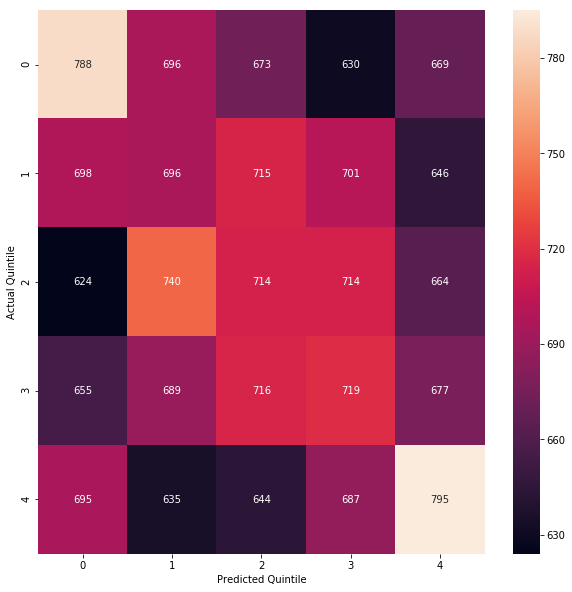

Epoch 1/500
697/697 [==============================] - 1s 1ms/step - loss: 27.7800 - Output01_loss: 0.7968 - Output02_loss: 0.9722 - Output03_loss: 1.1300 - Output04_loss: 1.0272 - Output05_loss: 0.8251 - Output06_loss: 0.8148 - Output07_loss: 0.9284 - Output08_loss: 0.8930 - Output09_loss: 0.7494 - Output10_loss: 0.9509 - Output11_loss: 0.7101 - Output12_loss: 1.0107 - Output13_loss: 0.7865 - Output14_loss: 0.8711 - Output15_loss: 0.9816 - Output16_loss: 0.9136 - Output17_loss: 1.1400 - Output18_loss: 1.2014 - Output19_loss: 1.0332 - Output20_loss: 1.0167 - Output21_loss: 0.9614 - Output22_loss: 0.9000 - Output23_loss: 0.9345 - Output24_loss: 0.6451 - Output25_loss: 0.8669 - Output26_loss: 0.6452 - Output27_loss: 0.8189 - Output28_loss: 0.9095 - Output29_loss: 0.7703 - Output30_loss: 0.7925 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_ac

697/697 [==============================] - 1s 1ms/step - loss: 27.7555 - Output01_loss: 0.7970 - Output02_loss: 0.9717 - Output03_loss: 1.1299 - Output04_loss: 1.0294 - Output05_loss: 0.8221 - Output06_loss: 0.8150 - Output07_loss: 0.9303 - Output08_loss: 0.8929 - Output09_loss: 0.7502 - Output10_loss: 0.9448 - Output11_loss: 0.7083 - Output12_loss: 1.0121 - Output13_loss: 0.7835 - Output14_loss: 0.8716 - Output15_loss: 0.9809 - Output16_loss: 0.9136 - Output17_loss: 1.1415 - Output18_loss: 1.2020 - Output19_loss: 1.0340 - Output20_loss: 1.0169 - Output21_loss: 0.9609 - Output22_loss: 0.8994 - Output23_loss: 0.9352 - Output24_loss: 0.6394 - Output25_loss: 0.8653 - Output26_loss: 0.6423 - Output27_loss: 0.8192 - Output28_loss: 0.9109 - Output29_loss: 0.7686 - Output30_loss: 0.7898 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8102 - Output01_loss: 0.7991 - Output02_loss: 0.9717 - Output03_loss: 1.1354 - Output04_loss: 1.0352 - Output05_loss: 0.8267 - Output06_loss: 0.8167 - Output07_loss: 0.9322 - Output08_loss: 0.8937 - Output09_loss: 0.7510 - Output10_loss: 0.9591 - Output11_loss: 0.7132 - Output12_loss: 1.0128 - Output13_loss: 0.7838 - Output14_loss: 0.8690 - Output15_loss: 0.9817 - Output16_loss: 0.9138 - Output17_loss: 1.1384 - Output18_loss: 1.2026 - Output19_loss: 1.0360 - Output20_loss: 1.0264 - Output21_loss: 0.9613 - Output22_loss: 0.8987 - Output23_loss: 0.9354 - Output24_loss: 0.6431 - Output25_loss: 0.8665 - Output26_loss: 0.6460 - Output27_loss: 0.8191 - Output28_loss: 0.9173 - Output29_loss: 0.7700 - Output30_loss: 0.7885 - Output01_acc: 0.6844 - Output02_acc: 0.5552 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7593 - Output01_loss: 0.7976 - Output02_loss: 0.9725 - Output03_loss: 1.1307 - Output04_loss: 1.0277 - Output05_loss: 0.8220 - Output06_loss: 0.8150 - Output07_loss: 0.9326 - Output08_loss: 0.8933 - Output09_loss: 0.7493 - Output10_loss: 0.9534 - Output11_loss: 0.7112 - Output12_loss: 1.0125 - Output13_loss: 0.7812 - Output14_loss: 0.8712 - Output15_loss: 0.9818 - Output16_loss: 0.9130 - Output17_loss: 1.1407 - Output18_loss: 1.2038 - Output19_loss: 1.0358 - Output20_loss: 1.0251 - Output21_loss: 0.9640 - Output22_loss: 0.8981 - Output23_loss: 0.9352 - Output24_loss: 0.6419 - Output25_loss: 0.8645 - Output26_loss: 0.6443 - Output27_loss: 0.8178 - Output28_loss: 0.9103 - Output29_loss: 0.7684 - Output30_loss: 0.7892 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7786 - Output01_loss: 0.7968 - Output02_loss: 0.9744 - Output03_loss: 1.1330 - Output04_loss: 1.0321 - Output05_loss: 0.8224 - Output06_loss: 0.8120 - Output07_loss: 0.9284 - Output08_loss: 0.8909 - Output09_loss: 0.7516 - Output10_loss: 0.9519 - Output11_loss: 0.7088 - Output12_loss: 1.0138 - Output13_loss: 0.7830 - Output14_loss: 0.8692 - Output15_loss: 0.9801 - Output16_loss: 0.9128 - Output17_loss: 1.1390 - Output18_loss: 1.2062 - Output19_loss: 1.0327 - Output20_loss: 1.0229 - Output21_loss: 0.9623 - Output22_loss: 0.8984 - Output23_loss: 0.9351 - Output24_loss: 0.6397 - Output25_loss: 0.8650 - Output26_loss: 0.6426 - Output27_loss: 0.8203 - Output28_loss: 0.9183 - Output29_loss: 0.7709 - Output30_loss: 0.7897 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7582 - Output01_loss: 0.7966 - Output02_loss: 0.9754 - Output03_loss: 1.1302 - Output04_loss: 1.0271 - Output05_loss: 0.8226 - Output06_loss: 0.8146 - Output07_loss: 0.9302 - Output08_loss: 0.8918 - Output09_loss: 0.7509 - Output10_loss: 0.9522 - Output11_loss: 0.7096 - Output12_loss: 1.0135 - Output13_loss: 0.7861 - Output14_loss: 0.8702 - Output15_loss: 0.9803 - Output16_loss: 0.9135 - Output17_loss: 1.1396 - Output18_loss: 1.2023 - Output19_loss: 1.0346 - Output20_loss: 1.0189 - Output21_loss: 0.9611 - Output22_loss: 0.9024 - Output23_loss: 0.9367 - Output24_loss: 0.6426 - Output25_loss: 0.8648 - Output26_loss: 0.6391 - Output27_loss: 0.8180 - Output28_loss: 0.9105 - Output29_loss: 0.7719 - Output30_loss: 0.7898 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8262 - Output01_loss: 0.7983 - Output02_loss: 0.9711 - Output03_loss: 1.1348 - Output04_loss: 1.0270 - Output05_loss: 0.8242 - Output06_loss: 0.8131 - Output07_loss: 0.9349 - Output08_loss: 0.8931 - Output09_loss: 0.7499 - Output10_loss: 0.9574 - Output11_loss: 0.7121 - Output12_loss: 1.0129 - Output13_loss: 0.7875 - Output14_loss: 0.8680 - Output15_loss: 0.9819 - Output16_loss: 0.9139 - Output17_loss: 1.1371 - Output18_loss: 1.2093 - Output19_loss: 1.0365 - Output20_loss: 1.0264 - Output21_loss: 0.9618 - Output22_loss: 0.9002 - Output23_loss: 0.9368 - Output24_loss: 0.6428 - Output25_loss: 0.8651 - Output26_loss: 0.6430 - Output27_loss: 0.8180 - Output28_loss: 0.9157 - Output29_loss: 0.7692 - Output30_loss: 0.7901 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8686 - Output01_loss: 0.7979 - Output02_loss: 0.9692 - Output03_loss: 1.1296 - Output04_loss: 1.0366 - Output05_loss: 0.8275 - Output06_loss: 0.8164 - Output07_loss: 0.9328 - Output08_loss: 0.8928 - Output09_loss: 0.7543 - Output10_loss: 0.9661 - Output11_loss: 0.7158 - Output12_loss: 1.0127 - Output13_loss: 0.7844 - Output14_loss: 0.8734 - Output15_loss: 0.9820 - Output16_loss: 0.9121 - Output17_loss: 1.1448 - Output18_loss: 1.2108 - Output19_loss: 1.0350 - Output20_loss: 1.0268 - Output21_loss: 0.9696 - Output22_loss: 0.9014 - Output23_loss: 0.9386 - Output24_loss: 0.6410 - Output25_loss: 0.8670 - Output26_loss: 0.6483 - Output27_loss: 0.8193 - Output28_loss: 0.9200 - Output29_loss: 0.7686 - Output30_loss: 0.7902 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7720 - Output01_loss: 0.7976 - Output02_loss: 0.9718 - Output03_loss: 1.1307 - Output04_loss: 1.0305 - Output05_loss: 0.8234 - Output06_loss: 0.8146 - Output07_loss: 0.9309 - Output08_loss: 0.8897 - Output09_loss: 0.7501 - Output10_loss: 0.9495 - Output11_loss: 0.7093 - Output12_loss: 1.0124 - Output13_loss: 0.7844 - Output14_loss: 0.8710 - Output15_loss: 0.9818 - Output16_loss: 0.9139 - Output17_loss: 1.1397 - Output18_loss: 1.2019 - Output19_loss: 1.0340 - Output20_loss: 1.0196 - Output21_loss: 0.9634 - Output22_loss: 0.8987 - Output23_loss: 0.9367 - Output24_loss: 0.6435 - Output25_loss: 0.8660 - Output26_loss: 0.6405 - Output27_loss: 0.8185 - Output28_loss: 0.9123 - Output29_loss: 0.7694 - Output30_loss: 0.7920 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5022 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7462 - Output01_loss: 0.7974 - Output02_loss: 0.9721 - Output03_loss: 1.1292 - Output04_loss: 1.0301 - Output05_loss: 0.8217 - Output06_loss: 0.8148 - Output07_loss: 0.9301 - Output08_loss: 0.8933 - Output09_loss: 0.7496 - Output10_loss: 0.9518 - Output11_loss: 0.7099 - Output12_loss: 1.0124 - Output13_loss: 0.7830 - Output14_loss: 0.8709 - Output15_loss: 0.9816 - Output16_loss: 0.9131 - Output17_loss: 1.1408 - Output18_loss: 1.2022 - Output19_loss: 1.0350 - Output20_loss: 1.0194 - Output21_loss: 0.9629 - Output22_loss: 0.8980 - Output23_loss: 0.9350 - Output24_loss: 0.6420 - Output25_loss: 0.8643 - Output26_loss: 0.6438 - Output27_loss: 0.8180 - Output28_loss: 0.9073 - Output29_loss: 0.7687 - Output30_loss: 0.7894 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7563 - Output01_loss: 0.7969 - Output02_loss: 0.9715 - Output03_loss: 1.1303 - Output04_loss: 1.0279 - Output05_loss: 0.8233 - Output06_loss: 0.8152 - Output07_loss: 0.9288 - Output08_loss: 0.8924 - Output09_loss: 0.7490 - Output10_loss: 0.9510 - Output11_loss: 0.7088 - Output12_loss: 1.0129 - Output13_loss: 0.7827 - Output14_loss: 0.8693 - Output15_loss: 0.9809 - Output16_loss: 0.9133 - Output17_loss: 1.1401 - Output18_loss: 1.2056 - Output19_loss: 1.0337 - Output20_loss: 1.0167 - Output21_loss: 0.9622 - Output22_loss: 0.8955 - Output23_loss: 0.9365 - Output24_loss: 0.6405 - Output25_loss: 0.8652 - Output26_loss: 0.6392 - Output27_loss: 0.8167 - Output28_loss: 0.9090 - Output29_loss: 0.7690 - Output30_loss: 0.7899 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7523 - Output01_loss: 0.7979 - Output02_loss: 0.9733 - Output03_loss: 1.1303 - Output04_loss: 1.0282 - Output05_loss: 0.8239 - Output06_loss: 0.8144 - Output07_loss: 0.9310 - Output08_loss: 0.8925 - Output09_loss: 0.7508 - Output10_loss: 0.9515 - Output11_loss: 0.7107 - Output12_loss: 1.0126 - Output13_loss: 0.7840 - Output14_loss: 0.8703 - Output15_loss: 0.9803 - Output16_loss: 0.9129 - Output17_loss: 1.1407 - Output18_loss: 1.2035 - Output19_loss: 1.0336 - Output20_loss: 1.0197 - Output21_loss: 0.9617 - Output22_loss: 0.8994 - Output23_loss: 0.9339 - Output24_loss: 0.6401 - Output25_loss: 0.8653 - Output26_loss: 0.6416 - Output27_loss: 0.8169 - Output28_loss: 0.9069 - Output29_loss: 0.7689 - Output30_loss: 0.7900 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7703 - Output01_loss: 0.7976 - Output02_loss: 0.9738 - Output03_loss: 1.1318 - Output04_loss: 1.0275 - Output05_loss: 0.8234 - Output06_loss: 0.8141 - Output07_loss: 0.9292 - Output08_loss: 0.8914 - Output09_loss: 0.7508 - Output10_loss: 0.9498 - Output11_loss: 0.7127 - Output12_loss: 1.0130 - Output13_loss: 0.7826 - Output14_loss: 0.8711 - Output15_loss: 0.9805 - Output16_loss: 0.9127 - Output17_loss: 1.1395 - Output18_loss: 1.2059 - Output19_loss: 1.0363 - Output20_loss: 1.0208 - Output21_loss: 0.9651 - Output22_loss: 0.8980 - Output23_loss: 0.9353 - Output24_loss: 0.6423 - Output25_loss: 0.8649 - Output26_loss: 0.6459 - Output27_loss: 0.8184 - Output28_loss: 0.9134 - Output29_loss: 0.7694 - Output30_loss: 0.7900 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 950us/step - loss: 27.7521 - Output01_loss: 0.7977 - Output02_loss: 0.9722 - Output03_loss: 1.1326 - Output04_loss: 1.0283 - Output05_loss: 0.8228 - Output06_loss: 0.8145 - Output07_loss: 0.9290 - Output08_loss: 0.8920 - Output09_loss: 0.7511 - Output10_loss: 0.9521 - Output11_loss: 0.7125 - Output12_loss: 1.0124 - Output13_loss: 0.7823 - Output14_loss: 0.8694 - Output15_loss: 0.9811 - Output16_loss: 0.9132 - Output17_loss: 1.1401 - Output18_loss: 1.2026 - Output19_loss: 1.0338 - Output20_loss: 1.0238 - Output21_loss: 0.9620 - Output22_loss: 0.8983 - Output23_loss: 0.9344 - Output24_loss: 0.6424 - Output25_loss: 0.8655 - Output26_loss: 0.6425 - Output27_loss: 0.8186 - Output28_loss: 0.9091 - Output29_loss: 0.7684 - Output30_loss: 0.7891 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.7758 - Output01_loss: 0.7976 - Output02_loss: 0.9717 - Output03_loss: 1.1317 - Output04_loss: 1.0287 - Output05_loss: 0.8262 - Output06_loss: 0.8144 - Output07_loss: 0.9268 - Output08_loss: 0.8919 - Output09_loss: 0.7530 - Output10_loss: 0.9535 - Output11_loss: 0.7126 - Output12_loss: 1.0129 - Output13_loss: 0.7833 - Output14_loss: 0.8709 - Output15_loss: 0.9810 - Output16_loss: 0.9126 - Output17_loss: 1.1390 - Output18_loss: 1.2057 - Output19_loss: 1.0334 - Output20_loss: 1.0188 - Output21_loss: 0.9597 - Output22_loss: 0.8974 - Output23_loss: 0.9335 - Output24_loss: 0.6404 - Output25_loss: 0.8650 - Output26_loss: 0.6420 - Output27_loss: 0.8188 - Output28_loss: 0.9093 - Output29_loss: 0.7689 - Output30_loss: 0.7903 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 995us/step - loss: 27.7802 - Output01_loss: 0.7976 - Output02_loss: 0.9757 - Output03_loss: 1.1323 - Output04_loss: 1.0286 - Output05_loss: 0.8247 - Output06_loss: 0.8171 - Output07_loss: 0.9296 - Output08_loss: 0.8923 - Output09_loss: 0.7529 - Output10_loss: 0.9521 - Output11_loss: 0.7131 - Output12_loss: 1.0126 - Output13_loss: 0.7855 - Output14_loss: 0.8711 - Output15_loss: 0.9810 - Output16_loss: 0.9140 - Output17_loss: 1.1401 - Output18_loss: 1.2034 - Output19_loss: 1.0361 - Output20_loss: 1.0224 - Output21_loss: 0.9615 - Output22_loss: 0.9000 - Output23_loss: 0.9351 - Output24_loss: 0.6415 - Output25_loss: 0.8648 - Output26_loss: 0.6466 - Output27_loss: 0.8184 - Output28_loss: 0.9173 - Output29_loss: 0.7695 - Output30_loss: 0.7900 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.7974 - Output01_loss: 0.7976 - Output02_loss: 0.9719 - Output03_loss: 1.1332 - Output04_loss: 1.0310 - Output05_loss: 0.8194 - Output06_loss: 0.8162 - Output07_loss: 0.9284 - Output08_loss: 0.8947 - Output09_loss: 0.7509 - Output10_loss: 0.9572 - Output11_loss: 0.7092 - Output12_loss: 1.0140 - Output13_loss: 0.7836 - Output14_loss: 0.8717 - Output15_loss: 0.9802 - Output16_loss: 0.9130 - Output17_loss: 1.1434 - Output18_loss: 1.2038 - Output19_loss: 1.0352 - Output20_loss: 1.0191 - Output21_loss: 0.9604 - Output22_loss: 0.8989 - Output23_loss: 0.9350 - Output24_loss: 0.6408 - Output25_loss: 0.8655 - Output26_loss: 0.6478 - Output27_loss: 0.8188 - Output28_loss: 0.9091 - Output29_loss: 0.7694 - Output30_loss: 0.7892 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8487 - Output01_loss: 0.7971 - Output02_loss: 0.9733 - Output03_loss: 1.1290 - Output04_loss: 1.0344 - Output05_loss: 0.8309 - Output06_loss: 0.8152 - Output07_loss: 0.9298 - Output08_loss: 0.8959 - Output09_loss: 0.7497 - Output10_loss: 0.9582 - Output11_loss: 0.7120 - Output12_loss: 1.0125 - Output13_loss: 0.7851 - Output14_loss: 0.8705 - Output15_loss: 0.9815 - Output16_loss: 0.9125 - Output17_loss: 1.1402 - Output18_loss: 1.2072 - Output19_loss: 1.0344 - Output20_loss: 1.0270 - Output21_loss: 0.9633 - Output22_loss: 0.8962 - Output23_loss: 0.9365 - Output24_loss: 0.6410 - Output25_loss: 0.8664 - Output26_loss: 0.6444 - Output27_loss: 0.8194 - Output28_loss: 0.9152 - Output29_loss: 0.7677 - Output30_loss: 0.7867 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4046 - Output04_acc: 0.4964 - Output05_acc: 0.6614 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8145 - Output01_loss: 0.7981 - Output02_loss: 0.9735 - Output03_loss: 1.1305 - Output04_loss: 1.0333 - Output05_loss: 0.8276 - Output06_loss: 0.8155 - Output07_loss: 0.9333 - Output08_loss: 0.8927 - Output09_loss: 0.7522 - Output10_loss: 0.9507 - Output11_loss: 0.7151 - Output12_loss: 1.0124 - Output13_loss: 0.7824 - Output14_loss: 0.8700 - Output15_loss: 0.9815 - Output16_loss: 0.9147 - Output17_loss: 1.1375 - Output18_loss: 1.2048 - Output19_loss: 1.0388 - Output20_loss: 1.0270 - Output21_loss: 0.9622 - Output22_loss: 0.8969 - Output23_loss: 0.9378 - Output24_loss: 0.6404 - Output25_loss: 0.8655 - Output26_loss: 0.6435 - Output27_loss: 0.8182 - Output28_loss: 0.9097 - Output29_loss: 0.7684 - Output30_loss: 0.7880 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 908us/step - loss: 27.7739 - Output01_loss: 0.7975 - Output02_loss: 0.9722 - Output03_loss: 1.1331 - Output04_loss: 1.0321 - Output05_loss: 0.8236 - Output06_loss: 0.8138 - Output07_loss: 0.9290 - Output08_loss: 0.8918 - Output09_loss: 0.7504 - Output10_loss: 0.9517 - Output11_loss: 0.7070 - Output12_loss: 1.0125 - Output13_loss: 0.7822 - Output14_loss: 0.8698 - Output15_loss: 0.9808 - Output16_loss: 0.9139 - Output17_loss: 1.1391 - Output18_loss: 1.2049 - Output19_loss: 1.0350 - Output20_loss: 1.0215 - Output21_loss: 0.9609 - Output22_loss: 0.8971 - Output23_loss: 0.9335 - Output24_loss: 0.6419 - Output25_loss: 0.8652 - Output26_loss: 0.6415 - Output27_loss: 0.8174 - Output28_loss: 0.9079 - Output29_loss: 0.7693 - Output30_loss: 0.7874 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.8084 - Output01_loss: 0.7971 - Output02_loss: 0.9719 - Output03_loss: 1.1308 - Output04_loss: 1.0334 - Output05_loss: 0.8211 - Output06_loss: 0.8135 - Output07_loss: 0.9283 - Output08_loss: 0.8915 - Output09_loss: 0.7545 - Output10_loss: 0.9536 - Output11_loss: 0.7055 - Output12_loss: 1.0126 - Output13_loss: 0.7841 - Output14_loss: 0.8731 - Output15_loss: 0.9815 - Output16_loss: 0.9145 - Output17_loss: 1.1391 - Output18_loss: 1.2043 - Output19_loss: 1.0369 - Output20_loss: 1.0141 - Output21_loss: 0.9596 - Output22_loss: 0.8994 - Output23_loss: 0.9365 - Output24_loss: 0.6427 - Output25_loss: 0.8653 - Output26_loss: 0.6457 - Output27_loss: 0.8187 - Output28_loss: 0.9140 - Output29_loss: 0.7685 - Output30_loss: 0.7919 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4032 - Output04_acc: 0.5022 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 972us/step - loss: 27.8141 - Output01_loss: 0.7979 - Output02_loss: 0.9731 - Output03_loss: 1.1354 - Output04_loss: 1.0294 - Output05_loss: 0.8244 - Output06_loss: 0.8140 - Output07_loss: 0.9289 - Output08_loss: 0.8963 - Output09_loss: 0.7505 - Output10_loss: 0.9505 - Output11_loss: 0.7155 - Output12_loss: 1.0117 - Output13_loss: 0.7834 - Output14_loss: 0.8694 - Output15_loss: 0.9806 - Output16_loss: 0.9133 - Output17_loss: 1.1417 - Output18_loss: 1.2016 - Output19_loss: 1.0327 - Output20_loss: 1.0276 - Output21_loss: 0.9628 - Output22_loss: 0.8986 - Output23_loss: 0.9350 - Output24_loss: 0.6434 - Output25_loss: 0.8661 - Output26_loss: 0.6449 - Output27_loss: 0.8175 - Output28_loss: 0.9156 - Output29_loss: 0.7693 - Output30_loss: 0.7894 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.7701 - Output01_loss: 0.7981 - Output02_loss: 0.9726 - Output03_loss: 1.1341 - Output04_loss: 1.0295 - Output05_loss: 0.8257 - Output06_loss: 0.8148 - Output07_loss: 0.9305 - Output08_loss: 0.8917 - Output09_loss: 0.7498 - Output10_loss: 0.9514 - Output11_loss: 0.7123 - Output12_loss: 1.0121 - Output13_loss: 0.7821 - Output14_loss: 0.8686 - Output15_loss: 0.9808 - Output16_loss: 0.9123 - Output17_loss: 1.1409 - Output18_loss: 1.2073 - Output19_loss: 1.0348 - Output20_loss: 1.0266 - Output21_loss: 0.9612 - Output22_loss: 0.8990 - Output23_loss: 0.9335 - Output24_loss: 0.6404 - Output25_loss: 0.8658 - Output26_loss: 0.6430 - Output27_loss: 0.8178 - Output28_loss: 0.9146 - Output29_loss: 0.7698 - Output30_loss: 0.7876 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7819 - Output01_loss: 0.7985 - Output02_loss: 0.9725 - Output03_loss: 1.1320 - Output04_loss: 1.0271 - Output05_loss: 0.8244 - Output06_loss: 0.8152 - Output07_loss: 0.9299 - Output08_loss: 0.8937 - Output09_loss: 0.7487 - Output10_loss: 0.9526 - Output11_loss: 0.7098 - Output12_loss: 1.0128 - Output13_loss: 0.7822 - Output14_loss: 0.8700 - Output15_loss: 0.9822 - Output16_loss: 0.9138 - Output17_loss: 1.1405 - Output18_loss: 1.2019 - Output19_loss: 1.0348 - Output20_loss: 1.0233 - Output21_loss: 0.9621 - Output22_loss: 0.8996 - Output23_loss: 0.9369 - Output24_loss: 0.6436 - Output25_loss: 0.8651 - Output26_loss: 0.6422 - Output27_loss: 0.8183 - Output28_loss: 0.9125 - Output29_loss: 0.7690 - Output30_loss: 0.7899 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7935 - Output01_loss: 0.7980 - Output02_loss: 0.9729 - Output03_loss: 1.1323 - Output04_loss: 1.0301 - Output05_loss: 0.8217 - Output06_loss: 0.8154 - Output07_loss: 0.9366 - Output08_loss: 0.8925 - Output09_loss: 0.7510 - Output10_loss: 0.9556 - Output11_loss: 0.7085 - Output12_loss: 1.0135 - Output13_loss: 0.7863 - Output14_loss: 0.8707 - Output15_loss: 0.9813 - Output16_loss: 0.9140 - Output17_loss: 1.1400 - Output18_loss: 1.2031 - Output19_loss: 1.0350 - Output20_loss: 1.0222 - Output21_loss: 0.9632 - Output22_loss: 0.8993 - Output23_loss: 0.9325 - Output24_loss: 0.6395 - Output25_loss: 0.8658 - Output26_loss: 0.6426 - Output27_loss: 0.8179 - Output28_loss: 0.9103 - Output29_loss: 0.7712 - Output30_loss: 0.7898 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7670 - Output01_loss: 0.7976 - Output02_loss: 0.9718 - Output03_loss: 1.1319 - Output04_loss: 1.0274 - Output05_loss: 0.8209 - Output06_loss: 0.8132 - Output07_loss: 0.9277 - Output08_loss: 0.8933 - Output09_loss: 0.7520 - Output10_loss: 0.9531 - Output11_loss: 0.7088 - Output12_loss: 1.0128 - Output13_loss: 0.7818 - Output14_loss: 0.8699 - Output15_loss: 0.9807 - Output16_loss: 0.9137 - Output17_loss: 1.1396 - Output18_loss: 1.2048 - Output19_loss: 1.0343 - Output20_loss: 1.0137 - Output21_loss: 0.9611 - Output22_loss: 0.8988 - Output23_loss: 0.9351 - Output24_loss: 0.6415 - Output25_loss: 0.8647 - Output26_loss: 0.6430 - Output27_loss: 0.8187 - Output28_loss: 0.9118 - Output29_loss: 0.7700 - Output30_loss: 0.7900 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8444 - Output01_loss: 0.7972 - Output02_loss: 0.9748 - Output03_loss: 1.1328 - Output04_loss: 1.0389 - Output05_loss: 0.8249 - Output06_loss: 0.8149 - Output07_loss: 0.9330 - Output08_loss: 0.8969 - Output09_loss: 0.7584 - Output10_loss: 0.9553 - Output11_loss: 0.7147 - Output12_loss: 1.0138 - Output13_loss: 0.7862 - Output14_loss: 0.8724 - Output15_loss: 0.9828 - Output16_loss: 0.9127 - Output17_loss: 1.1418 - Output18_loss: 1.2051 - Output19_loss: 1.0382 - Output20_loss: 1.0274 - Output21_loss: 0.9634 - Output22_loss: 0.8958 - Output23_loss: 0.9370 - Output24_loss: 0.6420 - Output25_loss: 0.8665 - Output26_loss: 0.6520 - Output27_loss: 0.8191 - Output28_loss: 0.9154 - Output29_loss: 0.7688 - Output30_loss: 0.7897 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8168 - Output01_loss: 0.7967 - Output02_loss: 0.9740 - Output03_loss: 1.1349 - Output04_loss: 1.0338 - Output05_loss: 0.8252 - Output06_loss: 0.8153 - Output07_loss: 0.9277 - Output08_loss: 0.8933 - Output09_loss: 0.7529 - Output10_loss: 0.9504 - Output11_loss: 0.7120 - Output12_loss: 1.0141 - Output13_loss: 0.7859 - Output14_loss: 0.8696 - Output15_loss: 0.9805 - Output16_loss: 0.9131 - Output17_loss: 1.1403 - Output18_loss: 1.2074 - Output19_loss: 1.0361 - Output20_loss: 1.0189 - Output21_loss: 0.9625 - Output22_loss: 0.9002 - Output23_loss: 0.9360 - Output24_loss: 0.6467 - Output25_loss: 0.8646 - Output26_loss: 0.6512 - Output27_loss: 0.8224 - Output28_loss: 0.9089 - Output29_loss: 0.7736 - Output30_loss: 0.7953 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8151 - Output01_loss: 0.7971 - Output02_loss: 0.9712 - Output03_loss: 1.1353 - Output04_loss: 1.0379 - Output05_loss: 0.8212 - Output06_loss: 0.8138 - Output07_loss: 0.9296 - Output08_loss: 0.8950 - Output09_loss: 0.7504 - Output10_loss: 0.9586 - Output11_loss: 0.7126 - Output12_loss: 1.0123 - Output13_loss: 0.7832 - Output14_loss: 0.8686 - Output15_loss: 0.9809 - Output16_loss: 0.9124 - Output17_loss: 1.1408 - Output18_loss: 1.2066 - Output19_loss: 1.0368 - Output20_loss: 1.0245 - Output21_loss: 0.9669 - Output22_loss: 0.8957 - Output23_loss: 0.9381 - Output24_loss: 0.6399 - Output25_loss: 0.8650 - Output26_loss: 0.6424 - Output27_loss: 0.8190 - Output28_loss: 0.9170 - Output29_loss: 0.7698 - Output30_loss: 0.7914 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7597 - Output01_loss: 0.7981 - Output02_loss: 0.9730 - Output03_loss: 1.1297 - Output04_loss: 1.0280 - Output05_loss: 0.8218 - Output06_loss: 0.8141 - Output07_loss: 0.9304 - Output08_loss: 0.8920 - Output09_loss: 0.7501 - Output10_loss: 0.9484 - Output11_loss: 0.7069 - Output12_loss: 1.0132 - Output13_loss: 0.7832 - Output14_loss: 0.8700 - Output15_loss: 0.9811 - Output16_loss: 0.9131 - Output17_loss: 1.1408 - Output18_loss: 1.2045 - Output19_loss: 1.0332 - Output20_loss: 1.0223 - Output21_loss: 0.9602 - Output22_loss: 0.8966 - Output23_loss: 0.9337 - Output24_loss: 0.6410 - Output25_loss: 0.8641 - Output26_loss: 0.6410 - Output27_loss: 0.8189 - Output28_loss: 0.9095 - Output29_loss: 0.7697 - Output30_loss: 0.7898 - Output01_acc: 0.6844 - Output02_acc: 0.5524 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.9069 - Output01_loss: 0.8004 - Output02_loss: 0.9727 - Output03_loss: 1.1412 - Output04_loss: 1.0386 - Output05_loss: 0.8269 - Output06_loss: 0.8165 - Output07_loss: 0.9390 - Output08_loss: 0.8968 - Output09_loss: 0.7561 - Output10_loss: 0.9752 - Output11_loss: 0.7151 - Output12_loss: 1.0137 - Output13_loss: 0.7823 - Output14_loss: 0.8694 - Output15_loss: 0.9821 - Output16_loss: 0.9136 - Output17_loss: 1.1427 - Output18_loss: 1.2071 - Output19_loss: 1.0405 - Output20_loss: 1.0398 - Output21_loss: 0.9666 - Output22_loss: 0.9027 - Output23_loss: 0.9361 - Output24_loss: 0.6407 - Output25_loss: 0.8648 - Output26_loss: 0.6478 - Output27_loss: 0.8189 - Output28_loss: 0.9278 - Output29_loss: 0.7686 - Output30_loss: 0.7885 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3960 - Output04_acc: 0.5007 - Output05_acc: 0.6585 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7610 - Output01_loss: 0.7973 - Output02_loss: 0.9713 - Output03_loss: 1.1326 - Output04_loss: 1.0306 - Output05_loss: 0.8218 - Output06_loss: 0.8140 - Output07_loss: 0.9294 - Output08_loss: 0.8912 - Output09_loss: 0.7523 - Output10_loss: 0.9516 - Output11_loss: 0.7097 - Output12_loss: 1.0125 - Output13_loss: 0.7811 - Output14_loss: 0.8693 - Output15_loss: 0.9806 - Output16_loss: 0.9132 - Output17_loss: 1.1387 - Output18_loss: 1.2051 - Output19_loss: 1.0355 - Output20_loss: 1.0215 - Output21_loss: 0.9613 - Output22_loss: 0.8981 - Output23_loss: 0.9353 - Output24_loss: 0.6417 - Output25_loss: 0.8648 - Output26_loss: 0.6444 - Output27_loss: 0.8166 - Output28_loss: 0.9122 - Output29_loss: 0.7691 - Output30_loss: 0.7887 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8161 - Output01_loss: 0.7968 - Output02_loss: 0.9723 - Output03_loss: 1.1306 - Output04_loss: 1.0341 - Output05_loss: 0.8237 - Output06_loss: 0.8137 - Output07_loss: 0.9320 - Output08_loss: 0.8928 - Output09_loss: 0.7521 - Output10_loss: 0.9579 - Output11_loss: 0.7080 - Output12_loss: 1.0128 - Output13_loss: 0.7830 - Output14_loss: 0.8713 - Output15_loss: 0.9820 - Output16_loss: 0.9130 - Output17_loss: 1.1397 - Output18_loss: 1.2077 - Output19_loss: 1.0383 - Output20_loss: 1.0251 - Output21_loss: 0.9616 - Output22_loss: 0.9011 - Output23_loss: 0.9345 - Output24_loss: 0.6416 - Output25_loss: 0.8651 - Output26_loss: 0.6424 - Output27_loss: 0.8180 - Output28_loss: 0.9180 - Output29_loss: 0.7687 - Output30_loss: 0.7888 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4003 - Output04_acc: 0.5022 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7927 - Output01_loss: 0.7978 - Output02_loss: 0.9716 - Output03_loss: 1.1344 - Output04_loss: 1.0298 - Output05_loss: 0.8257 - Output06_loss: 0.8135 - Output07_loss: 0.9324 - Output08_loss: 0.8936 - Output09_loss: 0.7538 - Output10_loss: 0.9577 - Output11_loss: 0.7117 - Output12_loss: 1.0122 - Output13_loss: 0.7845 - Output14_loss: 0.8690 - Output15_loss: 0.9809 - Output16_loss: 0.9134 - Output17_loss: 1.1389 - Output18_loss: 1.2083 - Output19_loss: 1.0335 - Output20_loss: 1.0295 - Output21_loss: 0.9602 - Output22_loss: 0.8986 - Output23_loss: 0.9330 - Output24_loss: 0.6440 - Output25_loss: 0.8652 - Output26_loss: 0.6429 - Output27_loss: 0.8176 - Output28_loss: 0.9159 - Output29_loss: 0.7683 - Output30_loss: 0.7899 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7716 - Output01_loss: 0.7985 - Output02_loss: 0.9740 - Output03_loss: 1.1337 - Output04_loss: 1.0272 - Output05_loss: 0.8224 - Output06_loss: 0.8135 - Output07_loss: 0.9260 - Output08_loss: 0.8922 - Output09_loss: 0.7500 - Output10_loss: 0.9506 - Output11_loss: 0.7115 - Output12_loss: 1.0136 - Output13_loss: 0.7847 - Output14_loss: 0.8699 - Output15_loss: 0.9806 - Output16_loss: 0.9125 - Output17_loss: 1.1398 - Output18_loss: 1.2037 - Output19_loss: 1.0310 - Output20_loss: 1.0205 - Output21_loss: 0.9598 - Output22_loss: 0.8990 - Output23_loss: 0.9342 - Output24_loss: 0.6431 - Output25_loss: 0.8661 - Output26_loss: 0.6428 - Output27_loss: 0.8187 - Output28_loss: 0.9091 - Output29_loss: 0.7692 - Output30_loss: 0.7910 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7505 - Output01_loss: 0.7969 - Output02_loss: 0.9726 - Output03_loss: 1.1302 - Output04_loss: 1.0286 - Output05_loss: 0.8198 - Output06_loss: 0.8145 - Output07_loss: 0.9283 - Output08_loss: 0.8922 - Output09_loss: 0.7499 - Output10_loss: 0.9509 - Output11_loss: 0.7098 - Output12_loss: 1.0130 - Output13_loss: 0.7861 - Output14_loss: 0.8711 - Output15_loss: 0.9805 - Output16_loss: 0.9134 - Output17_loss: 1.1409 - Output18_loss: 1.2024 - Output19_loss: 1.0309 - Output20_loss: 1.0166 - Output21_loss: 0.9604 - Output22_loss: 0.8992 - Output23_loss: 0.9368 - Output24_loss: 0.6401 - Output25_loss: 0.8653 - Output26_loss: 0.6414 - Output27_loss: 0.8186 - Output28_loss: 0.9071 - Output29_loss: 0.7696 - Output30_loss: 0.7877 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7760 - Output01_loss: 0.7974 - Output02_loss: 0.9724 - Output03_loss: 1.1301 - Output04_loss: 1.0289 - Output05_loss: 0.8247 - Output06_loss: 0.8154 - Output07_loss: 0.9331 - Output08_loss: 0.8915 - Output09_loss: 0.7504 - Output10_loss: 0.9522 - Output11_loss: 0.7117 - Output12_loss: 1.0129 - Output13_loss: 0.7841 - Output14_loss: 0.8707 - Output15_loss: 0.9809 - Output16_loss: 0.9122 - Output17_loss: 1.1392 - Output18_loss: 1.2032 - Output19_loss: 1.0343 - Output20_loss: 1.0228 - Output21_loss: 0.9618 - Output22_loss: 0.8963 - Output23_loss: 0.9353 - Output24_loss: 0.6418 - Output25_loss: 0.8635 - Output26_loss: 0.6412 - Output27_loss: 0.8200 - Output28_loss: 0.9127 - Output29_loss: 0.7711 - Output30_loss: 0.7884 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7818 - Output01_loss: 0.7982 - Output02_loss: 0.9765 - Output03_loss: 1.1320 - Output04_loss: 1.0310 - Output05_loss: 0.8263 - Output06_loss: 0.8147 - Output07_loss: 0.9311 - Output08_loss: 0.8931 - Output09_loss: 0.7516 - Output10_loss: 0.9515 - Output11_loss: 0.7120 - Output12_loss: 1.0135 - Output13_loss: 0.7878 - Output14_loss: 0.8692 - Output15_loss: 0.9818 - Output16_loss: 0.9140 - Output17_loss: 1.1404 - Output18_loss: 1.2036 - Output19_loss: 1.0350 - Output20_loss: 1.0202 - Output21_loss: 0.9608 - Output22_loss: 0.9021 - Output23_loss: 0.9350 - Output24_loss: 0.6399 - Output25_loss: 0.8654 - Output26_loss: 0.6462 - Output27_loss: 0.8205 - Output28_loss: 0.9102 - Output29_loss: 0.7683 - Output30_loss: 0.7898 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8188 - Output01_loss: 0.7975 - Output02_loss: 0.9734 - Output03_loss: 1.1330 - Output04_loss: 1.0307 - Output05_loss: 0.8268 - Output06_loss: 0.8155 - Output07_loss: 0.9296 - Output08_loss: 0.8930 - Output09_loss: 0.7566 - Output10_loss: 0.9522 - Output11_loss: 0.7136 - Output12_loss: 1.0139 - Output13_loss: 0.7859 - Output14_loss: 0.8693 - Output15_loss: 0.9829 - Output16_loss: 0.9134 - Output17_loss: 1.1397 - Output18_loss: 1.2045 - Output19_loss: 1.0342 - Output20_loss: 1.0200 - Output21_loss: 0.9604 - Output22_loss: 0.8979 - Output23_loss: 0.9367 - Output24_loss: 0.6444 - Output25_loss: 0.8675 - Output26_loss: 0.6473 - Output27_loss: 0.8221 - Output28_loss: 0.9111 - Output29_loss: 0.7715 - Output30_loss: 0.7908 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7497 - Output01_loss: 0.7981 - Output02_loss: 0.9733 - Output03_loss: 1.1300 - Output04_loss: 1.0270 - Output05_loss: 0.8211 - Output06_loss: 0.8142 - Output07_loss: 0.9273 - Output08_loss: 0.8916 - Output09_loss: 0.7493 - Output10_loss: 0.9475 - Output11_loss: 0.7100 - Output12_loss: 1.0124 - Output13_loss: 0.7845 - Output14_loss: 0.8697 - Output15_loss: 0.9821 - Output16_loss: 0.9135 - Output17_loss: 1.1403 - Output18_loss: 1.2032 - Output19_loss: 1.0345 - Output20_loss: 1.0204 - Output21_loss: 0.9630 - Output22_loss: 0.8985 - Output23_loss: 0.9350 - Output24_loss: 0.6406 - Output25_loss: 0.8644 - Output26_loss: 0.6413 - Output27_loss: 0.8190 - Output28_loss: 0.9128 - Output29_loss: 0.7693 - Output30_loss: 0.7887 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7837 - Output01_loss: 0.7980 - Output02_loss: 0.9727 - Output03_loss: 1.1302 - Output04_loss: 1.0277 - Output05_loss: 0.8245 - Output06_loss: 0.8149 - Output07_loss: 0.9276 - Output08_loss: 0.8926 - Output09_loss: 0.7499 - Output10_loss: 0.9500 - Output11_loss: 0.7110 - Output12_loss: 1.0136 - Output13_loss: 0.7814 - Output14_loss: 0.8704 - Output15_loss: 0.9802 - Output16_loss: 0.9127 - Output17_loss: 1.1405 - Output18_loss: 1.2032 - Output19_loss: 1.0356 - Output20_loss: 1.0242 - Output21_loss: 0.9607 - Output22_loss: 0.8973 - Output23_loss: 0.9335 - Output24_loss: 0.6406 - Output25_loss: 0.8648 - Output26_loss: 0.6436 - Output27_loss: 0.8177 - Output28_loss: 0.9094 - Output29_loss: 0.7707 - Output30_loss: 0.7891 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8468 - Output01_loss: 0.7983 - Output02_loss: 0.9764 - Output03_loss: 1.1344 - Output04_loss: 1.0305 - Output05_loss: 0.8248 - Output06_loss: 0.8146 - Output07_loss: 0.9346 - Output08_loss: 0.8945 - Output09_loss: 0.7536 - Output10_loss: 0.9555 - Output11_loss: 0.7133 - Output12_loss: 1.0135 - Output13_loss: 0.7845 - Output14_loss: 0.8738 - Output15_loss: 0.9810 - Output16_loss: 0.9127 - Output17_loss: 1.1416 - Output18_loss: 1.2058 - Output19_loss: 1.0354 - Output20_loss: 1.0301 - Output21_loss: 0.9650 - Output22_loss: 0.9002 - Output23_loss: 0.9339 - Output24_loss: 0.6422 - Output25_loss: 0.8658 - Output26_loss: 0.6529 - Output27_loss: 0.8190 - Output28_loss: 0.9243 - Output29_loss: 0.7674 - Output30_loss: 0.7914 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7675 - Output01_loss: 0.7979 - Output02_loss: 0.9716 - Output03_loss: 1.1336 - Output04_loss: 1.0254 - Output05_loss: 0.8271 - Output06_loss: 0.8148 - Output07_loss: 0.9339 - Output08_loss: 0.8940 - Output09_loss: 0.7494 - Output10_loss: 0.9545 - Output11_loss: 0.7104 - Output12_loss: 1.0130 - Output13_loss: 0.7857 - Output14_loss: 0.8709 - Output15_loss: 0.9810 - Output16_loss: 0.9139 - Output17_loss: 1.1399 - Output18_loss: 1.2040 - Output19_loss: 1.0328 - Output20_loss: 1.0212 - Output21_loss: 0.9619 - Output22_loss: 0.8974 - Output23_loss: 0.9352 - Output24_loss: 0.6444 - Output25_loss: 0.8639 - Output26_loss: 0.6416 - Output27_loss: 0.8179 - Output28_loss: 0.9094 - Output29_loss: 0.7691 - Output30_loss: 0.7865 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7831 - Output01_loss: 0.7981 - Output02_loss: 0.9731 - Output03_loss: 1.1317 - Output04_loss: 1.0305 - Output05_loss: 0.8244 - Output06_loss: 0.8139 - Output07_loss: 0.9278 - Output08_loss: 0.8912 - Output09_loss: 0.7528 - Output10_loss: 0.9495 - Output11_loss: 0.7086 - Output12_loss: 1.0123 - Output13_loss: 0.7829 - Output14_loss: 0.8727 - Output15_loss: 0.9816 - Output16_loss: 0.9132 - Output17_loss: 1.1391 - Output18_loss: 1.2057 - Output19_loss: 1.0335 - Output20_loss: 1.0215 - Output21_loss: 0.9618 - Output22_loss: 0.8994 - Output23_loss: 0.9335 - Output24_loss: 0.6402 - Output25_loss: 0.8649 - Output26_loss: 0.6459 - Output27_loss: 0.8192 - Output28_loss: 0.9106 - Output29_loss: 0.7696 - Output30_loss: 0.7923 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7970 - Output01_loss: 0.7973 - Output02_loss: 0.9720 - Output03_loss: 1.1337 - Output04_loss: 1.0317 - Output05_loss: 0.8204 - Output06_loss: 0.8166 - Output07_loss: 0.9324 - Output08_loss: 0.8929 - Output09_loss: 0.7510 - Output10_loss: 0.9482 - Output11_loss: 0.7129 - Output12_loss: 1.0153 - Output13_loss: 0.7873 - Output14_loss: 0.8691 - Output15_loss: 0.9812 - Output16_loss: 0.9125 - Output17_loss: 1.1411 - Output18_loss: 1.2027 - Output19_loss: 1.0346 - Output20_loss: 1.0212 - Output21_loss: 0.9627 - Output22_loss: 0.8986 - Output23_loss: 0.9357 - Output24_loss: 0.6425 - Output25_loss: 0.8638 - Output26_loss: 0.6499 - Output27_loss: 0.8199 - Output28_loss: 0.9099 - Output29_loss: 0.7706 - Output30_loss: 0.7890 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 990us/step - loss: 27.7705 - Output01_loss: 0.7971 - Output02_loss: 0.9732 - Output03_loss: 1.1334 - Output04_loss: 1.0300 - Output05_loss: 0.8227 - Output06_loss: 0.8152 - Output07_loss: 0.9301 - Output08_loss: 0.8909 - Output09_loss: 0.7496 - Output10_loss: 0.9525 - Output11_loss: 0.7078 - Output12_loss: 1.0137 - Output13_loss: 0.7860 - Output14_loss: 0.8701 - Output15_loss: 0.9809 - Output16_loss: 0.9140 - Output17_loss: 1.1396 - Output18_loss: 1.2021 - Output19_loss: 1.0331 - Output20_loss: 1.0220 - Output21_loss: 0.9614 - Output22_loss: 0.8974 - Output23_loss: 0.9345 - Output24_loss: 0.6421 - Output25_loss: 0.8643 - Output26_loss: 0.6432 - Output27_loss: 0.8200 - Output28_loss: 0.9114 - Output29_loss: 0.7685 - Output30_loss: 0.7889 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.7409 - Output01_loss: 0.7974 - Output02_loss: 0.9718 - Output03_loss: 1.1283 - Output04_loss: 1.0298 - Output05_loss: 0.8203 - Output06_loss: 0.8141 - Output07_loss: 0.9275 - Output08_loss: 0.8922 - Output09_loss: 0.7488 - Output10_loss: 0.9499 - Output11_loss: 0.7091 - Output12_loss: 1.0124 - Output13_loss: 0.7824 - Output14_loss: 0.8697 - Output15_loss: 0.9804 - Output16_loss: 0.9132 - Output17_loss: 1.1392 - Output18_loss: 1.2038 - Output19_loss: 1.0327 - Output20_loss: 1.0179 - Output21_loss: 0.9619 - Output22_loss: 0.8984 - Output23_loss: 0.9349 - Output24_loss: 0.6410 - Output25_loss: 0.8666 - Output26_loss: 0.6420 - Output27_loss: 0.8187 - Output28_loss: 0.9093 - Output29_loss: 0.7690 - Output30_loss: 0.7907 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7485 - Output01_loss: 0.7971 - Output02_loss: 0.9726 - Output03_loss: 1.1313 - Output04_loss: 1.0283 - Output05_loss: 0.8212 - Output06_loss: 0.8135 - Output07_loss: 0.9286 - Output08_loss: 0.8906 - Output09_loss: 0.7510 - Output10_loss: 0.9512 - Output11_loss: 0.7101 - Output12_loss: 1.0125 - Output13_loss: 0.7823 - Output14_loss: 0.8692 - Output15_loss: 0.9812 - Output16_loss: 0.9130 - Output17_loss: 1.1386 - Output18_loss: 1.2032 - Output19_loss: 1.0330 - Output20_loss: 1.0222 - Output21_loss: 0.9624 - Output22_loss: 0.8979 - Output23_loss: 0.9350 - Output24_loss: 0.6404 - Output25_loss: 0.8647 - Output26_loss: 0.6411 - Output27_loss: 0.8175 - Output28_loss: 0.9116 - Output29_loss: 0.7691 - Output30_loss: 0.7889 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7922 - Output01_loss: 0.7979 - Output02_loss: 0.9725 - Output03_loss: 1.1288 - Output04_loss: 1.0267 - Output05_loss: 0.8288 - Output06_loss: 0.8153 - Output07_loss: 0.9283 - Output08_loss: 0.8925 - Output09_loss: 0.7502 - Output10_loss: 0.9551 - Output11_loss: 0.7111 - Output12_loss: 1.0124 - Output13_loss: 0.7850 - Output14_loss: 0.8719 - Output15_loss: 0.9796 - Output16_loss: 0.9127 - Output17_loss: 1.1403 - Output18_loss: 1.2019 - Output19_loss: 1.0344 - Output20_loss: 1.0246 - Output21_loss: 0.9618 - Output22_loss: 0.9003 - Output23_loss: 0.9351 - Output24_loss: 0.6424 - Output25_loss: 0.8652 - Output26_loss: 0.6421 - Output27_loss: 0.8190 - Output28_loss: 0.9164 - Output29_loss: 0.7701 - Output30_loss: 0.7903 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4017 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7474 - Output01_loss: 0.7973 - Output02_loss: 0.9715 - Output03_loss: 1.1335 - Output04_loss: 1.0256 - Output05_loss: 0.8226 - Output06_loss: 0.8146 - Output07_loss: 0.9303 - Output08_loss: 0.8919 - Output09_loss: 0.7516 - Output10_loss: 0.9508 - Output11_loss: 0.7101 - Output12_loss: 1.0133 - Output13_loss: 0.7835 - Output14_loss: 0.8707 - Output15_loss: 0.9808 - Output16_loss: 0.9138 - Output17_loss: 1.1401 - Output18_loss: 1.2011 - Output19_loss: 1.0349 - Output20_loss: 1.0178 - Output21_loss: 0.9599 - Output22_loss: 0.8982 - Output23_loss: 0.9351 - Output24_loss: 0.6412 - Output25_loss: 0.8661 - Output26_loss: 0.6457 - Output27_loss: 0.8166 - Output28_loss: 0.9066 - Output29_loss: 0.7677 - Output30_loss: 0.7903 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 944us/step - loss: 27.7917 - Output01_loss: 0.7982 - Output02_loss: 0.9723 - Output03_loss: 1.1343 - Output04_loss: 1.0334 - Output05_loss: 0.8236 - Output06_loss: 0.8147 - Output07_loss: 0.9289 - Output08_loss: 0.8936 - Output09_loss: 0.7528 - Output10_loss: 0.9526 - Output11_loss: 0.7102 - Output12_loss: 1.0132 - Output13_loss: 0.7824 - Output14_loss: 0.8682 - Output15_loss: 0.9818 - Output16_loss: 0.9130 - Output17_loss: 1.1415 - Output18_loss: 1.2058 - Output19_loss: 1.0367 - Output20_loss: 1.0286 - Output21_loss: 0.9621 - Output22_loss: 0.8965 - Output23_loss: 0.9344 - Output24_loss: 0.6416 - Output25_loss: 0.8653 - Output26_loss: 0.6431 - Output27_loss: 0.8178 - Output28_loss: 0.9105 - Output29_loss: 0.7688 - Output30_loss: 0.7906 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.7984 - Output01_loss: 0.7969 - Output02_loss: 0.9732 - Output03_loss: 1.1286 - Output04_loss: 1.0277 - Output05_loss: 0.8210 - Output06_loss: 0.8144 - Output07_loss: 0.9314 - Output08_loss: 0.8907 - Output09_loss: 0.7565 - Output10_loss: 0.9582 - Output11_loss: 0.7132 - Output12_loss: 1.0146 - Output13_loss: 0.7834 - Output14_loss: 0.8709 - Output15_loss: 0.9806 - Output16_loss: 0.9137 - Output17_loss: 1.1378 - Output18_loss: 1.2061 - Output19_loss: 1.0332 - Output20_loss: 1.0170 - Output21_loss: 0.9634 - Output22_loss: 0.8979 - Output23_loss: 0.9373 - Output24_loss: 0.6427 - Output25_loss: 0.8646 - Output26_loss: 0.6450 - Output27_loss: 0.8199 - Output28_loss: 0.9157 - Output29_loss: 0.7685 - Output30_loss: 0.7914 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8004 - Output01_loss: 0.7992 - Output02_loss: 0.9717 - Output03_loss: 1.1300 - Output04_loss: 1.0339 - Output05_loss: 0.8243 - Output06_loss: 0.8152 - Output07_loss: 0.9331 - Output08_loss: 0.8917 - Output09_loss: 0.7531 - Output10_loss: 0.9542 - Output11_loss: 0.7093 - Output12_loss: 1.0127 - Output13_loss: 0.7836 - Output14_loss: 0.8737 - Output15_loss: 0.9824 - Output16_loss: 0.9127 - Output17_loss: 1.1410 - Output18_loss: 1.2061 - Output19_loss: 1.0372 - Output20_loss: 1.0203 - Output21_loss: 0.9659 - Output22_loss: 0.8995 - Output23_loss: 0.9359 - Output24_loss: 0.6416 - Output25_loss: 0.8651 - Output26_loss: 0.6451 - Output27_loss: 0.8179 - Output28_loss: 0.9201 - Output29_loss: 0.7686 - Output30_loss: 0.7884 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5022 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8159 - Output01_loss: 0.7977 - Output02_loss: 0.9724 - Output03_loss: 1.1340 - Output04_loss: 1.0299 - Output05_loss: 0.8302 - Output06_loss: 0.8139 - Output07_loss: 0.9321 - Output08_loss: 0.8947 - Output09_loss: 0.7514 - Output10_loss: 0.9529 - Output11_loss: 0.7083 - Output12_loss: 1.0142 - Output13_loss: 0.7868 - Output14_loss: 0.8681 - Output15_loss: 0.9811 - Output16_loss: 0.9139 - Output17_loss: 1.1410 - Output18_loss: 1.2046 - Output19_loss: 1.0326 - Output20_loss: 1.0193 - Output21_loss: 0.9619 - Output22_loss: 0.8997 - Output23_loss: 0.9373 - Output24_loss: 0.6427 - Output25_loss: 0.8665 - Output26_loss: 0.6428 - Output27_loss: 0.8188 - Output28_loss: 0.9161 - Output29_loss: 0.7696 - Output30_loss: 0.7880 - Output01_acc: 0.6844 - Output02_acc: 0.5524 - Output03_acc: 0.3989 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7494 - Output01_loss: 0.7970 - Output02_loss: 0.9725 - Output03_loss: 1.1323 - Output04_loss: 1.0269 - Output05_loss: 0.8227 - Output06_loss: 0.8124 - Output07_loss: 0.9297 - Output08_loss: 0.8913 - Output09_loss: 0.7525 - Output10_loss: 0.9510 - Output11_loss: 0.7075 - Output12_loss: 1.0120 - Output13_loss: 0.7823 - Output14_loss: 0.8697 - Output15_loss: 0.9806 - Output16_loss: 0.9135 - Output17_loss: 1.1373 - Output18_loss: 1.2062 - Output19_loss: 1.0336 - Output20_loss: 1.0185 - Output21_loss: 0.9606 - Output22_loss: 0.8946 - Output23_loss: 0.9356 - Output24_loss: 0.6415 - Output25_loss: 0.8645 - Output26_loss: 0.6429 - Output27_loss: 0.8182 - Output28_loss: 0.9157 - Output29_loss: 0.7684 - Output30_loss: 0.7882 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 976us/step - loss: 27.9292 - Output01_loss: 0.7977 - Output02_loss: 0.9726 - Output03_loss: 1.1292 - Output04_loss: 1.0421 - Output05_loss: 0.8289 - Output06_loss: 0.8157 - Output07_loss: 0.9306 - Output08_loss: 0.8940 - Output09_loss: 0.7554 - Output10_loss: 0.9609 - Output11_loss: 0.7154 - Output12_loss: 1.0148 - Output13_loss: 0.7838 - Output14_loss: 0.8694 - Output15_loss: 0.9818 - Output16_loss: 0.9134 - Output17_loss: 1.1387 - Output18_loss: 1.2129 - Output19_loss: 1.0430 - Output20_loss: 1.0382 - Output21_loss: 0.9649 - Output22_loss: 0.9068 - Output23_loss: 0.9389 - Output24_loss: 0.6404 - Output25_loss: 0.8663 - Output26_loss: 0.6437 - Output27_loss: 0.8183 - Output28_loss: 0.9330 - Output29_loss: 0.7700 - Output30_loss: 0.7913 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3931 - Output04_acc: 0.5007 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 975us/step - loss: 27.8244 - Output01_loss: 0.7973 - Output02_loss: 0.9714 - Output03_loss: 1.1295 - Output04_loss: 1.0383 - Output05_loss: 0.8220 - Output06_loss: 0.8147 - Output07_loss: 0.9331 - Output08_loss: 0.8945 - Output09_loss: 0.7532 - Output10_loss: 0.9550 - Output11_loss: 0.7098 - Output12_loss: 1.0124 - Output13_loss: 0.7827 - Output14_loss: 0.8720 - Output15_loss: 0.9805 - Output16_loss: 0.9131 - Output17_loss: 1.1416 - Output18_loss: 1.2074 - Output19_loss: 1.0357 - Output20_loss: 1.0227 - Output21_loss: 0.9671 - Output22_loss: 0.8998 - Output23_loss: 0.9359 - Output24_loss: 0.6413 - Output25_loss: 0.8655 - Output26_loss: 0.6470 - Output27_loss: 0.8188 - Output28_loss: 0.9245 - Output29_loss: 0.7697 - Output30_loss: 0.7885 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.8425 - Output01_loss: 0.7996 - Output02_loss: 0.9742 - Output03_loss: 1.1396 - Output04_loss: 1.0339 - Output05_loss: 0.8255 - Output06_loss: 0.8162 - Output07_loss: 0.9297 - Output08_loss: 0.8941 - Output09_loss: 0.7481 - Output10_loss: 0.9640 - Output11_loss: 0.7156 - Output12_loss: 1.0127 - Output13_loss: 0.7834 - Output14_loss: 0.8683 - Output15_loss: 0.9819 - Output16_loss: 0.9142 - Output17_loss: 1.1415 - Output18_loss: 1.2069 - Output19_loss: 1.0341 - Output20_loss: 1.0388 - Output21_loss: 0.9633 - Output22_loss: 0.8979 - Output23_loss: 0.9344 - Output24_loss: 0.6398 - Output25_loss: 0.8667 - Output26_loss: 0.6475 - Output27_loss: 0.8204 - Output28_loss: 0.9152 - Output29_loss: 0.7697 - Output30_loss: 0.7916 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 996us/step - loss: 27.8283 - Output01_loss: 0.7972 - Output02_loss: 0.9721 - Output03_loss: 1.1340 - Output04_loss: 1.0330 - Output05_loss: 0.8269 - Output06_loss: 0.8146 - Output07_loss: 0.9361 - Output08_loss: 0.8929 - Output09_loss: 0.7516 - Output10_loss: 0.9523 - Output11_loss: 0.7088 - Output12_loss: 1.0124 - Output13_loss: 0.7846 - Output14_loss: 0.8692 - Output15_loss: 0.9797 - Output16_loss: 0.9134 - Output17_loss: 1.1397 - Output18_loss: 1.2059 - Output19_loss: 1.0366 - Output20_loss: 1.0248 - Output21_loss: 0.9633 - Output22_loss: 0.8977 - Output23_loss: 0.9349 - Output24_loss: 0.6410 - Output25_loss: 0.8647 - Output26_loss: 0.6442 - Output27_loss: 0.8176 - Output28_loss: 0.9201 - Output29_loss: 0.7698 - Output30_loss: 0.7888 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.7754 - Output01_loss: 0.7965 - Output02_loss: 0.9720 - Output03_loss: 1.1313 - Output04_loss: 1.0253 - Output05_loss: 0.8238 - Output06_loss: 0.8150 - Output07_loss: 0.9333 - Output08_loss: 0.8929 - Output09_loss: 0.7484 - Output10_loss: 0.9553 - Output11_loss: 0.7095 - Output12_loss: 1.0138 - Output13_loss: 0.7822 - Output14_loss: 0.8715 - Output15_loss: 0.9798 - Output16_loss: 0.9123 - Output17_loss: 1.1404 - Output18_loss: 1.2054 - Output19_loss: 1.0329 - Output20_loss: 1.0123 - Output21_loss: 0.9593 - Output22_loss: 0.8982 - Output23_loss: 0.9371 - Output24_loss: 0.6416 - Output25_loss: 0.8660 - Output26_loss: 0.6437 - Output27_loss: 0.8190 - Output28_loss: 0.9058 - Output29_loss: 0.7676 - Output30_loss: 0.7878 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7739 - Output01_loss: 0.7972 - Output02_loss: 0.9729 - Output03_loss: 1.1319 - Output04_loss: 1.0293 - Output05_loss: 0.8236 - Output06_loss: 0.8145 - Output07_loss: 0.9307 - Output08_loss: 0.8921 - Output09_loss: 0.7517 - Output10_loss: 0.9498 - Output11_loss: 0.7101 - Output12_loss: 1.0140 - Output13_loss: 0.7858 - Output14_loss: 0.8692 - Output15_loss: 0.9795 - Output16_loss: 0.9136 - Output17_loss: 1.1396 - Output18_loss: 1.2036 - Output19_loss: 1.0331 - Output20_loss: 1.0169 - Output21_loss: 0.9617 - Output22_loss: 0.9007 - Output23_loss: 0.9357 - Output24_loss: 0.6431 - Output25_loss: 0.8666 - Output26_loss: 0.6425 - Output27_loss: 0.8195 - Output28_loss: 0.9104 - Output29_loss: 0.7708 - Output30_loss: 0.7907 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7634 - Output01_loss: 0.7976 - Output02_loss: 0.9727 - Output03_loss: 1.1272 - Output04_loss: 1.0258 - Output05_loss: 0.8246 - Output06_loss: 0.8143 - Output07_loss: 0.9301 - Output08_loss: 0.8912 - Output09_loss: 0.7500 - Output10_loss: 0.9504 - Output11_loss: 0.7088 - Output12_loss: 1.0135 - Output13_loss: 0.7865 - Output14_loss: 0.8734 - Output15_loss: 0.9804 - Output16_loss: 0.9129 - Output17_loss: 1.1390 - Output18_loss: 1.2033 - Output19_loss: 1.0324 - Output20_loss: 1.0123 - Output21_loss: 0.9599 - Output22_loss: 0.8998 - Output23_loss: 0.9373 - Output24_loss: 0.6421 - Output25_loss: 0.8663 - Output26_loss: 0.6417 - Output27_loss: 0.8173 - Output28_loss: 0.9085 - Output29_loss: 0.7670 - Output30_loss: 0.7884 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4003 - Output04_acc: 0.5022 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8059 - Output01_loss: 0.7976 - Output02_loss: 0.9733 - Output03_loss: 1.1335 - Output04_loss: 1.0322 - Output05_loss: 0.8249 - Output06_loss: 0.8140 - Output07_loss: 0.9319 - Output08_loss: 0.8922 - Output09_loss: 0.7537 - Output10_loss: 0.9572 - Output11_loss: 0.7119 - Output12_loss: 1.0128 - Output13_loss: 0.7835 - Output14_loss: 0.8703 - Output15_loss: 0.9808 - Output16_loss: 0.9130 - Output17_loss: 1.1408 - Output18_loss: 1.2059 - Output19_loss: 1.0364 - Output20_loss: 1.0258 - Output21_loss: 0.9625 - Output22_loss: 0.8990 - Output23_loss: 0.9358 - Output24_loss: 0.6419 - Output25_loss: 0.8642 - Output26_loss: 0.6407 - Output27_loss: 0.8177 - Output28_loss: 0.9149 - Output29_loss: 0.7680 - Output30_loss: 0.7905 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7598 - Output01_loss: 0.7974 - Output02_loss: 0.9711 - Output03_loss: 1.1323 - Output04_loss: 1.0332 - Output05_loss: 0.8208 - Output06_loss: 0.8145 - Output07_loss: 0.9282 - Output08_loss: 0.8938 - Output09_loss: 0.7486 - Output10_loss: 0.9510 - Output11_loss: 0.7124 - Output12_loss: 1.0133 - Output13_loss: 0.7840 - Output14_loss: 0.8706 - Output15_loss: 0.9811 - Output16_loss: 0.9133 - Output17_loss: 1.1411 - Output18_loss: 1.2040 - Output19_loss: 1.0329 - Output20_loss: 1.0175 - Output21_loss: 0.9619 - Output22_loss: 0.8971 - Output23_loss: 0.9367 - Output24_loss: 0.6421 - Output25_loss: 0.8649 - Output26_loss: 0.6444 - Output27_loss: 0.8171 - Output28_loss: 0.9104 - Output29_loss: 0.7708 - Output30_loss: 0.7885 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 967us/step - loss: 27.7914 - Output01_loss: 0.7976 - Output02_loss: 0.9723 - Output03_loss: 1.1348 - Output04_loss: 1.0339 - Output05_loss: 0.8218 - Output06_loss: 0.8139 - Output07_loss: 0.9293 - Output08_loss: 0.8940 - Output09_loss: 0.7518 - Output10_loss: 0.9581 - Output11_loss: 0.7125 - Output12_loss: 1.0129 - Output13_loss: 0.7822 - Output14_loss: 0.8711 - Output15_loss: 0.9811 - Output16_loss: 0.9126 - Output17_loss: 1.1385 - Output18_loss: 1.2055 - Output19_loss: 1.0348 - Output20_loss: 1.0197 - Output21_loss: 0.9606 - Output22_loss: 0.8980 - Output23_loss: 0.9344 - Output24_loss: 0.6395 - Output25_loss: 0.8648 - Output26_loss: 0.6431 - Output27_loss: 0.8180 - Output28_loss: 0.9192 - Output29_loss: 0.7691 - Output30_loss: 0.7888 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.7350 - Output01_loss: 0.7973 - Output02_loss: 0.9709 - Output03_loss: 1.1283 - Output04_loss: 1.0298 - Output05_loss: 0.8208 - Output06_loss: 0.8143 - Output07_loss: 0.9287 - Output08_loss: 0.8909 - Output09_loss: 0.7513 - Output10_loss: 0.9491 - Output11_loss: 0.7068 - Output12_loss: 1.0125 - Output13_loss: 0.7832 - Output14_loss: 0.8703 - Output15_loss: 0.9805 - Output16_loss: 0.9134 - Output17_loss: 1.1389 - Output18_loss: 1.2035 - Output19_loss: 1.0350 - Output20_loss: 1.0171 - Output21_loss: 0.9608 - Output22_loss: 0.8972 - Output23_loss: 0.9346 - Output24_loss: 0.6408 - Output25_loss: 0.8657 - Output26_loss: 0.6399 - Output27_loss: 0.8182 - Output28_loss: 0.9086 - Output29_loss: 0.7692 - Output30_loss: 0.7896 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8035 - Output01_loss: 0.7981 - Output02_loss: 0.9756 - Output03_loss: 1.1305 - Output04_loss: 1.0320 - Output05_loss: 0.8221 - Output06_loss: 0.8158 - Output07_loss: 0.9301 - Output08_loss: 0.8931 - Output09_loss: 0.7524 - Output10_loss: 0.9530 - Output11_loss: 0.7095 - Output12_loss: 1.0122 - Output13_loss: 0.7816 - Output14_loss: 0.8710 - Output15_loss: 0.9819 - Output16_loss: 0.9138 - Output17_loss: 1.1408 - Output18_loss: 1.2050 - Output19_loss: 1.0341 - Output20_loss: 1.0242 - Output21_loss: 0.9619 - Output22_loss: 0.9007 - Output23_loss: 0.9369 - Output24_loss: 0.6408 - Output25_loss: 0.8627 - Output26_loss: 0.6426 - Output27_loss: 0.8189 - Output28_loss: 0.9099 - Output29_loss: 0.7683 - Output30_loss: 0.7902 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8114 - Output01_loss: 0.7986 - Output02_loss: 0.9721 - Output03_loss: 1.1325 - Output04_loss: 1.0320 - Output05_loss: 0.8214 - Output06_loss: 0.8138 - Output07_loss: 0.9309 - Output08_loss: 0.8928 - Output09_loss: 0.7513 - Output10_loss: 0.9535 - Output11_loss: 0.7108 - Output12_loss: 1.0121 - Output13_loss: 0.7816 - Output14_loss: 0.8693 - Output15_loss: 0.9812 - Output16_loss: 0.9128 - Output17_loss: 1.1402 - Output18_loss: 1.2065 - Output19_loss: 1.0353 - Output20_loss: 1.0240 - Output21_loss: 0.9629 - Output22_loss: 0.8971 - Output23_loss: 0.9347 - Output24_loss: 0.6390 - Output25_loss: 0.8634 - Output26_loss: 0.6441 - Output27_loss: 0.8201 - Output28_loss: 0.9186 - Output29_loss: 0.7704 - Output30_loss: 0.7933 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8143 - Output01_loss: 0.7972 - Output02_loss: 0.9716 - Output03_loss: 1.1350 - Output04_loss: 1.0304 - Output05_loss: 0.8214 - Output06_loss: 0.8152 - Output07_loss: 0.9327 - Output08_loss: 0.8936 - Output09_loss: 0.7508 - Output10_loss: 0.9513 - Output11_loss: 0.7101 - Output12_loss: 1.0141 - Output13_loss: 0.7832 - Output14_loss: 0.8706 - Output15_loss: 0.9801 - Output16_loss: 0.9124 - Output17_loss: 1.1417 - Output18_loss: 1.2049 - Output19_loss: 1.0360 - Output20_loss: 1.0300 - Output21_loss: 0.9646 - Output22_loss: 0.9016 - Output23_loss: 0.9337 - Output24_loss: 0.6400 - Output25_loss: 0.8645 - Output26_loss: 0.6445 - Output27_loss: 0.8191 - Output28_loss: 0.9154 - Output29_loss: 0.7694 - Output30_loss: 0.7907 - Output01_acc: 0.6844 - Output02_acc: 0.5552 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7579 - Output01_loss: 0.7971 - Output02_loss: 0.9726 - Output03_loss: 1.1307 - Output04_loss: 1.0291 - Output05_loss: 0.8232 - Output06_loss: 0.8144 - Output07_loss: 0.9298 - Output08_loss: 0.8921 - Output09_loss: 0.7527 - Output10_loss: 0.9487 - Output11_loss: 0.7098 - Output12_loss: 1.0125 - Output13_loss: 0.7826 - Output14_loss: 0.8695 - Output15_loss: 0.9807 - Output16_loss: 0.9131 - Output17_loss: 1.1384 - Output18_loss: 1.2044 - Output19_loss: 1.0324 - Output20_loss: 1.0156 - Output21_loss: 0.9594 - Output22_loss: 0.8976 - Output23_loss: 0.9348 - Output24_loss: 0.6409 - Output25_loss: 0.8652 - Output26_loss: 0.6429 - Output27_loss: 0.8189 - Output28_loss: 0.9093 - Output29_loss: 0.7683 - Output30_loss: 0.7877 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8093 - Output01_loss: 0.7982 - Output02_loss: 0.9751 - Output03_loss: 1.1331 - Output04_loss: 1.0314 - Output05_loss: 0.8281 - Output06_loss: 0.8166 - Output07_loss: 0.9304 - Output08_loss: 0.8940 - Output09_loss: 0.7511 - Output10_loss: 0.9564 - Output11_loss: 0.7119 - Output12_loss: 1.0125 - Output13_loss: 0.7849 - Output14_loss: 0.8715 - Output15_loss: 0.9805 - Output16_loss: 0.9135 - Output17_loss: 1.1399 - Output18_loss: 1.2056 - Output19_loss: 1.0362 - Output20_loss: 1.0304 - Output21_loss: 0.9653 - Output22_loss: 0.9007 - Output23_loss: 0.9343 - Output24_loss: 0.6423 - Output25_loss: 0.8649 - Output26_loss: 0.6492 - Output27_loss: 0.8196 - Output28_loss: 0.9151 - Output29_loss: 0.7706 - Output30_loss: 0.7919 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 987us/step - loss: 27.7914 - Output01_loss: 0.7971 - Output02_loss: 0.9748 - Output03_loss: 1.1326 - Output04_loss: 1.0280 - Output05_loss: 0.8266 - Output06_loss: 0.8148 - Output07_loss: 0.9351 - Output08_loss: 0.8927 - Output09_loss: 0.7518 - Output10_loss: 0.9504 - Output11_loss: 0.7079 - Output12_loss: 1.0139 - Output13_loss: 0.7862 - Output14_loss: 0.8692 - Output15_loss: 0.9818 - Output16_loss: 0.9127 - Output17_loss: 1.1386 - Output18_loss: 1.2022 - Output19_loss: 1.0352 - Output20_loss: 1.0244 - Output21_loss: 0.9619 - Output22_loss: 0.9018 - Output23_loss: 0.9360 - Output24_loss: 0.6404 - Output25_loss: 0.8658 - Output26_loss: 0.6409 - Output27_loss: 0.8184 - Output28_loss: 0.9141 - Output29_loss: 0.7703 - Output30_loss: 0.7899 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.7509 - Output01_loss: 0.7973 - Output02_loss: 0.9728 - Output03_loss: 1.1301 - Output04_loss: 1.0286 - Output05_loss: 0.8205 - Output06_loss: 0.8141 - Output07_loss: 0.9315 - Output08_loss: 0.8915 - Output09_loss: 0.7502 - Output10_loss: 0.9491 - Output11_loss: 0.7116 - Output12_loss: 1.0138 - Output13_loss: 0.7826 - Output14_loss: 0.8690 - Output15_loss: 0.9803 - Output16_loss: 0.9137 - Output17_loss: 1.1399 - Output18_loss: 1.2021 - Output19_loss: 1.0352 - Output20_loss: 1.0209 - Output21_loss: 0.9605 - Output22_loss: 0.9006 - Output23_loss: 0.9342 - Output24_loss: 0.6421 - Output25_loss: 0.8655 - Output26_loss: 0.6435 - Output27_loss: 0.8185 - Output28_loss: 0.9100 - Output29_loss: 0.7704 - Output30_loss: 0.7887 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8486 - Output01_loss: 0.7999 - Output02_loss: 0.9728 - Output03_loss: 1.1350 - Output04_loss: 1.0333 - Output05_loss: 0.8226 - Output06_loss: 0.8150 - Output07_loss: 0.9356 - Output08_loss: 0.8912 - Output09_loss: 0.7515 - Output10_loss: 0.9537 - Output11_loss: 0.7140 - Output12_loss: 1.0139 - Output13_loss: 0.7825 - Output14_loss: 0.8697 - Output15_loss: 0.9816 - Output16_loss: 0.9122 - Output17_loss: 1.1413 - Output18_loss: 1.2050 - Output19_loss: 1.0391 - Output20_loss: 1.0231 - Output21_loss: 0.9657 - Output22_loss: 0.9012 - Output23_loss: 0.9388 - Output24_loss: 0.6407 - Output25_loss: 0.8646 - Output26_loss: 0.6419 - Output27_loss: 0.8170 - Output28_loss: 0.9237 - Output29_loss: 0.7700 - Output30_loss: 0.7900 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4003 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8529 - Output01_loss: 0.7973 - Output02_loss: 0.9729 - Output03_loss: 1.1349 - Output04_loss: 1.0369 - Output05_loss: 0.8255 - Output06_loss: 0.8146 - Output07_loss: 0.9330 - Output08_loss: 0.8920 - Output09_loss: 0.7520 - Output10_loss: 0.9568 - Output11_loss: 0.7105 - Output12_loss: 1.0144 - Output13_loss: 0.7846 - Output14_loss: 0.8699 - Output15_loss: 0.9836 - Output16_loss: 0.9136 - Output17_loss: 1.1392 - Output18_loss: 1.2082 - Output19_loss: 1.0392 - Output20_loss: 1.0286 - Output21_loss: 0.9629 - Output22_loss: 0.8990 - Output23_loss: 0.9315 - Output24_loss: 0.6417 - Output25_loss: 0.8672 - Output26_loss: 0.6439 - Output27_loss: 0.8203 - Output28_loss: 0.9124 - Output29_loss: 0.7676 - Output30_loss: 0.7874 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4017 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7465 - Output01_loss: 0.7973 - Output02_loss: 0.9723 - Output03_loss: 1.1320 - Output04_loss: 1.0301 - Output05_loss: 0.8219 - Output06_loss: 0.8140 - Output07_loss: 0.9268 - Output08_loss: 0.8931 - Output09_loss: 0.7516 - Output10_loss: 0.9531 - Output11_loss: 0.7088 - Output12_loss: 1.0133 - Output13_loss: 0.7814 - Output14_loss: 0.8709 - Output15_loss: 0.9809 - Output16_loss: 0.9127 - Output17_loss: 1.1397 - Output18_loss: 1.2032 - Output19_loss: 1.0331 - Output20_loss: 1.0176 - Output21_loss: 0.9580 - Output22_loss: 0.8979 - Output23_loss: 0.9352 - Output24_loss: 0.6407 - Output25_loss: 0.8649 - Output26_loss: 0.6429 - Output27_loss: 0.8191 - Output28_loss: 0.9093 - Output29_loss: 0.7683 - Output30_loss: 0.7897 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8377 - Output01_loss: 0.7989 - Output02_loss: 0.9717 - Output03_loss: 1.1357 - Output04_loss: 1.0305 - Output05_loss: 0.8243 - Output06_loss: 0.8126 - Output07_loss: 0.9408 - Output08_loss: 0.8939 - Output09_loss: 0.7516 - Output10_loss: 0.9565 - Output11_loss: 0.7094 - Output12_loss: 1.0132 - Output13_loss: 0.7826 - Output14_loss: 0.8683 - Output15_loss: 0.9808 - Output16_loss: 0.9135 - Output17_loss: 1.1401 - Output18_loss: 1.2060 - Output19_loss: 1.0358 - Output20_loss: 1.0384 - Output21_loss: 0.9630 - Output22_loss: 0.8993 - Output23_loss: 0.9329 - Output24_loss: 0.6425 - Output25_loss: 0.8661 - Output26_loss: 0.6417 - Output27_loss: 0.8179 - Output28_loss: 0.9156 - Output29_loss: 0.7694 - Output30_loss: 0.7896 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7813 - Output01_loss: 0.7974 - Output02_loss: 0.9738 - Output03_loss: 1.1332 - Output04_loss: 1.0305 - Output05_loss: 0.8220 - Output06_loss: 0.8129 - Output07_loss: 0.9289 - Output08_loss: 0.8931 - Output09_loss: 0.7548 - Output10_loss: 0.9550 - Output11_loss: 0.7086 - Output12_loss: 1.0129 - Output13_loss: 0.7841 - Output14_loss: 0.8684 - Output15_loss: 0.9809 - Output16_loss: 0.9131 - Output17_loss: 1.1387 - Output18_loss: 1.2043 - Output19_loss: 1.0335 - Output20_loss: 1.0223 - Output21_loss: 0.9641 - Output22_loss: 0.8985 - Output23_loss: 0.9367 - Output24_loss: 0.6412 - Output25_loss: 0.8653 - Output26_loss: 0.6402 - Output27_loss: 0.8196 - Output28_loss: 0.9160 - Output29_loss: 0.7682 - Output30_loss: 0.7901 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7513 - Output01_loss: 0.7970 - Output02_loss: 0.9724 - Output03_loss: 1.1288 - Output04_loss: 1.0269 - Output05_loss: 0.8227 - Output06_loss: 0.8147 - Output07_loss: 0.9303 - Output08_loss: 0.8933 - Output09_loss: 0.7497 - Output10_loss: 0.9520 - Output11_loss: 0.7097 - Output12_loss: 1.0129 - Output13_loss: 0.7823 - Output14_loss: 0.8714 - Output15_loss: 0.9814 - Output16_loss: 0.9132 - Output17_loss: 1.1412 - Output18_loss: 1.2056 - Output19_loss: 1.0320 - Output20_loss: 1.0189 - Output21_loss: 0.9614 - Output22_loss: 0.8972 - Output23_loss: 0.9368 - Output24_loss: 0.6422 - Output25_loss: 0.8647 - Output26_loss: 0.6421 - Output27_loss: 0.8189 - Output28_loss: 0.9115 - Output29_loss: 0.7688 - Output30_loss: 0.7895 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7939 - Output01_loss: 0.7978 - Output02_loss: 0.9718 - Output03_loss: 1.1309 - Output04_loss: 1.0324 - Output05_loss: 0.8189 - Output06_loss: 0.8139 - Output07_loss: 0.9331 - Output08_loss: 0.8931 - Output09_loss: 0.7518 - Output10_loss: 0.9509 - Output11_loss: 0.7083 - Output12_loss: 1.0120 - Output13_loss: 0.7825 - Output14_loss: 0.8707 - Output15_loss: 0.9812 - Output16_loss: 0.9136 - Output17_loss: 1.1380 - Output18_loss: 1.2035 - Output19_loss: 1.0342 - Output20_loss: 1.0153 - Output21_loss: 0.9598 - Output22_loss: 0.8983 - Output23_loss: 0.9336 - Output24_loss: 0.6397 - Output25_loss: 0.8656 - Output26_loss: 0.6421 - Output27_loss: 0.8179 - Output28_loss: 0.9107 - Output29_loss: 0.7687 - Output30_loss: 0.7911 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4003 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7941 - Output01_loss: 0.7976 - Output02_loss: 0.9751 - Output03_loss: 1.1292 - Output04_loss: 1.0338 - Output05_loss: 0.8241 - Output06_loss: 0.8133 - Output07_loss: 0.9297 - Output08_loss: 0.8910 - Output09_loss: 0.7526 - Output10_loss: 0.9492 - Output11_loss: 0.7108 - Output12_loss: 1.0124 - Output13_loss: 0.7862 - Output14_loss: 0.8720 - Output15_loss: 0.9813 - Output16_loss: 0.9132 - Output17_loss: 1.1400 - Output18_loss: 1.2029 - Output19_loss: 1.0345 - Output20_loss: 1.0204 - Output21_loss: 0.9638 - Output22_loss: 0.8980 - Output23_loss: 0.9358 - Output24_loss: 0.6478 - Output25_loss: 0.8663 - Output26_loss: 0.6434 - Output27_loss: 0.8199 - Output28_loss: 0.9128 - Output29_loss: 0.7702 - Output30_loss: 0.7903 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7659 - Output01_loss: 0.7966 - Output02_loss: 0.9722 - Output03_loss: 1.1322 - Output04_loss: 1.0274 - Output05_loss: 0.8206 - Output06_loss: 0.8135 - Output07_loss: 0.9325 - Output08_loss: 0.8907 - Output09_loss: 0.7511 - Output10_loss: 0.9477 - Output11_loss: 0.7107 - Output12_loss: 1.0144 - Output13_loss: 0.7855 - Output14_loss: 0.8698 - Output15_loss: 0.9815 - Output16_loss: 0.9129 - Output17_loss: 1.1395 - Output18_loss: 1.2030 - Output19_loss: 1.0357 - Output20_loss: 1.0200 - Output21_loss: 0.9614 - Output22_loss: 0.8995 - Output23_loss: 0.9367 - Output24_loss: 0.6417 - Output25_loss: 0.8648 - Output26_loss: 0.6422 - Output27_loss: 0.8194 - Output28_loss: 0.9185 - Output29_loss: 0.7697 - Output30_loss: 0.7900 - Output01_acc: 0.6844 - Output02_acc: 0.5524 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8090 - Output01_loss: 0.7979 - Output02_loss: 0.9760 - Output03_loss: 1.1362 - Output04_loss: 1.0337 - Output05_loss: 0.8218 - Output06_loss: 0.8148 - Output07_loss: 0.9323 - Output08_loss: 0.8932 - Output09_loss: 0.7532 - Output10_loss: 0.9592 - Output11_loss: 0.7076 - Output12_loss: 1.0118 - Output13_loss: 0.7843 - Output14_loss: 0.8704 - Output15_loss: 0.9813 - Output16_loss: 0.9138 - Output17_loss: 1.1378 - Output18_loss: 1.2020 - Output19_loss: 1.0347 - Output20_loss: 1.0222 - Output21_loss: 0.9621 - Output22_loss: 0.8986 - Output23_loss: 0.9368 - Output24_loss: 0.6422 - Output25_loss: 0.8649 - Output26_loss: 0.6444 - Output27_loss: 0.8191 - Output28_loss: 0.9137 - Output29_loss: 0.7702 - Output30_loss: 0.7900 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8141 - Output01_loss: 0.7976 - Output02_loss: 0.9735 - Output03_loss: 1.1329 - Output04_loss: 1.0323 - Output05_loss: 0.8275 - Output06_loss: 0.8139 - Output07_loss: 0.9299 - Output08_loss: 0.8938 - Output09_loss: 0.7522 - Output10_loss: 0.9572 - Output11_loss: 0.7133 - Output12_loss: 1.0139 - Output13_loss: 0.7836 - Output14_loss: 0.8707 - Output15_loss: 0.9815 - Output16_loss: 0.9127 - Output17_loss: 1.1405 - Output18_loss: 1.2055 - Output19_loss: 1.0351 - Output20_loss: 1.0252 - Output21_loss: 0.9631 - Output22_loss: 0.8975 - Output23_loss: 0.9347 - Output24_loss: 0.6420 - Output25_loss: 0.8656 - Output26_loss: 0.6463 - Output27_loss: 0.8172 - Output28_loss: 0.9123 - Output29_loss: 0.7691 - Output30_loss: 0.7890 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4978 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8003 - Output01_loss: 0.7979 - Output02_loss: 0.9708 - Output03_loss: 1.1268 - Output04_loss: 1.0314 - Output05_loss: 0.8212 - Output06_loss: 0.8150 - Output07_loss: 0.9298 - Output08_loss: 0.8926 - Output09_loss: 0.7531 - Output10_loss: 0.9521 - Output11_loss: 0.7116 - Output12_loss: 1.0134 - Output13_loss: 0.7847 - Output14_loss: 0.8747 - Output15_loss: 0.9804 - Output16_loss: 0.9120 - Output17_loss: 1.1421 - Output18_loss: 1.2043 - Output19_loss: 1.0350 - Output20_loss: 1.0240 - Output21_loss: 0.9620 - Output22_loss: 0.8963 - Output23_loss: 0.9346 - Output24_loss: 0.6389 - Output25_loss: 0.8645 - Output26_loss: 0.6417 - Output27_loss: 0.8193 - Output28_loss: 0.9129 - Output29_loss: 0.7699 - Output30_loss: 0.7879 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4032 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8580 - Output01_loss: 0.7988 - Output02_loss: 0.9721 - Output03_loss: 1.1325 - Output04_loss: 1.0315 - Output05_loss: 0.8263 - Output06_loss: 0.8141 - Output07_loss: 0.9328 - Output08_loss: 0.8928 - Output09_loss: 0.7515 - Output10_loss: 0.9560 - Output11_loss: 0.7107 - Output12_loss: 1.0125 - Output13_loss: 0.7827 - Output14_loss: 0.8704 - Output15_loss: 0.9797 - Output16_loss: 0.9128 - Output17_loss: 1.1412 - Output18_loss: 1.2064 - Output19_loss: 1.0351 - Output20_loss: 1.0366 - Output21_loss: 0.9660 - Output22_loss: 0.9007 - Output23_loss: 0.9348 - Output24_loss: 0.6424 - Output25_loss: 0.8657 - Output26_loss: 0.6418 - Output27_loss: 0.8171 - Output28_loss: 0.9237 - Output29_loss: 0.7690 - Output30_loss: 0.7893 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6657 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7476 - Output01_loss: 0.7973 - Output02_loss: 0.9726 - Output03_loss: 1.1300 - Output04_loss: 1.0283 - Output05_loss: 0.8221 - Output06_loss: 0.8146 - Output07_loss: 0.9265 - Output08_loss: 0.8923 - Output09_loss: 0.7525 - Output10_loss: 0.9507 - Output11_loss: 0.7104 - Output12_loss: 1.0127 - Output13_loss: 0.7833 - Output14_loss: 0.8727 - Output15_loss: 0.9811 - Output16_loss: 0.9129 - Output17_loss: 1.1407 - Output18_loss: 1.2024 - Output19_loss: 1.0338 - Output20_loss: 1.0169 - Output21_loss: 0.9619 - Output22_loss: 0.8981 - Output23_loss: 0.9359 - Output24_loss: 0.6426 - Output25_loss: 0.8648 - Output26_loss: 0.6436 - Output27_loss: 0.8190 - Output28_loss: 0.9096 - Output29_loss: 0.7687 - Output30_loss: 0.7900 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7495 - Output01_loss: 0.7974 - Output02_loss: 0.9723 - Output03_loss: 1.1316 - Output04_loss: 1.0258 - Output05_loss: 0.8250 - Output06_loss: 0.8149 - Output07_loss: 0.9297 - Output08_loss: 0.8914 - Output09_loss: 0.7487 - Output10_loss: 0.9509 - Output11_loss: 0.7087 - Output12_loss: 1.0129 - Output13_loss: 0.7835 - Output14_loss: 0.8720 - Output15_loss: 0.9812 - Output16_loss: 0.9134 - Output17_loss: 1.1397 - Output18_loss: 1.2022 - Output19_loss: 1.0330 - Output20_loss: 1.0188 - Output21_loss: 0.9628 - Output22_loss: 0.8976 - Output23_loss: 0.9348 - Output24_loss: 0.6417 - Output25_loss: 0.8651 - Output26_loss: 0.6421 - Output27_loss: 0.8185 - Output28_loss: 0.9111 - Output29_loss: 0.7683 - Output30_loss: 0.7896 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7757 - Output01_loss: 0.7975 - Output02_loss: 0.9725 - Output03_loss: 1.1311 - Output04_loss: 1.0304 - Output05_loss: 0.8235 - Output06_loss: 0.8157 - Output07_loss: 0.9300 - Output08_loss: 0.8933 - Output09_loss: 0.7501 - Output10_loss: 0.9513 - Output11_loss: 0.7119 - Output12_loss: 1.0129 - Output13_loss: 0.7835 - Output14_loss: 0.8709 - Output15_loss: 0.9805 - Output16_loss: 0.9140 - Output17_loss: 1.1385 - Output18_loss: 1.2065 - Output19_loss: 1.0350 - Output20_loss: 1.0202 - Output21_loss: 0.9639 - Output22_loss: 0.8971 - Output23_loss: 0.9349 - Output24_loss: 0.6415 - Output25_loss: 0.8648 - Output26_loss: 0.6404 - Output27_loss: 0.8169 - Output28_loss: 0.9112 - Output29_loss: 0.7678 - Output30_loss: 0.7913 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.4993 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7967 - Output01_loss: 0.7976 - Output02_loss: 0.9719 - Output03_loss: 1.1300 - Output04_loss: 1.0312 - Output05_loss: 0.8259 - Output06_loss: 0.8163 - Output07_loss: 0.9340 - Output08_loss: 0.8939 - Output09_loss: 0.7516 - Output10_loss: 0.9538 - Output11_loss: 0.7127 - Output12_loss: 1.0140 - Output13_loss: 0.7864 - Output14_loss: 0.8694 - Output15_loss: 0.9805 - Output16_loss: 0.9143 - Output17_loss: 1.1390 - Output18_loss: 1.2045 - Output19_loss: 1.0373 - Output20_loss: 1.0268 - Output21_loss: 0.9630 - Output22_loss: 0.8991 - Output23_loss: 0.9352 - Output24_loss: 0.6442 - Output25_loss: 0.8654 - Output26_loss: 0.6433 - Output27_loss: 0.8182 - Output28_loss: 0.9180 - Output29_loss: 0.7710 - Output30_loss: 0.7881 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8005 - Output01_loss: 0.7981 - Output02_loss: 0.9725 - Output03_loss: 1.1312 - Output04_loss: 1.0281 - Output05_loss: 0.8273 - Output06_loss: 0.8152 - Output07_loss: 0.9299 - Output08_loss: 0.8926 - Output09_loss: 0.7503 - Output10_loss: 0.9555 - Output11_loss: 0.7112 - Output12_loss: 1.0132 - Output13_loss: 0.7857 - Output14_loss: 0.8700 - Output15_loss: 0.9802 - Output16_loss: 0.9130 - Output17_loss: 1.1391 - Output18_loss: 1.2055 - Output19_loss: 1.0387 - Output20_loss: 1.0260 - Output21_loss: 0.9611 - Output22_loss: 0.9018 - Output23_loss: 0.9348 - Output24_loss: 0.6421 - Output25_loss: 0.8648 - Output26_loss: 0.6438 - Output27_loss: 0.8194 - Output28_loss: 0.9123 - Output29_loss: 0.7692 - Output30_loss: 0.7914 - Output01_acc: 0.6844 - Output02_acc: 0.5552 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8571 - Output01_loss: 0.7973 - Output02_loss: 0.9732 - Output03_loss: 1.1390 - Output04_loss: 1.0348 - Output05_loss: 0.8221 - Output06_loss: 0.8168 - Output07_loss: 0.9275 - Output08_loss: 0.8959 - Output09_loss: 0.7510 - Output10_loss: 0.9605 - Output11_loss: 0.7147 - Output12_loss: 1.0139 - Output13_loss: 0.7846 - Output14_loss: 0.8715 - Output15_loss: 0.9808 - Output16_loss: 0.9133 - Output17_loss: 1.1447 - Output18_loss: 1.2119 - Output19_loss: 1.0374 - Output20_loss: 1.0303 - Output21_loss: 0.9645 - Output22_loss: 0.8999 - Output23_loss: 0.9361 - Output24_loss: 0.6415 - Output25_loss: 0.8670 - Output26_loss: 0.6510 - Output27_loss: 0.8198 - Output28_loss: 0.9217 - Output29_loss: 0.7693 - Output30_loss: 0.7936 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7582 - Output01_loss: 0.7969 - Output02_loss: 0.9720 - Output03_loss: 1.1315 - Output04_loss: 1.0308 - Output05_loss: 0.8225 - Output06_loss: 0.8150 - Output07_loss: 0.9302 - Output08_loss: 0.8929 - Output09_loss: 0.7535 - Output10_loss: 0.9518 - Output11_loss: 0.7098 - Output12_loss: 1.0121 - Output13_loss: 0.7829 - Output14_loss: 0.8729 - Output15_loss: 0.9805 - Output16_loss: 0.9136 - Output17_loss: 1.1387 - Output18_loss: 1.2040 - Output19_loss: 1.0334 - Output20_loss: 1.0149 - Output21_loss: 0.9621 - Output22_loss: 0.8996 - Output23_loss: 0.9346 - Output24_loss: 0.6398 - Output25_loss: 0.8659 - Output26_loss: 0.6424 - Output27_loss: 0.8180 - Output28_loss: 0.9151 - Output29_loss: 0.7694 - Output30_loss: 0.7884 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.8109 - Output01_loss: 0.7982 - Output02_loss: 0.9725 - Output03_loss: 1.1323 - Output04_loss: 1.0326 - Output05_loss: 0.8243 - Output06_loss: 0.8146 - Output07_loss: 0.9274 - Output08_loss: 0.8925 - Output09_loss: 0.7524 - Output10_loss: 0.9562 - Output11_loss: 0.7160 - Output12_loss: 1.0132 - Output13_loss: 0.7827 - Output14_loss: 0.8715 - Output15_loss: 0.9807 - Output16_loss: 0.9122 - Output17_loss: 1.1386 - Output18_loss: 1.2071 - Output19_loss: 1.0392 - Output20_loss: 1.0236 - Output21_loss: 0.9619 - Output22_loss: 0.9027 - Output23_loss: 0.9370 - Output24_loss: 0.6436 - Output25_loss: 0.8649 - Output26_loss: 0.6441 - Output27_loss: 0.8190 - Output28_loss: 0.9177 - Output29_loss: 0.7697 - Output30_loss: 0.7918 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 903us/step - loss: 27.8040 - Output01_loss: 0.7977 - Output02_loss: 0.9704 - Output03_loss: 1.1335 - Output04_loss: 1.0335 - Output05_loss: 0.8209 - Output06_loss: 0.8151 - Output07_loss: 0.9323 - Output08_loss: 0.8938 - Output09_loss: 0.7503 - Output10_loss: 0.9553 - Output11_loss: 0.7097 - Output12_loss: 1.0122 - Output13_loss: 0.7848 - Output14_loss: 0.8714 - Output15_loss: 0.9820 - Output16_loss: 0.9136 - Output17_loss: 1.1394 - Output18_loss: 1.2024 - Output19_loss: 1.0355 - Output20_loss: 1.0204 - Output21_loss: 0.9641 - Output22_loss: 0.9012 - Output23_loss: 0.9350 - Output24_loss: 0.6418 - Output25_loss: 0.8673 - Output26_loss: 0.6420 - Output27_loss: 0.8189 - Output28_loss: 0.9106 - Output29_loss: 0.7684 - Output30_loss: 0.7858 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5022 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 

697/697 [==============================] - 1s 1ms/step - loss: 27.7576 - Output01_loss: 0.7973 - Output02_loss: 0.9732 - Output03_loss: 1.1332 - Output04_loss: 1.0305 - Output05_loss: 0.8238 - Output06_loss: 0.8143 - Output07_loss: 0.9295 - Output08_loss: 0.8936 - Output09_loss: 0.7503 - Output10_loss: 0.9517 - Output11_loss: 0.7104 - Output12_loss: 1.0130 - Output13_loss: 0.7832 - Output14_loss: 0.8711 - Output15_loss: 0.9808 - Output16_loss: 0.9126 - Output17_loss: 1.1412 - Output18_loss: 1.2040 - Output19_loss: 1.0345 - Output20_loss: 1.0216 - Output21_loss: 0.9621 - Output22_loss: 0.8991 - Output23_loss: 0.9344 - Output24_loss: 0.6422 - Output25_loss: 0.8656 - Output26_loss: 0.6446 - Output27_loss: 0.8178 - Output28_loss: 0.9131 - Output29_loss: 0.7688 - Output30_loss: 0.7900 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7801 - Output01_loss: 0.7989 - Output02_loss: 0.9727 - Output03_loss: 1.1336 - Output04_loss: 1.0323 - Output05_loss: 0.8252 - Output06_loss: 0.8160 - Output07_loss: 0.9315 - Output08_loss: 0.8946 - Output09_loss: 0.7510 - Output10_loss: 0.9519 - Output11_loss: 0.7112 - Output12_loss: 1.0127 - Output13_loss: 0.7837 - Output14_loss: 0.8700 - Output15_loss: 0.9822 - Output16_loss: 0.9141 - Output17_loss: 1.1422 - Output18_loss: 1.2017 - Output19_loss: 1.0365 - Output20_loss: 1.0300 - Output21_loss: 0.9625 - Output22_loss: 0.8977 - Output23_loss: 0.9323 - Output24_loss: 0.6416 - Output25_loss: 0.8648 - Output26_loss: 0.6432 - Output27_loss: 0.8187 - Output28_loss: 0.9079 - Output29_loss: 0.7694 - Output30_loss: 0.7897 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7471 - Output01_loss: 0.7977 - Output02_loss: 0.9730 - Output03_loss: 1.1281 - Output04_loss: 1.0257 - Output05_loss: 0.8198 - Output06_loss: 0.8135 - Output07_loss: 0.9256 - Output08_loss: 0.8917 - Output09_loss: 0.7510 - Output10_loss: 0.9519 - Output11_loss: 0.7077 - Output12_loss: 1.0132 - Output13_loss: 0.7817 - Output14_loss: 0.8700 - Output15_loss: 0.9802 - Output16_loss: 0.9128 - Output17_loss: 1.1412 - Output18_loss: 1.2024 - Output19_loss: 1.0331 - Output20_loss: 1.0190 - Output21_loss: 0.9607 - Output22_loss: 0.9007 - Output23_loss: 0.9351 - Output24_loss: 0.6429 - Output25_loss: 0.8661 - Output26_loss: 0.6404 - Output27_loss: 0.8175 - Output28_loss: 0.9102 - Output29_loss: 0.7699 - Output30_loss: 0.7892 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.4003 - Output04_acc: 0.5007 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.9119 - Output01_loss: 0.7992 - Output02_loss: 0.9740 - Output03_loss: 1.1375 - Output04_loss: 1.0399 - Output05_loss: 0.8304 - Output06_loss: 0.8164 - Output07_loss: 0.9348 - Output08_loss: 0.8983 - Output09_loss: 0.7523 - Output10_loss: 0.9646 - Output11_loss: 0.7159 - Output12_loss: 1.0129 - Output13_loss: 0.7824 - Output14_loss: 0.8725 - Output15_loss: 0.9860 - Output16_loss: 0.9140 - Output17_loss: 1.1417 - Output18_loss: 1.2090 - Output19_loss: 1.0404 - Output20_loss: 1.0356 - Output21_loss: 0.9673 - Output22_loss: 0.9046 - Output23_loss: 0.9378 - Output24_loss: 0.6408 - Output25_loss: 0.8643 - Output26_loss: 0.6488 - Output27_loss: 0.8195 - Output28_loss: 0.9272 - Output29_loss: 0.7682 - Output30_loss: 0.7918 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3974 - Output04_acc: 0.5007 - Output05_acc: 0.6628 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

697/697 [==============================] - 1s 1ms/step - loss: 27.7897 - Output01_loss: 0.7977 - Output02_loss: 0.9742 - Output03_loss: 1.1320 - Output04_loss: 1.0300 - Output05_loss: 0.8219 - Output06_loss: 0.8149 - Output07_loss: 0.9275 - Output08_loss: 0.8951 - Output09_loss: 0.7513 - Output10_loss: 0.9533 - Output11_loss: 0.7109 - Output12_loss: 1.0132 - Output13_loss: 0.7843 - Output14_loss: 0.8701 - Output15_loss: 0.9804 - Output16_loss: 0.9135 - Output17_loss: 1.1408 - Output18_loss: 1.2036 - Output19_loss: 1.0336 - Output20_loss: 1.0222 - Output21_loss: 0.9639 - Output22_loss: 0.8977 - Output23_loss: 0.9347 - Output24_loss: 0.6395 - Output25_loss: 0.8641 - Output26_loss: 0.6455 - Output27_loss: 0.8198 - Output28_loss: 0.9128 - Output29_loss: 0.7688 - Output30_loss: 0.7880 - Output01_acc: 0.6844 - Output02_acc: 0.5538 - Output03_acc: 0.3989 - Output04_acc: 0.5022 - Output05_acc: 0.6643 - Output06_acc: 0.6729 - Output07_acc: 0.5882 - Output08_acc: 0.6169 - Output09_acc: 0.7116 - 

In [49]:
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)

In [ ]:
# perform cross-validation on many Keras NN models
MODELPREFIX = "NN"


n_hiddens = [1, 2, 3]
layer_sizes = [1, 2, 4, 8, 16]
reg_penalties = [0.0, 0.1, 0.3, 1, 3, 10, 30, 100]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
# should really just use a list and convert to dataframe
keys = []
mses = []
sharpes = []
quantile_scores = []
kendalltaus = []
excess_true_positives = []
directional_accuracies = []

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, layer_size, reg_penalty)
    print("%s n_hidden_layers = %d, hidden_layer_size = %d, reg_penalty = %.6f" % 
          (time.strftime("%H:%M:%S"), n_hidden_layers, layer_size, reg_penalty))
    
    experiment_model = BacktestModel(X, Y, 
                                     create_keras_model(n_hidden_layers,layer_size,reg_penalty), 
                                     coef_dict_param="all", 
                                     startindex=FIRST_TRAIN_MONTHS,
                                     fit_missing='mean',
                                     scaler=None)
    experiment_model.walkforward_xval(n_splits=5)
    experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
    experiment_model.gen_returns(calc_returns, verbose=False)
    experiment_model.report_returns(start_date=start_date_str, freq='M')
    experiment_model.evaluate_predictions()
    experiment_model.evaluate_quantiles(chart=False, verbose=False)
    print("---")
    keys.append(key)
    mses.append(experiment_model.mse)
    quantile_scores.append(experiment_model.quintile_accuracy)
    directional_accuracies.append(experiment_model.directional_accuracy)
    kendalltaus.append(experiment_model.kendalltau)
    excess_true_positives.append(experiment_model.excess_tp)
    sharpes.append(experiment_model.sharpe)



In [ ]:
# review metrics - not very good
flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(keys, mses, sharpes, 
                                                                              quantile_scores, directional_accuracies, kendalltaus, excess_true_positives):
    flatlist.append([key[0], key[1], key[2], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
    
metricsframe = pd.DataFrame(flatlist, columns = ['layers', 'layer_size', 'reg_penalty',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

metricsframe.to_csv("KerasNeuralNetMetrics.csv")
#metricsframe.sort_values(['kendalltau'], ascending=False)[['alpha','l1_ratio']].values[:12]

In [ ]:
metricsframe = pd.read_csv("KerasNeuralNetMetrics.csv")[['layers','layer_size','reg_penalty','mse','sharpe','quantile_score','direction_score','kendalltau','truepositive_score']]
metricsframe

In [ ]:
with open('nn_by_mse.html', 'w') as fo:
    metricsframe.sort_values(['mse'], ascending=True).iloc[:8,:].to_html(fo, float_format=lambda x: '%.3f' % x)
    
with open('nn_by_sharpe.html', 'w') as fo:
    metricsframe.sort_values(['sharpe'], ascending=False).iloc[:8,:].to_html(fo, float_format=lambda x: '%.3f' % x)    

In [ ]:
plot_matrix(metricsframe, "layers", "layer_size", x_suffix=" layers", y_suffix=" units")
plot_matrix(metricsframe, "layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")
plot_matrix(metricsframe, "reg_penalty", "layer_size", x_suffix=" p", y_suffix="units")

In [ ]:
pd.DataFrame(metricsframe.groupby(['layers'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['layer_size'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['reg_penalty'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [ ]:
myscatter(mses, sharpes, title="Sharpe vs. MSE")
myscatter(quantile_scores, sharpes, title="Sharpe vs. Quantile Accuracy")
myscatter(directional_accuracies, sharpes, title="Sharpe vs. Directional Accuracy")
myscatter(kendalltaus, sharpes, title="Sharpe vs. Kendall's Tau")
myscatter(excess_true_positives, sharpes, title="Sharpe vs. True Positives")


In [ ]:
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(1,16,3.0),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)


In [ ]:
# backtest 2, 16, 0.3 with walk-forward MSE of 116.058 and walk-forward Sharpe of 0.779
# full backtest Sharpe is 0.157

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(2,16,0.3),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)

#Mean return: 0.835%
#Monthly Sharpe ratio: 0.157
#OOS MSE across all predictions: 125.1283
#In-sample MSE: 14.3808
#Variance: 39.4097
#R-squared: -2.1751
#Avg rank correlation (Kendall's tau): 0.0159 (Expected: 0)
#5-quintile accuracy: 0.2184 (Expected: 0.2)
#Long/short/flat accuracy: 0.4707 (Expected: 0.44)
#Excess true positive in quintiles 1 + 5: 207.800000

In [ ]:
# backtest 1, 16, 30 with walk-forward MSE of 40.933 and walk-forward Sharpe of 0.411

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(1,16,30),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)

